In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis
import shap
from joblib import Parallel, delayed
from joblib import parallel_backend
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
#knn
def compute_shap_values(model, data, num_cores):
    explainer = shap.KernelExplainer(model.predict, data)
    shap_values = Parallel(n_jobs=num_cores)(delayed(explainer.shap_values)(instance) for instance in data)
    return np.array(shap_values)


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [3]:
df = pd.read_csv("data_resampled_10.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6.000000,148.000000,72.000000,35.000000,206.846154,33.600000,0.627000,50.000000,1
1,1.000000,85.000000,66.000000,29.000000,130.287879,26.600000,0.351000,31.000000,0
2,8.000000,183.000000,64.000000,33.000000,206.846154,23.300000,0.672000,32.000000,1
3,1.000000,89.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21.000000,0
4,0.000000,137.000000,40.000000,35.000000,168.000000,43.100000,1.205000,33.000000,1
...,...,...,...,...,...,...,...,...,...
2759,1.678826,128.678826,78.832146,17.905101,179.153321,28.767141,0.125182,23.357652,0
2760,4.938718,111.374188,77.374188,40.677963,130.287879,39.107954,0.229950,38.730114,0
2761,6.866000,102.567000,72.866000,35.139249,187.835001,36.660800,0.290876,56.731999,0
2762,1.300295,98.198231,73.201179,13.801769,68.798821,27.191857,0.655297,26.498526,0


### 4.1.3 Cross Vallidation

In [4]:
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)


## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [5]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [6]:
def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))

## Modelling and shap 

[I 2024-08-26 19:26:02,527] A new study created in memory with name: KNN
[I 2024-08-26 19:26:03,779] Trial 1 finished with value: 0.5899208049556677 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 89}. Best is trial 1 with value: 0.5899208049556677.
[I 2024-08-26 19:26:03,996] Trial 2 finished with value: 0.5602622571580989 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'euclidean', 'p': 8, 'algorithm': 'brute', 'leaf_size': 64}. Best is trial 1 with value: 0.5899208049556677.
[I 2024-08-26 19:26:04,803] Trial 4 finished with value: 0.602884867768411 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 97}. Best is trial 4 with value: 0.602884867768411.
[I 2024-08-26 19:26:05,034] Trial 5 finished with value: 0.5242669277487901 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'metric': 'manhattan', 'p'

Best trial: 6
Best accuracy: 0.7147581846909528
Best hyperparameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'ball_tree', 'leaf_size': 86}
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        50
           1       1.00      0.46      0.63        50

    accuracy                           0.73       100
   macro avg       0.82      0.73      0.71       100
weighted avg       0.82      0.73      0.71       100



[I 2024-08-26 19:26:36,046] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029940  0.032226       0.001583       0.043631  0.079798  0.018369   
1      0.087488  0.006464       0.004083       0.013155  0.111702  0.003155   
2      0.004726  0.088107       0.004488       0.043083  0.089440  0.005488   
3      0.049905  0.019833       0.002881       0.026119  0.097238  0.000381   
4      0.009512  0.036440       0.019726       0.042155  0.102488  0.006345   
..          ...       ...            ...            ...       ...       ...   
95     0.015679  0.063036       0.005417       0.067845  0.062798  0.032345   
96     0.003036  0.247774       0.023131       0.207702  0.323345  0.006321   
97     0.150679  0.076726       0.018012       0.040917  0.051440  0.004893   
98     0.060167  0.169619       0.022048       0.200762  0.274667  0.014738   
99     0.017226  0.038488       0.087131       0.208988  0.260940  0.029512   

         DPF       Age  Outcome  
0   0.003560  0.0

[I 2024-08-26 19:26:36,950] Trial 0 finished with value: 0.536265180616681 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'euclidean', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 82}. Best is trial 0 with value: 0.536265180616681.
[I 2024-08-26 19:26:37,129] Trial 1 finished with value: 0.4860697085892172 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 0 with value: 0.536265180616681.
[I 2024-08-26 19:26:37,143] Trial 3 finished with value: 0.4931785844176922 and parameters: {'n_neighbors': 81, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'auto', 'leaf_size': 43}. Best is trial 0 with value: 0.536265180616681.
[I 2024-08-26 19:26:37,491] Trial 4 finished with value: 0.49097721815001294 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'brute', 'leaf_size': 84}. Best is trial 0 with value: 0.

Best trial: 8
Best accuracy: 0.7682798600631728
Best hyperparameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski', 'p': 45, 'algorithm': 'auto', 'leaf_size': 44}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        50
           1       1.00      0.48      0.65        50

    accuracy                           0.74       100
   macro avg       0.83      0.74      0.72       100
weighted avg       0.83      0.74      0.72       100



[I 2024-08-26 19:27:48,554] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023821  0.070321       0.014179       0.036036  0.081440  0.001964   
1      0.065381  0.122143       0.076905       0.013452  0.233524  0.017405   
2      0.021893  0.095464       0.007488       0.019726  0.181917  0.008036   
3      0.013952  0.006024       0.030548       0.005405  0.114952  0.042786   
4      0.008083  0.054083       0.015155       0.002321  0.156369  0.001321   
..          ...       ...            ...            ...       ...       ...   
95     0.061893  0.073607       0.059298       0.100798  0.112726  0.038107   
96     0.068738  0.293881       0.005905       0.016762  0.338357  0.027262   
97     0.154143  0.147786       0.069929       0.051762  0.146214  0.006357   
98     0.015548  0.148310       0.100524       0.079667  0.302452  0.069952   
99     0.096024  0.004310       0.031024       0.118167  0.261333  0.015857   

         DPF       Age  Outcome  
0   0.003298  0.0

[I 2024-08-26 19:27:49,446] Trial 1 finished with value: 0.7711721747932322 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 38}. Best is trial 1 with value: 0.7711721747932322.
[I 2024-08-26 19:27:49,757] Trial 4 finished with value: 0.6860685628754304 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 56}. Best is trial 1 with value: 0.7711721747932322.
[I 2024-08-26 19:27:50,651] Trial 6 finished with value: 0.6860685628754304 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 64}. Best is trial 1 with value: 0.7711721747932322.
[I 2024-08-26 19:27:50,848] Trial 0 finished with value: 0.6302122594869793 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'manhattan', 'p': 50, 'algorithm': 'kd_tree', 'leaf_size': 13}. Best is trial 1 with val

Best trial: 1
Best accuracy: 0.7711721747932322
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 38}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 19:28:06,922] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.000417  0.074964       0.006917       0.034845  0.093036  0.006393   
1      0.058976  0.070119       0.005976       0.027190  0.249333  0.037929   
2      0.005583  0.087893       0.000774       0.033369  0.098155  0.003226   
3      0.034345  0.016012       0.001226       0.000536  0.137274  0.008298   
4      0.007179  0.041298       0.008321       0.002131  0.143607  0.000464   
..          ...       ...            ...            ...       ...       ...   
95     0.000417  0.114298       0.000845       0.054964  0.007726  0.005107   
96     0.044250  0.288702       0.010655       0.102464  0.308464  0.020607   
97     0.142655  0.070940       0.071869       0.053821  0.114631  0.001536   
98     0.003583  0.202917       0.054226       0.078131  0.268988  0.040250   
99     0.142976  0.009190       0.041500       0.138905  0.257500  0.023810   

         DPF       Age  Outcome  
0   0.002298  0.0

[I 2024-08-26 19:28:08,831] Trial 0 finished with value: 0.4900060321584931 and parameters: {'n_neighbors': 96, 'weights': 'distance', 'metric': 'euclidean', 'p': 26, 'algorithm': 'auto', 'leaf_size': 56}. Best is trial 0 with value: 0.4900060321584931.
[I 2024-08-26 19:28:09,001] Trial 5 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 7}. Best is trial 5 with value: 0.492048660265895.
[I 2024-08-26 19:28:10,020] Trial 1 finished with value: 0.4922901277007348 and parameters: {'n_neighbors': 66, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 87}. Best is trial 1 with value: 0.4922901277007348.
[I 2024-08-26 19:28:10,096] Trial 3 finished with value: 0.5005934736776143 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'brute', 'leaf_size': 93}. Best is trial 3 with value: 0

Best trial: 9
Best accuracy: 0.5410124103108196
Best hyperparameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 26}
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        50
           1       1.00      0.10      0.18        50

    accuracy                           0.55       100
   macro avg       0.76      0.55      0.44       100
weighted avg       0.76      0.55      0.44       100



[I 2024-08-26 19:28:31,773] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011119  0.012048       0.006071       0.013476  0.016238  0.004524   
1      0.073048  0.002429       0.017214       0.014000  0.000500  0.014429   
2      0.006012  0.025488       0.005083       0.016131  0.025298  0.006274   
3      0.024202  0.014560       0.004940       0.009536  0.031750  0.012821   
4      0.001214  0.016357       0.000714       0.004214  0.021071  0.008048   
..          ...       ...            ...            ...       ...       ...   
95     0.011714  0.041429       0.014500       0.020286  0.036238  0.037310   
96     0.007262  0.141857       0.001929       0.017857  0.054857  0.134476   
97     0.030702  0.026512       0.005964       0.010345  0.003202  0.007726   
98     0.136786  0.036333       0.028333       0.028262  0.031000  0.021833   
99     0.012917  0.041702       0.004202       0.000940  0.006250  0.023440   

         DPF       Age  Outcome  
0   0.006476  0.0

[I 2024-08-26 19:28:33,129] Trial 1 finished with value: 0.5540762003735131 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'euclidean', 'p': 19, 'algorithm': 'ball_tree', 'leaf_size': 43}. Best is trial 1 with value: 0.5540762003735131.
[I 2024-08-26 19:28:33,479] Trial 0 finished with value: 0.49162528133226624 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'brute', 'leaf_size': 96}. Best is trial 1 with value: 0.5540762003735131.
[I 2024-08-26 19:28:34,446] Trial 4 finished with value: 0.6601520205208057 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'manhattan', 'p': 22, 'algorithm': 'brute', 'leaf_size': 20}. Best is trial 4 with value: 0.6601520205208057.
[I 2024-08-26 19:28:34,507] Trial 3 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'manhattan', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 89}. Best is trial 4 with va

Best trial: 4
Best accuracy: 0.6601520205208057
Best hyperparameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'manhattan', 'p': 22, 'algorithm': 'brute', 'leaf_size': 20}
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       1.00      0.38      0.55        50

    accuracy                           0.69       100
   macro avg       0.81      0.69      0.66       100
weighted avg       0.81      0.69      0.66       100



[I 2024-08-26 19:29:20,480] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022905  0.030476       0.001667       0.034119  0.056833  0.017976   
1      0.078833  0.000357       0.007476       0.015714  0.087143  0.005333   
2      0.009893  0.070798       0.007655       0.043560  0.069107  0.003440   
3      0.044976  0.020405       0.000810       0.020929  0.077262  0.006786   
4      0.010381  0.034143       0.015929       0.033310  0.068452  0.011310   
..          ...       ...            ...            ...       ...       ...   
95     0.021238  0.045048       0.008929       0.060000  0.047881  0.029310   
96     0.039226  0.282321       0.023798       0.196869  0.286321  0.005202   
97     0.139405  0.060310       0.012976       0.035286  0.036381  0.007452   
98     0.065071  0.186595       0.018143       0.225167  0.239952  0.024381   
99     0.077071  0.033214       0.086952       0.165310  0.194905  0.043214   

         DPF       Age  Outcome  
0   0.005452  0.0

[I 2024-08-26 19:29:22,437] Trial 3 finished with value: 0.5157129525587659 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'euclidean', 'p': 50, 'algorithm': 'ball_tree', 'leaf_size': 27}. Best is trial 3 with value: 0.5157129525587659.
[I 2024-08-26 19:29:22,667] Trial 4 finished with value: 0.6979956012875688 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 24}. Best is trial 4 with value: 0.6979956012875688.
[I 2024-08-26 19:29:23,293] Trial 1 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'metric': 'euclidean', 'p': 11, 'algorithm': 'auto', 'leaf_size': 35}. Best is trial 4 with value: 0.6979956012875688.
[I 2024-08-26 19:29:23,853] Trial 7 finished with value: 0.4900060321584931 and parameters: {'n_neighbors': 91, 'weights': 'distance', 'metric': 'euclidean', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 54}. Best is trial 4 with val

Best trial: 4
Best accuracy: 0.6979956012875688
Best hyperparameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 24}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        50
           1       1.00      0.36      0.53        50

    accuracy                           0.68       100
   macro avg       0.80      0.68      0.64       100
weighted avg       0.80      0.68      0.64       100



[I 2024-08-26 19:29:57,010] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025595  0.030524       0.005333       0.032833  0.067500  0.012690   
1      0.081702  0.002940       0.013131       0.019988  0.092488  0.003798   
2      0.007786  0.073143       0.006833       0.035190  0.075786  0.000333   
3      0.044310  0.016024       0.005214       0.020024  0.085905  0.005071   
4      0.004393  0.028631       0.012393       0.034202  0.087536  0.007512   
..          ...       ...            ...            ...       ...       ...   
95     0.017571  0.052643       0.002310       0.055619  0.054190  0.025929   
96     0.000238  0.258786       0.008929       0.210452  0.312071  0.008595   
97     0.141893  0.067417       0.011202       0.045464  0.046798  0.012607   
98     0.052381  0.182333       0.018119       0.198000  0.271881  0.038476   
99     0.112250  0.040917       0.084536       0.187607  0.222393  0.032012   

         DPF       Age  Outcome  
0   0.000286  0.0

[I 2024-08-26 19:29:58,866] Trial 1 finished with value: 0.5726542027342945 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'euclidean', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 7}. Best is trial 1 with value: 0.5726542027342945.
[I 2024-08-26 19:29:58,979] Trial 4 finished with value: 0.5044498016386241 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'euclidean', 'p': 47, 'algorithm': 'brute', 'leaf_size': 28}. Best is trial 1 with value: 0.5726542027342945.
[I 2024-08-26 19:30:00,000] Trial 3 finished with value: 0.6583758142584564 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 33}. Best is trial 3 with value: 0.6583758142584564.
[I 2024-08-26 19:30:00,233] Trial 5 finished with value: 0.5783102648565336 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 67}. Best is trial 3 with val

Best trial: 7
Best accuracy: 0.7129144093692038
Best hyperparameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 73}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 19:30:33,816] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018071  0.039667       0.003643       0.031762  0.082786  0.009000   
1      0.058726  0.004964       0.002821       0.018512  0.127250  0.000393   
2      0.003405  0.076714       0.004048       0.031476  0.089214  0.004714   
3      0.036048  0.025048       0.004786       0.024905  0.098833  0.000405   
4      0.008131  0.029321       0.014607       0.025536  0.114655  0.001940   
..          ...       ...            ...            ...       ...       ...   
95     0.010250  0.079298       0.003750       0.049750  0.065179  0.015536   
96     0.018655  0.242298       0.011893       0.201202  0.318536  0.001679   
97     0.161917  0.065869       0.009321       0.051202  0.069250  0.010060   
98     0.002214  0.165381       0.018119       0.178929  0.304476  0.049810   
99     0.037845  0.087893       0.046798       0.207702  0.256774  0.014917   

         DPF       Age  Outcome  
0   0.000857  0.0

[I 2024-08-26 19:30:35,220] Trial 3 finished with value: 0.5304191822015927 and parameters: {'n_neighbors': 54, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'auto', 'leaf_size': 76}. Best is trial 3 with value: 0.5304191822015927.
[I 2024-08-26 19:30:35,638] Trial 1 finished with value: 0.48767403015694866 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'euclidean', 'p': 36, 'algorithm': 'brute', 'leaf_size': 49}. Best is trial 3 with value: 0.5304191822015927.
[I 2024-08-26 19:30:36,489] Trial 5 finished with value: 0.5193664924694954 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 3 with value: 0.5304191822015927.
[I 2024-08-26 19:30:36,707] Trial 2 finished with value: 0.5020386725537306 and parameters: {'n_neighbors': 54, 'weights': 'uniform', 'metric': 'euclidean', 'p': 12, 'algorithm': 'kd_tree', 'leaf_size': 57}. Best is trial 3 with valu

Best trial: 6
Best accuracy: 0.7578023068936097
Best hyperparameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 25}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        50
           1       1.00      0.48      0.65        50

    accuracy                           0.74       100
   macro avg       0.83      0.74      0.72       100
weighted avg       0.83      0.74      0.72       100



[I 2024-08-26 19:31:07,403] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021726  0.051012       0.000631       0.031202  0.100321  0.004631   
1      0.058738  0.026286       0.004548       0.016429  0.173476  0.010167   
2      0.002107  0.090821       0.003369       0.033679  0.108774  0.005512   
3      0.040286  0.019976       0.001381       0.029357  0.126524  0.003333   
4      0.007321  0.037012       0.010917       0.023655  0.148417  0.003964   
..          ...       ...            ...            ...       ...       ...   
95     0.000631  0.086036       0.037560       0.047083  0.064107  0.002488   
96     0.006083  0.221821       0.006298       0.144321  0.324202  0.020226   
97     0.172583  0.080274       0.034488       0.060655  0.099321  0.007321   
98     0.009512  0.174488       0.009798       0.157321  0.304512  0.040369   
99     0.039798  0.069321       0.017155       0.205036  0.304202  0.014274   

         DPF       Age  Outcome  
0   0.000917  0.0

[I 2024-08-26 19:31:08,545] Trial 2 finished with value: 0.5050212832692655 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'kd_tree', 'leaf_size': 42}. Best is trial 2 with value: 0.5050212832692655.
[I 2024-08-26 19:31:08,583] Trial 3 finished with value: 0.6908079755667778 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'brute', 'leaf_size': 5}. Best is trial 3 with value: 0.6908079755667778.
[I 2024-08-26 19:31:08,913] Trial 4 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'manhattan', 'p': 15, 'algorithm': 'brute', 'leaf_size': 58}. Best is trial 3 with value: 0.6908079755667778.
[I 2024-08-26 19:31:09,495] Trial 5 finished with value: 0.4860225719167557 and parameters: {'n_neighbors': 78, 'weights': 'uniform', 'metric': 'manhattan', 'p': 3, 'algorithm': 'auto', 'leaf_size': 76}. Best is trial 3 with value: 0.

Best trial: 3
Best accuracy: 0.6908079755667778
Best hyperparameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'brute', 'leaf_size': 5}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 19:31:47,356] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.027821  0.029155       0.005179       0.037369  0.066679  0.018131   
1      0.085988  0.001774       0.004631       0.017250  0.097083  0.006440   
2      0.009405  0.080952       0.010452       0.042667  0.078048  0.005952   
3      0.049000  0.023643       0.002429       0.023238  0.086476  0.004857   
4      0.012702  0.034083       0.015512       0.038750  0.082679  0.009417   
..          ...       ...            ...            ...       ...       ...   
95     0.021226  0.053107       0.007583       0.065607  0.056583  0.032964   
96     0.005548  0.279190       0.015024       0.214857  0.306095  0.013667   
97     0.149929  0.061500       0.020000       0.038595  0.043262  0.010738   
98     0.062488  0.179202       0.026417       0.210750  0.259250  0.022298   
99     0.001333  0.046452       0.099857       0.189690  0.221976  0.040595   

         DPF       Age  Outcome  
0   0.002274  0.0

[I 2024-08-26 19:31:49,291] Trial 3 finished with value: 0.5116875702787039 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 7}. Best is trial 3 with value: 0.5116875702787039.
[I 2024-08-26 19:31:49,589] Trial 0 finished with value: 0.5448998203937507 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'p': 12, 'algorithm': 'brute', 'leaf_size': 70}. Best is trial 0 with value: 0.5448998203937507.
[I 2024-08-26 19:31:50,719] Trial 2 finished with value: 0.5397680227223723 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 15, 'algorithm': 'auto', 'leaf_size': 7}. Best is trial 0 with value: 0.5448998203937507.
[I 2024-08-26 19:31:50,749] Trial 1 finished with value: 0.5349852708198461 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'metric': 'manhattan', 'p': 28, 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 0 with value: 0.54

Best trial: 0
Best accuracy: 0.5448998203937507
Best hyperparameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'p': 12, 'algorithm': 'brute', 'leaf_size': 70}
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        50
           1       1.00      0.14      0.25        50

    accuracy                           0.57       100
   macro avg       0.77      0.57      0.47       100
weighted avg       0.77      0.57      0.47       100



[I 2024-08-26 19:32:40,903] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.009833  0.013452       0.007095       0.017905  0.022619  0.010000   
1      0.078607  0.001679       0.012917       0.011845  0.008417  0.018179   
2      0.007060  0.034060       0.005155       0.020655  0.029940  0.008917   
3      0.031238  0.016452       0.004571       0.007381  0.035476  0.012929   
4      0.001833  0.019500       0.001738       0.002024  0.027357  0.013452   
..          ...       ...            ...            ...       ...       ...   
95     0.015607  0.045060       0.022060       0.026798  0.032202  0.037845   
96     0.043905  0.170810       0.021738       0.006929  0.072738  0.146786   
97     0.035167  0.029714       0.001310       0.009381  0.002738  0.010714   
98     0.136690  0.044548       0.058119       0.039976  0.042905  0.030643   
99     0.014893  0.047488       0.008726       0.004821  0.006274  0.031536   

         DPF       Age  Outcome  
0   0.005024  0.0

[I 2024-08-26 19:32:42,627] Trial 3 finished with value: 0.5012008298146222 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'brute', 'leaf_size': 84}. Best is trial 3 with value: 0.5012008298146222.
[I 2024-08-26 19:32:44,167] Trial 0 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 3 with value: 0.5012008298146222.
[I 2024-08-26 19:32:44,332] Trial 2 finished with value: 0.48767403015694866 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'euclidean', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 44}. Best is trial 3 with value: 0.5012008298146222.
[I 2024-08-26 19:32:44,558] Trial 1 finished with value: 0.4847668386393698 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'euclidean', 'p': 30, 'algorithm': 'brute', 'leaf_size': 73}. Best is trial 3 with val

Best trial: 4
Best accuracy: 0.5676549594631604
Best hyperparameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'minkowski', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 50}
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        50
           1       1.00      0.22      0.36        50

    accuracy                           0.61       100
   macro avg       0.78      0.61      0.54       100
weighted avg       0.78      0.61      0.54       100



[I 2024-08-26 19:35:10,525] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020964  0.006440       0.002702       0.024202  0.030036  0.011202   
1      0.087024  0.006381       0.006190       0.000643  0.003333  0.020167   
2      0.005179  0.015940       0.000893       0.029845  0.050702  0.011083   
3      0.036274  0.036726       0.007536       0.008512  0.018036  0.000798   
4      0.003155  0.016917       0.006869       0.005369  0.039560  0.022940   
..          ...       ...            ...            ...       ...       ...   
95     0.000286  0.026071       0.013357       0.011810  0.012714  0.029048   
96     0.029964  0.060702       0.018488       0.054631  0.084083  0.146369   
97     0.049357  0.008190       0.000786       0.004619  0.006024  0.019786   
98     0.143786  0.031881       0.028071       0.009119  0.046357  0.037667   
99     0.091429  0.043524       0.028143       0.002881  0.032024  0.046286   

         DPF       Age  Outcome  
0   0.000845  0.0

[I 2024-08-26 19:35:12,664] Trial 1 finished with value: 0.5157129525587659 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'euclidean', 'p': 32, 'algorithm': 'kd_tree', 'leaf_size': 48}. Best is trial 1 with value: 0.5157129525587659.
[I 2024-08-26 19:35:13,538] Trial 0 finished with value: 0.49849236353429727 and parameters: {'n_neighbors': 58, 'weights': 'uniform', 'metric': 'manhattan', 'p': 29, 'algorithm': 'auto', 'leaf_size': 80}. Best is trial 1 with value: 0.5157129525587659.
[I 2024-08-26 19:35:14,188] Trial 4 finished with value: 0.4892337989255377 and parameters: {'n_neighbors': 70, 'weights': 'uniform', 'metric': 'manhattan', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 26}. Best is trial 1 with value: 0.5157129525587659.
[I 2024-08-26 19:35:14,542] Trial 3 finished with value: 0.48167254404191995 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 47}. Best is trial 1 with v

Best trial: 7
Best accuracy: 0.5296522458924455
Best hyperparameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'minkowski', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 45}
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        50
           1       1.00      0.08      0.15        50

    accuracy                           0.54       100
   macro avg       0.76      0.54      0.42       100
weighted avg       0.76      0.54      0.42       100



[I 2024-08-26 19:40:20,110] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.006905  0.001976       0.004690       0.006333  0.015333  0.003667   
1      0.064214  0.007143       0.006690       0.000167  0.028167  0.022786   
2      0.009167  0.007095       0.005786       0.012786  0.034833  0.006571   
3      0.022571  0.014786       0.007262       0.015095  0.010452  0.001524   
4      0.001607  0.009750       0.000083       0.002226  0.015893  0.007226   
..          ...       ...            ...            ...       ...       ...   
95     0.001107  0.026940       0.009607       0.007583  0.039512  0.027750   
96     0.010238  0.070690       0.043714       0.031738  0.028929  0.086905   
97     0.017869  0.003369       0.006155       0.001179  0.006583  0.005226   
98     0.043548  0.003738       0.012452       0.005190  0.000952  0.008024   
99     0.011500  0.019643       0.012024       0.002405  0.004714  0.019333   

         DPF       Age  Outcome  
0   0.002095  0.0

[I 2024-08-26 19:40:22,376] Trial 1 finished with value: 0.6718620306895338 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'ball_tree', 'leaf_size': 35}. Best is trial 1 with value: 0.6718620306895338.
[I 2024-08-26 19:40:22,465] Trial 5 finished with value: 0.6947609373134617 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'manhattan', 'p': 27, 'algorithm': 'brute', 'leaf_size': 13}. Best is trial 5 with value: 0.6947609373134617.
[I 2024-08-26 19:40:22,542] Trial 2 finished with value: 0.5426063991088281 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'euclidean', 'p': 8, 'algorithm': 'ball_tree', 'leaf_size': 54}. Best is trial 5 with value: 0.6947609373134617.
[I 2024-08-26 19:40:23,891] Trial 4 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'manhattan', 'p': 5, 'algorithm': 'auto', 'leaf_size': 37}. Best is trial 5 with value

Best trial: 9
Best accuracy: 0.760516826290915
Best hyperparameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'ball_tree', 'leaf_size': 88}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        50
           1       1.00      0.48      0.65        50

    accuracy                           0.74       100
   macro avg       0.83      0.74      0.72       100
weighted avg       0.83      0.74      0.72       100



[I 2024-08-26 19:40:44,732] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022095  0.050810       0.000833       0.031571  0.100857  0.004667   
1      0.058286  0.026381       0.005143       0.016524  0.174476  0.010667   
2      0.002131  0.091536       0.003036       0.034583  0.108679  0.006131   
3      0.040583  0.019345       0.000679       0.029560  0.126726  0.003988   
4      0.005607  0.037036       0.011298       0.023845  0.149202  0.003750   
..          ...       ...            ...            ...       ...       ...   
95     0.000762  0.086071       0.037262       0.047119  0.064238  0.002619   
96     0.005881  0.222381       0.006381       0.144476  0.325000  0.020238   
97     0.171774  0.082536       0.034179       0.060226  0.100226  0.007536   
98     0.009571  0.168952       0.009214       0.159833  0.306667  0.040929   
99     0.020869  0.074440       0.020988       0.209179  0.308274  0.019417   

         DPF       Age  Outcome  
0   0.000929  0.0

[I 2024-08-26 19:40:45,978] Trial 5 finished with value: 0.534508565693272 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'auto', 'leaf_size': 72}. Best is trial 5 with value: 0.534508565693272.
[I 2024-08-26 19:40:45,993] Trial 0 finished with value: 0.556649923324071 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'kd_tree', 'leaf_size': 83}. Best is trial 0 with value: 0.556649923324071.
[I 2024-08-26 19:40:46,138] Trial 3 finished with value: 0.49288288039948824 and parameters: {'n_neighbors': 79, 'weights': 'distance', 'metric': 'manhattan', 'p': 48, 'algorithm': 'auto', 'leaf_size': 58}. Best is trial 0 with value: 0.556649923324071.
[I 2024-08-26 19:40:46,202] Trial 1 finished with value: 0.49097721815001294 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'euclidean', 'p': 22, 'algorithm': 'auto', 'leaf_size': 34}. Best is trial 0 with value: 0.55

Best trial: 6
Best accuracy: 0.8120484329150887
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 26}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100



[I 2024-08-26 19:41:19,538] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002714  0.083310       0.010286       0.021190  0.085952  0.016690   
1      0.042440  0.096893       0.020179       0.017821  0.286798  0.034417   
2      0.015786  0.120881       0.003214       0.037619  0.101310  0.004643   
3      0.002619  0.004786       0.044548       0.011214  0.153476  0.048738   
4      0.018929  0.044905       0.000810       0.013476  0.152357  0.005262   
..          ...       ...            ...            ...       ...       ...   
95     0.104583  0.089726       0.018774       0.033655  0.043560  0.077536   
96     0.036369  0.250536       0.011774       0.069821  0.344440  0.025321   
97     0.034417  0.021631       0.057988       0.104107  0.264226  0.141655   
98     0.007143  0.217714       0.056548       0.077929  0.255190  0.037071   
99     0.074845  0.001798       0.012607       0.100726  0.319321  0.047107   

         DPF       Age  Outcome  
0   0.001381  0.0

[I 2024-08-26 19:41:21,178] Trial 5 finished with value: 0.5410124103108196 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 74}. Best is trial 5 with value: 0.5410124103108196.
[I 2024-08-26 19:41:21,246] Trial 1 finished with value: 0.7373977395051363 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'brute', 'leaf_size': 5}. Best is trial 1 with value: 0.7373977395051363.
[I 2024-08-26 19:41:23,016] Trial 6 finished with value: 0.5846079001873723 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'manhattan', 'p': 24, 'algorithm': 'auto', 'leaf_size': 4}. Best is trial 1 with value: 0.7373977395051363.
[I 2024-08-26 19:41:23,065] Trial 4 finished with value: 0.5262687713451144 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'manhattan', 'p': 41, 'algorithm': 'kd_tree', 'leaf_size': 65}. Best is trial 1 with value: 

Best trial: 1
Best accuracy: 0.7373977395051363
Best hyperparameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'brute', 'leaf_size': 5}
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        50
           1       1.00      0.46      0.63        50

    accuracy                           0.73       100
   macro avg       0.82      0.73      0.71       100
weighted avg       0.82      0.73      0.71       100



[I 2024-08-26 19:42:01,375] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.027274  0.037155       0.000440       0.038012  0.091036  0.010655   
1      0.077929  0.009452       0.001333       0.015262  0.134071  0.003952   
2      0.004512  0.086536       0.001679       0.039798  0.096321  0.005321   
3      0.045845  0.020560       0.002345       0.026440  0.107512  0.002393   
4      0.010274  0.033845       0.012679       0.038917  0.126893  0.002798   
..          ...       ...            ...            ...       ...       ...   
95     0.013786  0.075000       0.011857       0.060548  0.069119  0.020857   
96     0.000167  0.211452       0.004262       0.187857  0.314857  0.012833   
97     0.168905  0.071143       0.015524       0.054095  0.063357  0.013143   
98     0.035893  0.160369       0.008107       0.173821  0.307893  0.037869   
99     0.013774  0.043726       0.057821       0.219988  0.280560  0.033679   

         DPF       Age  Outcome  
0   0.000679  0.0

[I 2024-08-26 19:42:02,813] Trial 4 finished with value: 0.4847668386393698 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'euclidean', 'p': 44, 'algorithm': 'kd_tree', 'leaf_size': 24}. Best is trial 4 with value: 0.4847668386393698.
[I 2024-08-26 19:42:03,992] Trial 6 finished with value: 0.6979956012875688 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 9}. Best is trial 6 with value: 0.6979956012875688.
[I 2024-08-26 19:42:04,595] Trial 7 finished with value: 0.7779757909864348 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 79}. Best is trial 7 with value: 0.7779757909864348.
[I 2024-08-26 19:42:05,975] Trial 1 finished with value: 0.5283614017312198 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'minkowski', 'p': 35, 'algorithm': 'auto', 'leaf_size': 39}. Best is trial 7 with value: 0.7779

Best trial: 7
Best accuracy: 0.7779757909864348
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100



[I 2024-08-26 19:42:41,603] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019619  0.059548       0.000881       0.030690  0.104643  0.003429   
1      0.058690  0.056476       0.005690       0.012881  0.210286  0.027262   
2      0.001929  0.100071       0.002095       0.035429  0.110762  0.002214   
3      0.033798  0.017274       0.011250       0.024583  0.141131  0.017702   
4      0.003024  0.039476       0.009643       0.022762  0.156262  0.003571   
..          ...       ...            ...            ...       ...       ...   
95     0.035036  0.104012       0.034464       0.072988  0.045750  0.013298   
96     0.003250  0.224250       0.011464       0.143750  0.323060  0.016702   
97     0.154071  0.102405       0.069333       0.071429  0.123405  0.014810   
98     0.008405  0.218929       0.019262       0.139357  0.268286  0.010952   
99     0.043810  0.068262       0.009595       0.191595  0.288929  0.026643   

         DPF       Age  Outcome  
0   0.002619  0.0

[I 2024-08-26 19:42:43,687] Trial 5 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 36}. Best is trial 5 with value: 0.4817836603233468.
[I 2024-08-26 19:42:44,204] Trial 1 finished with value: 0.5539807379721883 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'auto', 'leaf_size': 38}. Best is trial 1 with value: 0.5539807379721883.
[I 2024-08-26 19:42:44,512] Trial 3 finished with value: 0.6302122594869793 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'manhattan', 'p': 45, 'algorithm': 'brute', 'leaf_size': 100}. Best is trial 3 with value: 0.6302122594869793.
[I 2024-08-26 19:42:44,621] Trial 4 finished with value: 0.4954585597751432 and parameters: {'n_neighbors': 60, 'weights': 'uniform', 'metric': 'euclidean', 'p': 23, 'algorithm': 'ball_tree', 'leaf_size': 15}. Best is trial 3 with val

Best trial: 3
Best accuracy: 0.6302122594869793
Best hyperparameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'manhattan', 'p': 45, 'algorithm': 'brute', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        50
           1       1.00      0.30      0.46        50

    accuracy                           0.65       100
   macro avg       0.79      0.65      0.60       100
weighted avg       0.79      0.65      0.60       100



[I 2024-08-26 19:43:35,876] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021119  0.025548       0.001429       0.029452  0.044119  0.016238   
1      0.075512  0.002631       0.011631       0.020821  0.077988  0.017607   
2      0.006607  0.058179       0.000655       0.042107  0.058274  0.003679   
3      0.039179  0.016083       0.001893       0.015631  0.067155  0.010131   
4      0.006595  0.030429       0.008857       0.028238  0.053690  0.007524   
..          ...       ...            ...            ...       ...       ...   
95     0.026071  0.035619       0.000643       0.065405  0.042667  0.028548   
96     0.078667  0.154810       0.098881       0.078286  0.162881  0.124952   
97     0.129000  0.056095       0.002833       0.034190  0.029357  0.012286   
98     0.069083  0.210583       0.014607       0.210369  0.217655  0.047988   
99     0.018607  0.039131       0.114083       0.179012  0.183298  0.080512   

         DPF       Age  Outcome  
0   0.003524  0.0

[I 2024-08-26 19:43:36,957] Trial 5 finished with value: 0.522953014926577 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 65}. Best is trial 5 with value: 0.522953014926577.
[I 2024-08-26 19:43:36,985] Trial 2 finished with value: 0.4958053356324132 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'metric': 'manhattan', 'p': 27, 'algorithm': 'auto', 'leaf_size': 44}. Best is trial 5 with value: 0.522953014926577.
[I 2024-08-26 19:43:36,993] Trial 1 finished with value: 0.5012008298146222 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'auto', 'leaf_size': 24}. Best is trial 5 with value: 0.522953014926577.
[I 2024-08-26 19:43:37,117] Trial 3 finished with value: 0.6603963419218246 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'brute', 'leaf_size': 16}. Best is trial 3 with value: 0.

Best trial: 6
Best accuracy: 0.6836403672666025
Best hyperparameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'auto', 'leaf_size': 97}
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       1.00      0.38      0.55        50

    accuracy                           0.69       100
   macro avg       0.81      0.69      0.66       100
weighted avg       0.81      0.69      0.66       100



[I 2024-08-26 19:44:03,919] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025845  0.028512       0.003369       0.035774  0.060155  0.015202   
1      0.083952  0.000833       0.005881       0.016167  0.089452  0.009071   
2      0.008333  0.074690       0.006310       0.041476  0.071595  0.005119   
3      0.047214  0.022048       0.000452       0.017286  0.080786  0.006762   
4      0.009179  0.032440       0.014560       0.035940  0.073917  0.008083   
..          ...       ...            ...            ...       ...       ...   
95     0.023405  0.045333       0.007595       0.064810  0.052500  0.032690   
96     0.012583  0.288774       0.005702       0.216274  0.300012  0.010179   
97     0.145750  0.058440       0.012179       0.037440  0.040440  0.011679   
98     0.061488  0.187083       0.019155       0.213274  0.250845  0.026321   
99     0.012119  0.033952       0.105548       0.179738  0.212310  0.057762   

         DPF       Age  Outcome  
0   0.001774  0.0

[I 2024-08-26 19:44:04,741] Trial 1 finished with value: 0.5177564563317266 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'auto', 'leaf_size': 100}. Best is trial 1 with value: 0.5177564563317266.
[I 2024-08-26 19:44:05,145] Trial 5 finished with value: 0.6682494867913943 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 20, 'algorithm': 'brute', 'leaf_size': 15}. Best is trial 5 with value: 0.6682494867913943.
[I 2024-08-26 19:44:05,366] Trial 2 finished with value: 0.5822822404687222 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'manhattan', 'p': 22, 'algorithm': 'brute', 'leaf_size': 19}. Best is trial 5 with value: 0.6682494867913943.
[I 2024-08-26 19:44:05,750] Trial 6 finished with value: 0.6577264997185575 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'brute', 'leaf_size': 46}. Best is trial 5 with value: 0.

Best trial: 4
Best accuracy: 0.724311601206488
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 41, 'algorithm': 'brute', 'leaf_size': 60}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        50
           1       1.00      0.36      0.53        50

    accuracy                           0.68       100
   macro avg       0.80      0.68      0.64       100
weighted avg       0.80      0.68      0.64       100



[I 2024-08-26 19:49:37,852] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.000857  0.061071       0.013881       0.037524  0.089071  0.020095   
1      0.058536  0.072821       0.016655       0.023869  0.209155  0.023583   
2      0.000369  0.086155       0.001274       0.009226  0.084440  0.001226   
3      0.029750  0.027012       0.002631       0.026607  0.047155  0.016131   
4      0.009512  0.034560       0.016964       0.010845  0.135440  0.003321   
..          ...       ...            ...            ...       ...       ...   
95     0.052071  0.086214       0.011310       0.013405  0.072071  0.004381   
96     0.088571  0.321619       0.026310       0.032405  0.323595  0.034214   
97     0.163214  0.073095       0.033714       0.037429  0.104952  0.008714   
98     0.101607  0.008774       0.029464       0.000321  0.204202  0.059964   
99     0.140310  0.010905       0.050286       0.102810  0.257071  0.056286   

         DPF       Age  Outcome  
0   0.008952  0.0

[I 2024-08-26 19:49:39,018] Trial 5 finished with value: 0.5453831073559546 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 28}. Best is trial 5 with value: 0.5453831073559546.
[I 2024-08-26 19:49:39,152] Trial 3 finished with value: 0.4879872047334548 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'euclidean', 'p': 27, 'algorithm': 'kd_tree', 'leaf_size': 36}. Best is trial 5 with value: 0.5453831073559546.
[I 2024-08-26 19:49:39,173] Trial 4 finished with value: 0.48393239234551433 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 29}. Best is trial 5 with value: 0.5453831073559546.
[I 2024-08-26 19:49:39,224] Trial 0 finished with value: 0.49775073921933166 and parameters: {'n_neighbors': 73, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'brute', 'leaf_size': 87}. Best is trial 5 w

Best trial: 9
Best accuracy: 0.5592164513968365
Best hyperparameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'brute', 'leaf_size': 43}
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        50
           1       1.00      0.22      0.36        50

    accuracy                           0.61       100
   macro avg       0.78      0.61      0.54       100
weighted avg       0.78      0.61      0.54       100



[I 2024-08-26 19:50:29,902] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.012952  0.020024       0.007238       0.025071  0.028976  0.011500   
1      0.055976  0.005762       0.003571       0.021905  0.063690  0.025714   
2      0.009714  0.045095       0.001881       0.038357  0.045167  0.000571   
3      0.026560  0.016417       0.000798       0.010012  0.047917  0.014369   
4      0.005060  0.025821       0.007536       0.017940  0.035036  0.006369   
..          ...       ...            ...            ...       ...       ...   
95     0.021286  0.032976       0.010738       0.051786  0.032667  0.024881   
96     0.067619  0.165548       0.108595       0.055571  0.122429  0.118452   
97     0.095500  0.047810       0.005524       0.031190  0.024000  0.005952   
98     0.035095  0.213714       0.007262       0.213857  0.200643  0.055476   
99     0.061107  0.104679       0.019536       0.052726  0.065488  0.041726   

         DPF       Age  Outcome  
0   0.007262  0.0

[I 2024-08-26 19:50:30,912] Trial 5 finished with value: 0.6272666909808771 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 82}. Best is trial 5 with value: 0.6272666909808771.
[I 2024-08-26 19:50:31,822] Trial 1 finished with value: 0.5129936832797495 and parameters: {'n_neighbors': 51, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 14}. Best is trial 5 with value: 0.6272666909808771.
[I 2024-08-26 19:50:32,006] Trial 6 finished with value: 0.5234139684780181 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'manhattan', 'p': 21, 'algorithm': 'brute', 'leaf_size': 15}. Best is trial 5 with value: 0.6272666909808771.
[I 2024-08-26 19:50:32,104] Trial 2 finished with value: 0.5027470339445922 and parameters: {'n_neighbors': 52, 'weights': 'uniform', 'metric': 'euclidean', 'p': 50, 'algorithm': 'brute', 'leaf_size': 14}. Best is trial 5 with value: 

Best trial: 5
Best accuracy: 0.6272666909808771
Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 82}
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        50
           1       1.00      0.30      0.46        50

    accuracy                           0.65       100
   macro avg       0.79      0.65      0.60       100
weighted avg       0.79      0.65      0.60       100



[I 2024-08-26 19:50:54,204] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018179  0.023607       0.002417       0.031060  0.054036  0.012940   
1      0.098488  0.002417       0.004583       0.012988  0.048131  0.020202   
2      0.006393  0.057226       0.005774       0.023607  0.055750  0.013845   
3      0.044679  0.027131       0.003488       0.007250  0.060274  0.008702   
4      0.014810  0.020643       0.007810       0.015857  0.065000  0.016000   
..          ...       ...            ...            ...       ...       ...   
95     0.016274  0.093583       0.054631       0.024631  0.018560  0.030274   
96     0.040548  0.340643       0.022119       0.143452  0.277762  0.000524   
97     0.073060  0.049393       0.001179       0.014655  0.015155  0.004179   
98     0.029440  0.121488       0.074845       0.195202  0.220583  0.112155   
99     0.069548  0.067690       0.015500       0.009119  0.041714  0.030262   

         DPF       Age  Outcome  
0   0.001250  0.0

[I 2024-08-26 19:50:55,191] Trial 3 finished with value: 0.7300818553584613 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'brute', 'leaf_size': 43}. Best is trial 3 with value: 0.7300818553584613.
[I 2024-08-26 19:50:55,289] Trial 0 finished with value: 0.5012008298146222 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'manhattan', 'p': 16, 'algorithm': 'brute', 'leaf_size': 64}. Best is trial 3 with value: 0.7300818553584613.
[I 2024-08-26 19:50:55,404] Trial 1 finished with value: 0.5107695073470371 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'euclidean', 'p': 11, 'algorithm': 'brute', 'leaf_size': 23}. Best is trial 3 with value: 0.7300818553584613.
[I 2024-08-26 19:50:55,573] Trial 4 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'metric': 'euclidean', 'p': 47, 'algorithm': 'brute', 'leaf_size': 7}. Best is trial 3 with value: 0.

Best trial: 3
Best accuracy: 0.7300818553584613
Best hyperparameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 31, 'algorithm': 'brute', 'leaf_size': 43}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 19:51:33,713] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029560  0.036345       0.006583       0.039774  0.086250  0.011607   
1      0.083250  0.010060       0.003298       0.016583  0.119964  0.001607   
2      0.004417  0.088798       0.000607       0.040821  0.093583  0.003464   
3      0.046560  0.020393       0.001560       0.023893  0.101631  0.002631   
4      0.010869  0.032536       0.012107       0.037988  0.120131  0.000083   
..          ...       ...            ...            ...       ...       ...   
95     0.020976  0.066119       0.004333       0.067952  0.070238  0.023143   
96     0.007548  0.214071       0.008000       0.207881  0.311238  0.010357   
97     0.166048  0.069524       0.010738       0.050595  0.059286  0.014571   
98     0.042952  0.177333       0.000119       0.176905  0.306381  0.031167   
99     0.025048  0.040143       0.079571       0.214071  0.256905  0.035286   

         DPF       Age  Outcome  
0   0.001083  0.0

[I 2024-08-26 19:51:35,041] Trial 1 finished with value: 0.5013356530626496 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'euclidean', 'p': 25, 'algorithm': 'auto', 'leaf_size': 57}. Best is trial 1 with value: 0.5013356530626496.
[I 2024-08-26 19:51:35,047] Trial 3 finished with value: 0.4974605989679995 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'ball_tree', 'leaf_size': 21}. Best is trial 1 with value: 0.5013356530626496.
[I 2024-08-26 19:51:35,052] Trial 2 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'auto', 'leaf_size': 90}. Best is trial 1 with value: 0.5013356530626496.
[I 2024-08-26 19:51:35,961] Trial 4 finished with value: 0.49396660353347044 and parameters: {'n_neighbors': 69, 'weights': 'uniform', 'metric': 'euclidean', 'p': 29, 'algorithm': 'auto', 'leaf_size': 59}. Best is trial 1 with value: 

Best trial: 7
Best accuracy: 0.7733659530915038
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean', 'p': 9, 'algorithm': 'auto', 'leaf_size': 91}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 19:51:53,892] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.005060  0.078750       0.006702       0.032250  0.097774  0.007440   
1      0.059536  0.071845       0.003964       0.021107  0.262202  0.043060   
2      0.006369  0.092440       0.001202       0.036821  0.101821  0.004393   
3      0.044119  0.022500       0.010071       0.003810  0.098024  0.004762   
4      0.005607  0.042226       0.005631       0.002893  0.152155  0.000750   
..          ...       ...            ...            ...       ...       ...   
95     0.002393  0.123131       0.003464       0.072488  0.007869  0.009179   
96     0.046357  0.289524       0.010167       0.080190  0.321429  0.015381   
97     0.157060  0.072060       0.069917       0.056964  0.114369  0.002155   
98     0.001452  0.221762       0.058548       0.078095  0.269714  0.049476   
99     0.111440  0.003607       0.054631       0.113512  0.274750  0.040250   

         DPF       Age  Outcome  
0   0.003917  0.0

[I 2024-08-26 19:51:54,789] Trial 0 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'kd_tree', 'leaf_size': 72}. Best is trial 0 with value: 0.4817836603233468.
[I 2024-08-26 19:51:54,802] Trial 3 finished with value: 0.5168150385098714 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'auto', 'leaf_size': 98}. Best is trial 3 with value: 0.5168150385098714.
[I 2024-08-26 19:51:54,807] Trial 4 finished with value: 0.5412289524898521 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'manhattan', 'p': 48, 'algorithm': 'brute', 'leaf_size': 81}. Best is trial 4 with value: 0.5412289524898521.
[I 2024-08-26 19:51:55,690] Trial 7 finished with value: 0.5142264487745066 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'auto', 'leaf_size': 70}. Best is trial 4 with value: 

Best trial: 5
Best accuracy: 0.7656085350584827
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski', 'p': 22, 'algorithm': 'brute', 'leaf_size': 61}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100



[I 2024-08-26 19:57:21,704] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022548  0.071810       0.012738       0.033000  0.087548  0.000357   
1      0.069524  0.117452       0.077262       0.014524  0.234405  0.019238   
2      0.011667  0.109333       0.002786       0.025310  0.137238  0.007476   
3      0.015524  0.007190       0.033000       0.001143  0.118857  0.041048   
4      0.005881  0.055690       0.015214       0.000690  0.158524  0.002619   
..          ...       ...            ...            ...       ...       ...   
95     0.059393  0.073179       0.058774       0.096202  0.112464  0.041369   
96     0.067917  0.291060       0.004726       0.017917  0.336083  0.027393   
97     0.154190  0.149167       0.072690       0.051095  0.144286  0.009262   
98     0.013464  0.166393       0.090179       0.081036  0.299750  0.065726   
99     0.093750  0.001821       0.035774       0.115583  0.257631  0.015893   

         DPF       Age  Outcome  
0   0.000976  0.0

[I 2024-08-26 19:57:23,121] Trial 0 finished with value: 0.48767403015694866 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'ball_tree', 'leaf_size': 61}. Best is trial 0 with value: 0.48767403015694866.
[I 2024-08-26 19:57:23,274] Trial 3 finished with value: 0.5403858214648927 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'brute', 'leaf_size': 35}. Best is trial 3 with value: 0.5403858214648927.
[I 2024-08-26 19:57:24,069] Trial 2 finished with value: 0.49093804529373913 and parameters: {'n_neighbors': 64, 'weights': 'uniform', 'metric': 'manhattan', 'p': 3, 'algorithm': 'brute', 'leaf_size': 22}. Best is trial 3 with value: 0.5403858214648927.
[I 2024-08-26 19:57:24,323] Trial 4 finished with value: 0.5822822404687222 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 1}. Best is trial 4 with

Best trial: 9
Best accuracy: 0.6421908292140839
Best hyperparameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'euclidean', 'p': 18, 'algorithm': 'brute', 'leaf_size': 65}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        50
           1       1.00      0.36      0.53        50

    accuracy                           0.68       100
   macro avg       0.80      0.68      0.64       100
weighted avg       0.80      0.68      0.64       100



[I 2024-08-26 19:58:14,519] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023440  0.028345       0.001726       0.036536  0.059798  0.015988   
1      0.100393  0.004202       0.004750       0.009917  0.064250  0.019464   
2      0.000048  0.065667       0.000214       0.028262  0.064333  0.012571   
3      0.049619  0.033167       0.001333       0.008405  0.065667  0.004452   
4      0.017060  0.026488       0.011679       0.015726  0.079131  0.015631   
..          ...       ...            ...            ...       ...       ...   
95     0.011179  0.094917       0.050679       0.032369  0.009512  0.031798   
96     0.035774  0.343536       0.022702       0.128274  0.283274  0.005893   
97     0.081536  0.059226       0.008464       0.014060  0.017560  0.003226   
98     0.029167  0.126095       0.053214       0.196595  0.237500  0.110405   
99     0.061905  0.080595       0.010595       0.021619  0.048190  0.046905   

         DPF       Age  Outcome  
0   0.003202  0.0

[I 2024-08-26 19:58:18,194] Trial 1 finished with value: 0.5047072070156234 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'minkowski', 'p': 45, 'algorithm': 'kd_tree', 'leaf_size': 6}. Best is trial 1 with value: 0.5047072070156234.
[I 2024-08-26 19:58:18,252] Trial 4 finished with value: 0.6292632634883041 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'minkowski', 'p': 48, 'algorithm': 'kd_tree', 'leaf_size': 90}. Best is trial 4 with value: 0.6292632634883041.
[I 2024-08-26 19:58:18,413] Trial 0 finished with value: 0.5519129352596697 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'minkowski', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 47}. Best is trial 4 with value: 0.6292632634883041.
[I 2024-08-26 19:58:18,531] Trial 5 finished with value: 0.5218782875397168 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'minkowski', 'p': 29, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 4 with value:

Best trial: 4
Best accuracy: 0.6292632634883041
Best hyperparameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'minkowski', 'p': 48, 'algorithm': 'kd_tree', 'leaf_size': 90}
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        50
           1       1.00      0.20      0.33        50

    accuracy                           0.60       100
   macro avg       0.78      0.60      0.52       100
weighted avg       0.78      0.60      0.52       100



[I 2024-08-26 20:00:45,229] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015202  0.010869       0.008393       0.029893  0.040226  0.004583   
1      0.068810  0.016238       0.000762       0.002310  0.044500  0.021738   
2      0.004714  0.037905       0.005143       0.002738  0.050524  0.007143   
3      0.025369  0.032250       0.010226       0.009583  0.029060  0.008774   
4      0.005583  0.025798       0.008607       0.013917  0.066869  0.010298   
..          ...       ...            ...            ...       ...       ...   
95     0.007071  0.021929       0.003619       0.005548  0.017571  0.014190   
96     0.075643  0.250143       0.089119       0.097976  0.274810  0.043071   
97     0.081345  0.017845       0.009607       0.012488  0.032202  0.008702   
98     0.141905  0.053024       0.017881       0.018548  0.103810  0.021952   
99     0.032548  0.075190       0.034643       0.007857  0.070762  0.002976   

         DPF       Age  Outcome  
0   0.000202  0.0

[I 2024-08-26 20:00:46,736] Trial 0 finished with value: 0.5248226120728137 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 35}. Best is trial 0 with value: 0.5248226120728137.
[I 2024-08-26 20:00:46,979] Trial 1 finished with value: 0.4900060321584931 and parameters: {'n_neighbors': 96, 'weights': 'distance', 'metric': 'euclidean', 'p': 18, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 0 with value: 0.5248226120728137.
[I 2024-08-26 20:00:47,188] Trial 3 finished with value: 0.4879872047334548 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'brute', 'leaf_size': 41}. Best is trial 0 with value: 0.5248226120728137.
[I 2024-08-26 20:00:48,423] Trial 5 finished with value: 0.49307814681651313 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'auto', 'leaf_size': 53}. Best is trial 0 with va

Best trial: 9
Best accuracy: 0.5480984168717733
Best hyperparameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'minkowski', 'p': 6, 'algorithm': 'brute', 'leaf_size': 28}
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        50
           1       1.00      0.16      0.28        50

    accuracy                           0.58       100
   macro avg       0.77      0.58      0.49       100
weighted avg       0.77      0.58      0.49       100



[I 2024-08-26 20:06:32,965] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.016012  0.003298       0.007298       0.014464  0.022274  0.010012   
1      0.078881  0.004667       0.009452       0.003119  0.018286  0.019119   
2      0.008345  0.012774       0.005202       0.020321  0.039393  0.012131   
3      0.035333  0.019905       0.005833       0.011524  0.017929  0.000762   
4      0.001976  0.014929       0.006381       0.008357  0.025833  0.016167   
..          ...       ...            ...            ...       ...       ...   
95     0.002119  0.039929       0.008833       0.004833  0.034452  0.034857   
96     0.036167  0.053833       0.021643       0.034071  0.039476  0.139738   
97     0.033679  0.004226       0.006988       0.005202  0.004869  0.016464   
98     0.106774  0.010512       0.014750       0.005964  0.007726  0.013393   
99     0.033060  0.041964       0.015869       0.010917  0.006226  0.028774   

         DPF       Age  Outcome  
0   0.001036  0.0

[I 2024-08-26 20:06:35,741] Trial 2 finished with value: 0.5737382383765263 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean', 'p': 45, 'algorithm': 'kd_tree', 'leaf_size': 76}. Best is trial 2 with value: 0.5737382383765263.
[I 2024-08-26 20:06:35,771] Trial 3 finished with value: 0.602884867768411 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 85}. Best is trial 3 with value: 0.602884867768411.
[I 2024-08-26 20:06:35,997] Trial 0 finished with value: 0.5270995207251118 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'metric': 'manhattan', 'p': 50, 'algorithm': 'ball_tree', 'leaf_size': 80}. Best is trial 3 with value: 0.602884867768411.
[I 2024-08-26 20:06:36,292] Trial 4 finished with value: 0.5116398349835216 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'minkowski', 'p': 49, 'algorithm': 'auto', 'leaf_size': 4}. Best is trial 3 with value: 0

Best trial: 7
Best accuracy: 0.6601520205208057
Best hyperparameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'manhattan', 'p': 27, 'algorithm': 'brute', 'leaf_size': 69}
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       1.00      0.38      0.55        50

    accuracy                           0.69       100
   macro avg       0.81      0.69      0.66       100
weighted avg       0.81      0.69      0.66       100



[I 2024-08-26 20:07:23,670] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022905  0.030476       0.001667       0.034119  0.056833  0.017976   
1      0.078833  0.000357       0.007476       0.015714  0.087143  0.005333   
2      0.009893  0.070798       0.007655       0.043560  0.069107  0.003440   
3      0.044976  0.020405       0.000810       0.020929  0.077262  0.006786   
4      0.010381  0.034143       0.015929       0.033310  0.068452  0.011310   
..          ...       ...            ...            ...       ...       ...   
95     0.021238  0.045048       0.008929       0.060000  0.047881  0.029310   
96     0.039226  0.282321       0.023798       0.196869  0.286321  0.005202   
97     0.139405  0.060310       0.012976       0.035286  0.036381  0.007452   
98     0.065071  0.186595       0.018143       0.225167  0.239952  0.024381   
99     0.077071  0.033214       0.086952       0.165310  0.194905  0.043214   

         DPF       Age  Outcome  
0   0.005452  0.0

[I 2024-08-26 20:07:25,266] Trial 1 finished with value: 0.49775073921933166 and parameters: {'n_neighbors': 70, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'kd_tree', 'leaf_size': 84}. Best is trial 1 with value: 0.49775073921933166.
[I 2024-08-26 20:07:25,285] Trial 2 finished with value: 0.49775073921933166 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'euclidean', 'p': 18, 'algorithm': 'ball_tree', 'leaf_size': 93}. Best is trial 1 with value: 0.49775073921933166.
[I 2024-08-26 20:07:25,308] Trial 0 finished with value: 0.8283443471251363 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 12}. Best is trial 0 with value: 0.8283443471251363.
[I 2024-08-26 20:07:25,385] Trial 4 finished with value: 0.5142264487745066 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'metric': 'euclidean', 'p': 6, 'algorithm': 'brute', 'leaf_size': 78}. Best is trial 0 with

Best trial: 0
Best accuracy: 0.8283443471251363
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 12}
              precision    recall  f1-score   support

           0       0.70      1.00      0.83        50
           1       1.00      0.58      0.73        50

    accuracy                           0.79       100
   macro avg       0.85      0.79      0.78       100
weighted avg       0.85      0.79      0.78       100



[I 2024-08-26 20:07:52,318] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015881  0.098976       0.006738       0.021357  0.094405  0.004619   
1      0.025988  0.087417       0.005321       0.027155  0.346750  0.028702   
2      0.010369  0.139607       0.003655       0.033964  0.110869  0.000107   
3      0.014190  0.002929       0.050286       0.020548  0.194762  0.028881   
4      0.016667  0.044167       0.003167       0.031381  0.149119  0.002857   
..          ...       ...            ...            ...       ...       ...   
95     0.013429  0.100500       0.001952       0.100714  0.107690  0.035571   
96     0.022512  0.189607       0.016798       0.096631  0.337083  0.020512   
97     0.026024  0.043667       0.112690       0.100476  0.283667  0.083571   
98     0.005179  0.176226       0.010774       0.127036  0.258274  0.025107   
99     0.015845  0.032060       0.016417       0.118440  0.285345  0.059560   

         DPF       Age  Outcome  
0   0.004143  0.0

[I 2024-08-26 20:07:53,431] Trial 3 finished with value: 0.5540762003735131 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'euclidean', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 85}. Best is trial 3 with value: 0.5540762003735131.
[I 2024-08-26 20:07:53,447] Trial 5 finished with value: 0.5403858214648927 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'euclidean', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 79}. Best is trial 3 with value: 0.5540762003735131.
[I 2024-08-26 20:07:53,882] Trial 2 finished with value: 0.49116398061570365 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean', 'p': 38, 'algorithm': 'brute', 'leaf_size': 6}. Best is trial 3 with value: 0.5540762003735131.
[I 2024-08-26 20:07:54,383] Trial 0 finished with value: 0.5822822404687222 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 92}. Best is trial 0 with

Best trial: 0
Best accuracy: 0.5822822404687222
Best hyperparameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 92}
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        50
           1       1.00      0.26      0.41        50

    accuracy                           0.63       100
   macro avg       0.79      0.63      0.57       100
weighted avg       0.79      0.63      0.57       100



[I 2024-08-26 20:08:30,405] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017500  0.021000       0.001762       0.026190  0.034381  0.009786   
1      0.064000  0.005357       0.007024       0.021643  0.067143  0.022714   
2      0.009119  0.050190       0.000262       0.038786  0.050190  0.001810   
3      0.032048  0.013452       0.000286       0.012190  0.056214  0.011929   
4      0.006940  0.024083       0.009655       0.024607  0.040274  0.008750   
..          ...       ...            ...            ...       ...       ...   
95     0.020536  0.032250       0.003917       0.058560  0.039702  0.025488   
96     0.091845  0.150131       0.099869       0.066464  0.136345  0.129893   
97     0.109226  0.050464       0.003107       0.033917  0.023655  0.003655   
98     0.042750  0.213702       0.011131       0.212655  0.199131  0.050560   
99     0.061071  0.030381       0.109333       0.161881  0.163405  0.086429   

         DPF       Age  Outcome  
0   0.009595  0.0

[I 2024-08-26 20:08:31,968] Trial 0 finished with value: 0.5729544216980795 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 0 with value: 0.5729544216980795.
[I 2024-08-26 20:08:32,017] Trial 3 finished with value: 0.5142264487745066 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'metric': 'euclidean', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 71}. Best is trial 0 with value: 0.5729544216980795.
[I 2024-08-26 20:08:32,450] Trial 2 finished with value: 0.5700166068887978 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 50}. Best is trial 0 with value: 0.5729544216980795.
[I 2024-08-26 20:08:33,522] Trial 6 finished with value: 0.6682494867913943 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'brute', 'leaf_size': 42}. Best is trial 6 with val

Best trial: 6
Best accuracy: 0.6682494867913943
Best hyperparameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'brute', 'leaf_size': 42}
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        50
           1       1.00      0.34      0.51        50

    accuracy                           0.67       100
   macro avg       0.80      0.67      0.63       100
weighted avg       0.80      0.67      0.63       100



[I 2024-08-26 20:09:22,484] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.016048  0.032452       0.004071       0.036905  0.071286  0.007143   
1      0.091548  0.010500       0.005786       0.011524  0.081452  0.024881   
2      0.007643  0.070595       0.003548       0.030238  0.073810  0.003667   
3      0.046726  0.034869       0.002964       0.005726  0.076631  0.007726   
4      0.010226  0.033298       0.013345       0.016512  0.091845  0.004821   
..          ...       ...            ...            ...       ...       ...   
95     0.014917  0.103036       0.033655       0.029369  0.002702  0.022274   
96     0.041750  0.334679       0.011988       0.141893  0.296869  0.000869   
97     0.096679  0.074226       0.012893       0.024369  0.031798  0.009083   
98     0.019679  0.177012       0.072845       0.137107  0.272179  0.086345   
99     0.041726  0.091655       0.014179       0.031917  0.081560  0.054155   

         DPF       Age  Outcome  
0   0.002857  0.0

[I 2024-08-26 20:09:24,231] Trial 2 finished with value: 0.5044498016386241 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'kd_tree', 'leaf_size': 59}. Best is trial 2 with value: 0.5044498016386241.
[I 2024-08-26 20:09:24,311] Trial 5 finished with value: 0.4860697085892172 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 2 with value: 0.5044498016386241.
[I 2024-08-26 20:09:25,604] Trial 0 finished with value: 0.4892337989255377 and parameters: {'n_neighbors': 68, 'weights': 'uniform', 'metric': 'manhattan', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 81}. Best is trial 2 with value: 0.5044498016386241.
[I 2024-08-26 20:09:25,751] Trial 6 finished with value: 0.6908079755667778 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'kd_tree', 'leaf_size': 76}. Best is trial 6 with val

Best trial: 6
Best accuracy: 0.6908079755667778
Best hyperparameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'kd_tree', 'leaf_size': 76}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 20:09:48,081] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.027821  0.029155       0.005179       0.037369  0.066679  0.018131   
1      0.085988  0.001774       0.004631       0.017250  0.097083  0.006440   
2      0.009405  0.080952       0.010452       0.042667  0.078048  0.005952   
3      0.049000  0.023643       0.002429       0.023238  0.086476  0.004857   
4      0.012702  0.034083       0.015512       0.038750  0.082679  0.009417   
..          ...       ...            ...            ...       ...       ...   
95     0.021226  0.053107       0.007583       0.065607  0.056583  0.032964   
96     0.005548  0.279190       0.015024       0.214857  0.306095  0.013667   
97     0.149929  0.061500       0.020000       0.038595  0.043262  0.010738   
98     0.062488  0.179202       0.026417       0.210750  0.259250  0.022298   
99     0.001333  0.046452       0.099857       0.189690  0.221976  0.040595   

         DPF       Age  Outcome  
0   0.002274  0.0

[I 2024-08-26 20:09:49,506] Trial 1 finished with value: 0.501094757213192 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'euclidean', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 29}. Best is trial 1 with value: 0.501094757213192.
[I 2024-08-26 20:09:49,986] Trial 2 finished with value: 0.657351198216364 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 46}. Best is trial 2 with value: 0.657351198216364.
[I 2024-08-26 20:09:50,864] Trial 6 finished with value: 0.6502139952617288 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 2 with value: 0.657351198216364.
[I 2024-08-26 20:09:51,040] Trial 3 finished with value: 0.49396660353347044 and parameters: {'n_neighbors': 64, 'weights': 'uniform', 'metric': 'euclidean', 'p': 20, 'algorithm': 'brute', 'leaf_size': 14}. Best is trial 2 with value

Best trial: 2
Best accuracy: 0.657351198216364
Best hyperparameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 46}
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        50
           1       1.00      0.34      0.51        50

    accuracy                           0.67       100
   macro avg       0.80      0.67      0.63       100
weighted avg       0.80      0.67      0.63       100



[I 2024-08-26 20:10:22,671] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015214  0.031286       0.004452       0.037738  0.068571  0.009976   
1      0.098607  0.009060       0.000155       0.012464  0.073012  0.020845   
2      0.006333  0.066952       0.001952       0.029381  0.070571  0.005952   
3      0.046786  0.029810       0.004000       0.004786  0.072452  0.005786   
4      0.010071  0.028857       0.016310       0.016762  0.088119  0.007929   
..          ...       ...            ...            ...       ...       ...   
95     0.009583  0.092655       0.037464       0.026083  0.001250  0.023750   
96     0.046369  0.313179       0.014583       0.139226  0.293988  0.006488   
97     0.094655  0.072321       0.010893       0.020726  0.029131  0.004821   
98     0.012452  0.164143       0.053619       0.141667  0.266714  0.101238   
99     0.048310  0.086024       0.000667       0.028119  0.076024  0.041714   

         DPF       Age  Outcome  
0   0.000857  0.0

[I 2024-08-26 20:10:24,040] Trial 4 finished with value: 0.6938174563798576 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 37}. Best is trial 4 with value: 0.6938174563798576.
[I 2024-08-26 20:10:24,409] Trial 2 finished with value: 0.535708287657259 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 59}. Best is trial 4 with value: 0.6938174563798576.
[I 2024-08-26 20:10:24,570] Trial 0 finished with value: 0.7040821445370073 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 13, 'algorithm': 'auto', 'leaf_size': 85}. Best is trial 0 with value: 0.7040821445370073.
[I 2024-08-26 20:10:25,526] Trial 1 finished with value: 0.5031731003424306 and parameters: {'n_neighbors': 57, 'weights': 'uniform', 'metric': 'manhattan', 'p': 15, 'algorithm': 'brute', 'leaf_size': 67}. Best is trial 0 with value: 0

Best trial: 9
Best accuracy: 0.7225756915572111
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 60}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 20:11:54,884] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004524  0.065548       0.011381       0.041857  0.091238  0.020262   
1      0.064131  0.071012       0.015369       0.020869  0.207298  0.020798   
2      0.001071  0.092357       0.004810       0.012976  0.084952  0.002333   
3      0.029524  0.027333       0.006214       0.023071  0.083000  0.022881   
4      0.003333  0.041190       0.015524       0.009048  0.132571  0.008405   
..          ...       ...            ...            ...       ...       ...   
95     0.050536  0.091202       0.005226       0.014345  0.072440  0.007869   
96     0.079310  0.315833       0.021143       0.033095  0.326571  0.029976   
97     0.166345  0.077655       0.046583       0.036464  0.106440  0.012036   
98     0.099905  0.019667       0.040429       0.006143  0.203333  0.071476   
99     0.145321  0.000345       0.046774       0.100107  0.256607  0.048536   

         DPF       Age  Outcome  
0   0.007190  0.0

[I 2024-08-26 20:11:57,637] Trial 2 finished with value: 0.7129144093692038 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 99}. Best is trial 2 with value: 0.7129144093692038.
[I 2024-08-26 20:11:58,529] Trial 4 finished with value: 0.5104114634734483 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'metric': 'euclidean', 'p': 33, 'algorithm': 'ball_tree', 'leaf_size': 84}. Best is trial 2 with value: 0.7129144093692038.
[I 2024-08-26 20:11:59,576] Trial 3 finished with value: 0.5548474174703901 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 1}. Best is trial 2 with value: 0.7129144093692038.
[I 2024-08-26 20:11:59,666] Trial 6 finished with value: 0.5808163199564533 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'auto', 'leaf_size': 75}. Best is trial 2 with valu

Best trial: 2
Best accuracy: 0.7129144093692038
Best hyperparameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 99}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 20:12:32,639] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018071  0.039667       0.003643       0.031762  0.082786  0.009000   
1      0.058726  0.004964       0.002821       0.018512  0.127250  0.000393   
2      0.003405  0.076714       0.004048       0.031476  0.089214  0.004714   
3      0.036048  0.025048       0.004786       0.024905  0.098833  0.000405   
4      0.008131  0.029321       0.014607       0.025536  0.114655  0.001940   
..          ...       ...            ...            ...       ...       ...   
95     0.010250  0.079298       0.003750       0.049750  0.065179  0.015536   
96     0.018655  0.242298       0.011893       0.201202  0.318536  0.001679   
97     0.161917  0.065869       0.009321       0.051202  0.069250  0.010060   
98     0.002214  0.165381       0.018119       0.178929  0.304476  0.049810   
99     0.037845  0.087893       0.046798       0.207702  0.256774  0.014917   

         DPF       Age  Outcome  
0   0.000857  0.0

[I 2024-08-26 20:12:34,016] Trial 1 finished with value: 0.4967331582666503 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 57}. Best is trial 1 with value: 0.4967331582666503.
[I 2024-08-26 20:12:34,651] Trial 5 finished with value: 0.6151390133405962 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 46}. Best is trial 5 with value: 0.6151390133405962.
[I 2024-08-26 20:12:35,351] Trial 2 finished with value: 0.5335320521885716 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'brute', 'leaf_size': 28}. Best is trial 5 with value: 0.6151390133405962.
[I 2024-08-26 20:12:35,773] Trial 6 finished with value: 0.7681648037381034 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 23}. Best is trial 6 with va

Best trial: 6
Best accuracy: 0.7681648037381034
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 23}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100



[I 2024-08-26 20:13:38,008] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023083  0.070702       0.013083       0.035393  0.084940  0.003036   
1      0.066905  0.121429       0.077214       0.013357  0.235214  0.016643   
2      0.012417  0.107774       0.003298       0.023179  0.138679  0.006155   
3      0.015345  0.005512       0.032631       0.005131  0.116250  0.041702   
4      0.006631  0.055869       0.016155       0.001655  0.157607  0.001369   
..          ...       ...            ...            ...       ...       ...   
95     0.059500  0.073119       0.058619       0.098976  0.112024  0.037119   
96     0.065619  0.292167       0.006548       0.017143  0.335905  0.027333   
97     0.154476  0.149286       0.072143       0.052095  0.142857  0.006619   
98     0.016321  0.148750       0.096679       0.082060  0.298845  0.067821   
99     0.093190  0.002143       0.031905       0.117952  0.258119  0.018476   

         DPF       Age  Outcome  
0   0.000464  0.0

[I 2024-08-26 20:13:38,931] Trial 5 finished with value: 0.7914716552319696 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 65}. Best is trial 5 with value: 0.7914716552319696.
[I 2024-08-26 20:13:39,262] Trial 2 finished with value: 0.5107695073470371 and parameters: {'n_neighbors': 54, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'auto', 'leaf_size': 51}. Best is trial 5 with value: 0.7914716552319696.
[I 2024-08-26 20:13:39,595] Trial 3 finished with value: 0.6272666909808771 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 11, 'algorithm': 'brute', 'leaf_size': 13}. Best is trial 5 with value: 0.7914716552319696.
[I 2024-08-26 20:13:40,444] Trial 4 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'manhattan', 'p': 45, 'algorithm': 'auto', 'leaf_size': 61}. Best is trial 5 with value: 0.

Best trial: 5
Best accuracy: 0.7914716552319696
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 65}
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        50
           1       1.00      0.54      0.70        50

    accuracy                           0.77       100
   macro avg       0.84      0.77      0.76       100
weighted avg       0.84      0.77      0.76       100



[I 2024-08-26 20:13:59,313] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022405  0.058905       0.003095       0.031095  0.110429  0.004881   
1      0.050667  0.066119       0.001048       0.015929  0.266095  0.035524   
2      0.002988  0.101940       0.005274       0.038607  0.115179  0.002512   
3      0.037298  0.020631       0.011917       0.023083  0.143464  0.013464   
4      0.010417  0.042369       0.007940       0.027464  0.159036  0.002440   
..          ...       ...            ...            ...       ...       ...   
95     0.031393  0.105702       0.022369       0.073631  0.056774  0.014536   
96     0.016571  0.196310       0.015000       0.133190  0.331952  0.013405   
97     0.165393  0.090274       0.066393       0.066488  0.124512  0.016631   
98     0.005548  0.190619       0.004024       0.134571  0.275119  0.022452   
99     0.031798  0.066750       0.016560       0.175298  0.301774  0.031536   

         DPF       Age  Outcome  
0   0.004190  0.0

[I 2024-08-26 20:14:00,738] Trial 3 finished with value: 0.501094757213192 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'euclidean', 'p': 13, 'algorithm': 'auto', 'leaf_size': 90}. Best is trial 3 with value: 0.501094757213192.
[I 2024-08-26 20:14:00,875] Trial 5 finished with value: 0.5012008298146222 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 84}. Best is trial 5 with value: 0.5012008298146222.
[I 2024-08-26 20:14:00,914] Trial 2 finished with value: 0.6860685628754304 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'brute', 'leaf_size': 49}. Best is trial 2 with value: 0.6860685628754304.
[I 2024-08-26 20:14:01,025] Trial 0 finished with value: 0.4879872047334548 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 36}. Best is trial 2 with value:

Best trial: 7
Best accuracy: 0.7547939593252018
Best hyperparameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'brute', 'leaf_size': 88}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 20:14:34,577] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018000  0.040214       0.005048       0.035667  0.097095  0.004524   
1      0.065917  0.023202       0.001036       0.019726  0.156179  0.013964   
2      0.009512  0.083226       0.000321       0.029226  0.104607  0.004583   
3      0.041060  0.018798       0.004202       0.024798  0.112583  0.005060   
4      0.002345  0.030250       0.008702       0.027869  0.138893  0.001679   
..          ...       ...            ...            ...       ...       ...   
95     0.014833  0.086048       0.001714       0.048476  0.072643  0.032571   
96     0.013107  0.201417       0.009083       0.156131  0.328750  0.021440   
97     0.187083  0.065655       0.012036       0.062179  0.080821  0.014274   
98     0.020726  0.172345       0.001179       0.162583  0.312345  0.033155   
99     0.025714  0.040929       0.052619       0.222143  0.288667  0.037619   

         DPF       Age  Outcome  
0   0.006810  0.0

[I 2024-08-26 20:14:35,799] Trial 5 finished with value: 0.49283667938167325 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'auto', 'leaf_size': 75}. Best is trial 5 with value: 0.49283667938167325.
[I 2024-08-26 20:14:36,126] Trial 0 finished with value: 0.7661669043279413 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 36}. Best is trial 0 with value: 0.7661669043279413.
[I 2024-08-26 20:14:36,152] Trial 4 finished with value: 0.4879872047334548 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'brute', 'leaf_size': 9}. Best is trial 0 with value: 0.7661669043279413.
[I 2024-08-26 20:14:36,829] Trial 6 finished with value: 0.5477204419873482 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 56}. Best is trial 0 with value

Best trial: 0
Best accuracy: 0.7661669043279413
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 36}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        50
           1       1.00      0.48      0.65        50

    accuracy                           0.74       100
   macro avg       0.83      0.74      0.72       100
weighted avg       0.83      0.74      0.72       100



[I 2024-08-26 20:15:39,849] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021857  0.069429       0.014857       0.031071  0.084976  0.001167   
1      0.069440  0.116726       0.076940       0.017131  0.232107  0.022321   
2      0.011583  0.111774       0.002774       0.023369  0.129440  0.005369   
3      0.014286  0.003619       0.032024       0.001238  0.117333  0.044452   
4      0.007679  0.053964       0.013369       0.000512  0.156988  0.002869   
..          ...       ...            ...            ...       ...       ...   
95     0.059976  0.074762       0.060024       0.097167  0.116238  0.041381   
96     0.067857  0.290214       0.006643       0.021738  0.339214  0.028762   
97     0.152036  0.144940       0.074536       0.052464  0.148821  0.009869   
98     0.015345  0.166917       0.087345       0.084869  0.304488  0.062202   
99     0.093393  0.001940       0.043107       0.116417  0.260750  0.016060   

         DPF       Age  Outcome  
0   0.001595  0.0

[I 2024-08-26 20:15:41,123] Trial 3 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 93}. Best is trial 3 with value: 0.4817836603233468.
[I 2024-08-26 20:15:41,260] Trial 2 finished with value: 0.4900060321584931 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'euclidean', 'p': 23, 'algorithm': 'auto', 'leaf_size': 25}. Best is trial 2 with value: 0.4900060321584931.
[I 2024-08-26 20:15:41,519] Trial 4 finished with value: 0.5397680227223723 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 38, 'algorithm': 'brute', 'leaf_size': 32}. Best is trial 4 with value: 0.5397680227223723.
[I 2024-08-26 20:15:42,607] Trial 6 finished with value: 0.4860697085892172 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 34}. Best is trial 4 with val

Best trial: 9
Best accuracy: 0.6066795253306771
Best hyperparameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'manhattan', 'p': 48, 'algorithm': 'kd_tree', 'leaf_size': 28}
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        50
           1       1.00      0.26      0.41        50

    accuracy                           0.63       100
   macro avg       0.79      0.63      0.57       100
weighted avg       0.79      0.63      0.57       100



[I 2024-08-26 20:16:08,847] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.016881  0.021810       0.003548       0.028048  0.037310  0.011786   
1      0.064429  0.003214       0.010190       0.024143  0.072119  0.017619   
2      0.010595  0.054024       0.001667       0.039429  0.054095  0.000143   
3      0.034202  0.013893       0.006060       0.013893  0.061131  0.011202   
4      0.005048  0.023571       0.007357       0.030024  0.048071  0.004190   
..          ...       ...            ...            ...       ...       ...   
95     0.027369  0.033321       0.002417       0.059155  0.044131  0.026012   
96     0.101560  0.171131       0.119107       0.083321  0.168274  0.110631   
97     0.117774  0.048083       0.000321       0.034369  0.026750  0.009917   
98     0.057357  0.216000       0.009524       0.212738  0.209167  0.047095   
99     0.040012  0.036893       0.095679       0.174583  0.178536  0.089869   

         DPF       Age  Outcome  
0   0.005833  0.0

[I 2024-08-26 20:16:10,042] Trial 3 finished with value: 0.6938174563798576 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 30}. Best is trial 3 with value: 0.6938174563798576.
[I 2024-08-26 20:16:10,954] Trial 1 finished with value: 0.5129936832797495 and parameters: {'n_neighbors': 51, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'brute', 'leaf_size': 3}. Best is trial 3 with value: 0.6938174563798576.
[I 2024-08-26 20:16:12,234] Trial 6 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 86, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'ball_tree', 'leaf_size': 95}. Best is trial 3 with value: 0.6938174563798576.
[I 2024-08-26 20:16:12,264] Trial 7 finished with value: 0.5403858214648927 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 93}. Best is trial 3 with v

Best trial: 3
Best accuracy: 0.6938174563798576
Best hyperparameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 30}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 20:16:35,666] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017036  0.037179       0.001131       0.041083  0.079845  0.005964   
1      0.090607  0.010202       0.011845       0.007726  0.100893  0.024940   
2      0.006250  0.076012       0.005131       0.030179  0.084583  0.000560   
3      0.048667  0.034643       0.002738       0.010452  0.083357  0.000857   
4      0.012571  0.032762       0.013333       0.019643  0.106690  0.006786   
..          ...       ...            ...            ...       ...       ...   
95     0.014810  0.114143       0.016881       0.030286  0.012738  0.020429   
96     0.038190  0.331524       0.001405       0.137357  0.301571  0.008357   
97     0.133000  0.073571       0.009119       0.025167  0.044238  0.006833   
98     0.010095  0.179905       0.064905       0.119952  0.282024  0.082071   
99     0.035310  0.091595       0.035476       0.034452  0.099071  0.043786   

         DPF       Age  Outcome  
0   0.001393  0.0

[I 2024-08-26 20:16:36,876] Trial 4 finished with value: 0.6459327120315642 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'brute', 'leaf_size': 70}. Best is trial 4 with value: 0.6459327120315642.
[I 2024-08-26 20:16:37,150] Trial 2 finished with value: 0.49097721815001294 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'euclidean', 'p': 40, 'algorithm': 'brute', 'leaf_size': 69}. Best is trial 4 with value: 0.6459327120315642.
[I 2024-08-26 20:16:37,603] Trial 1 finished with value: 0.5037181495849686 and parameters: {'n_neighbors': 53, 'weights': 'uniform', 'metric': 'euclidean', 'p': 41, 'algorithm': 'kd_tree', 'leaf_size': 26}. Best is trial 4 with value: 0.6459327120315642.
[I 2024-08-26 20:16:39,195] Trial 8 finished with value: 0.7129144093692038 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'p': 11, 'algorithm': 'auto', 'leaf_size': 50}. Best is trial 8 with value: 0

Best trial: 8
Best accuracy: 0.7129144093692038
Best hyperparameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'p': 11, 'algorithm': 'auto', 'leaf_size': 50}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 20:17:10,872] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018071  0.039667       0.003643       0.031762  0.082786  0.009000   
1      0.058726  0.004964       0.002821       0.018512  0.127250  0.000393   
2      0.003405  0.076714       0.004048       0.031476  0.089214  0.004714   
3      0.036048  0.025048       0.004786       0.024905  0.098833  0.000405   
4      0.008131  0.029321       0.014607       0.025536  0.114655  0.001940   
..          ...       ...            ...            ...       ...       ...   
95     0.010250  0.079298       0.003750       0.049750  0.065179  0.015536   
96     0.018655  0.242298       0.011893       0.201202  0.318536  0.001679   
97     0.161917  0.065869       0.009321       0.051202  0.069250  0.010060   
98     0.002214  0.165381       0.018119       0.178929  0.304476  0.049810   
99     0.037845  0.087893       0.046798       0.207702  0.256774  0.014917   

         DPF       Age  Outcome  
0   0.000857  0.0

[I 2024-08-26 20:17:12,125] Trial 5 finished with value: 0.6908079755667778 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 11, 'algorithm': 'auto', 'leaf_size': 69}. Best is trial 5 with value: 0.6908079755667778.
[I 2024-08-26 20:17:12,305] Trial 0 finished with value: 0.4879872047334548 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'euclidean', 'p': 14, 'algorithm': 'ball_tree', 'leaf_size': 60}. Best is trial 5 with value: 0.6908079755667778.
[I 2024-08-26 20:17:12,556] Trial 2 finished with value: 0.5177564563317266 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'brute', 'leaf_size': 3}. Best is trial 5 with value: 0.6908079755667778.
[I 2024-08-26 20:17:13,681] Trial 7 finished with value: 0.7547939593252018 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 28, 'algorithm': 'auto', 'leaf_size': 96}. Best is trial 7 with value: 

Best trial: 7
Best accuracy: 0.7547939593252018
Best hyperparameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 28, 'algorithm': 'auto', 'leaf_size': 96}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 20:17:35,561] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018000  0.040214       0.005048       0.035667  0.097095  0.004524   
1      0.065917  0.023202       0.001036       0.019726  0.156179  0.013964   
2      0.009512  0.083226       0.000321       0.029226  0.104607  0.004583   
3      0.041060  0.018798       0.004202       0.024798  0.112583  0.005060   
4      0.002345  0.030250       0.008702       0.027869  0.138893  0.001679   
..          ...       ...            ...            ...       ...       ...   
95     0.014833  0.086048       0.001714       0.048476  0.072643  0.032571   
96     0.013107  0.201417       0.009083       0.156131  0.328750  0.021440   
97     0.187083  0.065655       0.012036       0.062179  0.080821  0.014274   
98     0.020726  0.172345       0.001179       0.162583  0.312345  0.033155   
99     0.025714  0.040929       0.052619       0.222143  0.288667  0.037619   

         DPF       Age  Outcome  
0   0.006810  0.0

[I 2024-08-26 20:17:36,986] Trial 0 finished with value: 0.536265180616681 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 72}. Best is trial 0 with value: 0.536265180616681.
[I 2024-08-26 20:17:38,376] Trial 1 finished with value: 0.7134841103571421 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean', 'p': 17, 'algorithm': 'auto', 'leaf_size': 5}. Best is trial 1 with value: 0.7134841103571421.
[I 2024-08-26 20:17:39,316] Trial 3 finished with value: 0.638772926702383 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 20}. Best is trial 1 with value: 0.7134841103571421.
[I 2024-08-26 20:17:39,553] Trial 2 finished with value: 0.48565520273191043 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'euclidean', 'p': 5, 'algorithm': 'kd_tree', 'leaf_size': 93}. Best is trial 1 with value:

Best trial: 1
Best accuracy: 0.7134841103571421
Best hyperparameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean', 'p': 17, 'algorithm': 'auto', 'leaf_size': 5}
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        50
           1       1.00      0.32      0.48        50

    accuracy                           0.66       100
   macro avg       0.80      0.66      0.62       100
weighted avg       0.80      0.66      0.62       100



[I 2024-08-26 20:18:17,324] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.001679  0.060464       0.009155       0.028488  0.077869  0.010798   
1      0.045012  0.057821       0.006060       0.027298  0.234512  0.050036   
2      0.009643  0.069738       0.004167       0.022810  0.079214  0.005333   
3      0.027381  0.032190       0.002143       0.001476  0.081405  0.007810   
4      0.008762  0.037976       0.006881       0.006476  0.109929  0.000524   
..          ...       ...            ...            ...       ...       ...   
95     0.003774  0.102131       0.001202       0.034845  0.025798  0.002179   
96     0.039714  0.315048       0.039000       0.120548  0.293333  0.019476   
97     0.086560  0.062179       0.062036       0.037512  0.085845  0.012226   
98     0.139155  0.061607       0.072321       0.012702  0.134321  0.080893   
99     0.112726  0.049012       0.043440       0.121321  0.223369  0.082702   

         DPF       Age  Outcome  
0   0.000060  0.0

[I 2024-08-26 20:18:18,498] Trial 4 finished with value: 0.49396660353347044 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 61}. Best is trial 4 with value: 0.49396660353347044.
[I 2024-08-26 20:18:20,338] Trial 1 finished with value: 0.6169138038545782 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'minkowski', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 59}. Best is trial 1 with value: 0.6169138038545782.
[I 2024-08-26 20:18:21,563] Trial 7 finished with value: 0.4863032826228803 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'manhattan', 'p': 23, 'algorithm': 'auto', 'leaf_size': 34}. Best is trial 1 with value: 0.6169138038545782.
[I 2024-08-26 20:18:22,109] Trial 3 finished with value: 0.5170070819497691 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'minkowski', 'p': 39, 'algorithm': 'auto', 'leaf_size': 91}. Best is trial 1 with value:

Best trial: 8
Best accuracy: 0.7410663747681173
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'auto', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 20:18:56,929] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022702  0.036583       0.003345       0.034536  0.092131  0.005083   
1      0.064619  0.013667       0.001738       0.019929  0.144929  0.005643   
2      0.007036  0.080893       0.001417       0.031583  0.100821  0.005655   
3      0.039167  0.022381       0.003952       0.023262  0.109476  0.000119   
4      0.000202  0.030679       0.012440       0.031274  0.129702  0.000440   
..          ...       ...            ...            ...       ...       ...   
95     0.004548  0.085952       0.002071       0.048929  0.067262  0.012071   
96     0.003560  0.237155       0.007226       0.153369  0.324702  0.013012   
97     0.184786  0.062238       0.012738       0.059595  0.079000  0.010952   
98     0.018452  0.158452       0.010262       0.179595  0.309190  0.040452   
99     0.028107  0.062964       0.049464       0.212631  0.284250  0.021536   

         DPF       Age  Outcome  
0   0.001179  0.0

[I 2024-08-26 20:18:58,318] Trial 3 finished with value: 0.5234139684780181 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'manhattan', 'p': 48, 'algorithm': 'ball_tree', 'leaf_size': 26}. Best is trial 3 with value: 0.5234139684780181.
[I 2024-08-26 20:18:58,888] Trial 0 finished with value: 0.5257168538348729 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'euclidean', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 8}. Best is trial 0 with value: 0.5257168538348729.
[I 2024-08-26 20:18:58,953] Trial 5 finished with value: 0.732312096390406 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski', 'p': 49, 'algorithm': 'auto', 'leaf_size': 36}. Best is trial 5 with value: 0.732312096390406.
[I 2024-08-26 20:18:59,487] Trial 2 finished with value: 0.49396660353347044 and parameters: {'n_neighbors': 69, 'weights': 'uniform', 'metric': 'euclidean', 'p': 35, 'algorithm': 'brute', 'leaf_size': 16}. Best is trial 5 with value:

Best trial: 5
Best accuracy: 0.732312096390406
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski', 'p': 49, 'algorithm': 'auto', 'leaf_size': 36}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 20:20:13,556] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.001000  0.066595       0.013929       0.038571  0.094048  0.014119   
1      0.060905  0.074667       0.022310       0.019286  0.213571  0.017643   
2      0.004583  0.089631       0.000345       0.012607  0.092155  0.005417   
3      0.035095  0.035500       0.000286       0.025024  0.044643  0.012214   
4      0.005810  0.042238       0.016238       0.008738  0.136024  0.007976   
..          ...       ...            ...            ...       ...       ...   
95     0.110595  0.073476       0.027095       0.034262  0.056643  0.003143   
96     0.090917  0.308821       0.019274       0.021036  0.331440  0.033369   
97     0.170702  0.067750       0.050155       0.035012  0.110560  0.010869   
98     0.097857  0.026952       0.030095       0.004214  0.204619  0.063762   
99     0.104762  0.010095       0.057381       0.101524  0.258167  0.056952   

         DPF       Age  Outcome  
0   0.010690  0.0

[I 2024-08-26 20:20:14,914] Trial 3 finished with value: 0.6174335547671912 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'minkowski', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 30}. Best is trial 3 with value: 0.6174335547671912.
[I 2024-08-26 20:20:15,291] Trial 0 finished with value: 0.49097721815001294 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'brute', 'leaf_size': 7}. Best is trial 3 with value: 0.6174335547671912.
[I 2024-08-26 20:20:16,062] Trial 4 finished with value: 0.536348691045023 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'metric': 'manhattan', 'p': 42, 'algorithm': 'auto', 'leaf_size': 40}. Best is trial 3 with value: 0.6174335547671912.
[I 2024-08-26 20:20:16,262] Trial 1 finished with value: 0.6718620306895338 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 33}. Best is trial 1 with value: 0.6

Best trial: 1
Best accuracy: 0.6718620306895338
Best hyperparameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 33}
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       1.00      0.38      0.55        50

    accuracy                           0.69       100
   macro avg       0.81      0.69      0.66       100
weighted avg       0.81      0.69      0.66       100



[I 2024-08-26 20:21:05,914] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.026333  0.029667       0.003310       0.037929  0.056714  0.015381   
1      0.082083  0.002821       0.006726       0.018083  0.086893  0.010655   
2      0.010369  0.072083       0.007512       0.044202  0.069298  0.006893   
3      0.045262  0.020881       0.002810       0.019952  0.077833  0.008238   
4      0.009595  0.035881       0.013881       0.035476  0.069143  0.009238   
..          ...       ...            ...            ...       ...       ...   
95     0.024429  0.044310       0.007714       0.068262  0.049357  0.033476   
96     0.034607  0.287988       0.005131       0.204155  0.289060  0.021131   
97     0.134369  0.062821       0.016345       0.033536  0.038750  0.009845   
98     0.059679  0.182464       0.021369       0.212440  0.243655  0.025726   
99     0.012833  0.054762       0.102619       0.167952  0.213000  0.061929   

         DPF       Age  Outcome  
0   0.000905  0.0

[I 2024-08-26 20:21:07,652] Trial 0 finished with value: 0.7117744621073218 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'p': 49, 'algorithm': 'brute', 'leaf_size': 13}. Best is trial 0 with value: 0.7117744621073218.
[I 2024-08-26 20:21:07,882] Trial 1 finished with value: 0.5157129525587659 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'euclidean', 'p': 36, 'algorithm': 'brute', 'leaf_size': 27}. Best is trial 0 with value: 0.7117744621073218.
[I 2024-08-26 20:21:08,176] Trial 4 finished with value: 0.6323556485751793 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'auto', 'leaf_size': 3}. Best is trial 0 with value: 0.7117744621073218.
[I 2024-08-26 20:21:08,936] Trial 6 finished with value: 0.7711721747932322 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 73}. Best is trial 6 with value: 0.77

Best trial: 6
Best accuracy: 0.7711721747932322
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 73}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 20:21:24,158] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.000417  0.074964       0.006917       0.034845  0.093036  0.006393   
1      0.058976  0.070119       0.005976       0.027190  0.249333  0.037929   
2      0.005583  0.087893       0.000774       0.033369  0.098155  0.003226   
3      0.034345  0.016012       0.001226       0.000536  0.137274  0.008298   
4      0.007179  0.041298       0.008321       0.002131  0.143607  0.000464   
..          ...       ...            ...            ...       ...       ...   
95     0.000417  0.114298       0.000845       0.054964  0.007726  0.005107   
96     0.044250  0.288702       0.010655       0.102464  0.308464  0.020607   
97     0.142655  0.070940       0.071869       0.053821  0.114631  0.001536   
98     0.003583  0.202917       0.054226       0.078131  0.268988  0.040250   
99     0.142976  0.009190       0.041500       0.138905  0.257500  0.023810   

         DPF       Age  Outcome  
0   0.002298  0.0

[I 2024-08-26 20:21:25,441] Trial 0 finished with value: 0.508906276909451 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'manhattan', 'p': 11, 'algorithm': 'kd_tree', 'leaf_size': 99}. Best is trial 0 with value: 0.508906276909451.
[I 2024-08-26 20:21:25,568] Trial 4 finished with value: 0.4900060321584931 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'minkowski', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 49}. Best is trial 0 with value: 0.508906276909451.
[I 2024-08-26 20:21:25,593] Trial 3 finished with value: 0.49162528133226624 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 35}. Best is trial 0 with value: 0.508906276909451.
[I 2024-08-26 20:21:25,831] Trial 1 finished with value: 0.4948944964839259 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'brute', 'leaf_size': 6}. Best is trial 0 with value:

Best trial: 8
Best accuracy: 0.770928686155594
Best hyperparameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'p': 24, 'algorithm': 'ball_tree', 'leaf_size': 17}
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        50
           1       1.00      0.46      0.63        50

    accuracy                           0.73       100
   macro avg       0.82      0.73      0.71       100
weighted avg       0.82      0.73      0.71       100



[I 2024-08-26 20:21:49,437] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020762  0.047810       0.001310       0.030071  0.103310  0.000881   
1      0.051214  0.041167       0.001286       0.012500  0.192643  0.019310   
2      0.005917  0.089274       0.002179       0.033179  0.110417  0.002917   
3      0.035107  0.017845       0.002774       0.026607  0.131631  0.007536   
4      0.003810  0.034571       0.010500       0.020095  0.152738  0.004310   
..          ...       ...            ...            ...       ...       ...   
95     0.005881  0.090214       0.004548       0.054286  0.072143  0.030119   
96     0.005976  0.224286       0.010333       0.137524  0.328571  0.022786   
97     0.179000  0.075381       0.037738       0.064738  0.102333  0.013571   
98     0.012905  0.181333       0.004929       0.156833  0.303071  0.032143   
99     0.032286  0.048333       0.023952       0.204214  0.312071  0.035429   

         DPF       Age  Outcome  
0   0.002452  0.0

[I 2024-08-26 20:21:50,591] Trial 2 finished with value: 0.5257168538348729 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 19}. Best is trial 2 with value: 0.5257168538348729.
[I 2024-08-26 20:21:52,229] Trial 6 finished with value: 0.49116398061570365 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean', 'p': 7, 'algorithm': 'brute', 'leaf_size': 56}. Best is trial 2 with value: 0.5257168538348729.
[I 2024-08-26 20:21:53,584] Trial 7 finished with value: 0.724311601206488 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 38, 'algorithm': 'kd_tree', 'leaf_size': 29}. Best is trial 7 with value: 0.724311601206488.
[I 2024-08-26 20:21:54,515] Trial 5 finished with value: 0.504572757015374 and parameters: {'n_neighbors': 64, 'weights': 'uniform', 'metric': 'minkowski', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 7 with value:

Best trial: 7
Best accuracy: 0.724311601206488
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 38, 'algorithm': 'kd_tree', 'leaf_size': 29}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        50
           1       1.00      0.36      0.53        50

    accuracy                           0.68       100
   macro avg       0.80      0.68      0.64       100
weighted avg       0.80      0.68      0.64       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.000857  0.061143       0.013714       0.037357  0.089238  0.020095   
1      0.058881  0.072310       0.014262       0.023024  0.209167  0.024310   
2      0.001679  0.087440       0.000774       0.009226  0.082131  0.001369   
3      0.029726  0.027083       0.002631       0.026679  0.047155  0.016321   
4      0.009595  0.034548       0.016952       0.011000  0.135167  0.003643   
..          ...

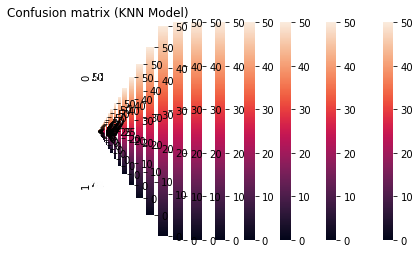

In [7]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization

    study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
    with parallel_backend('threading'):
        study_knn.optimize(objective_knn, n_trials=10, n_jobs=-1)
    
    # Evaluating our Optuna Trial
    print("Best trial:", study_knn.best_trial.number)
    print("Best accuracy:", study_knn.best_trial.value)
    print("Best hyperparameters:", study_knn.best_params)
    
    best_param_knn = study_knn.best_params
    KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
    y_pred_knn = KNN.predict(x_test_)

    

    display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(KNN, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [8]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.029940,0.032226,0.001583,0.043631,0.079798,0.018369,0.003560,0.024060,0
1,0.087488,0.006464,0.004083,0.013155,0.111702,0.003155,0.003464,0.061131,0
2,0.004726,0.088107,0.004488,0.043083,0.089440,0.005488,0.003107,0.001012,0
3,0.049905,0.019833,0.002881,0.026119,0.097238,0.000381,0.000143,0.034262,0
4,0.009512,0.036440,0.019726,0.042155,0.102488,0.006345,0.006036,0.007298,0
...,...,...,...,...,...,...,...,...,...
4995,0.050214,0.086357,0.011167,0.013595,0.072952,0.004333,0.052786,0.061881,1
4996,0.089107,0.321250,0.025774,0.032536,0.324036,0.033845,0.007512,0.014060,1
4997,0.163071,0.072929,0.033905,0.037429,0.105024,0.008548,0.003952,0.040048,1
4998,0.101393,0.008488,0.029679,0.001274,0.203512,0.059345,0.151440,0.034440,1


# value stabilty

In [9]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]

In [10]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('_knn_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.505158,0.538431,0.733764,0.234147,0.358615,0.582037,0.870523,0.792157,0.576854
1,0.221019,1.171816,1.590137,0.384882,0.599847,0.637269,0.493783,0.340760,0.679939
2,0.574280,0.351217,0.735231,0.343485,0.354317,0.622387,0.914082,1.245371,0.642546
3,0.317094,0.408183,1.487515,0.567870,0.440506,1.106437,1.055036,0.567661,0.743788
4,0.549199,0.298493,0.430477,0.654193,0.424653,0.817742,0.819308,0.552561,0.568328
...,...,...,...,...,...,...,...,...,...
95,1.043829,0.375388,1.107658,0.508666,0.575171,0.584450,0.720522,1.224995,0.767585
96,0.787364,0.291403,1.232456,0.594076,0.322391,1.211182,1.226776,1.044963,0.838826
97,0.376448,0.482264,0.968381,0.514315,0.792563,1.599463,0.707006,0.550702,0.748893
98,0.940502,0.461311,0.845208,0.596571,0.356992,0.540560,0.637770,0.612559,0.623934


In [11]:
valuestability

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.505158,0.538431,0.733764,0.234147,0.358615,0.582037,0.870523,0.792157,0.576854
1,0.221019,1.171816,1.590137,0.384882,0.599847,0.637269,0.493783,0.340760,0.679939
2,0.574280,0.351217,0.735231,0.343485,0.354317,0.622387,0.914082,1.245371,0.642546
3,0.317094,0.408183,1.487515,0.567870,0.440506,1.106437,1.055036,0.567661,0.743788
4,0.549199,0.298493,0.430477,0.654193,0.424653,0.817742,0.819308,0.552561,0.568328
...,...,...,...,...,...,...,...,...,...
95,1.043829,0.375388,1.107658,0.508666,0.575171,0.584450,0.720522,1.224995,0.767585
96,0.787364,0.291403,1.232456,0.594076,0.322391,1.211182,1.226776,1.044963,0.838826
97,0.376448,0.482264,0.968381,0.514315,0.792563,1.599463,0.707006,0.550702,0.748893
98,0.940502,0.461311,0.845208,0.596571,0.356992,0.540560,0.637770,0.612559,0.623934


## 4.3 Logistic Regression

In [12]:
df = pd.read_csv("data_resampled_50.csv")

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [14]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization
    
    # Creating and running our optimization

    study_lr = optuna.create_study(direction='maximize',study_name = "logr")
    with parallel_backend('threading'):
        study_lr.optimize(objective_lr, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_lr.best_trial.number)
    print("Best accuracy:", study_lr.best_trial.value)
    print("Best hyperparameters:", study_lr.best_params)

    # Train the model with the best parameters
    best_param_logr = study_lr.best_params
    LR = LogisticRegression(**best_param_logr, random_state=42).fit(x_train, y_train)


    
    # SHAP value computation using KernelExplainer
    explainer = shap.Explainer(LR, x_train_)
    shap_values = explainer(x_test_)


    # Extract SHAP values
    shap_values_array = abs(shap_values.values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)





[I 2024-08-26 20:23:05,402] A new study created in memory with name: logr
[I 2024-08-26 20:23:06,152] Trial 1 finished with value: 0.7742886565679836 and parameters: {'C': 0.208225337377514, 'solver': 'liblinear', 'max_iter': 356}. Best is trial 1 with value: 0.7742886565679836.
[I 2024-08-26 20:23:06,176] Trial 5 finished with value: 0.7785273832575227 and parameters: {'C': 0.4057248740983174, 'solver': 'liblinear', 'max_iter': 166}. Best is trial 5 with value: 0.7785273832575227.
[I 2024-08-26 20:23:06,966] Trial 2 finished with value: 0.6984952438307989 and parameters: {'C': 0.2791741412518068, 'solver': 'sag', 'max_iter': 266}. Best is trial 5 with value: 0.7785273832575227.
[I 2024-08-26 20:23:08,288] Trial 0 finished with value: 0.7115608551719802 and parameters: {'C': 0.08657557896483947, 'solver': 'sag', 'max_iter': 722}. Best is trial 5 with value: 0.7785273832575227.
[I 2024-08-26 20:23:10,046] Trial 9 finished with value: 0.7011887175251457 and parameters: {'C': 0.0281326001

Best trial: 7
Best accuracy: 0.7925268173030636
Best hyperparameters: {'C': 0.12954601273196137, 'solver': 'newton-cg', 'max_iter': 161}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020366  0.016316       0.000750       0.008399  0.001587  0.050584   
1      0.083934  0.006550       0.002331       0.098800  0.001445  0.015429   
2      0.083934  0.016316       0.013075       0.056613  0.008874  0.093362   
3      0.025786  0.005970       0.007044       0.050549  0.001704  0.032822   
4      0.074986  0.027167       0.009224       0.008399  0.011754  0.040499   
..          ...       ...            ...            ...       ...       ...   
95     0.233907  0.027088       0.007723       0.026479  0.000678  0.031933   
96     0.083934  0.053130       0.000020       0.069948  0.000374  0.089092   
97     0.115718  0.075917       0.003101       0.088028  0.006590  0.010242   
98     0.011418  0.028173       0.003101       0.020453  0.009902  0.0493

[I 2024-08-26 20:23:18,754] Trial 0 finished with value: 0.7155696717709711 and parameters: {'C': 0.022703731251540193, 'solver': 'liblinear', 'max_iter': 784}. Best is trial 0 with value: 0.7155696717709711.
[I 2024-08-26 20:23:19,127] Trial 4 finished with value: 0.699635967529372 and parameters: {'C': 0.001848018156853533, 'solver': 'sag', 'max_iter': 98}. Best is trial 0 with value: 0.7155696717709711.
[I 2024-08-26 20:23:19,438] Trial 1 finished with value: 0.7013970044545552 and parameters: {'C': 0.0013923734378080963, 'solver': 'sag', 'max_iter': 196}. Best is trial 0 with value: 0.7155696717709711.
[I 2024-08-26 20:23:20,069] Trial 7 finished with value: 0.7888555978249739 and parameters: {'C': 1.0598441566757808, 'solver': 'liblinear', 'max_iter': 496}. Best is trial 7 with value: 0.7888555978249739.
[I 2024-08-26 20:23:22,735] Trial 9 finished with value: 0.7083287139309633 and parameters: {'C': 0.008153391527091262, 'solver': 'sag', 'max_iter': 522}. Best is trial 7 with val

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.2865986395011557, 'solver': 'lbfgs', 'max_iter': 710}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021084  0.016380       0.000683       0.008355  0.001580  0.048958   
1      0.086894  0.006576       0.002122       0.098280  0.001439  0.014933   
2      0.086894  0.016380       0.011904       0.056315  0.008835  0.090360   
3      0.026695  0.005993       0.006413       0.050283  0.001697  0.031767   
4      0.077630  0.027273       0.008397       0.008355  0.011703  0.039197   
..          ...       ...            ...            ...       ...       ...   
95     0.242154  0.027193       0.007031       0.026340  0.000675  0.030906   
96     0.086894  0.053337       0.000018       0.069580  0.000373  0.086227   
97     0.119798  0.076213       0.002823       0.087565  0.006561  0.009913   
98     0.011821  0.028283       0.002823       0.020345  0.009859  0.047766   

[I 2024-08-26 20:23:31,824] Trial 1 finished with value: 0.7290325086977735 and parameters: {'C': 0.04230948019199121, 'solver': 'liblinear', 'max_iter': 919}. Best is trial 1 with value: 0.7290325086977735.
[I 2024-08-26 20:23:31,856] Trial 4 finished with value: 0.7727340373683497 and parameters: {'C': 0.31066785108003747, 'solver': 'liblinear', 'max_iter': 968}. Best is trial 4 with value: 0.7727340373683497.
[I 2024-08-26 20:23:31,868] Trial 5 finished with value: 0.7905144201615752 and parameters: {'C': 1.3295983392165147, 'solver': 'liblinear', 'max_iter': 979}. Best is trial 5 with value: 0.7905144201615752.
[I 2024-08-26 20:23:32,271] Trial 8 finished with value: 0.7180005903484497 and parameters: {'C': 0.024765215841513227, 'solver': 'liblinear', 'max_iter': 538}. Best is trial 5 with value: 0.7905144201615752.
[I 2024-08-26 20:23:32,701] Trial 9 finished with value: 0.7240997425101189 and parameters: {'C': 0.035224691404209266, 'solver': 'liblinear', 'max_iter': 53}. Best is 

Best trial: 5
Best accuracy: 0.7905144201615752
Best hyperparameters: {'C': 1.3295983392165147, 'solver': 'liblinear', 'max_iter': 979}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019841  0.012521       0.003945       0.006310  0.001377  0.025276   
1      0.081769  0.005027       0.012255       0.074223  0.001253  0.007710   
2      0.081769  0.012521       0.068744       0.042530  0.007697  0.046651   
3      0.025121  0.004581       0.037035       0.037975  0.001478  0.016400   
4      0.073052  0.020849       0.048494       0.006310  0.010195  0.020236   
..          ...       ...            ...            ...       ...       ...   
95     0.227872  0.020788       0.040605       0.019892  0.000588  0.015956   
96     0.081769  0.040774       0.000105       0.052548  0.000325  0.044517   
97     0.112733  0.058261       0.016305       0.066131  0.005716  0.005118   
98     0.011123  0.021621       0.016305       0.015365  0.008589  0.02466

[I 2024-08-26 20:23:37,798] Trial 0 finished with value: 0.7011825708322976 and parameters: {'C': 0.011746416634896891, 'solver': 'saga', 'max_iter': 599}. Best is trial 0 with value: 0.7011825708322976.
[I 2024-08-26 20:23:48,700] Trial 6 finished with value: 0.7945031356814864 and parameters: {'C': 3.5656429319292458, 'solver': 'lbfgs', 'max_iter': 438}. Best is trial 6 with value: 0.7945031356814864.
[I 2024-08-26 20:23:50,279] Trial 1 finished with value: 0.794969308008623 and parameters: {'C': 1.2419452058338811, 'solver': 'newton-cg', 'max_iter': 655}. Best is trial 1 with value: 0.794969308008623.
[I 2024-08-26 20:23:50,302] Trial 2 finished with value: 0.7945031356814864 and parameters: {'C': 2.7993320297903383, 'solver': 'newton-cg', 'max_iter': 144}. Best is trial 1 with value: 0.794969308008623.
[I 2024-08-26 20:23:50,442] Trial 4 finished with value: 0.7945031356814864 and parameters: {'C': 5.391623321077281, 'solver': 'newton-cg', 'max_iter': 367}. Best is trial 1 with val

Best trial: 1
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2419452058338811, 'solver': 'newton-cg', 'max_iter': 655}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020984  0.016360       0.000692       0.008355  0.001580  0.049149   
1      0.086479  0.006568       0.002149       0.098276  0.001439  0.014992   
2      0.086479  0.016360       0.012056       0.056313  0.008835  0.090713   
3      0.026568  0.005986       0.006495       0.050281  0.001697  0.031891   
4      0.077259  0.027240       0.008505       0.008355  0.011703  0.039350   
..          ...       ...            ...            ...       ...       ...   
95     0.240998  0.027161       0.007121       0.026339  0.000675  0.031027   
96     0.086479  0.053273       0.000018       0.069577  0.000373  0.086564   
97     0.119226  0.076122       0.002860       0.087561  0.006562  0.009952   
98     0.011764  0.028249       0.002860       0.020344  0.009859  0.047953

[I 2024-08-26 20:23:53,349] Trial 1 finished with value: 0.7762442588571878 and parameters: {'C': 0.3576487342417818, 'solver': 'liblinear', 'max_iter': 359}. Best is trial 1 with value: 0.7762442588571878.
[I 2024-08-26 20:23:53,408] Trial 5 finished with value: 0.6985803270843378 and parameters: {'C': 0.004478029534466185, 'solver': 'liblinear', 'max_iter': 696}. Best is trial 1 with value: 0.7762442588571878.
[I 2024-08-26 20:23:55,420] Trial 4 finished with value: 0.6981974070804202 and parameters: {'C': 0.6374803890930673, 'solver': 'saga', 'max_iter': 485}. Best is trial 1 with value: 0.7762442588571878.
[I 2024-08-26 20:23:56,360] Trial 0 finished with value: 0.70544190238076 and parameters: {'C': 0.0038203310130367333, 'solver': 'saga', 'max_iter': 789}. Best is trial 1 with value: 0.7762442588571878.
[I 2024-08-26 20:23:59,399] Trial 8 finished with value: 0.7022208214741326 and parameters: {'C': 6.596147117656545, 'solver': 'saga', 'max_iter': 838}. Best is trial 1 with value

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1574323376760842, 'solver': 'lbfgs', 'max_iter': 266}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020972  0.016358       0.000692       0.008354  0.001580  0.049169   
1      0.086432  0.006567       0.002151       0.098272  0.001439  0.014998   
2      0.086432  0.016358       0.012068       0.056310  0.008835  0.090749   
3      0.026553  0.005985       0.006501       0.050279  0.001697  0.031904   
4      0.077218  0.027237       0.008513       0.008354  0.011704  0.039365   
..          ...       ...            ...            ...       ...       ...   
95     0.240868  0.027158       0.007128       0.026338  0.000675  0.031039   
96     0.086432  0.053267       0.000018       0.069574  0.000373  0.086599   
97     0.119162  0.076113       0.002862       0.087558  0.006562  0.009956   
98     0.011758  0.028246       0.002862       0.020343  0.009860  0.047972   


[I 2024-08-26 20:24:08,033] Trial 0 finished with value: 0.6962214544488995 and parameters: {'C': 0.5979689582404077, 'solver': 'sag', 'max_iter': 212}. Best is trial 0 with value: 0.6962214544488995.
[I 2024-08-26 20:24:10,066] Trial 1 finished with value: 0.7018569944467659 and parameters: {'C': 4.754180334497778, 'solver': 'saga', 'max_iter': 714}. Best is trial 1 with value: 0.7018569944467659.
[I 2024-08-26 20:24:10,616] Trial 2 finished with value: 0.7028045522948007 and parameters: {'C': 0.07531770150262676, 'solver': 'saga', 'max_iter': 851}. Best is trial 2 with value: 0.7028045522948007.
[I 2024-08-26 20:24:10,774] Trial 7 finished with value: 0.6985942283399688 and parameters: {'C': 0.001792155858357998, 'solver': 'liblinear', 'max_iter': 382}. Best is trial 2 with value: 0.7028045522948007.
[I 2024-08-26 20:24:11,752] Trial 8 finished with value: 0.6951310893769691 and parameters: {'C': 0.4150804837285847, 'solver': 'sag', 'max_iter': 101}. Best is trial 2 with value: 0.702

Best trial: 5
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 8.363278191811405, 'solver': 'newton-cg', 'max_iter': 657}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021122  0.016388       0.000680       0.008351  0.001580  0.048891   
1      0.087048  0.006579       0.002111       0.098238  0.001438  0.014913   
2      0.087048  0.016388       0.011844       0.056291  0.008834  0.090236   
3      0.026743  0.005996       0.006381       0.050262  0.001697  0.031723   
4      0.077768  0.027286       0.008355       0.008351  0.011702  0.039143   
..          ...       ...            ...            ...       ...       ...   
95     0.242583  0.027207       0.006996       0.026329  0.000675  0.030864   
96     0.087048  0.053364       0.000018       0.069550  0.000373  0.086109   
97     0.120011  0.076251       0.002809       0.087528  0.006561  0.009900   
98     0.011842  0.028297       0.002809       0.020336  0.009859  0.047701

[I 2024-08-26 20:24:19,205] Trial 1 finished with value: 0.7014648188075115 and parameters: {'C': 0.0066878944682792155, 'solver': 'liblinear', 'max_iter': 763}. Best is trial 1 with value: 0.7014648188075115.
[I 2024-08-26 20:24:19,217] Trial 4 finished with value: 0.7253549593708085 and parameters: {'C': 0.036198414089691384, 'solver': 'liblinear', 'max_iter': 885}. Best is trial 4 with value: 0.7253549593708085.
[I 2024-08-26 20:24:19,228] Trial 2 finished with value: 0.7551736739204621 and parameters: {'C': 0.09056820573939389, 'solver': 'liblinear', 'max_iter': 815}. Best is trial 2 with value: 0.7551736739204621.
[I 2024-08-26 20:24:19,949] Trial 8 finished with value: 0.7352913604167526 and parameters: {'C': 0.04995767872690124, 'solver': 'liblinear', 'max_iter': 211}. Best is trial 2 with value: 0.7551736739204621.
[I 2024-08-26 20:24:20,993] Trial 7 finished with value: 0.6981272095539113 and parameters: {'C': 0.002586602064532106, 'solver': 'saga', 'max_iter': 240}. Best is t

Best trial: 5
Best accuracy: 0.7940773632412477
Best hyperparameters: {'C': 0.2531941417547156, 'solver': 'lbfgs', 'max_iter': 268}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020616  0.016326       0.000722       0.008380  0.001584  0.050049   
1      0.084963  0.006554       0.002242       0.098577  0.001442  0.015266   
2      0.084963  0.016326       0.012577       0.056485  0.008854  0.092374   
3      0.026102  0.005974       0.006776       0.050435  0.001701  0.032475   
4      0.075905  0.027184       0.008872       0.008380  0.011729  0.040070   
..          ...       ...            ...            ...       ...       ...   
95     0.236772  0.027104       0.007429       0.026420  0.000676  0.031595   
96     0.084963  0.053162       0.000019       0.069790  0.000374  0.088149   
97     0.117136  0.075963       0.002983       0.087830  0.006576  0.010134   
98     0.011558  0.028190       0.002983       0.020407  0.009881  0.048831   

[I 2024-08-26 20:24:28,023] Trial 4 finished with value: 0.705626547412337 and parameters: {'C': 0.010713180753970743, 'solver': 'liblinear', 'max_iter': 857}. Best is trial 4 with value: 0.705626547412337.
[I 2024-08-26 20:24:28,064] Trial 2 finished with value: 0.7903823825519676 and parameters: {'C': 3.6283650612484504, 'solver': 'liblinear', 'max_iter': 771}. Best is trial 2 with value: 0.7903823825519676.
[I 2024-08-26 20:24:28,111] Trial 1 finished with value: 0.7825646933593525 and parameters: {'C': 0.74355018189575, 'solver': 'liblinear', 'max_iter': 877}. Best is trial 2 with value: 0.7903823825519676.
[I 2024-08-26 20:24:28,156] Trial 3 finished with value: 0.7669568531441976 and parameters: {'C': 0.14465588547582758, 'solver': 'liblinear', 'max_iter': 656}. Best is trial 2 with value: 0.7903823825519676.
[I 2024-08-26 20:24:28,952] Trial 6 finished with value: 0.7794980506443667 and parameters: {'C': 0.431291590435669, 'solver': 'liblinear', 'max_iter': 874}. Best is trial 2

Best trial: 0
Best accuracy: 0.7943897844602273
Best hyperparameters: {'C': 0.4006520336204895, 'solver': 'lbfgs', 'max_iter': 244}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020764  0.016325       0.000718       0.008368  0.001581  0.049655   
1      0.085572  0.006554       0.002230       0.098433  0.001440  0.015146   
2      0.085572  0.016325       0.012510       0.056403  0.008841  0.091646   
3      0.026289  0.005973       0.006740       0.050362  0.001698  0.032219   
4      0.076450  0.027182       0.008825       0.008368  0.011711  0.039754   
..          ...       ...            ...            ...       ...       ...   
95     0.238471  0.027103       0.007389       0.026381  0.000675  0.031346   
96     0.085572  0.053160       0.000019       0.069688  0.000373  0.087455   
97     0.117977  0.075960       0.002967       0.087701  0.006566  0.010054   
98     0.011641  0.028189       0.002967       0.020377  0.009866  0.048446   

[I 2024-08-26 20:24:33,903] Trial 5 finished with value: 0.7207802831919504 and parameters: {'C': 0.02756823182195859, 'solver': 'liblinear', 'max_iter': 258}. Best is trial 5 with value: 0.7207802831919504.
[I 2024-08-26 20:24:34,851] Trial 3 finished with value: 0.7030095804323899 and parameters: {'C': 0.0022242491057236345, 'solver': 'sag', 'max_iter': 226}. Best is trial 5 with value: 0.7207802831919504.
[I 2024-08-26 20:24:37,078] Trial 7 finished with value: 0.7025058078056307 and parameters: {'C': 0.17348760560780604, 'solver': 'sag', 'max_iter': 416}. Best is trial 5 with value: 0.7207802831919504.
[I 2024-08-26 20:24:37,496] Trial 4 finished with value: 0.7167808161743332 and parameters: {'C': 0.48649360699872696, 'solver': 'sag', 'max_iter': 935}. Best is trial 5 with value: 0.7207802831919504.
[I 2024-08-26 20:24:37,596] Trial 6 finished with value: 0.7007694452667369 and parameters: {'C': 0.31092602975755557, 'solver': 'saga', 'max_iter': 680}. Best is trial 5 with value: 0

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.939511506142745, 'solver': 'newton-cg', 'max_iter': 222}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021092  0.016381       0.000682       0.008352  0.001580  0.048944   
1      0.086925  0.006576       0.002119       0.098244  0.001438  0.014929   
2      0.086925  0.016381       0.011888       0.056294  0.008834  0.090334   
3      0.026705  0.005994       0.006405       0.050265  0.001697  0.031758   
4      0.077658  0.027276       0.008387       0.008352  0.011702  0.039185   
..          ...       ...            ...            ...       ...       ...   
95     0.242240  0.027196       0.007022       0.026330  0.000675  0.030897   
96     0.086925  0.053343       0.000018       0.069554  0.000373  0.086203   
97     0.119841  0.076221       0.002820       0.087533  0.006561  0.009910   
98     0.011825  0.028286       0.002820       0.020338  0.009858  0.047753

[I 2024-08-26 20:24:47,279] Trial 5 finished with value: 0.7071446201054153 and parameters: {'C': 0.4428419264492948, 'solver': 'sag', 'max_iter': 616}. Best is trial 5 with value: 0.7071446201054153.
[I 2024-08-26 20:24:47,436] Trial 4 finished with value: 0.7088101738848923 and parameters: {'C': 0.4476542921732694, 'solver': 'sag', 'max_iter': 661}. Best is trial 4 with value: 0.7088101738848923.
[I 2024-08-26 20:24:48,174] Trial 6 finished with value: 0.7047436177217601 and parameters: {'C': 0.009962119730409254, 'solver': 'liblinear', 'max_iter': 628}. Best is trial 4 with value: 0.7088101738848923.
[I 2024-08-26 20:24:50,007] Trial 8 finished with value: 0.6955295505749595 and parameters: {'C': 0.17776899623843742, 'solver': 'saga', 'max_iter': 247}. Best is trial 4 with value: 0.7088101738848923.
[I 2024-08-26 20:24:50,583] Trial 7 finished with value: 0.7129479173623882 and parameters: {'C': 0.004892442079767303, 'solver': 'sag', 'max_iter': 665}. Best is trial 7 with value: 0.7

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.1086481612182997, 'solver': 'lbfgs', 'max_iter': 781}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021071  0.016376       0.000682       0.008354  0.001580  0.048957   
1      0.086839  0.006574       0.002118       0.098267  0.001439  0.014933   
2      0.086839  0.016376       0.011880       0.056308  0.008835  0.090358   
3      0.026679  0.005992       0.006400       0.050277  0.001697  0.031766   
4      0.077581  0.027266       0.008380       0.008354  0.011703  0.039196   
..          ...       ...            ...            ...       ...       ...   
95     0.242002  0.027187       0.007017       0.026337  0.000675  0.030905   
96     0.086839  0.053325       0.000018       0.069571  0.000373  0.086226   
97     0.119723  0.076195       0.002818       0.087554  0.006562  0.009913   
98     0.011813  0.028276       0.002818       0.020342  0.009859  0.047765   

[I 2024-08-26 20:24:55,455] Trial 2 finished with value: 0.7865150968333352 and parameters: {'C': 0.8855118922499788, 'solver': 'liblinear', 'max_iter': 242}. Best is trial 2 with value: 0.7865150968333352.
[I 2024-08-26 20:24:55,470] Trial 0 finished with value: 0.7817872053550251 and parameters: {'C': 0.7151784514098056, 'solver': 'liblinear', 'max_iter': 537}. Best is trial 2 with value: 0.7865150968333352.
[I 2024-08-26 20:24:55,482] Trial 4 finished with value: 0.7841934286126624 and parameters: {'C': 0.8062349314449739, 'solver': 'liblinear', 'max_iter': 694}. Best is trial 2 with value: 0.7865150968333352.
[I 2024-08-26 20:24:55,623] Trial 5 finished with value: 0.6958865081696033 and parameters: {'C': 0.007385106018977893, 'solver': 'sag', 'max_iter': 53}. Best is trial 2 with value: 0.7865150968333352.
[I 2024-08-26 20:24:56,088] Trial 7 finished with value: 0.7044526306592348 and parameters: {'C': 0.009250090917542107, 'solver': 'liblinear', 'max_iter': 809}. Best is trial 2 

Best trial: 8
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.7941103405729038, 'solver': 'newton-cg', 'max_iter': 358}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021030  0.016369       0.000688       0.008353  0.001580  0.049059   
1      0.086668  0.006571       0.002136       0.098260  0.001439  0.014964   
2      0.086668  0.016369       0.011984       0.056304  0.008835  0.090548   
3      0.026626  0.005989       0.006456       0.050273  0.001697  0.031833   
4      0.077429  0.027255       0.008454       0.008353  0.011702  0.039278   
..          ...       ...            ...            ...       ...       ...   
95     0.241526  0.027175       0.007078       0.026335  0.000675  0.030970   
96     0.086668  0.053302       0.000018       0.069566  0.000373  0.086406   
97     0.119488  0.076162       0.002842       0.087547  0.006561  0.009934   
98     0.011790  0.028264       0.002842       0.020341  0.009859  0.04786

[I 2024-08-26 20:25:02,577] Trial 2 finished with value: 0.6978778979481816 and parameters: {'C': 0.2852827951359022, 'solver': 'sag', 'max_iter': 236}. Best is trial 2 with value: 0.6978778979481816.
[I 2024-08-26 20:25:04,053] Trial 1 finished with value: 0.698889725530559 and parameters: {'C': 0.1009197995699476, 'solver': 'saga', 'max_iter': 621}. Best is trial 1 with value: 0.698889725530559.
[I 2024-08-26 20:25:05,390] Trial 7 finished with value: 0.7013496619527175 and parameters: {'C': 0.0010437187424558842, 'solver': 'sag', 'max_iter': 334}. Best is trial 7 with value: 0.7013496619527175.
[I 2024-08-26 20:25:11,226] Trial 4 finished with value: 0.7862039366610982 and parameters: {'C': 0.01046635294187045, 'solver': 'lbfgs', 'max_iter': 908}. Best is trial 4 with value: 0.7862039366610982.
[I 2024-08-26 20:25:14,195] Trial 9 finished with value: 0.698889725530559 and parameters: {'C': 0.4355275706564721, 'solver': 'saga', 'max_iter': 598}. Best is trial 4 with value: 0.78620393

Best trial: 0
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.755214423495803, 'solver': 'newton-cg', 'max_iter': 926}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020899  0.016346       0.000700       0.008358  0.001581  0.049325   
1      0.086129  0.006562       0.002174       0.098314  0.001439  0.015045   
2      0.086129  0.016346       0.012195       0.056335  0.008837  0.091037   
3      0.026460  0.005981       0.006570       0.050301  0.001697  0.032005   
4      0.076947  0.027217       0.008602       0.008358  0.011706  0.039490   
..          ...       ...            ...            ...       ...       ...   
95     0.240023  0.027137       0.007203       0.026349  0.000675  0.031138   
96     0.086129  0.053227       0.000019       0.069604  0.000373  0.086874   
97     0.118744  0.076056       0.002892       0.087596  0.006563  0.009987   
98     0.011717  0.028224       0.002892       0.020352  0.009861  0.048124

[I 2024-08-26 20:25:17,860] Trial 2 finished with value: 0.6993651555376387 and parameters: {'C': 0.0010775148852383066, 'solver': 'liblinear', 'max_iter': 919}. Best is trial 2 with value: 0.6993651555376387.
[I 2024-08-26 20:25:17,941] Trial 3 finished with value: 0.7673851055104128 and parameters: {'C': 0.15330246217378643, 'solver': 'liblinear', 'max_iter': 317}. Best is trial 3 with value: 0.7673851055104128.
[I 2024-08-26 20:25:17,995] Trial 1 finished with value: 0.7078038011870212 and parameters: {'C': 0.014102659601468547, 'solver': 'liblinear', 'max_iter': 99}. Best is trial 3 with value: 0.7673851055104128.
[I 2024-08-26 20:25:19,373] Trial 5 finished with value: 0.6978732005509596 and parameters: {'C': 0.004913395143447602, 'solver': 'saga', 'max_iter': 356}. Best is trial 3 with value: 0.7673851055104128.
[I 2024-08-26 20:25:19,519] Trial 6 finished with value: 0.7016246039856857 and parameters: {'C': 0.0015293464742307152, 'solver': 'sag', 'max_iter': 675}. Best is trial 

Best trial: 7
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0027190845714191, 'solver': 'lbfgs', 'max_iter': 992}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020957  0.016355       0.000694       0.008356  0.001581  0.049209   
1      0.086370  0.006566       0.002157       0.098287  0.001439  0.015010   
2      0.086370  0.016355       0.012100       0.056319  0.008837  0.090824   
3      0.026534  0.005984       0.006519       0.050287  0.001697  0.031930   
4      0.077162  0.027232       0.008536       0.008356  0.011705  0.039398   
..          ...       ...            ...            ...       ...       ...   
95     0.240694  0.027153       0.007147       0.026342  0.000675  0.031065   
96     0.086370  0.053258       0.000019       0.069585  0.000373  0.086670   
97     0.119076  0.076100       0.002870       0.087571  0.006563  0.009964   
98     0.011749  0.028241       0.002870       0.020346  0.009861  0.048011   


[I 2024-08-26 20:25:25,862] Trial 0 finished with value: 0.7176305977968773 and parameters: {'C': 0.024516368680134487, 'solver': 'liblinear', 'max_iter': 926}. Best is trial 0 with value: 0.7176305977968773.
[I 2024-08-26 20:25:25,877] Trial 5 finished with value: 0.7805546152906492 and parameters: {'C': 0.5571749880441222, 'solver': 'liblinear', 'max_iter': 985}. Best is trial 5 with value: 0.7805546152906492.
[I 2024-08-26 20:25:27,402] Trial 2 finished with value: 0.696517317745646 and parameters: {'C': 5.566311841265297, 'solver': 'saga', 'max_iter': 372}. Best is trial 5 with value: 0.7805546152906492.
[I 2024-08-26 20:25:28,463] Trial 4 finished with value: 0.7008956602800336 and parameters: {'C': 0.029129571580442562, 'solver': 'saga', 'max_iter': 673}. Best is trial 5 with value: 0.7805546152906492.
[I 2024-08-26 20:25:30,950] Trial 9 finished with value: 0.7050459649934563 and parameters: {'C': 0.013701474816523096, 'solver': 'sag', 'max_iter': 468}. Best is trial 5 with valu

Best trial: 3
Best accuracy: 0.7947565194239037
Best hyperparameters: {'C': 1.1631986211832959, 'solver': 'lbfgs', 'max_iter': 114}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021028  0.016380       0.000708       0.008305  0.001579  0.049532   
1      0.086661  0.006576       0.002199       0.097686  0.001438  0.015108   
2      0.086661  0.016380       0.012332       0.055975  0.008830  0.091420   
3      0.026624  0.005993       0.006644       0.049980  0.001696  0.032139   
4      0.077423  0.027273       0.008700       0.008305  0.011696  0.039656   
..          ...       ...            ...            ...       ...       ...   
95     0.241506  0.027194       0.007284       0.026181  0.000674  0.031269   
96     0.086661  0.053338       0.000019       0.069160  0.000373  0.087239   
97     0.119478  0.076215       0.002925       0.087036  0.006558  0.010029   
98     0.011789  0.028283       0.002925       0.020222  0.009853  0.048327   

[I 2024-08-26 20:25:38,585] Trial 3 finished with value: 0.7906156034394405 and parameters: {'C': 1.8378748770768316, 'solver': 'liblinear', 'max_iter': 913}. Best is trial 3 with value: 0.7906156034394405.
[I 2024-08-26 20:25:39,195] Trial 6 finished with value: 0.6981272095539113 and parameters: {'C': 0.0026512401061466085, 'solver': 'liblinear', 'max_iter': 411}. Best is trial 3 with value: 0.7906156034394405.
[I 2024-08-26 20:25:39,408] Trial 5 finished with value: 0.696517317745646 and parameters: {'C': 0.1495968813702959, 'solver': 'sag', 'max_iter': 198}. Best is trial 3 with value: 0.7906156034394405.
[I 2024-08-26 20:25:39,479] Trial 2 finished with value: 0.7013970044545552 and parameters: {'C': 0.0014718732172431114, 'solver': 'sag', 'max_iter': 557}. Best is trial 3 with value: 0.7906156034394405.
[I 2024-08-26 20:25:40,583] Trial 7 finished with value: 0.6962154726240357 and parameters: {'C': 0.5543861232273591, 'solver': 'sag', 'max_iter': 166}. Best is trial 3 with value

Best trial: 3
Best accuracy: 0.7906156034394405
Best hyperparameters: {'C': 1.8378748770768316, 'solver': 'liblinear', 'max_iter': 913}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019878  0.013124       0.003356       0.006613  0.001403  0.029165   
1      0.081921  0.005269       0.010426       0.077788  0.001277  0.008896   
2      0.081921  0.013124       0.058482       0.044573  0.007842  0.053829   
3      0.025167  0.004802       0.031507       0.039799  0.001506  0.018924   
4      0.073187  0.021852       0.041255       0.006613  0.010387  0.023350   
..          ...       ...            ...            ...       ...       ...   
95     0.228296  0.021788       0.034544       0.020848  0.000599  0.018411   
96     0.081921  0.042736       0.000090       0.055072  0.000331  0.051367   
97     0.112942  0.061065       0.013871       0.069307  0.005824  0.005905   
98     0.011144  0.022661       0.013871       0.016103  0.008751  0.02845

[I 2024-08-26 20:25:44,316] Trial 5 finished with value: 0.6953247637222756 and parameters: {'C': 0.033726405958182666, 'solver': 'saga', 'max_iter': 116}. Best is trial 5 with value: 0.6953247637222756.
[I 2024-08-26 20:25:44,399] Trial 0 finished with value: 0.6955295505749595 and parameters: {'C': 5.112546488790111, 'solver': 'sag', 'max_iter': 147}. Best is trial 0 with value: 0.6955295505749595.
[I 2024-08-26 20:25:47,041] Trial 6 finished with value: 0.706729536234002 and parameters: {'C': 8.530004509395367, 'solver': 'sag', 'max_iter': 533}. Best is trial 6 with value: 0.706729536234002.
[I 2024-08-26 20:25:48,677] Trial 3 finished with value: 0.7459383902327451 and parameters: {'C': 0.050743936877191434, 'solver': 'lbfgs', 'max_iter': 62}. Best is trial 3 with value: 0.7459383902327451.
[I 2024-08-26 20:25:50,247] Trial 2 finished with value: 0.7816290244502758 and parameters: {'C': 2.0994370130896125, 'solver': 'lbfgs', 'max_iter': 85}. Best is trial 2 with value: 0.7816290244

Best trial: 7
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2616444415912411, 'solver': 'newton-cg', 'max_iter': 949}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020986  0.016360       0.000692       0.008355  0.001580  0.049145   
1      0.086488  0.006568       0.002149       0.098275  0.001439  0.014990   
2      0.086488  0.016360       0.012053       0.056312  0.008835  0.090705   
3      0.026571  0.005986       0.006493       0.050281  0.001697  0.031888   
4      0.077268  0.027241       0.008502       0.008355  0.011703  0.039346   
..          ...       ...            ...            ...       ...       ...   
95     0.241023  0.027162       0.007119       0.026339  0.000675  0.031024   
96     0.086488  0.053275       0.000018       0.069576  0.000373  0.086557   
97     0.119239  0.076124       0.002859       0.087561  0.006562  0.009951   
98     0.011765  0.028250       0.002859       0.020344  0.009859  0.047949

[I 2024-08-26 20:25:56,677] Trial 2 finished with value: 0.6973007054700896 and parameters: {'C': 0.0037106692620894584, 'solver': 'liblinear', 'max_iter': 388}. Best is trial 2 with value: 0.6973007054700896.
[I 2024-08-26 20:25:56,881] Trial 5 finished with value: 0.6949227023860971 and parameters: {'C': 0.1016911079088102, 'solver': 'sag', 'max_iter': 62}. Best is trial 2 with value: 0.6973007054700896.
[I 2024-08-26 20:25:57,423] Trial 3 finished with value: 0.697974891540029 and parameters: {'C': 0.009074271682611814, 'solver': 'sag', 'max_iter': 190}. Best is trial 3 with value: 0.697974891540029.
[I 2024-08-26 20:25:57,480] Trial 6 finished with value: 0.7915478288171601 and parameters: {'C': 4.240304215343655, 'solver': 'liblinear', 'max_iter': 574}. Best is trial 6 with value: 0.7915478288171601.
[I 2024-08-26 20:25:59,223] Trial 1 finished with value: 0.7136176909132591 and parameters: {'C': 0.016470265080011443, 'solver': 'sag', 'max_iter': 726}. Best is trial 6 with value: 

Best trial: 6
Best accuracy: 0.7915478288171601
Best hyperparameters: {'C': 4.240304215343655, 'solver': 'liblinear', 'max_iter': 574}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020223  0.014450       0.002174       0.007306  0.001469  0.037417   
1      0.083344  0.005801       0.006754       0.085943  0.001337  0.011413   
2      0.083344  0.014450       0.037886       0.049246  0.008212  0.069060   
3      0.025605  0.005287       0.020410       0.043971  0.001577  0.024278   
4      0.074459  0.024060       0.026726       0.007306  0.010877  0.029957   
..          ...       ...            ...            ...       ...       ...   
95     0.232261  0.023990       0.022378       0.023033  0.000627  0.023621   
96     0.083344  0.047055       0.000058       0.060845  0.000346  0.065901   
97     0.114904  0.067236       0.008986       0.076573  0.006099  0.007576   
98     0.011338  0.024951       0.008986       0.017791  0.009163  0.036506

[I 2024-08-26 20:26:06,813] Trial 2 finished with value: 0.7596944263962507 and parameters: {'C': 0.11608506943283875, 'solver': 'liblinear', 'max_iter': 944}. Best is trial 2 with value: 0.7596944263962507.
[I 2024-08-26 20:26:07,898] Trial 5 finished with value: 0.7051111125333743 and parameters: {'C': 0.002048227379474145, 'solver': 'sag', 'max_iter': 741}. Best is trial 2 with value: 0.7596944263962507.
[I 2024-08-26 20:26:11,043] Trial 6 finished with value: 0.7178614953887498 and parameters: {'C': 1.5854816155858384, 'solver': 'sag', 'max_iter': 978}. Best is trial 2 with value: 0.7596944263962507.
[I 2024-08-26 20:26:11,085] Trial 7 finished with value: 0.7000635360207086 and parameters: {'C': 0.4560593014344992, 'solver': 'saga', 'max_iter': 646}. Best is trial 2 with value: 0.7596944263962507.
[I 2024-08-26 20:26:13,748] Trial 9 finished with value: 0.708029647700136 and parameters: {'C': 0.022869294333194068, 'solver': 'sag', 'max_iter': 581}. Best is trial 2 with value: 0.75

Best trial: 0
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.29347685378954147, 'solver': 'newton-cg', 'max_iter': 544}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020657  0.016320       0.000724       0.008373  0.001583  0.049887   
1      0.085131  0.006552       0.002248       0.098491  0.001441  0.015217   
2      0.085131  0.016320       0.012610       0.056436  0.008849  0.092075   
3      0.026154  0.005971       0.006793       0.050391  0.001700  0.032370   
4      0.076055  0.027173       0.008895       0.008373  0.011721  0.039940   
..          ...       ...            ...            ...       ...       ...   
95     0.237242  0.027094       0.007448       0.026397  0.000676  0.031493   
96     0.085131  0.053142       0.000019       0.069729  0.000373  0.087864   
97     0.117369  0.075934       0.002991       0.087753  0.006572  0.010101   
98     0.011581  0.028179       0.002991       0.020389  0.009874  0.0486

[I 2024-08-26 20:26:19,858] Trial 2 finished with value: 0.7238922644939475 and parameters: {'C': 0.033238436539898726, 'solver': 'liblinear', 'max_iter': 935}. Best is trial 2 with value: 0.7238922644939475.
[I 2024-08-26 20:26:20,366] Trial 6 finished with value: 0.6990049951917784 and parameters: {'C': 0.005064767955217926, 'solver': 'liblinear', 'max_iter': 345}. Best is trial 2 with value: 0.7238922644939475.
[I 2024-08-26 20:26:22,445] Trial 1 finished with value: 0.711987064815914 and parameters: {'C': 0.004327401693931416, 'solver': 'sag', 'max_iter': 611}. Best is trial 2 with value: 0.7238922644939475.
[I 2024-08-26 20:26:22,470] Trial 7 finished with value: 0.7001573461229391 and parameters: {'C': 0.0014600778548164357, 'solver': 'saga', 'max_iter': 457}. Best is trial 2 with value: 0.7238922644939475.
[I 2024-08-26 20:26:22,533] Trial 4 finished with value: 0.706729536234002 and parameters: {'C': 0.25165473026144664, 'solver': 'sag', 'max_iter': 545}. Best is trial 2 with v

Best trial: 9
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.49533731595936736, 'solver': 'newton-cg', 'max_iter': 402}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020804  0.016333       0.000709       0.008363  0.001581  0.049535   
1      0.085738  0.006557       0.002203       0.098372  0.001439  0.015110   
2      0.085738  0.016333       0.012355       0.056368  0.008840  0.091426   
3      0.026340  0.005976       0.006656       0.050330  0.001698  0.032142   
4      0.076597  0.027195       0.008716       0.008363  0.011710  0.039659   
..          ...       ...            ...            ...       ...       ...   
95     0.238932  0.027116       0.007298       0.026365  0.000675  0.031271   
96     0.085738  0.053185       0.000019       0.069645  0.000373  0.087245   
97     0.118205  0.075996       0.002930       0.087647  0.006566  0.010030   
98     0.011663  0.028202       0.002930       0.020364  0.009865  0.0483

[I 2024-08-26 20:26:28,025] Trial 4 finished with value: 0.696922438894905 and parameters: {'C': 0.2061166121381376, 'solver': 'sag', 'max_iter': 224}. Best is trial 4 with value: 0.696922438894905.
[I 2024-08-26 20:26:28,296] Trial 2 finished with value: 0.6955295505749595 and parameters: {'C': 0.4985753312414124, 'solver': 'saga', 'max_iter': 232}. Best is trial 4 with value: 0.696922438894905.
[I 2024-08-26 20:26:28,305] Trial 5 finished with value: 0.698889725530559 and parameters: {'C': 0.2024621816359175, 'solver': 'sag', 'max_iter': 302}. Best is trial 5 with value: 0.698889725530559.
[I 2024-08-26 20:26:28,697] Trial 0 finished with value: 0.7020933917877175 and parameters: {'C': 0.001792553728871363, 'solver': 'saga', 'max_iter': 643}. Best is trial 0 with value: 0.7020933917877175.
[I 2024-08-26 20:26:37,446] Trial 3 finished with value: 0.7945031356814864 and parameters: {'C': 8.204792241303334, 'solver': 'lbfgs', 'max_iter': 998}. Best is trial 3 with value: 0.7945031356814

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 8.204792241303334, 'solver': 'lbfgs', 'max_iter': 998}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021121  0.016388       0.000680       0.008351  0.001580  0.048891   
1      0.087043  0.006579       0.002112       0.098234  0.001438  0.014913   
2      0.087043  0.016388       0.011846       0.056289  0.008834  0.090238   
3      0.026741  0.005996       0.006382       0.050260  0.001697  0.031724   
4      0.077764  0.027287       0.008356       0.008351  0.011702  0.039143   
..          ...       ...            ...            ...       ...       ...   
95     0.242571  0.027208       0.006997       0.026328  0.000675  0.030864   
96     0.087043  0.053365       0.000018       0.069547  0.000373  0.086111   
97     0.120005  0.076253       0.002810       0.087524  0.006561  0.009900   
98     0.011841  0.028298       0.002810       0.020335  0.009858  0.047702   


[I 2024-08-26 20:26:43,626] Trial 2 finished with value: 0.7885573576273822 and parameters: {'C': 1.0334396211596497, 'solver': 'liblinear', 'max_iter': 196}. Best is trial 2 with value: 0.7885573576273822.
[I 2024-08-26 20:26:43,999] Trial 5 finished with value: 0.6949153501374558 and parameters: {'C': 0.017387558455397415, 'solver': 'saga', 'max_iter': 94}. Best is trial 2 with value: 0.7885573576273822.
[I 2024-08-26 20:26:44,970] Trial 7 finished with value: 0.6952653175211491 and parameters: {'C': 3.6710938505431696, 'solver': 'saga', 'max_iter': 55}. Best is trial 2 with value: 0.7885573576273822.
[I 2024-08-26 20:26:46,380] Trial 0 finished with value: 0.7014831994438149 and parameters: {'C': 0.294274199824669, 'solver': 'saga', 'max_iter': 697}. Best is trial 2 with value: 0.7885573576273822.
[I 2024-08-26 20:26:47,111] Trial 9 finished with value: 0.7155696717709711 and parameters: {'C': 0.022728643451711477, 'solver': 'liblinear', 'max_iter': 307}. Best is trial 2 with value:

Best trial: 6
Best accuracy: 0.7910300359379208
Best hyperparameters: {'C': 0.1046320801756475, 'solver': 'lbfgs', 'max_iter': 396}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020296  0.016319       0.000759       0.008410  0.001589  0.050773   
1      0.083644  0.006551       0.002357       0.098921  0.001446  0.015487   
2      0.083644  0.016319       0.013221       0.056682  0.008882  0.093710   
3      0.025697  0.005971       0.007123       0.050611  0.001706  0.032944   
4      0.074727  0.027171       0.009326       0.008410  0.011765  0.040650   
..          ...       ...            ...            ...       ...       ...   
95     0.233097  0.027092       0.007809       0.026512  0.000678  0.032052   
96     0.083644  0.053139       0.000020       0.070034  0.000375  0.089424   
97     0.115318  0.075930       0.003136       0.088136  0.006597  0.010281   
98     0.011378  0.028178       0.003136       0.020478  0.009912  0.049537   

[I 2024-08-26 20:26:52,761] Trial 5 finished with value: 0.6997063908670138 and parameters: {'C': 0.0010097862129107586, 'solver': 'liblinear', 'max_iter': 78}. Best is trial 5 with value: 0.6997063908670138.
[I 2024-08-26 20:26:52,857] Trial 2 finished with value: 0.7903823825519676 and parameters: {'C': 3.342037353742446, 'solver': 'liblinear', 'max_iter': 59}. Best is trial 2 with value: 0.7903823825519676.
[I 2024-08-26 20:26:53,310] Trial 7 finished with value: 0.7915478288171601 and parameters: {'C': 4.396692855554862, 'solver': 'liblinear', 'max_iter': 421}. Best is trial 7 with value: 0.7915478288171601.
[I 2024-08-26 20:26:53,548] Trial 4 finished with value: 0.7010204881935225 and parameters: {'C': 0.0012553077796809222, 'solver': 'sag', 'max_iter': 355}. Best is trial 7 with value: 0.7915478288171601.
[I 2024-08-26 20:26:55,382] Trial 1 finished with value: 0.7079709973023978 and parameters: {'C': 7.693765801375285, 'solver': 'sag', 'max_iter': 649}. Best is trial 7 with val

Best trial: 7
Best accuracy: 0.7915478288171601
Best hyperparameters: {'C': 4.396692855554862, 'solver': 'liblinear', 'max_iter': 421}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020196  0.014483       0.002148       0.007323  0.001470  0.037546   
1      0.083232  0.005814       0.006674       0.086140  0.001338  0.011452   
2      0.083232  0.014483       0.037436       0.049359  0.008220  0.069298   
3      0.025570  0.005299       0.020168       0.044072  0.001579  0.024362   
4      0.074359  0.024114       0.026409       0.007323  0.010888  0.030060   
..          ...       ...            ...            ...       ...       ...   
95     0.231950  0.024044       0.022112       0.023086  0.000628  0.023702   
96     0.083232  0.047160       0.000057       0.060985  0.000347  0.066129   
97     0.114750  0.067387       0.008879       0.076748  0.006105  0.007603   
98     0.011322  0.025007       0.008879       0.017832  0.009173  0.036632

[I 2024-08-26 20:26:58,593] Trial 2 finished with value: 0.6955295505749595 and parameters: {'C': 1.9817482390135146, 'solver': 'saga', 'max_iter': 245}. Best is trial 2 with value: 0.6955295505749595.
[I 2024-08-26 20:26:58,719] Trial 0 finished with value: 0.7014827347481 and parameters: {'C': 0.007535146482072401, 'solver': 'sag', 'max_iter': 296}. Best is trial 0 with value: 0.7014827347481.
[I 2024-08-26 20:26:59,164] Trial 7 finished with value: 0.6997104523624084 and parameters: {'C': 0.00587367436267826, 'solver': 'liblinear', 'max_iter': 689}. Best is trial 0 with value: 0.7014827347481.
[I 2024-08-26 20:27:00,315] Trial 3 finished with value: 0.7023612411829779 and parameters: {'C': 0.008776485631963982, 'solver': 'saga', 'max_iter': 639}. Best is trial 3 with value: 0.7023612411829779.
[I 2024-08-26 20:27:00,590] Trial 6 finished with value: 0.7018091539439932 and parameters: {'C': 0.017045762672793268, 'solver': 'sag', 'max_iter': 355}. Best is trial 3 with value: 0.7023612

Best trial: 8
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.219391840284481, 'solver': 'lbfgs', 'max_iter': 466}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021103  0.016381       0.000684       0.008353  0.001580  0.048936   
1      0.086972  0.006576       0.002125       0.098255  0.001438  0.014927   
2      0.086972  0.016381       0.011922       0.056301  0.008834  0.090321   
3      0.026719  0.005994       0.006423       0.050270  0.001697  0.031753   
4      0.077700  0.027276       0.008410       0.008353  0.011701  0.039179   
..          ...       ...            ...            ...       ...       ...   
95     0.242372  0.027196       0.007042       0.026333  0.000675  0.030893   
96     0.086972  0.053343       0.000018       0.069562  0.000373  0.086190   
97     0.119907  0.076222       0.002828       0.087542  0.006561  0.009909   
98     0.011831  0.028286       0.002828       0.020340  0.009858  0.047745   


[I 2024-08-26 20:27:06,903] Trial 1 finished with value: 0.7011534874376132 and parameters: {'C': 0.001636582825227786, 'solver': 'sag', 'max_iter': 174}. Best is trial 1 with value: 0.7011534874376132.
[I 2024-08-26 20:27:07,019] Trial 0 finished with value: 0.697974891540029 and parameters: {'C': 0.009055211376078348, 'solver': 'sag', 'max_iter': 197}. Best is trial 1 with value: 0.7011534874376132.
[I 2024-08-26 20:27:07,927] Trial 2 finished with value: 0.7035454914312538 and parameters: {'C': 0.5840837399677129, 'solver': 'sag', 'max_iter': 458}. Best is trial 2 with value: 0.7035454914312538.
[I 2024-08-26 20:27:07,982] Trial 6 finished with value: 0.6956085069068755 and parameters: {'C': 0.007311490221665559, 'solver': 'sag', 'max_iter': 84}. Best is trial 2 with value: 0.7035454914312538.
[I 2024-08-26 20:27:08,781] Trial 9 finished with value: 0.7134793220317556 and parameters: {'C': 0.019404574691954578, 'solver': 'liblinear', 'max_iter': 168}. Best is trial 9 with value: 0.7

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.4891609301252393, 'solver': 'lbfgs', 'max_iter': 676}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021014  0.016366       0.000684       0.008359  0.001581  0.049074   
1      0.086606  0.006570       0.002125       0.098329  0.001439  0.014969   
2      0.086606  0.016366       0.011919       0.056343  0.008836  0.090575   
3      0.026607  0.005988       0.006421       0.050308  0.001697  0.031842   
4      0.077373  0.027250       0.008408       0.008359  0.011704  0.039290   
..          ...       ...            ...            ...       ...       ...   
95     0.241351  0.027170       0.007040       0.026353  0.000675  0.030979   
96     0.086606  0.053292       0.000018       0.069615  0.000373  0.086432   
97     0.119401  0.076148       0.002827       0.087608  0.006562  0.009937   
98     0.011781  0.028259       0.002827       0.020355  0.009860  0.047880   


[I 2024-08-26 20:27:21,492] Trial 2 finished with value: 0.705775114337872 and parameters: {'C': 1.2949439180320632, 'solver': 'sag', 'max_iter': 511}. Best is trial 2 with value: 0.705775114337872.
[I 2024-08-26 20:27:24,712] Trial 6 finished with value: 0.7144398909613513 and parameters: {'C': 0.004932169816453378, 'solver': 'sag', 'max_iter': 835}. Best is trial 6 with value: 0.7144398909613513.
[I 2024-08-26 20:27:32,432] Trial 3 finished with value: 0.7936107067577508 and parameters: {'C': 0.2324749773066534, 'solver': 'lbfgs', 'max_iter': 650}. Best is trial 3 with value: 0.7936107067577508.
[I 2024-08-26 20:27:32,578] Trial 1 finished with value: 0.7922007092209562 and parameters: {'C': 0.1717745327406473, 'solver': 'lbfgs', 'max_iter': 418}. Best is trial 3 with value: 0.7936107067577508.
[I 2024-08-26 20:27:32,690] Trial 4 finished with value: 0.7945031356814864 and parameters: {'C': 7.617331389739305, 'solver': 'lbfgs', 'max_iter': 828}. Best is trial 4 with value: 0.79450313

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.617331389739305, 'solver': 'lbfgs', 'max_iter': 828}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021116  0.016387       0.000682       0.008351  0.001580  0.048906   
1      0.087026  0.006579       0.002118       0.098235  0.001439  0.014917   
2      0.087026  0.016387       0.011879       0.056289  0.008835  0.090264   
3      0.026736  0.005996       0.006399       0.050260  0.001697  0.031733   
4      0.077749  0.027286       0.008380       0.008351  0.011703  0.039155   
..          ...       ...            ...            ...       ...       ...   
95     0.242524  0.027206       0.007016       0.026328  0.000675  0.030873   
96     0.087026  0.053363       0.000018       0.069548  0.000373  0.086136   
97     0.119982  0.076249       0.002817       0.087525  0.006561  0.009903   
98     0.011839  0.028296       0.002817       0.020336  0.009859  0.047716   


[I 2024-08-26 20:27:36,773] Trial 3 finished with value: 0.6966751684082461 and parameters: {'C': 0.0033090350830817183, 'solver': 'liblinear', 'max_iter': 339}. Best is trial 3 with value: 0.6966751684082461.
[I 2024-08-26 20:27:37,193] Trial 2 finished with value: 0.6986722629162476 and parameters: {'C': 0.002298065790249082, 'solver': 'sag', 'max_iter': 94}. Best is trial 2 with value: 0.6986722629162476.
[I 2024-08-26 20:27:38,250] Trial 5 finished with value: 0.6962154726240357 and parameters: {'C': 0.11721114068053642, 'solver': 'saga', 'max_iter': 332}. Best is trial 2 with value: 0.6986722629162476.
[I 2024-08-26 20:27:40,079] Trial 6 finished with value: 0.7007694452667369 and parameters: {'C': 0.4738513421187545, 'solver': 'saga', 'max_iter': 665}. Best is trial 6 with value: 0.7007694452667369.
[I 2024-08-26 20:27:40,689] Trial 4 finished with value: 0.7053276073847934 and parameters: {'C': 0.051653469517981936, 'solver': 'saga', 'max_iter': 976}. Best is trial 4 with value:

Best trial: 8
Best accuracy: 0.7947825028529456
Best hyperparameters: {'C': 0.35613566305865174, 'solver': 'newton-cg', 'max_iter': 424}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020715  0.016324       0.000718       0.008369  0.001582  0.049745   
1      0.085370  0.006553       0.002230       0.098440  0.001440  0.015174   
2      0.085370  0.016324       0.012509       0.056407  0.008845  0.091814   
3      0.026227  0.005973       0.006739       0.050365  0.001699  0.032278   
4      0.076269  0.027180       0.008824       0.008369  0.011716  0.039827   
..          ...       ...            ...            ...       ...       ...   
95     0.237909  0.027101       0.007389       0.026383  0.000675  0.031403   
96     0.085370  0.053156       0.000019       0.069693  0.000373  0.087615   
97     0.117698  0.075954       0.002967       0.087707  0.006569  0.010073   
98     0.011613  0.028186       0.002967       0.020378  0.009870  0.0485

[I 2024-08-26 20:27:50,379] Trial 2 finished with value: 0.778202453285534 and parameters: {'C': 0.3986013275692964, 'solver': 'liblinear', 'max_iter': 753}. Best is trial 2 with value: 0.778202453285534.
[I 2024-08-26 20:27:50,889] Trial 5 finished with value: 0.6948670239312026 and parameters: {'C': 0.19793469087672524, 'solver': 'saga', 'max_iter': 109}. Best is trial 2 with value: 0.778202453285534.
[I 2024-08-26 20:27:51,267] Trial 6 finished with value: 0.7922942933355951 and parameters: {'C': 6.891511841309258, 'solver': 'liblinear', 'max_iter': 266}. Best is trial 6 with value: 0.7922942933355951.
[I 2024-08-26 20:27:51,829] Trial 7 finished with value: 0.7775590250556601 and parameters: {'C': 0.3621767281772281, 'solver': 'liblinear', 'max_iter': 759}. Best is trial 6 with value: 0.7922942933355951.
[I 2024-08-26 20:27:53,431] Trial 9 finished with value: 0.7013970044545552 and parameters: {'C': 0.001391075858185344, 'solver': 'sag', 'max_iter': 436}. Best is trial 6 with valu

Best trial: 3
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2776537670201242, 'solver': 'newton-cg', 'max_iter': 968}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020988  0.016361       0.000691       0.008355  0.001580  0.049141   
1      0.086495  0.006568       0.002148       0.098274  0.001439  0.014989   
2      0.086495  0.016361       0.012050       0.056312  0.008835  0.090699   
3      0.026573  0.005986       0.006492       0.050280  0.001697  0.031886   
4      0.077274  0.027241       0.008500       0.008355  0.011703  0.039343   
..          ...       ...            ...            ...       ...       ...   
95     0.241044  0.027162       0.007118       0.026339  0.000675  0.031022   
96     0.086495  0.053276       0.000018       0.069576  0.000373  0.086550   
97     0.119249  0.076125       0.002858       0.087560  0.006562  0.009950   
98     0.011766  0.028250       0.002858       0.020344  0.009859  0.047945

[I 2024-08-26 20:28:04,034] Trial 5 finished with value: 0.7064625865284256 and parameters: {'C': 0.009457964597304235, 'solver': 'sag', 'max_iter': 434}. Best is trial 5 with value: 0.7064625865284256.
[I 2024-08-26 20:28:05,095] Trial 2 finished with value: 0.7127997418697477 and parameters: {'C': 1.4551057440376658, 'solver': 'sag', 'max_iter': 748}. Best is trial 2 with value: 0.7127997418697477.
[I 2024-08-26 20:28:06,280] Trial 4 finished with value: 0.7048744789930207 and parameters: {'C': 0.13947094204662963, 'solver': 'saga', 'max_iter': 970}. Best is trial 2 with value: 0.7127997418697477.
[I 2024-08-26 20:28:08,340] Trial 7 finished with value: 0.7108233595085913 and parameters: {'C': 2.7676725869100243, 'solver': 'sag', 'max_iter': 704}. Best is trial 2 with value: 0.7127997418697477.
[I 2024-08-26 20:28:11,436] Trial 3 finished with value: 0.7944000310009028 and parameters: {'C': 0.4814102587599536, 'solver': 'lbfgs', 'max_iter': 835}. Best is trial 3 with value: 0.7944000

Best trial: 3
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.4814102587599536, 'solver': 'lbfgs', 'max_iter': 835}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020799  0.016332       0.000710       0.008363  0.001581  0.049557   
1      0.085718  0.006557       0.002206       0.098376  0.001440  0.015116   
2      0.085718  0.016332       0.012374       0.056370  0.008841  0.091465   
3      0.026334  0.005976       0.006667       0.050332  0.001698  0.032155   
4      0.076580  0.027194       0.008729       0.008363  0.011711  0.039676   
..          ...       ...            ...            ...       ...       ...   
95     0.238878  0.027115       0.007309       0.026366  0.000675  0.031284   
96     0.085718  0.053184       0.000019       0.069648  0.000373  0.087282   
97     0.118178  0.075994       0.002935       0.087650  0.006566  0.010034   
98     0.011661  0.028201       0.002935       0.020365  0.009866  0.048350   

[I 2024-08-26 20:28:17,559] Trial 5 finished with value: 0.7349834958742693 and parameters: {'C': 0.0486977861767138, 'solver': 'liblinear', 'max_iter': 717}. Best is trial 5 with value: 0.7349834958742693.
[I 2024-08-26 20:28:20,086] Trial 0 finished with value: 0.7100387301966891 and parameters: {'C': 0.050044224253970815, 'solver': 'sag', 'max_iter': 690}. Best is trial 5 with value: 0.7349834958742693.
[I 2024-08-26 20:28:20,179] Trial 1 finished with value: 0.7007694452667369 and parameters: {'C': 1.8600041837271228, 'solver': 'saga', 'max_iter': 671}. Best is trial 5 with value: 0.7349834958742693.
[I 2024-08-26 20:28:23,104] Trial 7 finished with value: 0.698889725530559 and parameters: {'C': 2.92369193078266, 'solver': 'saga', 'max_iter': 588}. Best is trial 5 with value: 0.7349834958742693.
[I 2024-08-26 20:28:24,097] Trial 9 finished with value: 0.7729613119666309 and parameters: {'C': 0.237768317887301, 'solver': 'liblinear', 'max_iter': 124}. Best is trial 9 with value: 0.7

Best trial: 3
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.3098483956371567, 'solver': 'newton-cg', 'max_iter': 838}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020991  0.016361       0.000691       0.008354  0.001580  0.049134   
1      0.086510  0.006568       0.002147       0.098273  0.001439  0.014987   
2      0.086510  0.016361       0.012044       0.056311  0.008835  0.090686   
3      0.026577  0.005987       0.006489       0.050280  0.001697  0.031881   
4      0.077287  0.027243       0.008497       0.008354  0.011703  0.039338   
..          ...       ...            ...            ...       ...       ...   
95     0.241084  0.027163       0.007114       0.026338  0.000675  0.031017   
96     0.086510  0.053278       0.000018       0.069575  0.000373  0.086538   
97     0.119269  0.076128       0.002857       0.087559  0.006562  0.009949   
98     0.011768  0.028251       0.002857       0.020344  0.009859  0.047938

[I 2024-08-26 20:28:30,570] Trial 2 finished with value: 0.6989741835645323 and parameters: {'C': 0.0016903957548732593, 'solver': 'liblinear', 'max_iter': 115}. Best is trial 2 with value: 0.6989741835645323.
[I 2024-08-26 20:28:30,626] Trial 4 finished with value: 0.6975130702171781 and parameters: {'C': 0.0031666303082390156, 'solver': 'liblinear', 'max_iter': 459}. Best is trial 2 with value: 0.6989741835645323.
[I 2024-08-26 20:28:30,651] Trial 5 finished with value: 0.7081761016565048 and parameters: {'C': 0.0142012233028014, 'solver': 'liblinear', 'max_iter': 954}. Best is trial 5 with value: 0.7081761016565048.
[I 2024-08-26 20:28:34,230] Trial 0 finished with value: 0.7048744789930207 and parameters: {'C': 0.08667047767774964, 'solver': 'saga', 'max_iter': 968}. Best is trial 5 with value: 0.7081761016565048.
[I 2024-08-26 20:28:34,597] Trial 6 finished with value: 0.7038361650068097 and parameters: {'C': 0.04223908508053562, 'solver': 'saga', 'max_iter': 864}. Best is trial 5

Best trial: 3
Best accuracy: 0.7925268173030636
Best hyperparameters: {'C': 0.12951361471884687, 'solver': 'newton-cg', 'max_iter': 278}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020366  0.016316       0.000750       0.008399  0.001587  0.050584   
1      0.083934  0.006550       0.002331       0.098800  0.001445  0.015429   
2      0.083934  0.016316       0.013075       0.056613  0.008874  0.093362   
3      0.025786  0.005970       0.007044       0.050549  0.001704  0.032822   
4      0.074986  0.027167       0.009224       0.008399  0.011754  0.040499   
..          ...       ...            ...            ...       ...       ...   
95     0.233906  0.027088       0.007723       0.026479  0.000678  0.031933   
96     0.083934  0.053130       0.000020       0.069948  0.000374  0.089092   
97     0.115718  0.075917       0.003101       0.088028  0.006590  0.010243   
98     0.011418  0.028173       0.003101       0.020453  0.009902  0.0493

[I 2024-08-26 20:28:41,714] Trial 4 finished with value: 0.7733316051704285 and parameters: {'C': 0.3195830065592708, 'solver': 'liblinear', 'max_iter': 83}. Best is trial 4 with value: 0.7733316051704285.
[I 2024-08-26 20:28:42,552] Trial 6 finished with value: 0.7908844554955716 and parameters: {'C': 2.001912923681476, 'solver': 'liblinear', 'max_iter': 559}. Best is trial 6 with value: 0.7908844554955716.
[I 2024-08-26 20:28:43,354] Trial 2 finished with value: 0.7008818697520912 and parameters: {'C': 0.0019689360306074494, 'solver': 'saga', 'max_iter': 425}. Best is trial 6 with value: 0.7908844554955716.
[I 2024-08-26 20:28:43,678] Trial 7 finished with value: 0.6953395133527475 and parameters: {'C': 8.89071743742198, 'solver': 'saga', 'max_iter': 83}. Best is trial 6 with value: 0.7908844554955716.
[I 2024-08-26 20:28:44,443] Trial 9 finished with value: 0.7059435096462869 and parameters: {'C': 0.01084188139123291, 'solver': 'liblinear', 'max_iter': 62}. Best is trial 6 with valu

Best trial: 3
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1954213110398204, 'solver': 'lbfgs', 'max_iter': 344}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020980  0.016359       0.000692       0.008359  0.001581  0.049163   
1      0.086464  0.006567       0.002151       0.098327  0.001439  0.014996   
2      0.086464  0.016359       0.012067       0.056342  0.008837  0.090739   
3      0.026563  0.005986       0.006501       0.050307  0.001697  0.031900   
4      0.077246  0.027238       0.008512       0.008359  0.011706  0.039361   
..          ...       ...            ...            ...       ...       ...   
95     0.240955  0.027159       0.007128       0.026353  0.000675  0.031036   
96     0.086464  0.053269       0.000018       0.069613  0.000373  0.086589   
97     0.119205  0.076116       0.002862       0.087606  0.006563  0.009955   
98     0.011762  0.028247       0.002862       0.020355  0.009861  0.047967   


[I 2024-08-26 20:28:52,932] Trial 0 finished with value: 0.772376271893797 and parameters: {'C': 0.18970114661288148, 'solver': 'liblinear', 'max_iter': 51}. Best is trial 0 with value: 0.772376271893797.
[I 2024-08-26 20:28:53,443] Trial 3 finished with value: 0.7012148371603414 and parameters: {'C': 0.0011161825629993631, 'solver': 'sag', 'max_iter': 175}. Best is trial 0 with value: 0.772376271893797.
[I 2024-08-26 20:28:53,890] Trial 1 finished with value: 0.6972893013539914 and parameters: {'C': 0.007435331983810006, 'solver': 'saga', 'max_iter': 287}. Best is trial 0 with value: 0.772376271893797.
[I 2024-08-26 20:29:05,109] Trial 2 finished with value: 0.7862039366610982 and parameters: {'C': 0.011470598536102135, 'solver': 'lbfgs', 'max_iter': 720}. Best is trial 2 with value: 0.7862039366610982.
[I 2024-08-26 20:29:06,015] Trial 9 finished with value: 0.7454201938410773 and parameters: {'C': 0.06669472565766044, 'solver': 'liblinear', 'max_iter': 233}. Best is trial 2 with val

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.188680076849033, 'solver': 'lbfgs', 'max_iter': 842}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021078  0.016379       0.000684       0.008353  0.001580  0.048962   
1      0.086869  0.006575       0.002124       0.098254  0.001438  0.014935   
2      0.086869  0.016379       0.011912       0.056300  0.008834  0.090368   
3      0.026688  0.005993       0.006417       0.050270  0.001697  0.031770   
4      0.077608  0.027272       0.008403       0.008353  0.011702  0.039200   
..          ...       ...            ...            ...       ...       ...   
95     0.242086  0.027192       0.007036       0.026333  0.000675  0.030909   
96     0.086869  0.053335       0.000018       0.069562  0.000373  0.086235   
97     0.119765  0.076210       0.002825       0.087542  0.006561  0.009914   
98     0.011817  0.028282       0.002825       0.020340  0.009859  0.047771   


[I 2024-08-26 20:29:09,133] Trial 3 finished with value: 0.7680313087513037 and parameters: {'C': 0.15253787780067696, 'solver': 'liblinear', 'max_iter': 420}. Best is trial 3 with value: 0.7680313087513037.
[I 2024-08-26 20:29:09,167] Trial 4 finished with value: 0.7090733608631852 and parameters: {'C': 0.01614062750951782, 'solver': 'liblinear', 'max_iter': 165}. Best is trial 3 with value: 0.7680313087513037.
[I 2024-08-26 20:29:10,082] Trial 5 finished with value: 0.6958458519025298 and parameters: {'C': 0.20353569969785354, 'solver': 'saga', 'max_iter': 230}. Best is trial 3 with value: 0.7680313087513037.
[I 2024-08-26 20:29:12,137] Trial 7 finished with value: 0.6984952438307989 and parameters: {'C': 2.072976068978753, 'solver': 'saga', 'max_iter': 523}. Best is trial 3 with value: 0.7680313087513037.
[I 2024-08-26 20:29:12,410] Trial 6 finished with value: 0.6991681545215535 and parameters: {'C': 0.7044362731469689, 'solver': 'saga', 'max_iter': 619}. Best is trial 3 with value

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.2304923704491957, 'solver': 'newton-cg', 'max_iter': 661}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021051  0.016373       0.000686       0.008353  0.001580  0.049018   
1      0.086757  0.006573       0.002130       0.098254  0.001438  0.014952   
2      0.086757  0.016373       0.011950       0.056300  0.008834  0.090472   
3      0.026653  0.005991       0.006438       0.050270  0.001697  0.031806   
4      0.077508  0.027262       0.008430       0.008353  0.011702  0.039245   
..          ...       ...            ...            ...       ...       ...   
95     0.241773  0.027182       0.007059       0.026333  0.000675  0.030944   
96     0.086757  0.053315       0.000018       0.069561  0.000373  0.086334   
97     0.119610  0.076182       0.002834       0.087542  0.006561  0.009925   
98     0.011802  0.028271       0.002834       0.020340  0.009859  0.04782

[I 2024-08-26 20:29:19,292] Trial 0 finished with value: 0.6982824903339592 and parameters: {'C': 0.0040588243656373, 'solver': 'liblinear', 'max_iter': 336}. Best is trial 0 with value: 0.6982824903339592.
[I 2024-08-26 20:29:21,223] Trial 3 finished with value: 0.6984952438307989 and parameters: {'C': 1.6321532908138747, 'solver': 'saga', 'max_iter': 492}. Best is trial 3 with value: 0.6984952438307989.
[I 2024-08-26 20:29:22,204] Trial 1 finished with value: 0.7028045522948007 and parameters: {'C': 1.7293271668693189, 'solver': 'saga', 'max_iter': 775}. Best is trial 1 with value: 0.7028045522948007.
[I 2024-08-26 20:29:29,736] Trial 4 finished with value: 0.7945031356814864 and parameters: {'C': 4.421721958480933, 'solver': 'lbfgs', 'max_iter': 769}. Best is trial 4 with value: 0.7945031356814864.
[I 2024-08-26 20:29:33,035] Trial 8 finished with value: 0.7876435625457764 and parameters: {'C': 0.001754808091428862, 'solver': 'lbfgs', 'max_iter': 929}. Best is trial 4 with value: 0.

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.421721958480933, 'solver': 'lbfgs', 'max_iter': 769}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021095  0.016384       0.000682       0.008351  0.001580  0.048933   
1      0.086939  0.006577       0.002120       0.098229  0.001438  0.014926   
2      0.086939  0.016384       0.011891       0.056286  0.008834  0.090315   
3      0.026709  0.005995       0.006406       0.050257  0.001697  0.031751   
4      0.077671  0.027280       0.008388       0.008351  0.011702  0.039177   
..          ...       ...            ...            ...       ...       ...   
95     0.242281  0.027201       0.007024       0.026326  0.000675  0.030891   
96     0.086939  0.053351       0.000018       0.069544  0.000373  0.086185   
97     0.119861  0.076233       0.002820       0.087519  0.006561  0.009908   
98     0.011827  0.028290       0.002820       0.020334  0.009858  0.047743   


[I 2024-08-26 20:29:37,300] Trial 2 finished with value: 0.7425063766536057 and parameters: {'C': 0.0592343584823934, 'solver': 'liblinear', 'max_iter': 793}. Best is trial 2 with value: 0.7425063766536057.
[I 2024-08-26 20:29:37,402] Trial 4 finished with value: 0.7791915725458476 and parameters: {'C': 0.42793929258884855, 'solver': 'liblinear', 'max_iter': 710}. Best is trial 4 with value: 0.7791915725458476.
[I 2024-08-26 20:29:38,629] Trial 7 finished with value: 0.6952107303192454 and parameters: {'C': 0.41298057158159596, 'solver': 'saga', 'max_iter': 93}. Best is trial 4 with value: 0.7791915725458476.
[I 2024-08-26 20:29:39,504] Trial 8 finished with value: 0.7707434583128113 and parameters: {'C': 0.28424331527697727, 'solver': 'liblinear', 'max_iter': 184}. Best is trial 4 with value: 0.7791915725458476.
[I 2024-08-26 20:29:39,796] Trial 6 finished with value: 0.7082797462380624 and parameters: {'C': 0.00327625749157938, 'solver': 'sag', 'max_iter': 498}. Best is trial 4 with 

Best trial: 1
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9606791364128823, 'solver': 'lbfgs', 'max_iter': 410}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020888  0.016349       0.000699       0.008353  0.001580  0.049197   
1      0.086087  0.006563       0.002171       0.098262  0.001438  0.015006   
2      0.086087  0.016349       0.012176       0.056304  0.008834  0.090802   
3      0.026447  0.005982       0.006560       0.050274  0.001697  0.031922   
4      0.076909  0.027221       0.008589       0.008353  0.011702  0.039388   
..          ...       ...            ...            ...       ...       ...   
95     0.239906  0.027142       0.007192       0.026335  0.000675  0.031057   
96     0.086087  0.053236       0.000019       0.069567  0.000373  0.086649   
97     0.118686  0.076069       0.002888       0.087548  0.006561  0.009962   
98     0.011711  0.028229       0.002888       0.020341  0.009858  0.048000   


[I 2024-08-26 20:29:54,172] Trial 4 finished with value: 0.7187810062976261 and parameters: {'C': 0.015143695233140622, 'solver': 'sag', 'max_iter': 951}. Best is trial 4 with value: 0.7187810062976261.
[I 2024-08-26 20:29:54,442] Trial 3 finished with value: 0.7042689566554593 and parameters: {'C': 0.9086765831958852, 'solver': 'saga', 'max_iter': 966}. Best is trial 4 with value: 0.7187810062976261.
[I 2024-08-26 20:30:02,644] Trial 0 finished with value: 0.7861633726554023 and parameters: {'C': 0.00829858530306611, 'solver': 'lbfgs', 'max_iter': 444}. Best is trial 0 with value: 0.7861633726554023.
[I 2024-08-26 20:30:03,498] Trial 2 finished with value: 0.7945031356814864 and parameters: {'C': 2.6714185097632193, 'solver': 'lbfgs', 'max_iter': 880}. Best is trial 2 with value: 0.7945031356814864.
[I 2024-08-26 20:30:03,940] Trial 5 finished with value: 0.7953039651540261 and parameters: {'C': 1.791739055511744, 'solver': 'lbfgs', 'max_iter': 566}. Best is trial 5 with value: 0.7953

Best trial: 5
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.791739055511744, 'solver': 'lbfgs', 'max_iter': 566}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021028  0.016368       0.000687       0.008354  0.001580  0.049055   
1      0.086662  0.006571       0.002135       0.098263  0.001439  0.014963   
2      0.086662  0.016368       0.011977       0.056305  0.008835  0.090540   
3      0.026624  0.005989       0.006452       0.050274  0.001697  0.031830   
4      0.077423  0.027254       0.008449       0.008354  0.011703  0.039275   
..          ...       ...            ...            ...       ...       ...   
95     0.241508  0.027175       0.007074       0.026335  0.000675  0.030968   
96     0.086662  0.053300       0.000018       0.069568  0.000373  0.086399   
97     0.119479  0.076161       0.002841       0.087550  0.006561  0.009933   
98     0.011789  0.028263       0.002841       0.020341  0.009859  0.047861   


[I 2024-08-26 20:30:07,500] Trial 0 finished with value: 0.7902471633205174 and parameters: {'C': 3.438674939114314, 'solver': 'liblinear', 'max_iter': 349}. Best is trial 0 with value: 0.7902471633205174.
[I 2024-08-26 20:30:17,889] Trial 5 finished with value: 0.7871674429529694 and parameters: {'C': 0.0011340218010613935, 'solver': 'lbfgs', 'max_iter': 410}. Best is trial 0 with value: 0.7902471633205174.
[I 2024-08-26 20:30:18,847] Trial 7 finished with value: 0.7062338033119303 and parameters: {'C': 0.011625576913253305, 'solver': 'liblinear', 'max_iter': 63}. Best is trial 0 with value: 0.7902471633205174.
[I 2024-08-26 20:30:19,120] Trial 1 finished with value: 0.7861679086698549 and parameters: {'C': 0.004715793765022408, 'solver': 'lbfgs', 'max_iter': 405}. Best is trial 0 with value: 0.7902471633205174.
[I 2024-08-26 20:30:19,406] Trial 3 finished with value: 0.7906396017681735 and parameters: {'C': 0.06863692758133039, 'solver': 'lbfgs', 'max_iter': 459}. Best is trial 3 wit

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.710064025838216, 'solver': 'newton-cg', 'max_iter': 927}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021088  0.016381       0.000682       0.008352  0.001580  0.048950   
1      0.086911  0.006576       0.002120       0.098245  0.001438  0.014931   
2      0.086911  0.016381       0.011894       0.056295  0.008834  0.090346   
3      0.026700  0.005994       0.006408       0.050265  0.001697  0.031762   
4      0.077645  0.027274       0.008390       0.008352  0.011702  0.039190   
..          ...       ...            ...            ...       ...       ...   
95     0.242201  0.027195       0.007025       0.026331  0.000675  0.030901   
96     0.086911  0.053340       0.000018       0.069555  0.000373  0.086214   
97     0.119822  0.076217       0.002821       0.087533  0.006561  0.009912   
98     0.011823  0.028284       0.002821       0.020338  0.009858  0.047759

[I 2024-08-26 20:30:28,003] Trial 2 finished with value: 0.7176305977968773 and parameters: {'C': 0.024168468314043835, 'solver': 'liblinear', 'max_iter': 344}. Best is trial 2 with value: 0.7176305977968773.
[I 2024-08-26 20:30:28,087] Trial 0 finished with value: 0.7878697813367558 and parameters: {'C': 0.983621283205868, 'solver': 'liblinear', 'max_iter': 568}. Best is trial 0 with value: 0.7878697813367558.
[I 2024-08-26 20:30:28,771] Trial 5 finished with value: 0.7010204881935225 and parameters: {'C': 0.0012652748837665246, 'solver': 'sag', 'max_iter': 313}. Best is trial 0 with value: 0.7878697813367558.
[I 2024-08-26 20:30:28,872] Trial 1 finished with value: 0.6969002485487894 and parameters: {'C': 0.04332550317196651, 'solver': 'sag', 'max_iter': 229}. Best is trial 0 with value: 0.7878697813367558.
[I 2024-08-26 20:30:28,915] Trial 7 finished with value: 0.7845080557602415 and parameters: {'C': 0.8315117410670806, 'solver': 'liblinear', 'max_iter': 91}. Best is trial 0 with 

Best trial: 4
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6749279766808535, 'solver': 'lbfgs', 'max_iter': 679}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020871  0.016343       0.000703       0.008358  0.001581  0.049393   
1      0.086016  0.006561       0.002183       0.098317  0.001439  0.015066   
2      0.086016  0.016343       0.012247       0.056336  0.008837  0.091163   
3      0.026426  0.005980       0.006598       0.050302  0.001697  0.032049   
4      0.076846  0.027212       0.008639       0.008358  0.011706  0.039545   
..          ...       ...            ...            ...       ...       ...   
95     0.239709  0.027133       0.007234       0.026350  0.000675  0.031181   
96     0.086016  0.053218       0.000019       0.069606  0.000373  0.086994   
97     0.118589  0.076042       0.002905       0.087597  0.006563  0.010001   
98     0.011701  0.028219       0.002905       0.020353  0.009862  0.048191   

[I 2024-08-26 20:30:38,625] Trial 4 finished with value: 0.6987560221957516 and parameters: {'C': 0.0018702385577931563, 'solver': 'liblinear', 'max_iter': 429}. Best is trial 4 with value: 0.6987560221957516.
[I 2024-08-26 20:30:38,726] Trial 5 finished with value: 0.7798812206978254 and parameters: {'C': 0.5611990195505654, 'solver': 'liblinear', 'max_iter': 168}. Best is trial 5 with value: 0.7798812206978254.
[I 2024-08-26 20:30:39,534] Trial 6 finished with value: 0.7915478288171601 and parameters: {'C': 4.5306906104158395, 'solver': 'liblinear', 'max_iter': 452}. Best is trial 6 with value: 0.7915478288171601.
[I 2024-08-26 20:30:41,052] Trial 8 finished with value: 0.696517317745646 and parameters: {'C': 2.3094425724810748, 'solver': 'sag', 'max_iter': 181}. Best is trial 6 with value: 0.7915478288171601.
[I 2024-08-26 20:30:41,296] Trial 0 finished with value: 0.7011901421987028 and parameters: {'C': 0.43816378322078187, 'solver': 'saga', 'max_iter': 695}. Best is trial 6 with 

Best trial: 3
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.4305203129711437, 'solver': 'lbfgs', 'max_iter': 763}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021001  0.016364       0.000692       0.008359  0.001580  0.049075   
1      0.086551  0.006570       0.002148       0.098327  0.001439  0.014969   
2      0.086551  0.016364       0.012051       0.056342  0.008836  0.090576   
3      0.026590  0.005988       0.006492       0.050307  0.001697  0.031843   
4      0.077324  0.027247       0.008501       0.008359  0.011704  0.039290   
..          ...       ...            ...            ...       ...       ...   
95     0.241198  0.027168       0.007118       0.026353  0.000675  0.030980   
96     0.086551  0.053287       0.000018       0.069613  0.000373  0.086433   
97     0.119326  0.076142       0.002858       0.087606  0.006562  0.009937   
98     0.011774  0.028256       0.002858       0.020355  0.009860  0.047880   


[I 2024-08-26 20:30:51,823] Trial 4 finished with value: 0.7077037326660774 and parameters: {'C': 0.013232651771372653, 'solver': 'liblinear', 'max_iter': 754}. Best is trial 4 with value: 0.7077037326660774.
[I 2024-08-26 20:30:54,283] Trial 3 finished with value: 0.708826433950172 and parameters: {'C': 0.1462062974933049, 'solver': 'sag', 'max_iter': 677}. Best is trial 3 with value: 0.708826433950172.
[I 2024-08-26 20:30:55,243] Trial 0 finished with value: 0.7029504701153678 and parameters: {'C': 1.209049004868615, 'solver': 'saga', 'max_iter': 854}. Best is trial 3 with value: 0.708826433950172.
[I 2024-08-26 20:30:57,600] Trial 8 finished with value: 0.6962214544488995 and parameters: {'C': 3.6536339535947095, 'solver': 'saga', 'max_iter': 419}. Best is trial 3 with value: 0.708826433950172.
[I 2024-08-26 20:30:57,928] Trial 7 finished with value: 0.7133578258890745 and parameters: {'C': 7.225743597122589, 'solver': 'sag', 'max_iter': 845}. Best is trial 7 with value: 0.713357825

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9172034029858142, 'solver': 'lbfgs', 'max_iter': 282}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020938  0.016353       0.000697       0.008355  0.001580  0.049251   
1      0.086291  0.006565       0.002167       0.098283  0.001439  0.015023   
2      0.086291  0.016353       0.012154       0.056317  0.008836  0.090901   
3      0.026510  0.005983       0.006548       0.050285  0.001697  0.031957   
4      0.077092  0.027228       0.008574       0.008355  0.011704  0.039431   
..          ...       ...            ...            ...       ...       ...   
95     0.240475  0.027149       0.007179       0.026341  0.000675  0.031091   
96     0.086291  0.053250       0.000019       0.069582  0.000373  0.086744   
97     0.118968  0.076088       0.002883       0.087567  0.006562  0.009973   
98     0.011739  0.028236       0.002883       0.020346  0.009860  0.048052   


[I 2024-08-26 20:31:06,115] Trial 1 finished with value: 0.7013396176541878 and parameters: {'C': 0.0015023548227552847, 'solver': 'sag', 'max_iter': 963}. Best is trial 1 with value: 0.7013396176541878.
[I 2024-08-26 20:31:06,262] Trial 5 finished with value: 0.6951310893769691 and parameters: {'C': 0.7094666755946061, 'solver': 'saga', 'max_iter': 206}. Best is trial 1 with value: 0.7013396176541878.
[I 2024-08-26 20:31:06,868] Trial 3 finished with value: 0.696517317745646 and parameters: {'C': 1.250210613226348, 'solver': 'saga', 'max_iter': 386}. Best is trial 1 with value: 0.7013396176541878.
[I 2024-08-26 20:31:07,037] Trial 7 finished with value: 0.7930122914150634 and parameters: {'C': 8.740199180793105, 'solver': 'liblinear', 'max_iter': 615}. Best is trial 7 with value: 0.7930122914150634.
[I 2024-08-26 20:31:08,516] Trial 2 finished with value: 0.7028045522948007 and parameters: {'C': 0.05752543201276578, 'solver': 'saga', 'max_iter': 789}. Best is trial 7 with value: 0.793

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 6.922838334400705, 'solver': 'lbfgs', 'max_iter': 527}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021117  0.016386       0.000680       0.008351  0.001580  0.048907   
1      0.087027  0.006578       0.002114       0.098237  0.001439  0.014918   
2      0.087027  0.016386       0.011856       0.056290  0.008834  0.090267   
3      0.026736  0.005995       0.006387       0.050261  0.001697  0.031734   
4      0.077749  0.027283       0.008363       0.008351  0.011702  0.039156   
..          ...       ...            ...            ...       ...       ...   
95     0.242525  0.027203       0.007003       0.026328  0.000675  0.030874   
96     0.087027  0.053357       0.000018       0.069549  0.000373  0.086139   
97     0.119982  0.076241       0.002812       0.087526  0.006561  0.009903   
98     0.011839  0.028293       0.002812       0.020336  0.009859  0.047717   


[I 2024-08-26 20:31:15,477] Trial 5 finished with value: 0.6975705411680653 and parameters: {'C': 0.005372883074072299, 'solver': 'sag', 'max_iter': 171}. Best is trial 5 with value: 0.6975705411680653.
[I 2024-08-26 20:31:15,733] Trial 4 finished with value: 0.7036398289608096 and parameters: {'C': 0.001746636639179983, 'solver': 'sag', 'max_iter': 501}. Best is trial 4 with value: 0.7036398289608096.
[I 2024-08-26 20:31:18,079] Trial 1 finished with value: 0.7108233595085913 and parameters: {'C': 0.10886855210140606, 'solver': 'sag', 'max_iter': 703}. Best is trial 1 with value: 0.7108233595085913.
[I 2024-08-26 20:31:18,861] Trial 0 finished with value: 0.7050344784437192 and parameters: {'C': 0.024175248757712577, 'solver': 'saga', 'max_iter': 960}. Best is trial 1 with value: 0.7108233595085913.
[I 2024-08-26 20:31:19,022] Trial 6 finished with value: 0.7108233595085913 and parameters: {'C': 0.23083020456405293, 'solver': 'sag', 'max_iter': 702}. Best is trial 1 with value: 0.7108

Best trial: 2
Best accuracy: 0.7959392828852578
Best hyperparameters: {'C': 1.4821577451596173, 'solver': 'lbfgs', 'max_iter': 125}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020989  0.016365       0.000689       0.008359  0.001580  0.049070   
1      0.086500  0.006570       0.002140       0.098322  0.001439  0.014968   
2      0.086500  0.016365       0.012007       0.056339  0.008835  0.090567   
3      0.026574  0.005988       0.006468       0.050305  0.001697  0.031840   
4      0.077279  0.027249       0.008470       0.008359  0.011703  0.039286   
..          ...       ...            ...            ...       ...       ...   
95     0.241058  0.027169       0.007092       0.026351  0.000675  0.030977   
96     0.086500  0.053290       0.000018       0.069609  0.000373  0.086425   
97     0.119256  0.076146       0.002848       0.087602  0.006561  0.009936   
98     0.011767  0.028258       0.002848       0.020354  0.009859  0.047876   

[I 2024-08-26 20:31:25,499] Trial 0 finished with value: 0.7908179981297487 and parameters: {'C': 2.1983364825658165, 'solver': 'liblinear', 'max_iter': 863}. Best is trial 0 with value: 0.7908179981297487.
[I 2024-08-26 20:31:26,917] Trial 6 finished with value: 0.6962154726240357 and parameters: {'C': 9.206025059674667, 'solver': 'sag', 'max_iter': 160}. Best is trial 0 with value: 0.7908179981297487.
[I 2024-08-26 20:31:27,920] Trial 5 finished with value: 0.7022745567718189 and parameters: {'C': 0.0033910111678823237, 'solver': 'saga', 'max_iter': 583}. Best is trial 0 with value: 0.7908179981297487.
[I 2024-08-26 20:31:28,580] Trial 8 finished with value: 0.7005769547967453 and parameters: {'C': 0.006213568259185487, 'solver': 'liblinear', 'max_iter': 600}. Best is trial 0 with value: 0.7908179981297487.
[I 2024-08-26 20:31:28,970] Trial 2 finished with value: 0.7181694473035128 and parameters: {'C': 3.7676198512694015, 'solver': 'sag', 'max_iter': 987}. Best is trial 0 with value

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.123466509021458, 'solver': 'lbfgs', 'max_iter': 686}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021111  0.016386       0.000681       0.008353  0.001580  0.048903   
1      0.087006  0.006578       0.002116       0.098256  0.001438  0.014917   
2      0.087006  0.016386       0.011868       0.056302  0.008834  0.090259   
3      0.026730  0.005995       0.006394       0.050271  0.001697  0.031731   
4      0.077731  0.027283       0.008372       0.008353  0.011702  0.039153   
..          ...       ...            ...            ...       ...       ...   
95     0.242467  0.027203       0.007010       0.026334  0.000675  0.030872   
96     0.087006  0.053357       0.000018       0.069563  0.000373  0.086131   
97     0.119954  0.076241       0.002815       0.087544  0.006561  0.009902   
98     0.011836  0.028293       0.002815       0.020340  0.009858  0.047713   


[I 2024-08-26 20:31:34,810] Trial 3 finished with value: 0.7090733608631852 and parameters: {'C': 0.0160037656907904, 'solver': 'liblinear', 'max_iter': 74}. Best is trial 3 with value: 0.7090733608631852.
[I 2024-08-26 20:31:36,852] Trial 5 finished with value: 0.6984952438307989 and parameters: {'C': 0.7359704312393243, 'solver': 'saga', 'max_iter': 499}. Best is trial 3 with value: 0.7090733608631852.
[I 2024-08-26 20:31:37,244] Trial 1 finished with value: 0.7017680200220633 and parameters: {'C': 0.01192465002738399, 'solver': 'saga', 'max_iter': 616}. Best is trial 3 with value: 0.7090733608631852.
[I 2024-08-26 20:31:37,356] Trial 6 finished with value: 0.6997735421247444 and parameters: {'C': 0.003660933460901337, 'solver': 'saga', 'max_iter': 434}. Best is trial 3 with value: 0.7090733608631852.
[I 2024-08-26 20:31:37,749] Trial 7 finished with value: 0.7922942933355951 and parameters: {'C': 6.652459225659508, 'solver': 'liblinear', 'max_iter': 510}. Best is trial 7 with value:

Best trial: 2
Best accuracy: 0.7949140983395077
Best hyperparameters: {'C': 8.623041907531956, 'solver': 'lbfgs', 'max_iter': 130}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021149  0.016389       0.000679       0.008349  0.001580  0.048858   
1      0.087163  0.006579       0.002108       0.098204  0.001439  0.014903   
2      0.087163  0.016389       0.011825       0.056272  0.008835  0.090176   
3      0.026778  0.005997       0.006370       0.050244  0.001697  0.031702   
4      0.077870  0.027288       0.008342       0.008349  0.011703  0.039117   
..          ...       ...            ...            ...       ...       ...   
95     0.242903  0.027209       0.006985       0.026320  0.000675  0.030843   
96     0.087163  0.053367       0.000018       0.069526  0.000373  0.086052   
97     0.120169  0.076256       0.002805       0.087497  0.006562  0.009893   
98     0.011857  0.028299       0.002805       0.020329  0.009859  0.047669   


[I 2024-08-26 20:31:44,469] Trial 2 finished with value: 0.7905144201615752 and parameters: {'C': 1.3222860536976813, 'solver': 'liblinear', 'max_iter': 789}. Best is trial 2 with value: 0.7905144201615752.
[I 2024-08-26 20:31:45,288] Trial 1 finished with value: 0.6965395080917614 and parameters: {'C': 1.173918604523658, 'solver': 'sag', 'max_iter': 218}. Best is trial 2 with value: 0.7905144201615752.
[I 2024-08-26 20:31:45,491] Trial 6 finished with value: 0.6951838387994351 and parameters: {'C': 0.012407160370502105, 'solver': 'sag', 'max_iter': 66}. Best is trial 2 with value: 0.7905144201615752.
[I 2024-08-26 20:31:46,488] Trial 3 finished with value: 0.7097954841572393 and parameters: {'C': 0.00693180249453922, 'solver': 'sag', 'max_iter': 576}. Best is trial 2 with value: 0.7905144201615752.
[I 2024-08-26 20:31:48,886] Trial 9 finished with value: 0.7087224754754813 and parameters: {'C': 0.0031553021443301646, 'solver': 'sag', 'max_iter': 521}. Best is trial 2 with value: 0.790

Best trial: 5
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.7444149708304857, 'solver': 'newton-cg', 'max_iter': 896}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021026  0.016368       0.000688       0.008353  0.001580  0.049065   
1      0.086656  0.006571       0.002137       0.098261  0.001439  0.014966   
2      0.086656  0.016368       0.011989       0.056304  0.008835  0.090558   
3      0.026622  0.005989       0.006459       0.050274  0.001697  0.031837   
4      0.077417  0.027254       0.008457       0.008353  0.011702  0.039283   
..          ...       ...            ...            ...       ...       ...   
95     0.241491  0.027174       0.007081       0.026335  0.000675  0.030974   
96     0.086656  0.053300       0.000018       0.069567  0.000373  0.086417   
97     0.119470  0.076159       0.002844       0.087548  0.006561  0.009935   
98     0.011788  0.028263       0.002844       0.020341  0.009859  0.04787

[I 2024-08-26 20:31:56,037] Trial 0 finished with value: 0.7637826433657396 and parameters: {'C': 0.13268458814219083, 'solver': 'liblinear', 'max_iter': 158}. Best is trial 0 with value: 0.7637826433657396.
[I 2024-08-26 20:31:56,047] Trial 1 finished with value: 0.7911619658577136 and parameters: {'C': 2.7906306533121934, 'solver': 'liblinear', 'max_iter': 944}. Best is trial 1 with value: 0.7911619658577136.
[I 2024-08-26 20:31:56,051] Trial 4 finished with value: 0.7349834958742693 and parameters: {'C': 0.04837263943462019, 'solver': 'liblinear', 'max_iter': 101}. Best is trial 1 with value: 0.7911619658577136.
[I 2024-08-26 20:31:56,753] Trial 7 finished with value: 0.6971329081993193 and parameters: {'C': 0.0035353449812474255, 'solver': 'liblinear', 'max_iter': 541}. Best is trial 1 with value: 0.7911619658577136.
[I 2024-08-26 20:31:56,785] Trial 8 finished with value: 0.7014648188075115 and parameters: {'C': 0.006861846784588482, 'solver': 'liblinear', 'max_iter': 356}. Best i

Best trial: 6
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.2859542128756393, 'solver': 'newton-cg', 'max_iter': 188}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020648  0.016319       0.000724       0.008374  0.001583  0.049907   
1      0.085098  0.006551       0.002250       0.098499  0.001441  0.015223   
2      0.085098  0.016319       0.012624       0.056440  0.008849  0.092112   
3      0.026144  0.005971       0.006801       0.050395  0.001700  0.032383   
4      0.076026  0.027172       0.008905       0.008374  0.011722  0.039956   
..          ...       ...            ...            ...       ...       ...   
95     0.237149  0.027093       0.007456       0.026399  0.000676  0.031505   
96     0.085098  0.053140       0.000019       0.069735  0.000373  0.087899   
97     0.117323  0.075931       0.002994       0.087760  0.006572  0.010105   
98     0.011576  0.028178       0.002994       0.020390  0.009875  0.04869

[I 2024-08-26 20:32:06,006] Trial 2 finished with value: 0.6990166478499715 and parameters: {'C': 0.0031170087566192877, 'solver': 'saga', 'max_iter': 325}. Best is trial 2 with value: 0.6990166478499715.
[I 2024-08-26 20:32:06,742] Trial 6 finished with value: 0.72995830116113 and parameters: {'C': 0.043963135974582575, 'solver': 'liblinear', 'max_iter': 980}. Best is trial 6 with value: 0.72995830116113.
[I 2024-08-26 20:32:07,309] Trial 5 finished with value: 0.7108844580460157 and parameters: {'C': 0.018620384124539886, 'solver': 'sag', 'max_iter': 665}. Best is trial 6 with value: 0.72995830116113.
[I 2024-08-26 20:32:07,556] Trial 7 finished with value: 0.7395025348611075 and parameters: {'C': 0.054052115170503116, 'solver': 'liblinear', 'max_iter': 51}. Best is trial 7 with value: 0.7395025348611075.
[I 2024-08-26 20:32:08,067] Trial 1 finished with value: 0.7027892491860395 and parameters: {'C': 0.021425277809904875, 'solver': 'saga', 'max_iter': 819}. Best is trial 7 with valu

Best trial: 4
Best accuracy: 0.7966455624390011
Best hyperparameters: {'C': 1.0926074968637505, 'solver': 'lbfgs', 'max_iter': 141}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020966  0.016357       0.000694       0.008355  0.001580  0.049194   
1      0.086408  0.006567       0.002155       0.098274  0.001439  0.015005   
2      0.086408  0.016357       0.012088       0.056312  0.008835  0.090796   
3      0.026546  0.005985       0.006512       0.050280  0.001697  0.031920   
4      0.077196  0.027235       0.008527       0.008355  0.011703  0.039385   
..          ...       ...            ...            ...       ...       ...   
95     0.240800  0.027155       0.007140       0.026338  0.000675  0.031055   
96     0.086408  0.053263       0.000019       0.069576  0.000373  0.086643   
97     0.119129  0.076107       0.002867       0.087560  0.006562  0.009961   
98     0.011754  0.028243       0.002867       0.020344  0.009859  0.047996   

[I 2024-08-26 20:32:15,958] Trial 2 finished with value: 0.6951310893769691 and parameters: {'C': 0.5516060676592293, 'solver': 'sag', 'max_iter': 96}. Best is trial 2 with value: 0.6951310893769691.
[I 2024-08-26 20:32:16,707] Trial 5 finished with value: 0.6984952438307989 and parameters: {'C': 0.13149246480554358, 'solver': 'sag', 'max_iter': 263}. Best is trial 5 with value: 0.6984952438307989.
[I 2024-08-26 20:32:17,144] Trial 6 finished with value: 0.6956085069068755 and parameters: {'C': 0.012568885205721872, 'solver': 'saga', 'max_iter': 131}. Best is trial 5 with value: 0.6984952438307989.
[I 2024-08-26 20:32:17,469] Trial 4 finished with value: 0.7041321032168746 and parameters: {'C': 0.24460610648326747, 'solver': 'sag', 'max_iter': 471}. Best is trial 4 with value: 0.7041321032168746.
[I 2024-08-26 20:32:18,034] Trial 8 finished with value: 0.6945982504932249 and parameters: {'C': 0.26026995037144196, 'solver': 'sag', 'max_iter': 59}. Best is trial 4 with value: 0.704132103

Best trial: 0
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.7804016125425529, 'solver': 'lbfgs', 'max_iter': 290}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020903  0.016346       0.000699       0.008356  0.001581  0.049317   
1      0.086146  0.006562       0.002172       0.098292  0.001439  0.015043   
2      0.086146  0.016346       0.012185       0.056322  0.008837  0.091024   
3      0.026465  0.005981       0.006565       0.050289  0.001697  0.032000   
4      0.076962  0.027217       0.008596       0.008356  0.011705  0.039484   
..          ...       ...            ...            ...       ...       ...   
95     0.240070  0.027138       0.007197       0.026343  0.000675  0.031133   
96     0.086146  0.053229       0.000019       0.069588  0.000373  0.086861   
97     0.118767  0.076058       0.002890       0.087575  0.006563  0.009986   
98     0.011719  0.028225       0.002890       0.020347  0.009861  0.048117   

[I 2024-08-26 20:32:23,315] Trial 1 finished with value: 0.696517317745646 and parameters: {'C': 0.5298994144590411, 'solver': 'saga', 'max_iter': 366}. Best is trial 1 with value: 0.696517317745646.
[I 2024-08-26 20:32:24,517] Trial 3 finished with value: 0.7139204860889099 and parameters: {'C': 0.03087530271031125, 'solver': 'sag', 'max_iter': 764}. Best is trial 3 with value: 0.7139204860889099.
[I 2024-08-26 20:32:25,354] Trial 7 finished with value: 0.7011646548917089 and parameters: {'C': 0.006394746094705482, 'solver': 'liblinear', 'max_iter': 405}. Best is trial 3 with value: 0.7139204860889099.
[I 2024-08-26 20:32:26,344] Trial 6 finished with value: 0.698889725530559 and parameters: {'C': 0.40060840623563726, 'solver': 'saga', 'max_iter': 588}. Best is trial 3 with value: 0.7139204860889099.
[I 2024-08-26 20:32:32,148] Trial 0 finished with value: 0.7864256933562117 and parameters: {'C': 0.001325936934603674, 'solver': 'lbfgs', 'max_iter': 137}. Best is trial 0 with value: 0.

Best trial: 9
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.0060039151467817, 'solver': 'lbfgs', 'max_iter': 324}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021041  0.016371       0.000686       0.008357  0.001580  0.049021   
1      0.086714  0.006572       0.002131       0.098304  0.001439  0.014953   
2      0.086714  0.016371       0.011954       0.056329  0.008835  0.090477   
3      0.026640  0.005990       0.006440       0.050295  0.001697  0.031808   
4      0.077470  0.027258       0.008432       0.008357  0.011703  0.039247   
..          ...       ...            ...            ...       ...       ...   
95     0.241654  0.027179       0.007061       0.026346  0.000675  0.030946   
96     0.086714  0.053309       0.000018       0.069597  0.000373  0.086338   
97     0.119551  0.076173       0.002835       0.087586  0.006562  0.009926   
98     0.011796  0.028268       0.002835       0.020350  0.009859  0.047828   

[I 2024-08-26 20:32:37,225] Trial 5 finished with value: 0.7418561987216016 and parameters: {'C': 0.057028082813480055, 'solver': 'liblinear', 'max_iter': 676}. Best is trial 5 with value: 0.7418561987216016.
[I 2024-08-26 20:32:37,294] Trial 0 finished with value: 0.7904822611083477 and parameters: {'C': 2.1089820379787403, 'solver': 'liblinear', 'max_iter': 189}. Best is trial 0 with value: 0.7904822611083477.
[I 2024-08-26 20:32:40,011] Trial 3 finished with value: 0.7021483907296135 and parameters: {'C': 0.018565042569307688, 'solver': 'saga', 'max_iter': 782}. Best is trial 0 with value: 0.7904822611083477.
[I 2024-08-26 20:32:45,055] Trial 2 finished with value: 0.7817819206289606 and parameters: {'C': 0.002724192655176187, 'solver': 'lbfgs', 'max_iter': 99}. Best is trial 0 with value: 0.7904822611083477.
[I 2024-08-26 20:32:47,884] Trial 4 finished with value: 0.7869417660509219 and parameters: {'C': 0.0030636285081667583, 'solver': 'lbfgs', 'max_iter': 537}. Best is trial 0 wi

Best trial: 8
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1066585018873043, 'solver': 'lbfgs', 'max_iter': 214}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020965  0.016356       0.000697       0.008351  0.001580  0.049199   
1      0.086401  0.006566       0.002166       0.098232  0.001438  0.015007   
2      0.086401  0.016356       0.012152       0.056287  0.008834  0.090805   
3      0.026544  0.005985       0.006547       0.050259  0.001697  0.031923   
4      0.077190  0.027234       0.008572       0.008351  0.011702  0.039390   
..          ...       ...            ...            ...       ...       ...   
95     0.240782  0.027155       0.007178       0.026327  0.000675  0.031058   
96     0.086401  0.053262       0.000019       0.069546  0.000373  0.086652   
97     0.119120  0.076105       0.002882       0.087522  0.006561  0.009962   
98     0.011754  0.028243       0.002882       0.020335  0.009858  0.048001   


In [15]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.020366,0.016316,0.000750,0.008399,0.001587,0.050584,0.539050,0.006122,0
1,0.083934,0.006550,0.002331,0.098800,0.001445,0.015429,0.443756,0.010550,0
2,0.083934,0.016316,0.013075,0.056613,0.008874,0.093362,0.508893,0.002736,0
3,0.025786,0.005970,0.007044,0.050549,0.001704,0.032822,0.174294,0.002448,0
4,0.074986,0.027167,0.009224,0.008399,0.011754,0.040499,0.177459,0.012027,0
...,...,...,...,...,...,...,...,...,...
4995,0.240782,0.027155,0.007178,0.026327,0.000675,0.031058,0.717248,0.028997,1
4996,0.086401,0.053262,0.000019,0.069546,0.000373,0.086652,0.006004,0.002707,1
4997,0.119120,0.076105,0.002882,0.087522,0.006561,0.009962,0.860017,0.013359,1
4998,0.011754,0.028243,0.002882,0.020335,0.009858,0.048001,0.388312,0.008549,1


In [16]:

# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [17]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('_lr_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749
1,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749
2,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749
3,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749
4,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749
...,...,...,...,...,...,...,...,...,...
95,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749
96,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749
97,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749
98,0.015305,0.048489,0.737268,0.05126,0.02751,0.102302,0.168085,0.103772,0.156749


## 4.4 Decision Tree

In [18]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 20:32:52,160] A new study created in memory with name: Dect
[I 2024-08-26 20:32:53,197] Trial 4 finished with value: 0.8185920423195772 and parameters: {'max_depth': 10, 'ccp_alpha': 0.0021833093712268228, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.8185920423195772.
[I 2024-08-26 20:32:53,217] Trial 3 finished with value: 0.8128959010666665 and parameters: {'max_depth': 46, 'ccp_alpha': 0.010060074502512069, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 4 with value: 0.8185920423195772.
[I 2024-08-26 20:32:53,286] Trial 1 finished with value: 0.8198213530866384 and parameters: {'max_depth': 63, 'ccp_alpha': 0.00251874738591544, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 1 with value: 0.8198213530866384.
[I 2024-08-26 20:32:53,295] Trial 5 finished with value: 0.2956

Best trial: 7
Best accuracy: 0.8340677619993734
Best hyperparameters: {'max_depth': 15, 'ccp_alpha': 0.0032968330428912733, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        50
           1       0.88      0.92      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011530  0.023969       0.032244       0.062642  0.020989  0.002156   
1      0.011530  0.032379       0.029696       0.062642  0.102730  0.024957   
2      0.011530  0.032379       0.029696       0.062642  0.102730  0.024957   
3      0.011530  0.033430       0.029696       0.062642  0.109355  0.002914   
4      0.001845  0.033861       0.029696       0.062642  0.

[I 2024-08-26 20:32:55,120] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 64, 'ccp_alpha': 0.039916485765662486, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:32:55,133] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 41, 'ccp_alpha': 2.3268786340001104, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:32:55,167] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 54, 'ccp_alpha': 0.35165736267843756, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:32:55,178] Trial 0 finished with value: 0.8299173329402527 and parameters: {'max_depth': 57, 'ccp_alpha': 0.019151115621696

Best trial: 1
Best accuracy: 0.8306813254811991
Best hyperparameters: {'max_depth': 41, 'ccp_alpha': 0.007507585362643313, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 17, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.77      0.82      0.80        50
           1       0.81      0.76      0.78        50

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.009676            0.0       0.098688  0.116701  0.0  0.0   
1           0.0  0.009676            0.0       0.098688  0.116701  0.0  0.0   
2           0.0  0.009676            0.0       0.098688  0.116701  0.0  0.0   
3           0.0  0.009676            0.0       0.098688  0.116701  0.0  0.0   
4           0.0  0.009676            0.0       0.098688  0.11

[I 2024-08-26 20:32:57,001] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 31, 'ccp_alpha': 0.03548959704263344, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 20:32:57,036] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 9.530624513728718, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 20:32:57,048] Trial 3 finished with value: 0.8245151547540533 and parameters: {'max_depth': 35, 'ccp_alpha': 0.022225833068158278, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 20:32:57,066] Trial 1 finished with value: 0.8150079017684329 and parameters: {'max_depth': 37, 'ccp_alpha': 0.001962176726508396,

Best trial: 5
Best accuracy: 0.8349647941418443
Best hyperparameters: {'max_depth': 7, 'ccp_alpha': 0.014168220073972832, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        50
           1       0.82      0.82      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.025201            0.0        0.07868  0.121183  0.0  0.0   
1           0.0  0.025201            0.0        0.07868  0.121183  0.0  0.0   
2           0.0  0.025201            0.0        0.07868  0.121183  0.0  0.0   
3           0.0  0.025201            0.0        0.07868  0.121183  0.0  0.0   
4           0.0  0.025201            0.0        0.07868  0.12118

[I 2024-08-26 20:32:58,788] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.009588056370085507, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:32:58,928] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 4, 'ccp_alpha': 0.9691570729784476, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:32:58,977] Trial 4 finished with value: 0.8152068520708977 and parameters: {'max_depth': 12, 'ccp_alpha': 0.0019263800160780765, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:32:58,988] Trial 3 finished with value: 0.8218644540463536 and parameters: {'max_depth': 33, 'ccp_alpha': 0.0017673162704

Best trial: 6
Best accuracy: 0.8266060038576203
Best hyperparameters: {'max_depth': 36, 'ccp_alpha': 0.002896720106570971, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 19, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002087  0.034589       0.007876       0.104273  0.129141  0.005039   
1      0.002087  0.038136       0.010570       0.096785  0.124375  0.007671   
2      0.002087  0.038136       0.010570       0.096785  0.124375  0.007671   
3      0.002087  0.038136       0.010570       0.096785  0.124375  0.007671   
4      0.002087  0.038136       0.010570       0.096785  0

[I 2024-08-26 20:33:00,769] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 35, 'ccp_alpha': 9.95330743810629, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 20:33:00,825] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 54, 'ccp_alpha': 0.023399494934908536, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:00,827] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 43, 'ccp_alpha': 0.6294221383838916, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:00,846] Trial 1 finished with value: 0.8114702137615155 and parameters: {'max_depth': 21, 'ccp_alpha': 0.004176933815522456, 'max_

Best trial: 3
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 54, 'ccp_alpha': 0.023399494934908536, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 16, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0

[I 2024-08-26 20:33:02,669] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 19, 'ccp_alpha': 0.029163305537733875, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:02,701] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 54, 'ccp_alpha': 0.3918840642317465, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:02,751] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 61, 'ccp_alpha': 3.364445782249492, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:02,766] Trial 2 finished with value: 0.8170173552640736 and parameters: {'max_depth': 8, 'ccp_alpha': 0.0037025881952475093, '

Best trial: 6
Best accuracy: 0.8285131567000014
Best hyperparameters: {'max_depth': 63, 'ccp_alpha': 0.0033699121428440986, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 26, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.027596            0.0       0.037723  0.229070  0.002319   
1           0.0  0.031680            0.0       0.018627  0.217074  0.004950   
2           0.0  0.031680            0.0       0.018627  0.217074  0.004950   
3           0.0  0.031680            0.0       0.018627  0.217074  0.004950   
4           0.0  0.031680            0.0       0.018627  

[I 2024-08-26 20:33:04,521] Trial 1 finished with value: 0.3094755510421129 and parameters: {'max_depth': 3, 'ccp_alpha': 0.26645079482317796, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 1 with value: 0.3094755510421129.
[I 2024-08-26 20:33:04,628] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 0.4017507112265856, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 1 with value: 0.3094755510421129.
[I 2024-08-26 20:33:04,645] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 51, 'ccp_alpha': 0.07354507497122113, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:04,663] Trial 4 finished with value: 0.8283187288410129 and parameters: {'max_depth': 32, 'ccp_alpha': 0.01266828614228861,

Best trial: 0
Best accuracy: 0.8368345065196654
Best hyperparameters: {'max_depth': 24, 'ccp_alpha': 0.008772704375948025, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 15, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
1      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
2      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
3      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
4      0.026290  0.05818            0.0            0.0  0.093943

[I 2024-08-26 20:33:06,520] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 56, 'ccp_alpha': 1.5549371114802388, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 20:33:06,530] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 9.515776263481312, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 20:33:06,556] Trial 5 finished with value: 0.8278928613620102 and parameters: {'max_depth': 26, 'ccp_alpha': 0.01844771572774023, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 5 with value: 0.8278928613620102.
[I 2024-08-26 20:33:06,560] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 55, 'ccp_alpha': 4.395228888194772, 'm

Best trial: 6
Best accuracy: 0.8453006479877508
Best hyperparameters: {'max_depth': 8, 'ccp_alpha': 0.008179402288451511, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 7, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        50
           1       0.83      0.78      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.007273  0.065549            0.0            0.0  0.169998  0.0  0.0   
1      0.007273  0.065549            0.0            0.0  0.169998  0.0  0.0   
2      0.007273  0.065549            0.0            0.0  0.169998  0.0  0.0   
3      0.007273  0.065549            0.0            0.0  0.169998  0.0  0.0   
4      0.061889  0.065549            0.0            0.0  0.0

[I 2024-08-26 20:33:08,436] Trial 5 finished with value: 0.8381858971000762 and parameters: {'max_depth': 63, 'ccp_alpha': 0.01904250368092169, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8381858971000762.
[I 2024-08-26 20:33:08,460] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 63, 'ccp_alpha': 0.8457539703285009, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 5 with value: 0.8381858971000762.
[I 2024-08-26 20:33:08,476] Trial 3 finished with value: 0.8413484936520454 and parameters: {'max_depth': 53, 'ccp_alpha': 0.0053998010230451345, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8413484936520454.
[I 2024-08-26 20:33:08,516] Trial 0 finished with value: 0.8293023392246908 and parameters: {'max_depth': 38, 'ccp_alpha': 0.00158304

Best trial: 3
Best accuracy: 0.8413484936520454
Best hyperparameters: {'max_depth': 53, 'ccp_alpha': 0.0053998010230451345, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 18, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.024469  0.059629       0.004195            0.0  0.161105  0.0  0.0   
1      0.024469  0.059629       0.004195            0.0  0.161105  0.0  0.0   
2      0.024469  0.059629       0.004195            0.0  0.161105  0.0  0.0   
3      0.024469  0.059629       0.004195            0.0  0.161105  0.0  0.0   
4      0.025910  0.059629       0.004195            0.0  

[I 2024-08-26 20:33:10,460] Trial 2 finished with value: 0.8021970763196742 and parameters: {'max_depth': 17, 'ccp_alpha': 0.012356686382656376, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 2 with value: 0.8021970763196742.
[I 2024-08-26 20:33:10,485] Trial 5 finished with value: 0.8251113466020611 and parameters: {'max_depth': 7, 'ccp_alpha': 0.04339698687514751, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8251113466020611.
[I 2024-08-26 20:33:10,502] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 20, 'ccp_alpha': 0.22746437576821316, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:10,518] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 3.998145294915214

Best trial: 9
Best accuracy: 0.8291602320362985
Best hyperparameters: {'max_depth': 50, 'ccp_alpha': 0.003983001214339221, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 21, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.034626       0.007765       0.098782  0.135428  0.002319   
1           0.0  0.038132       0.010400       0.091723  0.131091  0.004950   
2           0.0  0.038132       0.010400       0.091723  0.131091  0.004950   
3           0.0  0.038132       0.010400       0.091723  0.131091  0.004950   
4           0.0  0.038132       0.010400       0.091723  0

[I 2024-08-26 20:33:12,401] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 18, 'ccp_alpha': 1.2170203149477916, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 20:33:12,440] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 2.0204068928349277, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 20:33:12,457] Trial 2 finished with value: 0.820110976239002 and parameters: {'max_depth': 40, 'ccp_alpha': 0.003094437826834759, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 2 with value: 0.820110976239002.
[I 2024-08-26 20:33:12,478] Trial 5 finished with value: 0.8367381119515339 and parameters: {'max_depth': 25, 'ccp_alpha': 0.00113522793980649, 'm

Best trial: 6
Best accuracy: 0.8368047998281679
Best hyperparameters: {'max_depth': 10, 'ccp_alpha': 0.0057461458174793275, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 13, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.13

[I 2024-08-26 20:33:14,378] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 7, 'ccp_alpha': 0.06045354920558613, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:14,380] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 37, 'ccp_alpha': 0.33765702063899694, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:14,426] Trial 4 finished with value: 0.8157941372989376 and parameters: {'max_depth': 19, 'ccp_alpha': 0.007318201007955272, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:14,438] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 1.1938382847028117, 'ma

Best trial: 6
Best accuracy: 0.8411963573958857
Best hyperparameters: {'max_depth': 62, 'ccp_alpha': 0.009689777989277018, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 24, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
1           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
2           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
3           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
4           0.0  0.009011            0.0       0.075792  0.14

[I 2024-08-26 20:33:16,312] Trial 2 finished with value: 0.8370991565785689 and parameters: {'max_depth': 40, 'ccp_alpha': 0.020790235721488557, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8370991565785689.
[I 2024-08-26 20:33:16,343] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 17, 'ccp_alpha': 4.601421747535264, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8370991565785689.
[I 2024-08-26 20:33:16,354] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 4.704273507326701, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8370991565785689.
[I 2024-08-26 20:33:16,375] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 59, 'ccp_alpha': 1.21665332470

Best trial: 7
Best accuracy: 0.8381096197275848
Best hyperparameters: {'max_depth': 53, 'ccp_alpha': 0.00345354666156548, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 28, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.032722            0.0       0.037723  0.218166  0.002319   
1           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
2           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
3           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
4           0.0  0.035500            0.0       0.018627  0.

[I 2024-08-26 20:33:18,420] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 0.8013826459128062, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 20:33:18,453] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 44, 'ccp_alpha': 0.18389903806751312, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:18,479] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 61, 'ccp_alpha': 0.3602784974671343, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:18,519] Trial 0 finished with value: 0.8301924314592276 and parameters: {'max_depth': 31, 'ccp_alpha': 0.0109782964878650

Best trial: 4
Best accuracy: 0.8384846574758119
Best hyperparameters: {'max_depth': 36, 'ccp_alpha': 0.0015152001413912953, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 11, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029264  0.025294            0.0            0.0  0.222811  0.018838   
1      0.029264  0.025294            0.0            0.0  0.222811  0.018838   
2      0.029264  0.025294            0.0            0.0  0.222811  0.018838   
3      0.029264  0.025294            0.0            0.0  0.222811  0.018838   
4      0.026848  0.025294            0.0            0.0  0.1

[I 2024-08-26 20:33:20,623] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 3, 'ccp_alpha': 3.6456792755036047, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 20:33:20,685] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 26, 'ccp_alpha': 0.05375600385076967, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:20,707] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.0027370618054713422, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:20,731] Trial 1 finished with value: 0.824473347891002 and parameters: {'max_depth': 49, 'ccp_alpha': 0.03340543924832846

Best trial: 6
Best accuracy: 0.838630167781628
Best hyperparameters: {'max_depth': 44, 'ccp_alpha': 0.009194833102698441, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 1, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.031045            0.0        0.09336  0.096047  0.0  0.0   
1           0.0  0.031045            0.0        0.09336  0.096047  0.0  0.0   
2           0.0  0.031045            0.0        0.09336  0.096047  0.0  0.0   
3           0.0  0.031045            0.0        0.09336  0.096047  0.0  0.0   
4           0.0  0.031045            0.0        0.09336  0.0960

[I 2024-08-26 20:33:22,645] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 6.9381809607825335, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 20:33:22,738] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 54, 'ccp_alpha': 2.279366639145564, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 20:33:22,782] Trial 4 finished with value: 0.8210502457966965 and parameters: {'max_depth': 50, 'ccp_alpha': 0.0016094663551005717, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 4 with value: 0.8210502457966965.
[I 2024-08-26 20:33:22,807] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 7.919817792185168, '

Best trial: 6
Best accuracy: 0.8461576133000449
Best hyperparameters: {'max_depth': 12, 'ccp_alpha': 0.017899602013783333, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 26, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0

[I 2024-08-26 20:33:24,779] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 0.5356234023014362, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 20:33:24,819] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 53, 'ccp_alpha': 0.3583964303057536, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:24,847] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 4.409967812815816, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:24,896] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 9, 'ccp_alpha': 2.7353705719805195, 'ma

Best trial: 9
Best accuracy: 0.8276140140394402
Best hyperparameters: {'max_depth': 18, 'ccp_alpha': 0.01749392243546978, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 23, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0       0.080298  0.144766  0.0  0.0   
1           0.0      0.0            0.0       0.080298  0.144766  0.0  0.0   
2           0.0      0.0            0.0       0.080298  0.144766  0.0  0.0   
3           0.0      0.0            0.0       0.080298  0.144766  0.0  0.0   
4           0.0      0.0            0.0       0.080298  0.144766  0.

[I 2024-08-26 20:33:26,818] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.002862262583657716, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:26,983] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 17, 'ccp_alpha': 2.8047460652419973, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:27,014] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 61, 'ccp_alpha': 7.4294906142723915, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:27,034] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 58, 'ccp_alpha': 3.7262102945962075, '

Best trial: 4
Best accuracy: 0.8442551930147634
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.001230233010068013, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 6, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011405  0.068889       0.000180       0.102562  0.090219  0.010816   
1      0.013794  0.051627       0.000957       0.095441  0.090268  0.025306   
2      0.013794  0.051627       0.000957       0.095441  0.090268  0.025306   
3      0.013794  0.052678       0.000957       0.095441  0.096892  0.003262   
4      0.013236  0.047762       0.001728       0.077982  0.0

[I 2024-08-26 20:33:29,011] Trial 3 finished with value: 0.8222893031441907 and parameters: {'max_depth': 49, 'ccp_alpha': 0.006930181060038199, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.8222893031441907.
[I 2024-08-26 20:33:29,029] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 24, 'ccp_alpha': 0.366638738567082, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.8222893031441907.
[I 2024-08-26 20:33:29,033] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 42, 'ccp_alpha': 0.044118925130410054, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 20:33:29,071] Trial 1 finished with value: 0.8451481100107965 and parameters: {'max_depth': 41, 'ccp_alpha': 0.00308478098052950

Best trial: 1
Best accuracy: 0.8451481100107965
Best hyperparameters: {'max_depth': 41, 'ccp_alpha': 0.003084780980529502, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 9, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        50
           1       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
1      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
2      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
3      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
4      0.056993  0.031746            0.0       0.010448  0.118

[I 2024-08-26 20:33:31,058] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 9, 'ccp_alpha': 1.6429797946621458, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 20:33:31,061] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 23, 'ccp_alpha': 0.1887076534538669, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:31,069] Trial 4 finished with value: 0.7980356569889807 and parameters: {'max_depth': 58, 'ccp_alpha': 0.0017363410353809711, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:31,138] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 19, 'ccp_alpha': 3.020111438433399

Best trial: 6
Best accuracy: 0.843124017854436
Best hyperparameters: {'max_depth': 17, 'ccp_alpha': 0.001804977221940146, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 30, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.033035            0.0       0.035955  0.217005  0.002494   
1           0.0  0.035549            0.0       0.018981  0.219093  0.004950   
2           0.0  0.035549            0.0       0.018981  0.219093  0.004950   
3           0.0  0.035549            0.0       0.018981  0.219093  0.004950   
4           0.0  0.035549            0.0       0.018981  0.

[I 2024-08-26 20:33:33,210] Trial 3 finished with value: 0.8398022075332378 and parameters: {'max_depth': 28, 'ccp_alpha': 0.0015450715762288184, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 3 with value: 0.8398022075332378.
[I 2024-08-26 20:33:33,218] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 1.6313469893104304, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8398022075332378.
[I 2024-08-26 20:33:33,291] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 62, 'ccp_alpha': 0.10565754727846922, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 3 with value: 0.8398022075332378.
[I 2024-08-26 20:33:33,294] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 27, 'ccp_alpha': 5.490260589266587

Best trial: 9
Best accuracy: 0.8441395666129867
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.0011159009358778535, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 5, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.74      0.92      0.82        50
           1       0.89      0.68      0.77        50

    accuracy                           0.80       100
   macro avg       0.82      0.80      0.80       100
weighted avg       0.82      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033044  0.077657       0.073250       0.102574  0.040517  0.000353   
1      0.034565  0.085896       0.013887       0.095599  0.081186  0.023328   
2      0.034565  0.085896       0.013887       0.095599  0.081186  0.023328   
3      0.034565  0.086598       0.013887       0.097241  0.089452  0.000353   
4      0.020506  0.037454       0.012696       0.078141  0

[I 2024-08-26 20:33:35,283] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 34, 'ccp_alpha': 0.15210275496318523, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:35,300] Trial 5 finished with value: 0.8426271127383933 and parameters: {'max_depth': 14, 'ccp_alpha': 0.025535391711218287, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8426271127383933.
[I 2024-08-26 20:33:35,339] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 1.8012985431697712, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8426271127383933.
[I 2024-08-26 20:33:35,341] Trial 4 finished with value: 0.8457075698096195 and parameters: {'max_depth': 53, 'ccp_alpha': 0.0142688969

Best trial: 4
Best accuracy: 0.8457075698096195
Best hyperparameters: {'max_depth': 53, 'ccp_alpha': 0.014268896995883358, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 28, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0

[I 2024-08-26 20:33:37,308] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 3.3066213439503915, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 20:33:37,363] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 0.6535364805369318, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 20:33:37,385] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 21, 'ccp_alpha': 0.19858324847321882, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:37,390] Trial 0 finished with value: 0.8263326700513303 and parameters: {'max_depth': 43, 'ccp_alpha': 0.04302545493818229, 'max

Best trial: 0
Best accuracy: 0.8263326700513303
Best hyperparameters: {'max_depth': 43, 'ccp_alpha': 0.04302545493818229, 'max_features': 'log2', 'min_samples_split': 23, 'min_samples_leaf': 14, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.95      0.76      0.84        50
           1       0.80      0.96      0.87        50

    accuracy                           0.86       100
   macro avg       0.88      0.86      0.86       100
weighted avg       0.88      0.86      0.86       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.184935

[I 2024-08-26 20:33:38,362] A new study created in memory with name: Dect
[I 2024-08-26 20:33:39,445] Trial 1 finished with value: 0.8185920423195772 and parameters: {'max_depth': 46, 'ccp_alpha': 0.0033235833063570666, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 1 with value: 0.8185920423195772.
[I 2024-08-26 20:33:39,464] Trial 0 finished with value: 0.8242486777269431 and parameters: {'max_depth': 38, 'ccp_alpha': 0.004197342789412805, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 0 with value: 0.8242486777269431.
[I 2024-08-26 20:33:39,476] Trial 4 finished with value: 0.8185920423195772 and parameters: {'max_depth': 26, 'ccp_alpha': 0.0013939196601598348, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 0 with value: 0.8242486777269431.
[I 2024-08-26 20:33:39,548] Trial 3 finished with value: 0.29

Best trial: 8
Best accuracy: 0.8338402843852031
Best hyperparameters: {'max_depth': 34, 'ccp_alpha': 0.0023364836774561557, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 21, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        50
           1       0.90      0.70      0.79        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 20:33:40,534] A new study created in memory with name: Dect


    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.01975            0.0       0.006623  0.190957  0.025228   
1           0.0  0.01975            0.0       0.006623  0.190957  0.025228   
2           0.0  0.01975            0.0       0.006623  0.190957  0.025228   
3           0.0  0.01975            0.0       0.006623  0.190957  0.025228   
4           0.0  0.01975            0.0       0.006623  0.190957  0.025228   
..          ...      ...            ...            ...       ...       ...   
95          0.0  0.01975            0.0       0.006623  0.190957  0.025228   
96          0.0  0.01975            0.0       0.006623  0.190957  0.025228   
97          0.0  0.01975            0.0       0.006623  0.190957  0.025228   
98          0.0  0.01975            0.0       0.006623  0.190957  0.025228   
99          0.0  0.01975            0.0       0.006623  0.190957  0.025228   

    DPF       Age  Outcome  
0   0.0  0.036928        0  
1   0

[I 2024-08-26 20:33:41,689] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 51, 'ccp_alpha': 0.06476107894511517, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:41,730] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 6, 'ccp_alpha': 9.43240651849453, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:41,740] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 43, 'ccp_alpha': 1.417140914685109, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:33:41,765] Trial 4 finished with value: 0.8455416591576892 and parameters: {'max_depth': 55, 'ccp_alpha': 0.004485085459682545, 'ma

Best trial: 4
Best accuracy: 0.8455416591576892
Best hyperparameters: {'max_depth': 55, 'ccp_alpha': 0.004485085459682545, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 12, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 20:33:42,737] A new study created in memory with name: Dect


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.027111  0.087460       0.004678            0.0  0.164714  0.007291   
1      0.027111  0.066899       0.004678            0.0  0.173098  0.029335   
2      0.027111  0.066899       0.004678            0.0  0.173098  0.029335   
3      0.027111  0.067950       0.004678            0.0  0.179723  0.007291   
4      0.029074  0.066899       0.004678            0.0  0.089672  0.034760   
..          ...       ...            ...            ...       ...       ...   
95     0.029074  0.066899       0.004678            0.0  0.089672  0.034760   
96     0.027111  0.066899       0.004678            0.0  0.173098  0.029335   
97     0.027111  0.087460       0.004678            0.0  0.164714  0.007291   
98     0.027111  0.067950       0.004678            0.0  0.179723  0.007291   
99     0.029074  0.087460       0.004678            0.0  0.081288  0.012716   

         DPF       Age  Outcome  
0   0.015041  0.0

[I 2024-08-26 20:33:43,855] Trial 3 finished with value: 0.828084319303658 and parameters: {'max_depth': 39, 'ccp_alpha': 0.0020427025757854553, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 3 with value: 0.828084319303658.
[I 2024-08-26 20:33:43,858] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 4.774625491242771, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.828084319303658.
[I 2024-08-26 20:33:43,874] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 1.0599224541883716, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 3 with value: 0.828084319303658.
[I 2024-08-26 20:33:43,897] Trial 5 finished with value: 0.8044401643847575 and parameters: {'max_depth': 14, 'ccp_alpha': 0.006747979450248

Best trial: 3
Best accuracy: 0.828084319303658
Best hyperparameters: {'max_depth': 39, 'ccp_alpha': 0.0020427025757854553, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 22, 'criterion': 'entropy'}


[I 2024-08-26 20:33:44,923] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002087  0.035234       0.009996       0.080088  0.134181  0.005039   
1      0.002087  0.035878       0.007078       0.093233  0.150049  0.007671   
2      0.002087  0.035878       0.007078       0.093233  0.150049  0.007671   
3      0.002087  0.035878       0.007078       0.093233  0.150049  0.007671   
4      0.002087  0.035878       0.007078       0.093233  0.150049  0.007671   
..          ...       ...            ...            ...       ...       ...   
95     0.002261  0.036149       0.007078       0.093569  0.150762  0.002003   
96     0.002087  0.035878       0.007078 

[I 2024-08-26 20:33:45,953] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 1.4249033528499193, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 20:33:45,967] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 0.9880616292291814, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 20:33:46,072] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 58, 'ccp_alpha': 1.2255413586243213, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 20:33:46,107] Trial 5 finished with value: 0.8244657648920589 and parameters: {'max_depth': 34, 'ccp_alpha': 0.018286891224816727, 'max_

Best trial: 9
Best accuracy: 0.8485883742142426
Best hyperparameters: {'max_depth': 15, 'ccp_alpha': 0.010473089010481584, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 29, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100



[I 2024-08-26 20:33:47,050] A new study created in memory with name: Dect


    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
97          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
98          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
99          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   

    Age  Outcome  
0   0.0        0  
1   0.0        0  
2   0.

[I 2024-08-26 20:33:48,103] Trial 5 finished with value: 0.8003244256030649 and parameters: {'max_depth': 3, 'ccp_alpha': 0.0021323381606967963, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 5 with value: 0.8003244256030649.
[I 2024-08-26 20:33:48,166] Trial 0 finished with value: 0.8262651109025373 and parameters: {'max_depth': 13, 'ccp_alpha': 0.04249291259783502, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8262651109025373.
[I 2024-08-26 20:33:48,193] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 1.2714850582380524, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8262651109025373.
[I 2024-08-26 20:33:48,198] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 6, 'ccp_alpha': 0.529767021335

Best trial: 9
Best accuracy: 0.8360311702708141
Best hyperparameters: {'max_depth': 33, 'ccp_alpha': 0.0018620257118052604, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 15, 'criterion': 'entropy'}


[I 2024-08-26 20:33:49,175] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025961  0.082343       0.014975       0.003509  0.155869  0.002686   
1      0.025961  0.066237       0.000581       0.003769  0.173457  0.024868   
2      0.025961  0.066237       0.000581       0.003769  0.173457  0.024868   
3      0.025961  0.067289       0.000581       0.003769  0.180082  0.002824   
4      0.027862  0.066237       0.000581       0.003769  0.095882  0.027932   
..          ...       ...            ...            ...       ...       ...   
95     0.027862  0.066237       0.000581       0.003769  0.095882  0.027932   
96     0.025961  0.066237       0.000581 

[I 2024-08-26 20:33:50,215] Trial 2 finished with value: 0.819302985737902 and parameters: {'max_depth': 3, 'ccp_alpha': 0.0072076775814561515, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 2 with value: 0.819302985737902.
[I 2024-08-26 20:33:50,288] Trial 5 finished with value: 0.8238549146161326 and parameters: {'max_depth': 14, 'ccp_alpha': 0.002843353572798565, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8238549146161326.
[I 2024-08-26 20:33:50,319] Trial 1 finished with value: 0.8247763491410061 and parameters: {'max_depth': 59, 'ccp_alpha': 0.019995012854544796, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 1 with value: 0.8247763491410061.
[I 2024-08-26 20:33:50,336] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 55, 'ccp_alpha': 0.0517424950

Best trial: 0
Best accuracy: 0.8441517461978996
Best hyperparameters: {'max_depth': 26, 'ccp_alpha': 0.0033742626653937347, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 11, 'criterion': 'gini'}


[I 2024-08-26 20:33:51,407] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.74      0.86      0.80        50
           1       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
1      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
2      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
3      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
4      0.056993  0.031746            0.0       0.010448  0.118622  0.017251   
..          ...       ...            ...            ...       ...       ...   
95     0.056993  0.031746            0.0       0.010448  0.118622  0.017251   
96     0.010576  0.031746            0.0 

[I 2024-08-26 20:33:52,675] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 15, 'ccp_alpha': 0.16063680567363373, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:52,686] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 0.625904443018903, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:52,690] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 12, 'ccp_alpha': 0.15033207059895412, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:33:52,722] Trial 4 finished with value: 0.8266060038576203 and parameters: {'max_depth': 47, 'ccp_alpha': 0.0017169042711836226

Best trial: 4
Best accuracy: 0.8266060038576203
Best hyperparameters: {'max_depth': 47, 'ccp_alpha': 0.0017169042711836226, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 19, 'criterion': 'entropy'}


[I 2024-08-26 20:33:53,814] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002087  0.036281       0.007131       0.108695  0.127745  0.005039   
1      0.002087  0.039829       0.009825       0.101207  0.122978  0.007671   
2      0.002087  0.039829       0.009825       0.101207  0.122978  0.007671   
3      0.002087  0.039829       0.009825       0.101207  0.122978  0.007671   
4      0.002087  0.039829       0.009825       0.101207  0.122978  0.007671   
..          ...       ...            ...            ...       ...       ...   
95     0.002261  0.040099       0.009825       0.101543  0.123691  0.002003   
96     0.002087  0.039829       0.009825 

[I 2024-08-26 20:33:54,897] Trial 4 finished with value: 0.8153516375628019 and parameters: {'max_depth': 3, 'ccp_alpha': 0.005007826078171967, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 4 with value: 0.8153516375628019.
[I 2024-08-26 20:33:55,005] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 44, 'ccp_alpha': 0.17613469393449624, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:55,034] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 26, 'ccp_alpha': 3.65271139548953, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:55,048] Trial 3 finished with value: 0.8394925876184088 and parameters: {'max_depth': 45, 'ccp_alpha': 0.0012381421519343017

Best trial: 3
Best accuracy: 0.8394925876184088
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.0012381421519343017, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 6, 'criterion': 'gini'}


[I 2024-08-26 20:33:56,074] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      0.88      0.82        50
           1       0.86      0.74      0.80        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.006573  0.072724       0.002441       0.017141  0.109825  0.010314   
1      0.006573  0.072042       0.001617       0.004166  0.064434  0.010917   
2      0.006573  0.072042       0.001617       0.004166  0.064434  0.010917   
3      0.006573  0.072042       0.001617       0.004166  0.064434  0.010917   
4      0.006573  0.072042       0.001617       0.004166  0.064434  0.010917   
..          ...       ...            ...            ...       ...       ...   
95     0.006573  0.072042       0.001617       0.004166  0.064434  0.010917   
96     0.006573  0.072042       0.001617 

[I 2024-08-26 20:33:57,181] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.1715998204045368, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 20:33:57,292] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 0.3516864871618771, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 20:33:57,301] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 42, 'ccp_alpha': 0.1677763544005037, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 20:33:57,312] Trial 2 finished with value: 0.8382690280090371 and parameters: {'max_depth': 38, 'ccp_alpha': 0.0017746662856044264, 'm

Best trial: 2
Best accuracy: 0.8382690280090371
Best hyperparameters: {'max_depth': 38, 'ccp_alpha': 0.0017746662856044264, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 28, 'criterion': 'gini'}


[I 2024-08-26 20:33:58,358] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.017175            0.0       0.038129  0.220806  0.0   
1           0.0  0.017175            0.0       0.017252  0.223572  0.0   
2           0.0  0.017175            0.0       0.017252  0.223572  0.0   
3           0.0  0.017175            0.0       0.017252  0.223572  0.0   
4           0.0  0.017175            0.0       0.017252  0.223572  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.017175            0.0       0.017252  0.223572  0.0   
96          0.0  0.017175            0.0       0.017252  0.223572  0.0   
97     

[I 2024-08-26 20:33:59,358] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.0034821068812507555, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:33:59,530] Trial 0 finished with value: 0.8436214572610915 and parameters: {'max_depth': 15, 'ccp_alpha': 0.03402168441705946, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8436214572610915.
[I 2024-08-26 20:33:59,546] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 17, 'ccp_alpha': 0.06650855922350309, 'max_features': 'auto', 'min_samples_split': 29, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8436214572610915.
[I 2024-08-26 20:33:59,570] Trial 3 finished with value: 0.8174604905338734 and parameters: {'max_depth': 12, 'ccp_alpha': 0.00446665

Best trial: 0
Best accuracy: 0.8436214572610915
Best hyperparameters: {'max_depth': 15, 'ccp_alpha': 0.03402168441705946, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'entropy'}


[I 2024-08-26 20:34:00,565] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 20:34:01,671] Trial 3 finished with value: 0.8210502457966965 and parameters: {'max_depth': 43, 'ccp_alpha': 0.004617640602163062, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 3 with value: 0.8210502457966965.
[I 2024-08-26 20:34:01,734] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 25, 'ccp_alpha': 0.07703316306146041, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 20:34:01,744] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 37, 'ccp_alpha': 0.18558145640076115, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 20:34:01,774] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 1.6283637110978906, '

Best trial: 1
Best accuracy: 0.8267061979466998
Best hyperparameters: {'max_depth': 19, 'ccp_alpha': 0.004818598540187875, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 3, 'criterion': 'entropy'}


[I 2024-08-26 20:34:02,778] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.75      0.90      0.82        50
           1       0.88      0.70      0.78        50

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.028897       0.001749       0.138550  0.119582  0.016714   
1           0.0  0.021565       0.003397       0.116076  0.115355  0.016714   
2           0.0  0.021565       0.003397       0.116076  0.115355  0.016714   
3           0.0  0.021565       0.003397       0.116076  0.115355  0.016714   
4           0.0  0.021565       0.003397       0.116076  0.115355  0.016714   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.021565       0.003397       0.116076  0.115355  0.016714   
96          0.0  0.021565       0.003397 

[I 2024-08-26 20:34:03,888] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 1.2173252585178638, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 20:34:03,903] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 4, 'ccp_alpha': 4.763779096196164, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 20:34:03,936] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 33, 'ccp_alpha': 0.23715059853537743, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:34:03,958] Trial 4 finished with value: 0.8289082604468142 and parameters: {'max_depth': 49, 'ccp_alpha': 0.010863008940611141, 'ma

Best trial: 6
Best accuracy: 0.8455522103471652
Best hyperparameters: {'max_depth': 16, 'ccp_alpha': 0.010869584873806088, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 25, 'criterion': 'gini'}


[I 2024-08-26 20:34:05,015] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 20:34:06,050] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 1.08571926720204, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 20:34:06,185] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 18, 'ccp_alpha': 0.12887874438645663, 'max_features': 'auto', 'min_samples_split': 13, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:34:06,202] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 36, 'ccp_alpha': 0.13937219016669086, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:34:06,253] Trial 5 finished with value: 0.8433028502532716 and parameters: {'max_depth': 59, 'ccp_alpha': 0.021507948321939273, 'm

Best trial: 5
Best accuracy: 0.8433028502532716
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.021507948321939273, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 27, 'criterion': 'entropy'}


[I 2024-08-26 20:34:07,267] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
96          0.0  0.034555            0.0 

[I 2024-08-26 20:34:08,372] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 0.6626943001793613, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 20:34:08,434] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 53, 'ccp_alpha': 0.31664241586080366, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:34:08,437] Trial 5 finished with value: 0.8396239564082854 and parameters: {'max_depth': 14, 'ccp_alpha': 0.02566792471308499, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8396239564082854.
[I 2024-08-26 20:34:08,452] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 33, 'ccp_alpha': 0.6236244254581069

Best trial: 5
Best accuracy: 0.8396239564082854
Best hyperparameters: {'max_depth': 14, 'ccp_alpha': 0.02566792471308499, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 27, 'criterion': 'entropy'}


[I 2024-08-26 20:34:09,533] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 20:34:10,630] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 32, 'ccp_alpha': 0.06935117333103745, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 20:34:10,659] Trial 0 finished with value: 0.843124017854436 and parameters: {'max_depth': 21, 'ccp_alpha': 0.002296089798743306, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.843124017854436.
[I 2024-08-26 20:34:10,691] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 61, 'ccp_alpha': 0.05283913747764337, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 0 with value: 0.843124017854436.
[I 2024-08-26 20:34:10,725] Trial 3 finished with value: 0.8295078454086682 and parameters: {'max_depth': 58, 'ccp_alpha': 0.02850785524384

Best trial: 0
Best accuracy: 0.843124017854436
Best hyperparameters: {'max_depth': 21, 'ccp_alpha': 0.002296089798743306, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 30, 'criterion': 'entropy'}


[I 2024-08-26 20:34:11,770] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.033261            0.0       0.035955  0.214676  0.002494   
1           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
2           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
3           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
4           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.035240            0.0       0.018981  0.222277  0.004950   
96          0.0  0.035240            0.0 

[I 2024-08-26 20:34:12,886] Trial 5 finished with value: 0.8466665304076346 and parameters: {'max_depth': 34, 'ccp_alpha': 0.009263651720186354, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 5 with value: 0.8466665304076346.
[I 2024-08-26 20:34:12,896] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 26, 'ccp_alpha': 0.023832938740386472, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 5 with value: 0.8466665304076346.
[I 2024-08-26 20:34:12,929] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 8, 'ccp_alpha': 0.09946992296143053, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8466665304076346.
[I 2024-08-26 20:34:12,961] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 8, 'ccp_alpha': 0.2498974903209956

Best trial: 5
Best accuracy: 0.8466665304076346
Best hyperparameters: {'max_depth': 34, 'ccp_alpha': 0.009263651720186354, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 27, 'criterion': 'gini'}


[I 2024-08-26 20:34:13,988] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 20:34:15,077] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 47, 'ccp_alpha': 0.08533164308453502, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:34:15,099] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 27, 'ccp_alpha': 4.860593887910828, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:34:15,121] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 6.843717193577918, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:34:15,137] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 2.845866438098521, 'max_fe

Best trial: 9
Best accuracy: 0.8491197543188024
Best hyperparameters: {'max_depth': 20, 'ccp_alpha': 0.006523434010642323, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 10, 'criterion': 'entropy'}


[I 2024-08-26 20:34:16,189] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.82      0.82      0.82        50
           1       0.82      0.82      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.011094  0.070350            0.0       0.002280  0.166177  0.0  0.0   
1      0.011094  0.070350            0.0       0.002280  0.166177  0.0  0.0   
2      0.011094  0.070350            0.0       0.002280  0.166177  0.0  0.0   
3      0.011094  0.070350            0.0       0.002280  0.166177  0.0  0.0   
4      0.067931  0.073548            0.0       0.005478  0.068841  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.067931  0.073548            0.0       0.005478  0.068841  0.0  0.0   
96     0.011094  0.070350            0.0 

[I 2024-08-26 20:34:17,277] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 20, 'ccp_alpha': 0.0919041145160192, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:34:17,318] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 0.5751196967518314, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:34:17,345] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 47, 'ccp_alpha': 0.09980971926323073, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 20:34:17,353] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 24, 'ccp_alpha': 0.09605796779123535, 

Best trial: 1
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 20, 'ccp_alpha': 0.0919041145160192, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 19, 'criterion': 'gini'}


[I 2024-08-26 20:34:18,412] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 20:34:19,486] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 64, 'ccp_alpha': 7.037972227609908, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 20:34:19,548] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 1.0777097427766293, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 20:34:19,562] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 51, 'ccp_alpha': 0.09069054543641898, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 20:34:19,604] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 18, 'ccp_alpha': 0.13915925454407, 'max_fe

Best trial: 6
Best accuracy: 0.8285131567000014
Best hyperparameters: {'max_depth': 44, 'ccp_alpha': 0.004534315144920897, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 26, 'criterion': 'entropy'}


[I 2024-08-26 20:34:20,671] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.029031            0.0       0.039496  0.232683  0.0   
1           0.0  0.030995            0.0       0.017781  0.215345  0.0   
2           0.0  0.030995            0.0       0.017781  0.215345  0.0   
3           0.0  0.030995            0.0       0.017781  0.215345  0.0   
4           0.0  0.030995            0.0       0.017781  0.215345  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.030995            0.0       0.017781  0.215345  0.0   
96          0.0  0.030995            0.0       0.017781  0.215345  0.0   
97     

[I 2024-08-26 20:34:21,736] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 36, 'ccp_alpha': 0.5570146350420241, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 20:34:21,757] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 13, 'ccp_alpha': 0.07594040122005984, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:34:21,769] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 2.9529998984058428, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:34:21,803] Trial 0 finished with value: 0.8256650949391532 and parameters: {'max_depth': 16, 'ccp_alpha': 0.007576593523924232, 

Best trial: 1
Best accuracy: 0.836800033816138
Best hyperparameters: {'max_depth': 46, 'ccp_alpha': 0.0011727721904191302, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 6, 'criterion': 'gini'}


[I 2024-08-26 20:34:22,932] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.74      0.86      0.80        50
           1       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030052  0.019755            0.0       0.065328  0.176136  0.007619   
1      0.030052  0.019201            0.0       0.043199  0.131615  0.008263   
2      0.030052  0.019201            0.0       0.043199  0.131615  0.008263   
3      0.030052  0.019201            0.0       0.043199  0.131615  0.008263   
4      0.053367  0.019201            0.0       0.049772  0.029148  0.008263   
..          ...       ...            ...            ...       ...       ...   
95     0.053367  0.019201            0.0       0.049772  0.029148  0.008263   
96     0.030052  0.019201            0.0 

[I 2024-08-26 20:34:24,014] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 60, 'ccp_alpha': 0.06481590279065216, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:34:24,026] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 40, 'ccp_alpha': 0.042753407720927186, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:34:24,031] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 0.3106671033436377, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 20:34:24,112] Trial 2 finished with value: 0.8200906215287536 and parameters: {'max_depth': 25, 'ccp_alpha': 0.011032776491850154, 'm

Best trial: 3
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.06481590279065216, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 30, 'criterion': 'gini'}


[I 2024-08-26 20:34:25,143] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 20:34:26,157] Trial 1 finished with value: 0.8249232190966376 and parameters: {'max_depth': 39, 'ccp_alpha': 0.007783539942815801, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.8249232190966376.
[I 2024-08-26 20:34:26,215] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 0.61186940276467, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 1 with value: 0.8249232190966376.
[I 2024-08-26 20:34:26,235] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 27, 'ccp_alpha': 0.08743305909760424, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:34:26,257] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 0.6514260054874167, 'ma

Best trial: 5
Best accuracy: 0.8483893803302993
Best hyperparameters: {'max_depth': 15, 'ccp_alpha': 0.0033472035004641983, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 8, 'criterion': 'entropy'}


[I 2024-08-26 20:34:27,374] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.003091  0.082730            0.0       0.018958  0.174632  0.003270   
1      0.000746  0.059398            0.0       0.018958  0.169798  0.025313   
2      0.000746  0.059398            0.0       0.018958  0.169798  0.025313   
3      0.000746  0.060450            0.0       0.018958  0.176422  0.003270   
4      0.071148  0.062596            0.0       0.013533  0.091457  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.071148  0.062596            0.0       0.013533  0.091457  0.025313   
96     0.000746  0.059398            0.0 

[I 2024-08-26 20:34:28,437] Trial 3 finished with value: 0.8285131567000014 and parameters: {'max_depth': 36, 'ccp_alpha': 0.00375128748051645, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8285131567000014.
[I 2024-08-26 20:34:28,462] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 3.478990546776093, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 3 with value: 0.8285131567000014.
[I 2024-08-26 20:34:28,490] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.14921815591194987, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 3 with value: 0.8285131567000014.
[I 2024-08-26 20:34:28,521] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 40, 'ccp_alpha': 5.937660193370015, 'ma

Best trial: 7
Best accuracy: 0.84551457522489
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.01305775845271246, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 28, 'criterion': 'gini'}


[I 2024-08-26 20:34:29,548] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 20:34:30,480] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 4.868165843845966, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 20:34:30,622] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 35, 'ccp_alpha': 0.31162168770558485, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:34:30,641] Trial 1 finished with value: 0.8241587195473801 and parameters: {'max_depth': 31, 'ccp_alpha': 0.0010852532215289096, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 20:34:30,658] Trial 4 finished with value: 0.8402813977605276 and parameters: {'max_depth': 28, 'ccp_alpha': 0.012708918077960646, 

Best trial: 4
Best accuracy: 0.8402813977605276
Best hyperparameters: {'max_depth': 28, 'ccp_alpha': 0.012708918077960646, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 27, 'criterion': 'entropy'}


[I 2024-08-26 20:34:31,732] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
96          0.0  0.034555            0.0 

[I 2024-08-26 20:34:32,765] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 0.5314533422022779, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 20:34:32,801] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 31, 'ccp_alpha': 0.2341374161245862, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:34:32,841] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 7.263115125838649, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 20:34:32,848] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 56, 'ccp_alpha': 0.42027171298321114, 'max_f

Best trial: 6
Best accuracy: 0.843741210548279
Best hyperparameters: {'max_depth': 37, 'ccp_alpha': 0.0017218641021236908, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 3, 'criterion': 'entropy'}


[I 2024-08-26 20:34:33,931] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.84      0.82      0.83        50
           1       0.82      0.84      0.83        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043668  0.073825       0.126877       0.047150  0.069116  0.003270   
1      0.043668  0.086234       0.022286       0.047150  0.143681  0.025313   
2      0.043668  0.086234       0.022286       0.047150  0.143681  0.025313   
3      0.043668  0.087285       0.022286       0.047150  0.150306  0.003270   
4      0.052451  0.056736       0.022286       0.053816  0.059019  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.052451  0.056736       0.022286       0.053816  0.059019  0.025313   
96     0.043668  0.086234       0.022286 

[I 2024-08-26 20:34:34,937] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 6.751760908212746, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 20:34:35,003] Trial 5 finished with value: 0.8192235347180156 and parameters: {'max_depth': 48, 'ccp_alpha': 0.006568970411897896, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 5 with value: 0.8192235347180156.
[I 2024-08-26 20:34:35,043] Trial 2 finished with value: 0.8350837845923157 and parameters: {'max_depth': 5, 'ccp_alpha': 0.028181672777354453, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8350837845923157.
[I 2024-08-26 20:34:35,054] Trial 3 finished with value: 0.8315665178771293 and parameters: {'max_depth': 25, 'ccp_alpha': 0.00205502895499

Best trial: 6
Best accuracy: 0.8382690280090371
Best hyperparameters: {'max_depth': 63, 'ccp_alpha': 0.005280671023419286, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 28, 'criterion': 'gini'}


[I 2024-08-26 20:34:36,110] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 20:34:37,209] Trial 1 finished with value: 0.6142835855175559 and parameters: {'max_depth': 55, 'ccp_alpha': 0.24925433594312368, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 1 with value: 0.6142835855175559.
[I 2024-08-26 20:34:37,222] Trial 2 finished with value: 0.8305504606328542 and parameters: {'max_depth': 26, 'ccp_alpha': 0.021654468512379812, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8305504606328542.
[I 2024-08-26 20:34:37,256] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 26, 'ccp_alpha': 0.11358048961254308, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8305504606328542.
[I 2024-08-26 20:34:37,266] Trial 5 finished with value: 0.8156517933855205 and parameters: {'max_depth': 59, 'ccp_alpha': 0.00110053459

Best trial: 2
Best accuracy: 0.8305504606328542
Best hyperparameters: {'max_depth': 26, 'ccp_alpha': 0.021654468512379812, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 20, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        50
           1       0.83      0.80      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.027445            0.0       0.112449  0.140344  0.0  0.0   
1           0.0  0.027445            0.0       0.112449  0.140344  0.0  0.0   
2           0.0  0.027445            0.0       0.112449  0.140344  0.0  0.0   
3           0.0  0.027445            0.0       0.112449  0.140344  0.0  0.0   
4           0.0  0.027445            0.0       0.112449  0.

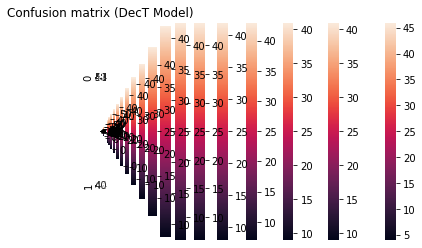

In [20]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    ## Creating and running our optimization

    # Creating and running our optimization

    study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
    with parallel_backend('threading'):
        study_dect.optimize(objective_dect, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_dect.best_trial.number)
    print("Best accuracy:", study_dect.best_trial.value)
    print("Best hyperparameters:", study_dect.best_params)

    best_param_dect = study_dect.best_params
    DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
    y_pred_dect = DecT.predict(x_test)


    display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")


    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(model=DecT, data= None, model_output= 'raw', feature_perturbation= 'tree_path_dependent')
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 0
    shap_values_array = abs(shap_values[:,:,0])

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)


# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

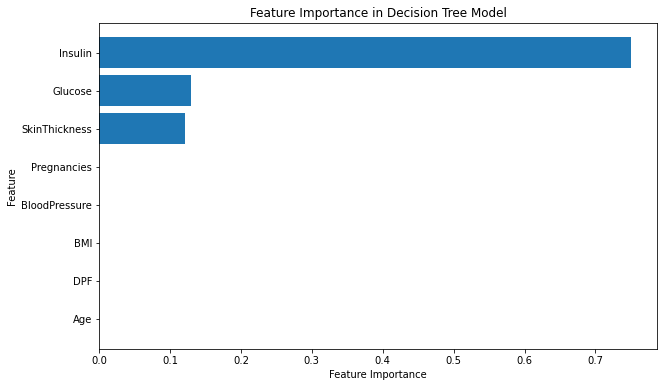

         Feature  Importance
4        Insulin    0.749420
1        Glucose    0.129062
3  SkinThickness    0.121518
0    Pregnancies    0.000000
2  BloodPressure    0.000000
5            BMI    0.000000
6            DPF    0.000000
7            Age    0.000000


In [21]:
# Get feature importances from the decision tree model
feature_importances = DecT.feature_importances_

# Get feature names
feature_names = x_train.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

# Print the DataFrame for detailed view
print(importance_df)

In [22]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [23]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('_dt_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,1.673548,0.769267,3.555884,1.125721,0.307059,1.761343,1.580873,1.358881,1.516572
1,1.682729,0.734817,2.477748,1.212026,0.269341,1.422079,1.886372,1.341614,1.378341
2,1.682729,0.734817,2.477748,1.212026,0.269341,1.422079,1.886372,1.341614,1.378341
3,1.682729,0.737422,2.477748,1.212446,0.262990,1.619240,1.792497,1.340829,1.390738
4,1.702540,0.697221,2.466353,1.186131,0.394663,1.445927,1.873822,1.338961,1.388202
...,...,...,...,...,...,...,...,...,...
95,1.708130,0.697036,2.466353,1.186452,0.386783,1.530067,1.873822,1.330648,1.397411
96,1.682729,0.734817,2.477748,1.212026,0.269341,1.422079,1.886372,1.341614,1.378341
97,1.673548,0.768779,3.555884,1.119619,0.308466,1.761343,1.624012,1.355784,1.520929
98,1.682729,0.737422,2.477748,1.212446,0.262990,1.619240,1.792497,1.340829,1.390738


## 4.5 SVM (Support Vector Machine)

In [24]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [25]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 20:34:40,346] A new study created in memory with name: SVM
[I 2024-08-26 20:34:41,100] Trial 2 finished with value: 0.794926109903401 and parameters: {'C': 7.1355149777604, 'gamma': 0.00012642440632314075}. Best is trial 2 with value: 0.794926109903401.
[I 2024-08-26 20:34:41,118] Trial 5 finished with value: 0.7880486237388372 and parameters: {'C': 0.2762999373227512, 'gamma': 0.00233842554126198}. Best is trial 2 with value: 0.794926109903401.
[I 2024-08-26 20:34:41,199] Trial 1 finished with value: 0.7704616108499284 and parameters: {'C': 0.18288639298821685, 'gamma': 0.001695831269239353}. Best is trial 2 with value: 0.794926109903401.
[I 2024-08-26 20:34:41,279] Trial 4 finished with value: 0.742165613321896 and parameters: {'C': 1.1476109074253706, 'gamma': 0.0001102814515363162}. Best is trial 2 with value: 0.794926109903401.
[I 2024-08-26 20:34:41,285] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.00252360331502096, 'gamma': 0.007110935652

Best trial: 8
Best accuracy: 0.8311194969411914
Best hyperparameters: {'C': 0.18232322337604287, 'gamma': 0.07758584383442288}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 20:35:10,204] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045250  0.187988       0.001774       0.001655  0.090298  0.040726   
1      0.057536  0.143274       0.004774       0.061893  0.162321  0.004036   
2      0.042024  0.122048       0.062190       0.034524  0.177786  0.040167   
3      0.043833  0.142190       0.025429       0.044500  0.162571  0.023452   
4      0.000440  0.110988       0.027488       0.005155  0.171107  0.019893   
..          ...       ...            ...            ...       ...       ...   
95     0.216024  0.192929       0.054024       0.109167  0.013500  0.130238   
96     0.061202  0.103774       0.001488       0.157226  0.114274  0.127155   
97     0.191476  0.307048       0.014167       0.357071  0.049500  0.049333   
98     0.016714  0.194167       0.014857       0.062476  0.261667  0.067952   
99     0.037643  0.178476       0.000667       0.060762  0.326333  0.003333   

         DPF       Age  Outcome  
0   0.026250  0.0

[I 2024-08-26 20:35:10,882] Trial 4 finished with value: 0.816828626806736 and parameters: {'C': 268.1596635001793, 'gamma': 3.465335251649843e-05}. Best is trial 4 with value: 0.816828626806736.
[I 2024-08-26 20:35:10,892] Trial 2 finished with value: 0.8196771703769286 and parameters: {'C': 509.8188422758758, 'gamma': 5.883993466794754e-05}. Best is trial 2 with value: 0.8196771703769286.
[I 2024-08-26 20:35:10,907] Trial 1 finished with value: 0.8111020463944968 and parameters: {'C': 4.865317751276101, 'gamma': 0.1629839240095465}. Best is trial 2 with value: 0.8196771703769286.
[I 2024-08-26 20:35:10,932] Trial 3 finished with value: 0.8233381251585651 and parameters: {'C': 66.413468175752, 'gamma': 0.002409428634987908}. Best is trial 3 with value: 0.8233381251585651.
[I 2024-08-26 20:35:10,943] Trial 0 finished with value: 0.7977274728076493 and parameters: {'C': 13.526519412780443, 'gamma': 0.00014331469520988707}. Best is trial 3 with value: 0.8233381251585651.
[I 2024-08-26 20

Best trial: 9
Best accuracy: 0.829130666788403
Best hyperparameters: {'C': 1.247009302421613, 'gamma': 0.10386971012735763}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 20:35:24,769] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047857  0.158476       0.004333       0.000643  0.156071  0.010405   
1      0.024071  0.130000       0.000000       0.005500  0.147643  0.000738   
2      0.003869  0.133512       0.004798       0.037274  0.300060  0.009274   
3      0.021667  0.119048       0.001619       0.028048  0.287690  0.004262   
4      0.002060  0.060369       0.013631       0.004393  0.263679  0.002988   
..          ...       ...            ...            ...       ...       ...   
95     0.038095  0.023738       0.004643       0.031476  0.259143  0.006833   
96     0.002643  0.097429       0.004786       0.137238  0.128571  0.252714   
97     0.003810  0.549286       0.011667       0.142762  0.141500  0.089095   
98     0.016405  0.041476       0.004190       0.054524  0.382619  0.020333   
99     0.022512  0.139464       0.004060       0.046464  0.269083  0.007869   

         DPF       Age  Outcome  
0   0.012762  0.0

[I 2024-08-26 20:35:25,380] Trial 3 finished with value: 0.8298216013372556 and parameters: {'C': 1.3043073539419832, 'gamma': 0.09947641097634416}. Best is trial 3 with value: 0.8298216013372556.
[I 2024-08-26 20:35:25,554] Trial 1 finished with value: 0.8219384349829305 and parameters: {'C': 291.26505504262894, 'gamma': 0.0009035072750776906}. Best is trial 3 with value: 0.8298216013372556.
[I 2024-08-26 20:35:25,565] Trial 2 finished with value: 0.7957577229267622 and parameters: {'C': 0.18179266197297309, 'gamma': 0.006520683913630195}. Best is trial 3 with value: 0.8298216013372556.
[I 2024-08-26 20:35:25,778] Trial 5 finished with value: 0.7607836228812682 and parameters: {'C': 0.01193894252530478, 'gamma': 0.027956183054206787}. Best is trial 3 with value: 0.8298216013372556.
[I 2024-08-26 20:35:25,784] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.002946418079764953, 'gamma': 0.0028353640417513094}. Best is trial 3 with value: 0.8298216013372556.
[I 202

Best trial: 3
Best accuracy: 0.8298216013372556
Best hyperparameters: {'C': 1.3043073539419832, 'gamma': 0.09947641097634416}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 20:35:40,148] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050679  0.159512       0.001060       0.000702  0.154250  0.011107   
1      0.024536  0.133202       0.000179       0.004798  0.148012  0.001298   
2      0.000679  0.132250       0.001393       0.032726  0.309583  0.011036   
3      0.022774  0.121060       0.001536       0.026821  0.288131  0.006250   
4      0.000452  0.062048       0.013476       0.003214  0.263548  0.000905   
..          ...       ...            ...            ...       ...       ...   
95     0.026345  0.026988       0.005798       0.031583  0.261202  0.007083   
96     0.004440  0.095107       0.003821       0.140488  0.130345  0.250536   
97     0.003774  0.546869       0.009655       0.146060  0.142869  0.089202   
98     0.016726  0.038821       0.006036       0.053036  0.381060  0.019250   
99     0.021655  0.137369       0.004274       0.044679  0.270560  0.005798   

         DPF       Age  Outcome  
0   0.012512  0.0

[I 2024-08-26 20:35:40,842] Trial 4 finished with value: 0.8214869190576098 and parameters: {'C': 12.088810045199107, 'gamma': 0.0014633136954282052}. Best is trial 4 with value: 0.8214869190576098.
[I 2024-08-26 20:35:40,867] Trial 5 finished with value: 0.8226364425009628 and parameters: {'C': 76.6774161105826, 'gamma': 0.00134722798213011}. Best is trial 5 with value: 0.8226364425009628.
[I 2024-08-26 20:35:41,146] Trial 0 finished with value: 0.7898212318588169 and parameters: {'C': 0.2763660957518217, 'gamma': 0.8908719332836429}. Best is trial 5 with value: 0.8226364425009628.
[I 2024-08-26 20:35:41,201] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.6787715135257786, 'gamma': 1.3724170969561736e-05}. Best is trial 5 with value: 0.8226364425009628.
[I 2024-08-26 20:35:41,232] Trial 2 finished with value: 0.3015179297653436 and parameters: {'C': 0.058026043815394814, 'gamma': 0.0011124682818059966}. Best is trial 5 with value: 0.8226364425009628.
[I 2024-08

Best trial: 5
Best accuracy: 0.8226364425009628
Best hyperparameters: {'C': 76.6774161105826, 'gamma': 0.00134722798213011}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 20:35:56,756] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032202  0.195464       0.000369       0.004250  0.089964  0.050464   
1      0.063690  0.160976       0.002333       0.095286  0.144762  0.002452   
2      0.051452  0.151167       0.013119       0.040476  0.189262  0.057452   
3      0.038119  0.160714       0.007071       0.040238  0.142333  0.036667   
4      0.002321  0.116464       0.006774       0.003512  0.156298  0.030940   
..          ...       ...            ...            ...       ...       ...   
95     0.246786  0.231976       0.003810       0.090690  0.019000  0.115500   
96     0.068786  0.125667       0.000571       0.169095  0.116524  0.109048   
97     0.213071  0.333119       0.008738       0.350452  0.008619  0.055381   
98     0.013869  0.242440       0.008107       0.069179  0.199179  0.096964   
99     0.034762  0.204690       0.000476       0.054405  0.304024  0.008000   

         DPF       Age  Outcome  
0   0.037631  0.0

[I 2024-08-26 20:35:57,608] Trial 5 finished with value: 0.818282016483112 and parameters: {'C': 3.132581824523231, 'gamma': 0.003500714825655897}. Best is trial 5 with value: 0.818282016483112.
[I 2024-08-26 20:35:57,786] Trial 3 finished with value: 0.8191799176586779 and parameters: {'C': 0.11863068493973591, 'gamma': 0.24242982596138457}. Best is trial 3 with value: 0.8191799176586779.
[I 2024-08-26 20:35:57,923] Trial 0 finished with value: 0.8230331548713414 and parameters: {'C': 462.76549808451784, 'gamma': 0.000876971631358049}. Best is trial 0 with value: 0.8230331548713414.
[I 2024-08-26 20:35:58,066] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0017374556214484447, 'gamma': 0.003263069611333427}. Best is trial 0 with value: 0.8230331548713414.
[I 2024-08-26 20:35:58,075] Trial 2 finished with value: 0.7697619434012131 and parameters: {'C': 0.068224217465403, 'gamma': 0.00445252347224709}. Best is trial 0 with value: 0.8230331548713414.
[I 2024-08-26

Best trial: 9
Best accuracy: 0.8356841644736089
Best hyperparameters: {'C': 31.806586038797743, 'gamma': 0.029832664864305636}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 20:36:11,582] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.072643  0.164619       0.003167       0.006381  0.161357  0.002810   
1      0.015667  0.135857       0.008500       0.009762  0.169524  0.000595   
2      0.014357  0.103143       0.012857       0.037786  0.438690  0.022405   
3      0.028762  0.111071       0.001786       0.015095  0.301857  0.000238   
4      0.003333  0.050881       0.004357       0.001619  0.324738  0.015976   
..          ...       ...            ...            ...       ...       ...   
95     0.249429  0.090595       0.092810       0.088714  0.034571  0.095405   
96     0.006952  0.115548       0.013357       0.110190  0.180976  0.283143   
97     0.039167  0.573595       0.001000       0.138643  0.120310  0.057571   
98     0.035036  0.017893       0.011798       0.055345  0.395512  0.002369   
99     0.006857  0.140690       0.000667       0.041762  0.306405  0.009429   

         DPF       Age  Outcome  
0   0.003643  0.0

[I 2024-08-26 20:36:12,479] Trial 1 finished with value: 0.8065719196420155 and parameters: {'C': 36.79885490351195, 'gamma': 0.00010816365438773976}. Best is trial 1 with value: 0.8065719196420155.
[I 2024-08-26 20:36:12,567] Trial 4 finished with value: 0.7964748454538596 and parameters: {'C': 195.25162315779082, 'gamma': 0.14966525005170456}. Best is trial 1 with value: 0.8065719196420155.
[I 2024-08-26 20:36:12,598] Trial 0 finished with value: 0.8118216202614519 and parameters: {'C': 0.5729715498818588, 'gamma': 0.46380038113654937}. Best is trial 0 with value: 0.8118216202614519.
[I 2024-08-26 20:36:12,697] Trial 5 finished with value: 0.7737514837249496 and parameters: {'C': 23.5314486353845, 'gamma': 1.4189752559442422e-05}. Best is trial 0 with value: 0.8118216202614519.
[I 2024-08-26 20:36:12,835] Trial 3 finished with value: 0.7726955029331173 and parameters: {'C': 0.04993675665789866, 'gamma': 0.004190596335355589}. Best is trial 0 with value: 0.8118216202614519.
[I 2024-08

Best trial: 9
Best accuracy: 0.8262790886146472
Best hyperparameters: {'C': 0.43337884157457296, 'gamma': 0.02761651098983557}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 20:36:30,035] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038238  0.194524       0.000119       0.000024  0.096929  0.041167   
1      0.062750  0.154488       0.000702       0.078488  0.152679  0.004917   
2      0.049869  0.145845       0.014298       0.035107  0.188798  0.048369   
3      0.046619  0.153286       0.005714       0.041810  0.155833  0.027929   
4      0.004262  0.117405       0.007048       0.001881  0.166881  0.024905   
..          ...       ...            ...            ...       ...       ...   
95     0.250214  0.210452       0.001333       0.108214  0.001167  0.111548   
96     0.072655  0.122179       0.001036       0.167226  0.125369  0.102964   
97     0.217167  0.331452       0.004167       0.342548  0.018381  0.045952   
98     0.022095  0.224071       0.004857       0.065000  0.246214  0.070667   
99     0.036048  0.192476       0.001286       0.050714  0.314238  0.010381   

         DPF       Age  Outcome  
0   0.031500  0.0

[I 2024-08-26 20:36:30,926] Trial 0 finished with value: 0.8302854597860809 and parameters: {'C': 1.2863861579869056, 'gamma': 0.15571738536215854}. Best is trial 0 with value: 0.8302854597860809.
[I 2024-08-26 20:36:30,979] Trial 5 finished with value: 0.8010377841005589 and parameters: {'C': 37.998146888303545, 'gamma': 6.838230321817302e-05}. Best is trial 0 with value: 0.8302854597860809.
[I 2024-08-26 20:36:31,024] Trial 1 finished with value: 0.8197931317411569 and parameters: {'C': 10.756639892467456, 'gamma': 0.0013721704379211013}. Best is trial 0 with value: 0.8302854597860809.
[I 2024-08-26 20:36:31,203] Trial 4 finished with value: 0.7718536477556985 and parameters: {'C': 0.020185190305978234, 'gamma': 0.04886708959256451}. Best is trial 0 with value: 0.8302854597860809.
[I 2024-08-26 20:36:31,347] Trial 2 finished with value: 0.8158112718025822 and parameters: {'C': 142.7518092557215, 'gamma': 0.0059967382728823545}. Best is trial 0 with value: 0.8302854597860809.
[I 2024-

Best trial: 0
Best accuracy: 0.8302854597860809
Best hyperparameters: {'C': 1.2863861579869056, 'gamma': 0.15571738536215854}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 20:36:46,658] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031119  0.148333       0.007857       0.005167  0.213619  0.003667   
1      0.023821  0.120012       0.000393       0.004321  0.149345  0.001607   
2      0.000679  0.113679       0.022202       0.040107  0.303702  0.010631   
3      0.021845  0.115060       0.001155       0.027964  0.285726  0.006512   
4      0.015357  0.055214       0.021643       0.003619  0.307619  0.015095   
..          ...       ...            ...            ...       ...       ...   
95     0.061488  0.013964       0.004298       0.011583  0.246393  0.004155   
96     0.015833  0.104000       0.012119       0.112881  0.119119  0.308143   
97     0.003964  0.574036       0.033250       0.120250  0.115964  0.072107   
98     0.026845  0.029845       0.006131       0.063917  0.412131  0.006774   
99     0.009286  0.163214       0.004690       0.056810  0.241048  0.013619   

         DPF       Age  Outcome  
0   0.010000  0.0

[I 2024-08-26 20:36:47,355] Trial 5 finished with value: 0.8265219264411305 and parameters: {'C': 1.2956000057661838, 'gamma': 0.08263225010686275}. Best is trial 5 with value: 0.8265219264411305.
[I 2024-08-26 20:36:47,485] Trial 4 finished with value: 0.8068108110677075 and parameters: {'C': 0.17762823682702894, 'gamma': 0.016417107871038446}. Best is trial 5 with value: 0.8265219264411305.
[I 2024-08-26 20:36:47,495] Trial 3 finished with value: 0.7967190396350232 and parameters: {'C': 1.6562622615927407, 'gamma': 0.0010586358069816866}. Best is trial 5 with value: 0.8265219264411305.
[I 2024-08-26 20:36:47,600] Trial 0 finished with value: 0.7922384534390325 and parameters: {'C': 253.31356414327857, 'gamma': 0.12798984911036368}. Best is trial 5 with value: 0.8265219264411305.
[I 2024-08-26 20:36:47,674] Trial 2 finished with value: 0.7729036505304299 and parameters: {'C': 0.03516901965798697, 'gamma': 0.014375381820424065}. Best is trial 5 with value: 0.8265219264411305.
[I 2024-0

Best trial: 1
Best accuracy: 0.8290802444415629
Best hyperparameters: {'C': 145.8218285912985, 'gamma': 0.014387703980266975}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 20:37:00,120] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.067190  0.162643       0.002310       0.011786  0.185762  0.005381   
1      0.000667  0.136833       0.006286       0.013976  0.159000  0.000905   
2      0.023940  0.116369       0.028917       0.033655  0.435155  0.022750   
3      0.028345  0.121536       0.004321       0.018321  0.301274  0.000155   
4      0.023024  0.058810       0.009024       0.001810  0.251190  0.006190   
..          ...       ...            ...            ...       ...       ...   
95     0.209321  0.111583       0.117583       0.118583  0.030655  0.086250   
96     0.018405  0.117595       0.004905       0.127119  0.179905  0.269119   
97     0.136607  0.551417       0.018417       0.176679  0.127702  0.055179   
98     0.033369  0.027917       0.011274       0.068726  0.375393  0.003679   
99     0.010464  0.131988       0.005583       0.045893  0.321917  0.002988   

         DPF       Age  Outcome  
0   0.016095  0.0

[I 2024-08-26 20:37:01,165] Trial 5 finished with value: 0.7946362708860377 and parameters: {'C': 327.8582717768474, 'gamma': 0.1423231203050843}. Best is trial 5 with value: 0.7946362708860377.
[I 2024-08-26 20:37:01,181] Trial 3 finished with value: 0.8034903055780299 and parameters: {'C': 0.09241832945268257, 'gamma': 0.020374568027100404}. Best is trial 3 with value: 0.8034903055780299.
[I 2024-08-26 20:37:01,186] Trial 2 finished with value: 0.7967747090213189 and parameters: {'C': 13.474033513085109, 'gamma': 6.996564295834054e-05}. Best is trial 3 with value: 0.8034903055780299.
[I 2024-08-26 20:37:01,221] Trial 0 finished with value: 0.7331954274724498 and parameters: {'C': 0.022182963955381184, 'gamma': 0.1962168255586918}. Best is trial 3 with value: 0.8034903055780299.
[I 2024-08-26 20:37:01,374] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.019401837420530827, 'gamma': 3.902429858015145e-05}. Best is trial 3 with value: 0.8034903055780299.
[I 2024-0

Best trial: 7
Best accuracy: 0.8272344151346627
Best hyperparameters: {'C': 182.37782193955712, 'gamma': 0.001845045209559597}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 20:37:17,150] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041726  0.186631       0.002560       0.002798  0.114512  0.045321   
1      0.043274  0.154131       0.001155       0.065893  0.154179  0.000798   
2      0.041786  0.149310       0.009095       0.035738  0.216071  0.049833   
3      0.040679  0.152036       0.002274       0.038131  0.182655  0.029083   
4      0.006655  0.108774       0.001774       0.003060  0.186202  0.021845   
..          ...       ...            ...            ...       ...       ...   
95     0.081393  0.037798       0.151298       0.000774  0.186726  0.015321   
96     0.054917  0.110750       0.001393       0.168655  0.140940  0.124060   
97     0.176917  0.319393       0.007726       0.358107  0.026440  0.057012   
98     0.015679  0.179607       0.004321       0.058940  0.260226  0.062321   
99     0.027881  0.159738       0.002238       0.043071  0.333143  0.007976   

         DPF       Age  Outcome  
0   0.037036  0.0

[I 2024-08-26 20:37:17,997] Trial 0 finished with value: 0.794648167002876 and parameters: {'C': 5.099905069523125, 'gamma': 0.00020519316507700922}. Best is trial 0 with value: 0.794648167002876.
[I 2024-08-26 20:37:18,038] Trial 1 finished with value: 0.7964966517069686 and parameters: {'C': 360.9541446966559, 'gamma': 0.14827584221663462}. Best is trial 1 with value: 0.7964966517069686.
[I 2024-08-26 20:37:18,275] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 3.229678480280875, 'gamma': 1.530907204471407e-05}. Best is trial 1 with value: 0.7964966517069686.
[I 2024-08-26 20:37:18,286] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.00782242510675848, 'gamma': 8.950816251285837e-05}. Best is trial 1 with value: 0.7964966517069686.
[I 2024-08-26 20:37:18,324] Trial 5 finished with value: 0.35081172359783735 and parameters: {'C': 0.03851797071555598, 'gamma': 0.9599693537838475}. Best is trial 1 with value: 0.7964966517069686.
[I 2024-08-26

Best trial: 4
Best accuracy: 0.8310220699295066
Best hyperparameters: {'C': 446.17041896019646, 'gamma': 0.013429777684851617}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 20:37:32,258] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.077679  0.164464       0.009321       0.001440  0.152655  0.008131   
1      0.019298  0.126655       0.010179       0.022012  0.154393  0.003417   
2      0.016143  0.081857       0.020238       0.033024  0.465952  0.021143   
3      0.025821  0.120750       0.003131       0.014321  0.309298  0.003488   
4      0.016000  0.043143       0.027929       0.001048  0.358595  0.008833   
..          ...       ...            ...            ...       ...       ...   
95     0.274619  0.027976       0.148024       0.101000  0.044929  0.070881   
96     0.031381  0.429952       0.058619       0.014952  0.012595  0.067095   
97     0.027667  0.642119       0.004881       0.137143  0.092429  0.036905   
98     0.032702  0.006179       0.021869       0.067274  0.398250  0.009012   
99     0.028821  0.163036       0.007107       0.039536  0.298821  0.008655   

         DPF       Age  Outcome  
0   0.009321  0.0

[I 2024-08-26 20:37:33,165] Trial 4 finished with value: 0.8225386751770487 and parameters: {'C': 63.371889424285506, 'gamma': 0.0006335381244732411}. Best is trial 4 with value: 0.8225386751770487.
[I 2024-08-26 20:37:33,180] Trial 5 finished with value: 0.8224891627203869 and parameters: {'C': 34.035785042608566, 'gamma': 0.0012418184420413948}. Best is trial 4 with value: 0.8225386751770487.
[I 2024-08-26 20:37:33,529] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.009097671303873853, 'gamma': 0.005055897236299204}. Best is trial 4 with value: 0.8225386751770487.
[I 2024-08-26 20:37:33,593] Trial 3 finished with value: 0.7729857883163871 and parameters: {'C': 1.039598991173693, 'gamma': 0.0001677900354601515}. Best is trial 4 with value: 0.8225386751770487.
[I 2024-08-26 20:37:33,635] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.001036309652809506, 'gamma': 0.0025548560415072775}. Best is trial 4 with value: 0.8225386751770487.
[I 20

Best trial: 6
Best accuracy: 0.8259531181591957
Best hyperparameters: {'C': 0.44391352801186235, 'gamma': 0.02806721372438549}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 20:37:50,726] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039083  0.194179       0.000631       0.000250  0.097655  0.040131   
1      0.062833  0.155571       0.001905       0.079238  0.152143  0.005548   
2      0.050655  0.146298       0.014274       0.034940  0.189274  0.048726   
3      0.045893  0.153702       0.005179       0.041893  0.157202  0.027321   
4      0.004321  0.117893       0.006345       0.002345  0.167107  0.024869   
..          ...       ...            ...            ...       ...       ...   
95     0.241690  0.210190       0.001143       0.108952  0.002976  0.114619   
96     0.072298  0.123202       0.000869       0.168274  0.124012  0.104750   
97     0.215976  0.332095       0.005881       0.343476  0.017714  0.045071   
98     0.021155  0.220917       0.005179       0.064655  0.247583  0.068560   
99     0.036202  0.191298       0.001250       0.050583  0.313298  0.009179   

         DPF       Age  Outcome  
0   0.032345  0.0

[I 2024-08-26 20:37:51,553] Trial 5 finished with value: 0.8010219409849358 and parameters: {'C': 9.09561457188664, 'gamma': 0.150876028724007}. Best is trial 5 with value: 0.8010219409849358.
[I 2024-08-26 20:37:51,841] Trial 4 finished with value: 0.7717175339402524 and parameters: {'C': 0.07793250708538155, 'gamma': 0.0032878661343757813}. Best is trial 5 with value: 0.8010219409849358.
[I 2024-08-26 20:37:51,851] Trial 3 finished with value: 0.7669842352340553 and parameters: {'C': 0.014699661306795977, 'gamma': 0.02113282378281243}. Best is trial 5 with value: 0.8010219409849358.
[I 2024-08-26 20:37:51,898] Trial 0 finished with value: 0.7250634218258897 and parameters: {'C': 10.416827698933654, 'gamma': 0.8802613516248462}. Best is trial 5 with value: 0.8010219409849358.
[I 2024-08-26 20:37:51,910] Trial 1 finished with value: 0.6801456180236903 and parameters: {'C': 0.013667244537922821, 'gamma': 0.2895983301899017}. Best is trial 5 with value: 0.8010219409849358.
[I 2024-08-26 

Best trial: 7
Best accuracy: 0.8194083426801746
Best hyperparameters: {'C': 13.425948589898168, 'gamma': 0.08327206486046887}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 20:38:04,803] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048869  0.179083       0.013298       0.002393  0.145607  0.001964   
1      0.001250  0.141964       0.007274       0.031798  0.149202  0.003869   
2      0.015845  0.063536       0.016155       0.026393  0.403583  0.006679   
3      0.014202  0.131202       0.011155       0.011393  0.277845  0.009036   
4      0.008488  0.049560       0.001631       0.002655  0.355179  0.017036   
..          ...       ...            ...            ...       ...       ...   
95     0.248964  0.101964       0.005321       0.115083  0.057274  0.088536   
96     0.084476  0.469119       0.076071       0.012881  0.029833  0.078310   
97     0.020250  0.626060       0.011940       0.094321  0.096726  0.025988   
98     0.027845  0.025345       0.008060       0.063298  0.417512  0.003440   
99     0.053143  0.424571       0.004690       0.046571  0.146643  0.025762   

         DPF       Age  Outcome  
0   0.017560  0.0

[I 2024-08-26 20:38:05,546] Trial 4 finished with value: 0.8256633255378651 and parameters: {'C': 2.835689520212013, 'gamma': 0.04399652437389604}. Best is trial 4 with value: 0.8256633255378651.
[I 2024-08-26 20:38:05,583] Trial 2 finished with value: 0.8092345195312184 and parameters: {'C': 454.03702679231645, 'gamma': 1.4413925977552775e-05}. Best is trial 4 with value: 0.8256633255378651.
[I 2024-08-26 20:38:05,652] Trial 3 finished with value: 0.8024918278365223 and parameters: {'C': 0.21316391995535097, 'gamma': 0.01179680416473438}. Best is trial 4 with value: 0.8256633255378651.
[I 2024-08-26 20:38:05,732] Trial 1 finished with value: 0.8145917601657068 and parameters: {'C': 0.6375614785764624, 'gamma': 0.4259624596805868}. Best is trial 4 with value: 0.8256633255378651.
[I 2024-08-26 20:38:05,949] Trial 0 finished with value: 0.6955157850313788 and parameters: {'C': 0.02174641191495272, 'gamma': 0.276141811816659}. Best is trial 4 with value: 0.8256633255378651.
[I 2024-08-26 

Best trial: 4
Best accuracy: 0.8256633255378651
Best hyperparameters: {'C': 2.835689520212013, 'gamma': 0.04399652437389604}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 20:38:19,382] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042524  0.166024       0.002976       0.007952  0.131429  0.019000   
1      0.009619  0.146976       0.000190       0.020238  0.147238  0.001286   
2      0.000643  0.126452       0.008000       0.033881  0.321238  0.018476   
3      0.016321  0.129155       0.014798       0.037607  0.280964  0.007440   
4      0.002750  0.067274       0.004869       0.009083  0.237821  0.002607   
..          ...       ...            ...            ...       ...       ...   
95     0.034250  0.023655       0.017179       0.036512  0.269940  0.017512   
96     0.009179  0.098179       0.004274       0.159488  0.130988  0.188940   
97     0.015940  0.499464       0.002298       0.200774  0.244345  0.058845   
98     0.003857  0.051619       0.005619       0.062000  0.362976  0.028143   
99     0.023940  0.135917       0.005179       0.048393  0.309321  0.000036   

         DPF       Age  Outcome  
0   0.016667  0.0

[I 2024-08-26 20:38:20,101] Trial 0 finished with value: 0.8075207926025082 and parameters: {'C': 9.496759598926378, 'gamma': 0.0006566795103490323}. Best is trial 0 with value: 0.8075207926025082.
[I 2024-08-26 20:38:20,211] Trial 3 finished with value: 0.8214757147327272 and parameters: {'C': 846.6525435906599, 'gamma': 0.000296744355417152}. Best is trial 3 with value: 0.8214757147327272.
[I 2024-08-26 20:38:20,366] Trial 2 finished with value: 0.7788870731913873 and parameters: {'C': 1.1332507638843834, 'gamma': 0.0004088458415163051}. Best is trial 3 with value: 0.8214757147327272.
[I 2024-08-26 20:38:20,512] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.011665365164104676, 'gamma': 0.0007492956518629949}. Best is trial 3 with value: 0.8214757147327272.
[I 2024-08-26 20:38:20,519] Trial 1 finished with value: 0.7835372424875124 and parameters: {'C': 92.66135619457403, 'gamma': 0.6023341306171756}. Best is trial 3 with value: 0.8214757147327272.
[I 2024-08-

Best trial: 3
Best accuracy: 0.8214757147327272
Best hyperparameters: {'C': 846.6525435906599, 'gamma': 0.000296744355417152}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 20:38:35,282] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029762  0.190619       0.000905       0.004643  0.091048  0.048071   
1      0.070226  0.162607       0.000988       0.110750  0.146274  0.005012   
2      0.051869  0.150393       0.008631       0.043012  0.191060  0.059845   
3      0.038298  0.161417       0.002869       0.042679  0.140845  0.039226   
4      0.000048  0.114619       0.003786       0.001119  0.167619  0.027286   
..          ...       ...            ...            ...       ...       ...   
95     0.258190  0.237024       0.002452       0.088571  0.012381  0.103619   
96     0.065976  0.127500       0.000357       0.171262  0.118500  0.104595   
97     0.214833  0.348333       0.005500       0.339643  0.021929  0.054595   
98     0.017476  0.241119       0.003571       0.067786  0.230024  0.094881   
99     0.033869  0.205988       0.000607       0.056702  0.307702  0.002917   

         DPF       Age  Outcome  
0   0.035690  0.0

[I 2024-08-26 20:38:35,972] Trial 5 finished with value: 0.8315018156039329 and parameters: {'C': 1.6321801650821601, 'gamma': 0.027250278719449777}. Best is trial 5 with value: 0.8315018156039329.
[I 2024-08-26 20:38:35,996] Trial 3 finished with value: 0.8198183815872363 and parameters: {'C': 8.850930431015849, 'gamma': 0.0017278516275038985}. Best is trial 5 with value: 0.8315018156039329.
[I 2024-08-26 20:38:36,030] Trial 2 finished with value: 0.8184496379931343 and parameters: {'C': 108.77425608999714, 'gamma': 0.0001724831893364862}. Best is trial 5 with value: 0.8315018156039329.
[I 2024-08-26 20:38:36,101] Trial 4 finished with value: 0.8213194775087864 and parameters: {'C': 0.11975667708958838, 'gamma': 0.21410998493508246}. Best is trial 5 with value: 0.8315018156039329.
[I 2024-08-26 20:38:36,363] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.004474133694737435, 'gamma': 1.4763564871708183e-05}. Best is trial 5 with value: 0.8315018156039329.
[I 202

Best trial: 5
Best accuracy: 0.8315018156039329
Best hyperparameters: {'C': 1.6321801650821601, 'gamma': 0.027250278719449777}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 20:38:50,949] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039845  0.175083       0.000821       0.005036  0.135917  0.031440   
1      0.036083  0.146631       0.003393       0.057226  0.176869  0.004345   
2      0.030202  0.148845       0.017345       0.035440  0.224607  0.046917   
3      0.035738  0.137381       0.003643       0.038929  0.204571  0.020262   
4      0.002262  0.096833       0.010833       0.003738  0.209690  0.013976   
..          ...       ...            ...            ...       ...       ...   
95     0.027048  0.010524       0.012119       0.006524  0.225643  0.007976   
96     0.038381  0.102310       0.002048       0.165929  0.151643  0.126667   
97     0.169869  0.327440       0.006774       0.350345  0.066321  0.074250   
98     0.007345  0.126964       0.005988       0.059321  0.304845  0.046583   
99     0.027905  0.150976       0.000238       0.045476  0.341619  0.007405   

         DPF       Age  Outcome  
0   0.030940  0.0

[I 2024-08-26 20:38:51,734] Trial 0 finished with value: 0.8270188824847527 and parameters: {'C': 43.62623860563119, 'gamma': 0.003988776630950444}. Best is trial 0 with value: 0.8270188824847527.
[I 2024-08-26 20:38:51,777] Trial 1 finished with value: 0.8104597833360947 and parameters: {'C': 0.05368222001923448, 'gamma': 0.06979529427784184}. Best is trial 0 with value: 0.8270188824847527.
[I 2024-08-26 20:38:51,841] Trial 2 finished with value: 0.8351293539026001 and parameters: {'C': 20.962240261770745, 'gamma': 0.034325652663787336}. Best is trial 2 with value: 0.8351293539026001.
[I 2024-08-26 20:38:52,100] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.005990793924510698, 'gamma': 0.0005125186647112261}. Best is trial 2 with value: 0.8351293539026001.
[I 2024-08-26 20:38:52,135] Trial 5 finished with value: 0.41084453859860487 and parameters: {'C': 0.395185988084122, 'gamma': 0.00020309694427248306}. Best is trial 2 with value: 0.8351293539026001.
[I 2024

Best trial: 2
Best accuracy: 0.8351293539026001
Best hyperparameters: {'C': 20.962240261770745, 'gamma': 0.034325652663787336}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 20:39:05,050] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.069643  0.162381       0.000524       0.003452  0.168857  0.004095   
1      0.016429  0.139714       0.004548       0.004500  0.172500  0.003000   
2      0.007429  0.093976       0.004548       0.029595  0.392452  0.013905   
3      0.028024  0.110286       0.002024       0.016024  0.305548  0.001952   
4      0.001083  0.049702       0.002036       0.002012  0.324750  0.016274   
..          ...       ...            ...            ...       ...       ...   
95     0.244714  0.101429       0.090333       0.095310  0.042310  0.099714   
96     0.014655  0.109631       0.017226       0.114845  0.178893  0.282417   
97     0.039881  0.569476       0.005143       0.141619  0.122048  0.062643   
98     0.034726  0.020512       0.007679       0.056440  0.395060  0.006536   
99     0.001810  0.136619       0.001667       0.043024  0.318095  0.010905   

         DPF       Age  Outcome  
0   0.000881  0.0

[I 2024-08-26 20:39:05,810] Trial 5 finished with value: 0.8316980073066945 and parameters: {'C': 1.0522692400405664, 'gamma': 0.025578298613004726}. Best is trial 5 with value: 0.8316980073066945.
[I 2024-08-26 20:39:05,835] Trial 1 finished with value: 0.8174960784706375 and parameters: {'C': 4.6325019298897185, 'gamma': 0.001736429526789463}. Best is trial 5 with value: 0.8316980073066945.
[I 2024-08-26 20:39:06,013] Trial 3 finished with value: 0.7994557778866285 and parameters: {'C': 0.12869962330124815, 'gamma': 0.013184631803514854}. Best is trial 5 with value: 0.8316980073066945.
[I 2024-08-26 20:39:06,224] Trial 2 finished with value: 0.8152415876713641 and parameters: {'C': 286.4592590363931, 'gamma': 0.002525707925054129}. Best is trial 5 with value: 0.8316980073066945.
[I 2024-08-26 20:39:06,302] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.020622999781104327, 'gamma': 0.001464358853075158}. Best is trial 5 with value: 0.8316980073066945.
[I 2024-0

Best trial: 5
Best accuracy: 0.8316980073066945
Best hyperparameters: {'C': 1.0522692400405664, 'gamma': 0.025578298613004726}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 20:39:21,757] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044012  0.192131       0.001012       0.004321  0.114798  0.045536   
1      0.052893  0.154607       0.001631       0.070869  0.169893  0.001988   
2      0.045810  0.153071       0.018381       0.036667  0.212857  0.046619   
3      0.044774  0.151012       0.005774       0.039512  0.180536  0.029298   
4      0.006869  0.112583       0.007560       0.004607  0.186726  0.022393   
..          ...       ...            ...            ...       ...       ...   
95     0.191405  0.190595       0.012952       0.112810  0.032310  0.138333   
96     0.057310  0.115881       0.001143       0.178738  0.134881  0.125690   
97     0.192250  0.344226       0.004202       0.339655  0.000012  0.071393   
98     0.016560  0.181369       0.002940       0.059964  0.260440  0.062250   
99     0.027929  0.170119       0.000571       0.045619  0.318667  0.007143   

         DPF       Age  Outcome  
0   0.033083  0.0

[I 2024-08-26 20:39:22,431] Trial 4 finished with value: 0.8325467395554672 and parameters: {'C': 0.7984028732308154, 'gamma': 0.03059243620298507}. Best is trial 4 with value: 0.8325467395554672.
[I 2024-08-26 20:39:22,469] Trial 1 finished with value: 0.821128911458732 and parameters: {'C': 147.5540670598149, 'gamma': 0.00059440325489556}. Best is trial 4 with value: 0.8325467395554672.
[I 2024-08-26 20:39:22,491] Trial 5 finished with value: 0.800237461301923 and parameters: {'C': 161.68686745349373, 'gamma': 0.18719692089375697}. Best is trial 4 with value: 0.8325467395554672.
[I 2024-08-26 20:39:22,589] Trial 3 finished with value: 0.7944095161823512 and parameters: {'C': 0.05596586656571976, 'gamma': 0.017078877277015653}. Best is trial 4 with value: 0.8325467395554672.
[I 2024-08-26 20:39:22,767] Trial 0 finished with value: 0.8014217417010632 and parameters: {'C': 24.15097051480757, 'gamma': 0.49046886651998184}. Best is trial 4 with value: 0.8325467395554672.
[I 2024-08-26 20:

Best trial: 4
Best accuracy: 0.8325467395554672
Best hyperparameters: {'C': 0.7984028732308154, 'gamma': 0.03059243620298507}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 20:39:37,929] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045238  0.189429       0.001214       0.004833  0.116000  0.044405   
1      0.052417  0.153155       0.002655       0.073560  0.175821  0.000607   
2      0.045750  0.152774       0.018488       0.038869  0.217964  0.046726   
3      0.045726  0.148345       0.005488       0.040560  0.185202  0.028917   
4      0.007262  0.109810       0.007500       0.005452  0.190024  0.021071   
..          ...       ...            ...            ...       ...       ...   
95     0.189845  0.187440       0.011607       0.111060  0.037226  0.142988   
96     0.056083  0.112107       0.001369       0.180393  0.134393  0.123512   
97     0.188476  0.330071       0.003905       0.352048  0.034833  0.068595   
98     0.017024  0.175762       0.004976       0.063667  0.266762  0.059095   
99     0.029107  0.164702       0.000940       0.047988  0.320940  0.007274   

         DPF       Age  Outcome  
0   0.032119  0.0

[I 2024-08-26 20:39:38,634] Trial 1 finished with value: 0.8150213548758345 and parameters: {'C': 6.479150408155549, 'gamma': 0.001187203540974357}. Best is trial 1 with value: 0.8150213548758345.
[I 2024-08-26 20:39:38,639] Trial 2 finished with value: 0.8150213548758345 and parameters: {'C': 7.181162575882895, 'gamma': 0.001075021132529689}. Best is trial 1 with value: 0.8150213548758345.
[I 2024-08-26 20:39:38,682] Trial 4 finished with value: 0.8035445622603068 and parameters: {'C': 0.6291545575226375, 'gamma': 0.004739710217576034}. Best is trial 1 with value: 0.8150213548758345.
[I 2024-08-26 20:39:38,712] Trial 0 finished with value: 0.8072110642847058 and parameters: {'C': 32.393548301031984, 'gamma': 0.19310008508174187}. Best is trial 1 with value: 0.8150213548758345.
[I 2024-08-26 20:39:39,046] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.009127581803110666, 'gamma': 0.5577436563649083}. Best is trial 1 with value: 0.8150213548758345.
[I 2024-08-26 

Best trial: 6
Best accuracy: 0.8203884795070112
Best hyperparameters: {'C': 8.240855665065524, 'gamma': 0.0021464683073994816}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 20:39:55,274] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031179  0.200536       0.001917       0.003202  0.092607  0.043179   
1      0.062786  0.172714       0.002429       0.098381  0.145810  0.000190   
2      0.049440  0.154940       0.013702       0.035988  0.183155  0.054274   
3      0.035226  0.169583       0.009155       0.036179  0.138869  0.035440   
4      0.001988  0.121845       0.009060       0.004417  0.152440  0.030488   
..          ...       ...            ...            ...       ...       ...   
95     0.257857  0.243738       0.014286       0.084262  0.013405  0.085571   
96     0.071369  0.133845       0.000583       0.166560  0.126774  0.102964   
97     0.093012  0.521464       0.068250       0.167083  0.130060  0.051917   
98     0.022417  0.261083       0.007464       0.056583  0.228583  0.080464   
99     0.031167  0.222548       0.001452       0.049476  0.301310  0.008310   

         DPF       Age  Outcome  
0   0.031012  0.0

[I 2024-08-26 20:39:56,185] Trial 2 finished with value: 0.7993671534575337 and parameters: {'C': 0.177009834264784, 'gamma': 0.011048269598866196}. Best is trial 2 with value: 0.7993671534575337.
[I 2024-08-26 20:39:56,350] Trial 4 finished with value: 0.7825863463838081 and parameters: {'C': 0.052144673926699796, 'gamma': 0.23973910042294103}. Best is trial 2 with value: 0.7993671534575337.
[I 2024-08-26 20:39:56,384] Trial 5 finished with value: 0.7738107603503392 and parameters: {'C': 0.2569634332552534, 'gamma': 0.0012661707417510291}. Best is trial 2 with value: 0.7993671534575337.
[I 2024-08-26 20:39:56,442] Trial 1 finished with value: 0.7733412426409859 and parameters: {'C': 4.578488439737084, 'gamma': 7.936669150871311e-05}. Best is trial 2 with value: 0.7993671534575337.
[I 2024-08-26 20:39:56,450] Trial 0 finished with value: 0.7734651854193273 and parameters: {'C': 0.3479975423547547, 'gamma': 0.0005304405384754352}. Best is trial 2 with value: 0.7993671534575337.
[I 2024-

Best trial: 3
Best accuracy: 0.8303247252387248
Best hyperparameters: {'C': 459.8847028783055, 'gamma': 0.00919655748274693}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 20:40:09,000] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.067643  0.160000       0.001667       0.009476  0.190690  0.006714   
1      0.000690  0.130667       0.002786       0.018881  0.159071  0.002262   
2      0.026464  0.118036       0.032750       0.033488  0.443369  0.024274   
3      0.026595  0.116000       0.005024       0.018048  0.315452  0.000262   
4      0.024762  0.053738       0.008119       0.000667  0.246619  0.003690   
..          ...       ...            ...            ...       ...       ...   
95     0.207976  0.117048       0.118524       0.120262  0.035833  0.092952   
96     0.021417  0.120060       0.000345       0.130345  0.179250  0.261536   
97     0.143976  0.554095       0.016476       0.180714  0.132095  0.045810   
98     0.031667  0.021548       0.009976       0.067619  0.370643  0.000976   
99     0.013762  0.127167       0.000714       0.041643  0.325333  0.002452   

         DPF       Age  Outcome  
0   0.016190  0.0

[I 2024-08-26 20:40:09,781] Trial 3 finished with value: 0.821800765367946 and parameters: {'C': 62.32621765459007, 'gamma': 0.0013694427442277155}. Best is trial 3 with value: 0.821800765367946.
[I 2024-08-26 20:40:09,917] Trial 5 finished with value: 0.787726871656483 and parameters: {'C': 6.211717064337032, 'gamma': 9.846722878058851e-05}. Best is trial 3 with value: 0.821800765367946.
[I 2024-08-26 20:40:10,065] Trial 0 finished with value: 0.7757600835291641 and parameters: {'C': 14.850906367206663, 'gamma': 0.6512532069335992}. Best is trial 3 with value: 0.821800765367946.
[I 2024-08-26 20:40:10,100] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.021351811275276134, 'gamma': 2.246369837480099e-05}. Best is trial 3 with value: 0.821800765367946.
[I 2024-08-26 20:40:10,110] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.002865039558844799, 'gamma': 0.010767038183942139}. Best is trial 3 with value: 0.821800765367946.
[I 2024-08-26 20

Best trial: 1
Best accuracy: 0.8290492908116711
Best hyperparameters: {'C': 521.5490542884966, 'gamma': 0.008157562783019916}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 20:40:22,979] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065988  0.161393       0.001583       0.011607  0.186845  0.005821   
1      0.002524  0.132429       0.002952       0.015690  0.157429  0.000762   
2      0.023571  0.125000       0.020167       0.026095  0.391238  0.014762   
3      0.024107  0.117964       0.006702       0.019083  0.314179  0.002107   
4      0.023179  0.051583       0.007036       0.003250  0.241131  0.001940   
..          ...       ...            ...            ...       ...       ...   
95     0.194643  0.128524       0.134095       0.119976  0.044857  0.105143   
96     0.023595  0.117143       0.000833       0.133667  0.182238  0.249571   
97     0.160107  0.545560       0.024893       0.182298  0.144821  0.050583   
98     0.031202  0.025679       0.010345       0.068512  0.371083  0.001512   
99     0.012524  0.127524       0.003000       0.040619  0.324643  0.002500   

         DPF       Age  Outcome  
0   0.021393  0.0

[I 2024-08-26 20:40:23,686] Trial 4 finished with value: 0.8092309593357705 and parameters: {'C': 27.80191360860958, 'gamma': 0.00023429081706881347}. Best is trial 4 with value: 0.8092309593357705.
[I 2024-08-26 20:40:23,778] Trial 3 finished with value: 0.7955375537664554 and parameters: {'C': 493.3635102034763, 'gamma': 0.16798608981769897}. Best is trial 4 with value: 0.8092309593357705.
[I 2024-08-26 20:40:23,910] Trial 2 finished with value: 0.7788378607863039 and parameters: {'C': 0.05264130087656749, 'gamma': 0.2567127223116701}. Best is trial 4 with value: 0.8092309593357705.
[I 2024-08-26 20:40:23,926] Trial 5 finished with value: 0.8226172806847198 and parameters: {'C': 29.341463087158328, 'gamma': 0.05823580179676557}. Best is trial 5 with value: 0.8226172806847198.
[I 2024-08-26 20:40:24,062] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.14461481606933493, 'gamma': 3.2782214107200535e-05}. Best is trial 5 with value: 0.8226172806847198.
[I 2024-08-

Best trial: 9
Best accuracy: 0.8228151828388163
Best hyperparameters: {'C': 283.8508015064354, 'gamma': 0.0002563056977918736}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 20:40:38,825] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030488  0.193012       0.001298       0.003512  0.094750  0.044940   
1      0.067619  0.163833       0.001024       0.112976  0.149786  0.002810   
2      0.050155  0.148440       0.007536       0.040798  0.191464  0.058464   
3      0.036429  0.160952       0.006310       0.040286  0.141452  0.037048   
4      0.001179  0.114298       0.004774       0.002036  0.168107  0.026631   
..          ...       ...            ...            ...       ...       ...   
95     0.263262  0.238024       0.010452       0.086381  0.013595  0.092619   
96     0.065476  0.127595       0.000190       0.168167  0.126310  0.096119   
97     0.225131  0.365607       0.006226       0.319750  0.013631  0.074393   
98     0.020452  0.246381       0.003952       0.062929  0.233214  0.093667   
99     0.031333  0.210786       0.000381       0.052357  0.311500  0.006048   

         DPF       Age  Outcome  
0   0.036560  0.0

[I 2024-08-26 20:40:39,543] Trial 2 finished with value: 0.8216416872808638 and parameters: {'C': 2.5541531084695435, 'gamma': 0.008859593293040011}. Best is trial 2 with value: 0.8216416872808638.
[I 2024-08-26 20:40:39,603] Trial 1 finished with value: 0.8224969854667957 and parameters: {'C': 447.52920666762384, 'gamma': 0.00014667506768178173}. Best is trial 1 with value: 0.8224969854667957.
[I 2024-08-26 20:40:39,630] Trial 4 finished with value: 0.8045185059654805 and parameters: {'C': 0.34055716084364335, 'gamma': 0.008986714670233221}. Best is trial 1 with value: 0.8224969854667957.
[I 2024-08-26 20:40:39,762] Trial 3 finished with value: 0.7839981107314833 and parameters: {'C': 6.770534541723307, 'gamma': 8.153476827611243e-05}. Best is trial 1 with value: 0.8224969854667957.
[I 2024-08-26 20:40:39,776] Trial 0 finished with value: 0.8151504421681304 and parameters: {'C': 146.8839517525201, 'gamma': 0.004018806203474349}. Best is trial 1 with value: 0.8224969854667957.
[I 2024-

Best trial: 1
Best accuracy: 0.8224969854667957
Best hyperparameters: {'C': 447.52920666762384, 'gamma': 0.00014667506768178173}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 20:40:54,356] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030512  0.193345       0.002488       0.005060  0.097679  0.045869   
1      0.069393  0.164202       0.001560       0.105702  0.152631  0.003131   
2      0.051631  0.147940       0.010488       0.037583  0.194107  0.058512   
3      0.036583  0.161202       0.008536       0.037655  0.145083  0.037631   
4      0.000845  0.114679       0.006893       0.003774  0.169512  0.029417   
..          ...       ...            ...            ...       ...       ...   
95     0.263405  0.236119       0.015762       0.083881  0.017524  0.088024   
96     0.067167  0.124571       0.001690       0.159381  0.130429  0.100071   
97     0.094155  0.509964       0.087964       0.172536  0.127060  0.046821   
98     0.021583  0.244250       0.006012       0.056321  0.233631  0.092607   
99     0.031167  0.209500       0.001881       0.048762  0.314000  0.008714   

         DPF       Age  Outcome  
0   0.034750  0.0

[I 2024-08-26 20:40:55,068] Trial 3 finished with value: 0.8068898396580518 and parameters: {'C': 3.013832823018082, 'gamma': 0.0018293335010313102}. Best is trial 3 with value: 0.8068898396580518.
[I 2024-08-26 20:40:55,257] Trial 5 finished with value: 0.8241524631524025 and parameters: {'C': 40.475441978320134, 'gamma': 0.012117387943170889}. Best is trial 5 with value: 0.8241524631524025.
[I 2024-08-26 20:40:55,465] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.019984466174346623, 'gamma': 0.00010425562760366272}. Best is trial 5 with value: 0.8241524631524025.
[I 2024-08-26 20:40:55,499] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0010790639052431954, 'gamma': 0.0002861285785638099}. Best is trial 5 with value: 0.8241524631524025.
[I 2024-08-26 20:40:55,510] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.006035162535458734, 'gamma': 0.0032205302542787384}. Best is trial 5 with value: 0.8241524631524025.
[I

Best trial: 8
Best accuracy: 0.8294356387340036
Best hyperparameters: {'C': 24.84402336737988, 'gamma': 0.05345027158899526}
              precision    recall  f1-score   support

           0       0.85      0.94      0.90        50
           1       0.93      0.84      0.88        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



[I 2024-08-26 20:41:07,988] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.054560  0.183250       0.006536       0.002726  0.157107  0.007345   
1      0.000810  0.150714       0.008357       0.040357  0.147619  0.003452   
2      0.014452  0.071714       0.000619       0.023548  0.443548  0.011786   
3      0.021357  0.132643       0.016667       0.009095  0.281048  0.007310   
4      0.014571  0.050762       0.007167       0.004333  0.364095  0.009262   
..          ...       ...            ...            ...       ...       ...   
95     0.240179  0.064464       0.033917       0.097869  0.053607  0.085607   
96     0.107357  0.433429       0.080357       0.036119  0.037048  0.097333   
97     0.017310  0.624500       0.003905       0.095929  0.091976  0.028167   
98     0.026857  0.019810       0.012929       0.043952  0.420786  0.004357   
99     0.065250  0.372774       0.003560       0.042369  0.192798  0.028060   

         DPF       Age  Outcome  
0   0.013464  0.0

[I 2024-08-26 20:41:08,915] Trial 4 finished with value: 0.7954506347982366 and parameters: {'C': 0.5491803754617619, 'gamma': 0.0021616696198569767}. Best is trial 4 with value: 0.7954506347982366.
[I 2024-08-26 20:41:09,027] Trial 5 finished with value: 0.8063636257555242 and parameters: {'C': 29.014612710593134, 'gamma': 0.07791044885165518}. Best is trial 5 with value: 0.8063636257555242.
[I 2024-08-26 20:41:09,104] Trial 1 finished with value: 0.7215205611938492 and parameters: {'C': 0.04014715678916527, 'gamma': 0.3180109382878856}. Best is trial 5 with value: 0.8063636257555242.
[I 2024-08-26 20:41:09,243] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.15259817382416482, 'gamma': 0.00018060151248009809}. Best is trial 5 with value: 0.8063636257555242.
[I 2024-08-26 20:41:09,260] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.004593178197759884, 'gamma': 2.5070204876240534e-05}. Best is trial 5 with value: 0.8063636257555242.
[I 202

Best trial: 7
Best accuracy: 0.8218328489961884
Best hyperparameters: {'C': 704.6673693912513, 'gamma': 0.00015700158179312245}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 20:41:24,219] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030393  0.192440       0.000988       0.003560  0.095083  0.045464   
1      0.067464  0.163345       0.001440       0.111845  0.149464  0.002869   
2      0.049786  0.148167       0.007857       0.040333  0.191595  0.058667   
3      0.035952  0.160619       0.006571       0.039976  0.141286  0.036667   
4      0.001179  0.113726       0.004750       0.002202  0.168036  0.026940   
..          ...       ...            ...            ...       ...       ...   
95     0.262464  0.237774       0.012607       0.085988  0.014250  0.092155   
96     0.064607  0.127274       0.000536       0.166321  0.127036  0.097440   
97     0.223750  0.367917       0.003702       0.315988  0.012179  0.073869   
98     0.020310  0.245667       0.003857       0.062667  0.232714  0.093476   
99     0.032262  0.210190       0.000810       0.051786  0.312048  0.006214   

         DPF       Age  Outcome  
0   0.036464  0.0

[I 2024-08-26 20:41:24,884] Trial 1 finished with value: 0.8365250232099046 and parameters: {'C': 1.116113723774363, 'gamma': 0.039782545041438216}. Best is trial 1 with value: 0.8365250232099046.
[I 2024-08-26 20:41:25,030] Trial 4 finished with value: 0.8257027951446603 and parameters: {'C': 133.66664882012546, 'gamma': 0.002339465914943221}. Best is trial 1 with value: 0.8365250232099046.
[I 2024-08-26 20:41:25,207] Trial 2 finished with value: 0.7678286786279379 and parameters: {'C': 0.019402301150224777, 'gamma': 0.09011142435550988}. Best is trial 1 with value: 0.8365250232099046.
[I 2024-08-26 20:41:25,250] Trial 3 finished with value: 0.8314642461162558 and parameters: {'C': 37.56615732534937, 'gamma': 0.03413553872865261}. Best is trial 1 with value: 0.8365250232099046.
[I 2024-08-26 20:41:25,324] Trial 0 finished with value: 0.795143299083201 and parameters: {'C': 3.727799253606644, 'gamma': 0.51691940198339}. Best is trial 1 with value: 0.8365250232099046.
[I 2024-08-26 20:4

Best trial: 1
Best accuracy: 0.8365250232099046
Best hyperparameters: {'C': 1.116113723774363, 'gamma': 0.039782545041438216}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 20:41:40,321] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042107  0.168321       0.002202       0.007821  0.138131  0.030607   
1      0.038321  0.144774       0.000940       0.044512  0.161869  0.004512   
2      0.024012  0.150631       0.024512       0.035893  0.221560  0.044488   
3      0.030833  0.134310       0.006619       0.037500  0.206000  0.019619   
4      0.002714  0.090476       0.017000       0.004786  0.208262  0.010929   
..          ...       ...            ...            ...       ...       ...   
95     0.026060  0.003917       0.004226       0.005917  0.230250  0.011464   
96     0.035333  0.095381       0.000286       0.163024  0.142548  0.137381   
97     0.151952  0.351571       0.065119       0.333095  0.050667  0.068310   
98     0.007238  0.113405       0.008310       0.062262  0.310262  0.046738   
99     0.027786  0.145357       0.002071       0.048500  0.337976  0.002667   

         DPF       Age  Outcome  
0   0.026512  0.0

[I 2024-08-26 20:41:41,021] Trial 2 finished with value: 0.8178766180634804 and parameters: {'C': 0.23199115163323628, 'gamma': 0.02323945481648463}. Best is trial 2 with value: 0.8178766180634804.
[I 2024-08-26 20:41:41,045] Trial 0 finished with value: 0.8069042215959413 and parameters: {'C': 284.0339046933737, 'gamma': 0.24613039647276672}. Best is trial 2 with value: 0.8178766180634804.
[I 2024-08-26 20:41:41,383] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0011471291097693518, 'gamma': 0.020548651880148126}. Best is trial 2 with value: 0.8178766180634804.
[I 2024-08-26 20:41:41,394] Trial 1 finished with value: 0.7531864920080795 and parameters: {'C': 1.9756297638343983, 'gamma': 0.7897112915350657}. Best is trial 2 with value: 0.8178766180634804.
[I 2024-08-26 20:41:41,397] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.002526038689991774, 'gamma': 0.0005614144479992378}. Best is trial 2 with value: 0.8178766180634804.
[I 2024-08

Best trial: 9
Best accuracy: 0.8277066921941271
Best hyperparameters: {'C': 0.14522415728342913, 'gamma': 0.07769203664840076}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 20:41:59,725] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038643  0.193119       0.002048       0.001643  0.081714  0.037381   
1      0.056548  0.149214       0.007000       0.064857  0.152833  0.006690   
2      0.038952  0.124071       0.059762       0.033571  0.163667  0.038429   
3      0.036750  0.145631       0.027940       0.042774  0.149417  0.022155   
4      0.002310  0.110833       0.026810       0.005167  0.160071  0.017524   
..          ...       ...            ...            ...       ...       ...   
95     0.216048  0.197310       0.087762       0.109976  0.016167  0.119095   
96     0.062726  0.104440       0.002702       0.154726  0.110869  0.117488   
97     0.192667  0.309143       0.019548       0.351786  0.042667  0.050643   
98     0.017845  0.210083       0.019583       0.067369  0.257036  0.069131   
99     0.036607  0.188631       0.001083       0.061202  0.326655  0.004155   

         DPF       Age  Outcome  
0   0.029643  0.0

[I 2024-08-26 20:42:00,479] Trial 3 finished with value: 0.8059071595607732 and parameters: {'C': 3.730361236621555, 'gamma': 0.0012253786144564534}. Best is trial 3 with value: 0.8059071595607732.
[I 2024-08-26 20:42:00,505] Trial 0 finished with value: 0.8220140483085528 and parameters: {'C': 61.10233091361902, 'gamma': 0.004034158948576335}. Best is trial 0 with value: 0.8220140483085528.
[I 2024-08-26 20:42:00,520] Trial 4 finished with value: 0.8227661494947641 and parameters: {'C': 74.58045025431612, 'gamma': 0.0014251951144305195}. Best is trial 4 with value: 0.8227661494947641.
[I 2024-08-26 20:42:00,542] Trial 5 finished with value: 0.8306956399732163 and parameters: {'C': 20.3462473250116, 'gamma': 0.024240308795665647}. Best is trial 5 with value: 0.8306956399732163.
[I 2024-08-26 20:42:00,828] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0016736564995992053, 'gamma': 0.008586960088276}. Best is trial 5 with value: 0.8306956399732163.
[I 2024-08-26 

Best trial: 5
Best accuracy: 0.8306956399732163
Best hyperparameters: {'C': 20.3462473250116, 'gamma': 0.024240308795665647}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 20:42:13,950] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.058833  0.174548       0.003167       0.008357  0.137452  0.010548   
1      0.004238  0.148857       0.000333       0.007095  0.164905  0.002214   
2      0.017083  0.103440       0.039560       0.029893  0.314607  0.002702   
3      0.023000  0.118619       0.004881       0.023738  0.290429  0.000738   
4      0.013119  0.059143       0.009833       0.003000  0.229357  0.003381   
..          ...       ...            ...            ...       ...       ...   
95     0.184988  0.141845       0.097631       0.117821  0.056202  0.121440   
96     0.001952  0.091548       0.004976       0.158762  0.130548  0.207786   
97     0.080405  0.472833       0.029262       0.220048  0.230905  0.051214   
98     0.025214  0.041881       0.003905       0.059762  0.364881  0.014810   
99     0.012119  0.134857       0.004738       0.042071  0.321976  0.006095   

         DPF       Age  Outcome  
0   0.013714  0.0

[I 2024-08-26 20:42:14,797] Trial 0 finished with value: 0.8221736670988793 and parameters: {'C': 21.622823090215608, 'gamma': 0.0014272737952219906}. Best is trial 0 with value: 0.8221736670988793.
[I 2024-08-26 20:42:14,832] Trial 3 finished with value: 0.8210321814360984 and parameters: {'C': 288.72167644240653, 'gamma': 0.00012773624517357134}. Best is trial 0 with value: 0.8221736670988793.
[I 2024-08-26 20:42:14,919] Trial 2 finished with value: 0.8047730715521882 and parameters: {'C': 821.9762784531567, 'gamma': 0.2064315612082015}. Best is trial 0 with value: 0.8221736670988793.
[I 2024-08-26 20:42:15,223] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.03446978262383097, 'gamma': 0.0009267630974396242}. Best is trial 0 with value: 0.8221736670988793.
[I 2024-08-26 20:42:15,245] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0048011769538600785, 'gamma': 0.0003580960186016374}. Best is trial 0 with value: 0.8221736670988793.
[I 202

Best trial: 1
Best accuracy: 0.8300552366836363
Best hyperparameters: {'C': 137.79416791680785, 'gamma': 0.013342495717403959}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 20:42:27,686] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.066333  0.162452       0.005524       0.011452  0.184929  0.005262   
1      0.002214  0.138929       0.001762       0.011762  0.158500  0.001310   
2      0.024083  0.117298       0.013155       0.027036  0.385464  0.012250   
3      0.025643  0.120429       0.007405       0.016310  0.300857  0.000643   
4      0.021940  0.055512       0.009631       0.003917  0.244250  0.001607   
..          ...       ...            ...            ...       ...       ...   
95     0.200060  0.129202       0.128393       0.116750  0.051250  0.105917   
96     0.023036  0.117798       0.000774       0.132202  0.178774  0.255250   
97     0.141726  0.539321       0.018798       0.181607  0.147964  0.057274   
98     0.031595  0.028857       0.008548       0.063976  0.372429  0.006571   
99     0.008440  0.131036       0.007893       0.040917  0.323179  0.002655   

         DPF       Age  Outcome  
0   0.019524  0.0

[I 2024-08-26 20:42:28,520] Trial 5 finished with value: 0.8254555061543896 and parameters: {'C': 5.37322205994405, 'gamma': 0.029780771449281252}. Best is trial 5 with value: 0.8254555061543896.
[I 2024-08-26 20:42:28,535] Trial 0 finished with value: 0.8224752809316236 and parameters: {'C': 126.92835524708715, 'gamma': 0.0004492803731072236}. Best is trial 5 with value: 0.8254555061543896.
[I 2024-08-26 20:42:28,564] Trial 4 finished with value: 0.8220530232805285 and parameters: {'C': 138.91347935872898, 'gamma': 0.0002959201763014217}. Best is trial 5 with value: 0.8254555061543896.
[I 2024-08-26 20:42:28,885] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0017226566651260009, 'gamma': 9.025697240551972e-05}. Best is trial 5 with value: 0.8254555061543896.
[I 2024-08-26 20:42:28,916] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.26108111006649887, 'gamma': 1.8660501908341996e-05}. Best is trial 5 with value: 0.8254555061543896.
[I 20

Best trial: 8
Best accuracy: 0.8298167428683904
Best hyperparameters: {'C': 59.66350991837951, 'gamma': 0.03512384485284112}
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



[I 2024-08-26 20:42:41,853] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.054286  0.179190       0.009810       0.011167  0.196357  0.004905   
1      0.000500  0.142833       0.007667       0.037714  0.150786  0.000714   
2      0.022381  0.076905       0.005524       0.025119  0.448476  0.017452   
3      0.021679  0.127655       0.017607       0.009821  0.283417  0.008131   
4      0.012679  0.046607       0.003583       0.005940  0.363488  0.013060   
..          ...       ...            ...            ...       ...       ...   
95     0.264631  0.031250       0.096369       0.098583  0.043369  0.076107   
96     0.085952  0.442833       0.073095       0.049857  0.028690  0.082429   
97     0.019190  0.640738       0.002405       0.110000  0.094262  0.030762   
98     0.031548  0.012810       0.012095       0.052310  0.425714  0.005881   
99     0.072762  0.360524       0.005905       0.044738  0.201262  0.031643   

         DPF       Age  Outcome  
0   0.004381  0.0

[I 2024-08-26 20:42:42,780] Trial 2 finished with value: 0.795137735087088 and parameters: {'C': 0.24541517355071818, 'gamma': 0.0052188541900901565}. Best is trial 2 with value: 0.795137735087088.
[I 2024-08-26 20:42:42,822] Trial 5 finished with value: 0.8219277678619354 and parameters: {'C': 904.6188919554663, 'gamma': 0.00044247327362657493}. Best is trial 5 with value: 0.8219277678619354.
[I 2024-08-26 20:42:42,902] Trial 3 finished with value: 0.7940812327495078 and parameters: {'C': 0.1707308187835288, 'gamma': 0.5236637473515614}. Best is trial 5 with value: 0.8219277678619354.
[I 2024-08-26 20:42:42,942] Trial 4 finished with value: 0.8155309228175078 and parameters: {'C': 81.78393687574926, 'gamma': 0.36258543393298803}. Best is trial 5 with value: 0.8219277678619354.
[I 2024-08-26 20:42:43,070] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.01651092002787904, 'gamma': 0.00027131776429464936}. Best is trial 5 with value: 0.8219277678619354.
[I 2024-08-

Best trial: 8
Best accuracy: 0.8345795754265999
Best hyperparameters: {'C': 0.9724652725235505, 'gamma': 0.036269058699253204}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 20:42:58,470] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043048  0.172405       0.001595       0.005595  0.132571  0.033595   
1      0.040929  0.148381       0.003238       0.054333  0.163357  0.001357   
2      0.032060  0.146917       0.028321       0.036607  0.214321  0.045607   
3      0.035631  0.136202       0.006536       0.039893  0.200631  0.020774   
4      0.003321  0.101179       0.014726       0.004560  0.201274  0.013869   
..          ...       ...            ...            ...       ...       ...   
95     0.028071  0.010143       0.004429       0.008714  0.218595  0.006857   
96     0.037940  0.095440       0.000060       0.164655  0.135417  0.132036   
97     0.162167  0.331119       0.002833       0.348548  0.029190  0.073214   
98     0.007702  0.131679       0.008726       0.061012  0.299464  0.051679   
99     0.027012  0.151726       0.001821       0.050821  0.341488  0.006393   

         DPF       Age  Outcome  
0   0.029714  0.0

[I 2024-08-26 20:42:59,191] Trial 4 finished with value: 0.8257796931377839 and parameters: {'C': 3.3035531414473294, 'gamma': 0.010689498936610536}. Best is trial 4 with value: 0.8257796931377839.
[I 2024-08-26 20:42:59,196] Trial 2 finished with value: 0.8176351501968269 and parameters: {'C': 2.3153104867880026, 'gamma': 0.0033783392621020815}. Best is trial 4 with value: 0.8257796931377839.
[I 2024-08-26 20:42:59,245] Trial 3 finished with value: 0.8253510909294808 and parameters: {'C': 44.57110902195875, 'gamma': 0.0025431229342012312}. Best is trial 4 with value: 0.8257796931377839.
[I 2024-08-26 20:42:59,580] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0016410142186400376, 'gamma': 0.025752797090692323}. Best is trial 4 with value: 0.8257796931377839.
[I 2024-08-26 20:42:59,612] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0012442965834705405, 'gamma': 0.014414074939137031}. Best is trial 4 with value: 0.8257796931377839.
[I 20

Best trial: 4
Best accuracy: 0.8257796931377839
Best hyperparameters: {'C': 3.3035531414473294, 'gamma': 0.010689498936610536}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 20:43:14,917] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.034714  0.195810       0.000905       0.004000  0.100476  0.049000   
1      0.054750  0.160964       0.000179       0.079774  0.156917  0.005679   
2      0.047143  0.158929       0.008500       0.040310  0.208667  0.053000   
3      0.040310  0.159714       0.001286       0.042095  0.162786  0.038524   
4      0.005024  0.116048       0.000048       0.003857  0.177000  0.028643   
..          ...       ...            ...            ...       ...       ...   
95     0.206631  0.208131       0.021917       0.103845  0.008250  0.122012   
96     0.063143  0.120595       0.000905       0.170071  0.124952  0.124810   
97     0.203881  0.331048       0.001071       0.347429  0.018310  0.058214   
98     0.014952  0.216238       0.001143       0.065905  0.213595  0.085571   
99     0.031143  0.183619       0.001048       0.047214  0.312238  0.009310   

         DPF       Age  Outcome  
0   0.033238  0.0

[I 2024-08-26 20:43:15,606] Trial 2 finished with value: 0.8210946030363446 and parameters: {'C': 3.7663937884034424, 'gamma': 0.005475360874092376}. Best is trial 2 with value: 0.8210946030363446.
[I 2024-08-26 20:43:15,664] Trial 1 finished with value: 0.8368054872835535 and parameters: {'C': 8.569471550127062, 'gamma': 0.06844381204883293}. Best is trial 1 with value: 0.8368054872835535.
[I 2024-08-26 20:43:15,674] Trial 3 finished with value: 0.8216991236603793 and parameters: {'C': 326.6099294898215, 'gamma': 0.0004344865383007114}. Best is trial 1 with value: 0.8368054872835535.
[I 2024-08-26 20:43:15,863] Trial 0 finished with value: 0.7692955943876584 and parameters: {'C': 0.03822918886314956, 'gamma': 0.20113050689501732}. Best is trial 1 with value: 0.8368054872835535.
[I 2024-08-26 20:43:15,914] Trial 4 finished with value: 0.8236507879385384 and parameters: {'C': 74.47109421442873, 'gamma': 0.011962180608404956}. Best is trial 1 with value: 0.8368054872835535.
[I 2024-08-26

Best trial: 1
Best accuracy: 0.8368054872835535
Best hyperparameters: {'C': 8.569471550127062, 'gamma': 0.06844381204883293}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



[I 2024-08-26 20:43:29,471] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045298  0.153679       0.005464       0.009988  0.210179  0.008369   
1      0.008619  0.139571       0.007976       0.016690  0.154286  0.000071   
2      0.018381  0.077548       0.006000       0.034786  0.447190  0.023595   
3      0.017143  0.107429       0.007286       0.015714  0.297167  0.005524   
4      0.002155  0.040083       0.001845       0.008321  0.366464  0.012488   
..          ...       ...            ...            ...       ...       ...   
95     0.248333  0.092714       0.052095       0.113786  0.066833  0.091714   
96     0.171571  0.321857       0.105976       0.046190  0.022595  0.142214   
97     0.017226  0.608845       0.008274       0.105298  0.100369  0.045083   
98     0.030393  0.014060       0.015250       0.054655  0.420345  0.005250   
99     0.026512  0.171845       0.026060       0.057417  0.277345  0.014345   

         DPF       Age  Outcome  
0   0.002702  0.0

[I 2024-08-26 20:43:30,241] Trial 0 finished with value: 0.8260134785967687 and parameters: {'C': 11.658412529648295, 'gamma': 0.021203741341262797}. Best is trial 0 with value: 0.8260134785967687.
[I 2024-08-26 20:43:30,273] Trial 1 finished with value: 0.8111030909969685 and parameters: {'C': 1.4833792977789313, 'gamma': 0.004111629747911301}. Best is trial 0 with value: 0.8260134785967687.
[I 2024-08-26 20:43:30,330] Trial 4 finished with value: 0.830230141424107 and parameters: {'C': 9.776533242064756, 'gamma': 0.07440690381870425}. Best is trial 4 with value: 0.830230141424107.
[I 2024-08-26 20:43:30,649] Trial 5 finished with value: 0.6771137723841294 and parameters: {'C': 0.05523349338076631, 'gamma': 0.5204789897831665}. Best is trial 4 with value: 0.830230141424107.
[I 2024-08-26 20:43:30,687] Trial 3 finished with value: 0.714117925420214 and parameters: {'C': 217.32944571338535, 'gamma': 0.9688311282030975}. Best is trial 4 with value: 0.830230141424107.
[I 2024-08-26 20:43:

Best trial: 4
Best accuracy: 0.830230141424107
Best hyperparameters: {'C': 9.776533242064756, 'gamma': 0.07440690381870425}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



[I 2024-08-26 20:43:44,035] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042762  0.163881       0.012929       0.011548  0.199405  0.000500   
1      0.000214  0.144095       0.005500       0.033238  0.145048  0.002262   
2      0.018202  0.071512       0.002988       0.026440  0.434560  0.020369   
3      0.018940  0.117798       0.015964       0.011798  0.278417  0.006512   
4      0.007012  0.043464       0.001440       0.009274  0.363226  0.011512   
..          ...       ...            ...            ...       ...       ...   
95     0.230381  0.091357       0.020738       0.115119  0.054595  0.090143   
96     0.158976  0.387690       0.096929       0.012452  0.048238  0.111214   
97     0.019845  0.620321       0.005702       0.099750  0.094464  0.040893   
98     0.032833  0.018405       0.014286       0.059286  0.420310  0.008595   
99     0.051202  0.306726       0.024369       0.048536  0.190893  0.022464   

         DPF       Age  Outcome  
0   0.005286  0.0

[I 2024-08-26 20:43:44,832] Trial 1 finished with value: 0.8323597513015283 and parameters: {'C': 7.813279922214672, 'gamma': 0.07985290406518698}. Best is trial 1 with value: 0.8323597513015283.
[I 2024-08-26 20:43:44,903] Trial 2 finished with value: 0.8151194307841881 and parameters: {'C': 91.66747695243585, 'gamma': 0.30049845102828426}. Best is trial 1 with value: 0.8323597513015283.
[I 2024-08-26 20:43:45,106] Trial 3 finished with value: 0.7968877349235518 and parameters: {'C': 42.87398382719561, 'gamma': 0.07639966618277479}. Best is trial 1 with value: 0.8323597513015283.
[I 2024-08-26 20:43:45,115] Trial 0 finished with value: 0.6981629366173233 and parameters: {'C': 0.04840947394089891, 'gamma': 0.4114514304469469}. Best is trial 1 with value: 0.8323597513015283.
[I 2024-08-26 20:43:45,217] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.06651201160353586, 'gamma': 0.00046535790684589754}. Best is trial 1 with value: 0.8323597513015283.
[I 2024-08-26 2

Best trial: 1
Best accuracy: 0.8323597513015283
Best hyperparameters: {'C': 7.813279922214672, 'gamma': 0.07985290406518698}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



[I 2024-08-26 20:43:58,849] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045619  0.156786       0.009000       0.008714  0.202381  0.003690   
1      0.005226  0.139250       0.006131       0.027250  0.146107  0.001726   
2      0.018393  0.068179       0.001226       0.027155  0.440012  0.022298   
3      0.020595  0.112571       0.013714       0.012238  0.282714  0.005929   
4      0.004583  0.042560       0.001964       0.006702  0.362464  0.012536   
..          ...       ...            ...            ...       ...       ...   
95     0.231690  0.092619       0.033238       0.113667  0.060762  0.093714   
96     0.163560  0.358274       0.090821       0.043369  0.046679  0.130202   
97     0.016560  0.617155       0.008179       0.102321  0.095345  0.044083   
98     0.030083  0.016417       0.014964       0.056988  0.417940  0.007298   
99     0.043155  0.205417       0.032988       0.054512  0.246393  0.018274   

         DPF       Age  Outcome  
0   0.003095  0.0

[I 2024-08-26 20:43:59,631] Trial 5 finished with value: 0.8185333002269322 and parameters: {'C': 524.0471509652592, 'gamma': 4.4325083702763965e-05}. Best is trial 5 with value: 0.8185333002269322.
[I 2024-08-26 20:43:59,646] Trial 3 finished with value: 0.81326625411346 and parameters: {'C': 9.419820562605308, 'gamma': 0.0007764269581043491}. Best is trial 5 with value: 0.8185333002269322.
[I 2024-08-26 20:43:59,666] Trial 2 finished with value: 0.8119058349111059 and parameters: {'C': 69.99309333365429, 'gamma': 9.934649924144996e-05}. Best is trial 5 with value: 0.8185333002269322.
[I 2024-08-26 20:43:59,892] Trial 4 finished with value: 0.7942881551727252 and parameters: {'C': 95.06586102979949, 'gamma': 0.11983630650978373}. Best is trial 5 with value: 0.8185333002269322.
[I 2024-08-26 20:43:59,975] Trial 0 finished with value: 0.7893522206294534 and parameters: {'C': 62.37033668303681, 'gamma': 0.09762441602506056}. Best is trial 5 with value: 0.8185333002269322.
[I 2024-08-26 2

Best trial: 5
Best accuracy: 0.8185333002269322
Best hyperparameters: {'C': 524.0471509652592, 'gamma': 4.4325083702763965e-05}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 20:44:15,539] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029607  0.194036       0.001940       0.005036  0.095583  0.046393   
1      0.063167  0.169429       0.001286       0.097333  0.147429  0.001762   
2      0.051702  0.152345       0.007155       0.032655  0.188036  0.058321   
3      0.034750  0.166417       0.006536       0.032798  0.138369  0.037393   
4      0.001690  0.118024       0.004810       0.005048  0.164881  0.030643   
..          ...       ...            ...            ...       ...       ...   
95     0.259357  0.238024       0.015167       0.080714  0.018524  0.103810   
96     0.070071  0.127976       0.000238       0.150881  0.132571  0.105476   
97     0.082560  0.534964       0.004107       0.146179  0.144417  0.045893   
98     0.024071  0.256429       0.005881       0.051929  0.228857  0.092833   
99     0.028310  0.220405       0.001000       0.044786  0.310190  0.009310   

         DPF       Age  Outcome  
0   0.031869  0.0

[I 2024-08-26 20:44:16,255] Trial 4 finished with value: 0.8288395440504083 and parameters: {'C': 1.3623592759376104, 'gamma': 0.01823655727805331}. Best is trial 4 with value: 0.8288395440504083.
[I 2024-08-26 20:44:16,266] Trial 0 finished with value: 0.8168599426094733 and parameters: {'C': 238.2722523394568, 'gamma': 5.0479531144794775e-05}. Best is trial 4 with value: 0.8288395440504083.
[I 2024-08-26 20:44:16,311] Trial 3 finished with value: 0.8122220919795753 and parameters: {'C': 5.632215418504052, 'gamma': 0.0012257566063640826}. Best is trial 4 with value: 0.8288395440504083.
[I 2024-08-26 20:44:16,662] Trial 5 finished with value: 0.7849352792655435 and parameters: {'C': 95.587907295741, 'gamma': 0.5938520883023146}. Best is trial 4 with value: 0.8288395440504083.
[I 2024-08-26 20:44:16,670] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.10396852454379903, 'gamma': 0.000398856826311608}. Best is trial 4 with value: 0.8288395440504083.
[I 2024-08-26 2

Best trial: 4
Best accuracy: 0.8288395440504083
Best hyperparameters: {'C': 1.3623592759376104, 'gamma': 0.01823655727805331}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 20:44:32,554] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037929  0.198000       0.001238       0.002143  0.102548  0.048381   
1      0.053060  0.159845       0.002536       0.076964  0.157774  0.005202   
2      0.042940  0.158012       0.014607       0.038845  0.204083  0.053012   
3      0.041679  0.156298       0.004464       0.042179  0.162417  0.035345   
4      0.002845  0.116131       0.006679       0.003036  0.173155  0.027345   
..          ...       ...            ...            ...       ...       ...   
95     0.195143  0.205786       0.006738       0.102810  0.009976  0.122452   
96     0.059476  0.121119       0.000929       0.170881  0.124190  0.127810   
97     0.198107  0.351107       0.005250       0.329488  0.005107  0.070893   
98     0.013298  0.213155       0.006821       0.060631  0.215774  0.078917   
99     0.030810  0.182881       0.000952       0.047571  0.310548  0.007048   

         DPF       Age  Outcome  
0   0.036524  0.0

[I 2024-08-26 20:44:33,268] Trial 3 finished with value: 0.8353492222426974 and parameters: {'C': 0.7170508676415681, 'gamma': 0.04433808714642556}. Best is trial 3 with value: 0.8353492222426974.
[I 2024-08-26 20:44:33,369] Trial 5 finished with value: 0.8132943633302037 and parameters: {'C': 1.740854609241287, 'gamma': 0.23232281178961736}. Best is trial 3 with value: 0.8353492222426974.
[I 2024-08-26 20:44:33,685] Trial 4 finished with value: 0.8023589756949907 and parameters: {'C': 300.141406508736, 'gamma': 0.4825929835455138}. Best is trial 3 with value: 0.8353492222426974.
[I 2024-08-26 20:44:33,712] Trial 0 finished with value: 0.7849352792655435 and parameters: {'C': 714.3326384728091, 'gamma': 0.5953335747067605}. Best is trial 3 with value: 0.8353492222426974.
[I 2024-08-26 20:44:33,724] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0017464825868758716, 'gamma': 0.0006678216718574306}. Best is trial 3 with value: 0.8353492222426974.
[I 2024-08-26 20:

Best trial: 3
Best accuracy: 0.8353492222426974
Best hyperparameters: {'C': 0.7170508676415681, 'gamma': 0.04433808714642556}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 20:44:51,771] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045452  0.168667       0.002024       0.005452  0.132881  0.033000   
1      0.040988  0.145155       0.004679       0.058274  0.177083  0.003417   
2      0.030202  0.142393       0.034369       0.038512  0.214488  0.045036   
3      0.036679  0.133655       0.008321       0.041012  0.201464  0.021512   
4      0.001321  0.097869       0.017726       0.004131  0.200536  0.013488   
..          ...       ...            ...            ...       ...       ...   
95     0.030643  0.010619       0.015881       0.004143  0.210929  0.003762   
96     0.039012  0.090655       0.000298       0.165250  0.133726  0.129107   
97     0.151726  0.312821       0.004631       0.366774  0.059440  0.073393   
98     0.007750  0.128940       0.010393       0.063536  0.297440  0.053798   
99     0.027381  0.146381       0.002048       0.052548  0.343190  0.005286   

         DPF       Age  Outcome  
0   0.029143  0.0

[I 2024-08-26 20:44:52,810] Trial 5 finished with value: 0.83240357798687 and parameters: {'C': 0.9919997809743187, 'gamma': 0.06701507488882869}. Best is trial 5 with value: 0.83240357798687.
[I 2024-08-26 20:44:52,929] Trial 4 finished with value: 0.8215014015062253 and parameters: {'C': 116.50452915579186, 'gamma': 0.0014391296822581462}. Best is trial 5 with value: 0.83240357798687.
[I 2024-08-26 20:44:53,004] Trial 0 finished with value: 0.79123095509528 and parameters: {'C': 0.043111398915398884, 'gamma': 0.020059514947190882}. Best is trial 5 with value: 0.83240357798687.
[I 2024-08-26 20:44:53,008] Trial 1 finished with value: 0.8020430457765246 and parameters: {'C': 1.3211285362168923, 'gamma': 0.001899398927766586}. Best is trial 5 with value: 0.83240357798687.
[I 2024-08-26 20:44:53,057] Trial 3 finished with value: 0.8289145579072655 and parameters: {'C': 1.1392445961685433, 'gamma': 0.09788059748409178}. Best is trial 5 with value: 0.83240357798687.
[I 2024-08-26 20:44:53,

Best trial: 2
Best accuracy: 0.8369963470728307
Best hyperparameters: {'C': 78.86397325529842, 'gamma': 0.02215638291884892}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 20:45:06,169] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070571  0.155714       0.003095       0.002667  0.172262  0.007167   
1      0.016333  0.128238       0.008524       0.012381  0.170095  0.000976   
2      0.020679  0.097774       0.030940       0.037893  0.462583  0.027274   
3      0.028607  0.108393       0.000917       0.016036  0.305726  0.003250   
4      0.005536  0.044060       0.010393       0.001607  0.341679  0.016250   
..          ...       ...            ...            ...       ...       ...   
95     0.257310  0.064405       0.108786       0.095690  0.020833  0.089595   
96     0.004321  0.140012       0.018917       0.096274  0.168107  0.280988   
97     0.038762  0.593524       0.000429       0.136571  0.113595  0.057214   
98     0.033631  0.016321       0.011393       0.065107  0.398012  0.000369   
99     0.013440  0.136964       0.000488       0.043607  0.313250  0.011250   

         DPF       Age  Outcome  
0   0.007619  0.0

[I 2024-08-26 20:45:06,909] Trial 4 finished with value: 0.8222406014286774 and parameters: {'C': 32.818525932757446, 'gamma': 0.001028661220967323}. Best is trial 4 with value: 0.8222406014286774.
[I 2024-08-26 20:45:06,956] Trial 3 finished with value: 0.80471915173704 and parameters: {'C': 14.53209236690334, 'gamma': 0.19583127467747025}. Best is trial 4 with value: 0.8222406014286774.
[I 2024-08-26 20:45:06,970] Trial 2 finished with value: 0.7973853503224215 and parameters: {'C': 0.3985747155573069, 'gamma': 0.005010294446054791}. Best is trial 4 with value: 0.8222406014286774.
[I 2024-08-26 20:45:07,253] Trial 0 finished with value: 0.7728506649637426 and parameters: {'C': 0.3366849088110377, 'gamma': 0.0005985248200226196}. Best is trial 4 with value: 0.8222406014286774.
[I 2024-08-26 20:45:07,267] Trial 1 finished with value: 0.6678698846990052 and parameters: {'C': 0.013034160341691112, 'gamma': 0.303366946160353}. Best is trial 4 with value: 0.8222406014286774.
[I 2024-08-26 

Best trial: 4
Best accuracy: 0.8222406014286774
Best hyperparameters: {'C': 32.818525932757446, 'gamma': 0.001028661220967323}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 20:45:25,392] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030571  0.194500       0.001405       0.002714  0.094190  0.044214   
1      0.064571  0.165952       0.002262       0.102667  0.145667  0.000476   
2      0.049357  0.149881       0.011524       0.039214  0.187000  0.058310   
3      0.034893  0.164869       0.008107       0.038940  0.138821  0.036226   
4      0.000643  0.115524       0.006452       0.002429  0.164952  0.027262   
..          ...       ...            ...            ...       ...       ...   
95     0.260167  0.238690       0.016048       0.085929  0.012333  0.088000   
96     0.067107  0.130274       0.000321       0.165583  0.124440  0.100750   
97     0.218464  0.378083       0.008393       0.306940  0.005940  0.077774   
98     0.019714  0.249905       0.007048       0.059024  0.231738  0.089500   
99     0.032357  0.217643       0.000762       0.050810  0.306333  0.007857   

         DPF       Age  Outcome  
0   0.035429  0.0

[I 2024-08-26 20:45:26,594] Trial 0 finished with value: 0.806926580214926 and parameters: {'C': 0.06420346992518529, 'gamma': 0.21462035553690234}. Best is trial 0 with value: 0.806926580214926.
[I 2024-08-26 20:45:26,751] Trial 3 finished with value: 0.7872947740904163 and parameters: {'C': 0.07721521846619503, 'gamma': 0.33407236427883863}. Best is trial 0 with value: 0.806926580214926.
[I 2024-08-26 20:45:26,911] Trial 1 finished with value: 0.8163408108370295 and parameters: {'C': 179.04981089236992, 'gamma': 0.0045912777030144925}. Best is trial 1 with value: 0.8163408108370295.
[I 2024-08-26 20:45:26,934] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0011330463196536408, 'gamma': 0.7368045961375446}. Best is trial 1 with value: 0.8163408108370295.
[I 2024-08-26 20:45:27,023] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0013896908880493572, 'gamma': 1.1251223226689764e-05}. Best is trial 1 with value: 0.8163408108370295.
[I 2024-

Best trial: 7
Best accuracy: 0.820718266673848
Best hyperparameters: {'C': 0.5524391203096581, 'gamma': 0.012730257131795502}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 20:45:49,905] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029702  0.194440       0.000488       0.002845  0.087560  0.043964   
1      0.056643  0.165119       0.001286       0.074405  0.138905  0.000071   
2      0.046179  0.144583       0.020536       0.028726  0.168702  0.051155   
3      0.034381  0.161310       0.010238       0.032405  0.132667  0.032333   
4      0.002202  0.118798       0.009155       0.004560  0.144655  0.029560   
..          ...       ...            ...            ...       ...       ...   
95     0.255762  0.220833       0.015952       0.112024  0.024000  0.126619   
96     0.069512  0.119226       0.000417       0.143179  0.122631  0.106583   
97     0.233393  0.369988       0.008536       0.316131  0.016917  0.075060   
98     0.023964  0.249750       0.007964       0.061821  0.223083  0.095369   
99     0.032190  0.225333       0.000024       0.048881  0.317238  0.013762   

         DPF       Age  Outcome  
0   0.029607  0.0

[I 2024-08-26 20:45:50,854] Trial 1 finished with value: 0.8212527007961979 and parameters: {'C': 4.290052740788025, 'gamma': 0.0068190566524020365}. Best is trial 1 with value: 0.8212527007961979.
[I 2024-08-26 20:45:50,911] Trial 3 finished with value: 0.8227387596084189 and parameters: {'C': 110.98679150918107, 'gamma': 0.0008294814398378844}. Best is trial 3 with value: 0.8227387596084189.
[I 2024-08-26 20:45:50,924] Trial 5 finished with value: 0.8122708775763761 and parameters: {'C': 0.09521525194435669, 'gamma': 0.03239196833481178}. Best is trial 3 with value: 0.8227387596084189.
[I 2024-08-26 20:45:51,132] Trial 0 finished with value: 0.804988836072717 and parameters: {'C': 0.3687435691244795, 'gamma': 0.7074027772447407}. Best is trial 3 with value: 0.8227387596084189.
[I 2024-08-26 20:45:51,289] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.003201135337128122, 'gamma': 0.0028109266133383437}. Best is trial 3 with value: 0.8227387596084189.
[I 2024-08

Best trial: 3
Best accuracy: 0.8227387596084189
Best hyperparameters: {'C': 110.98679150918107, 'gamma': 0.0008294814398378844}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 20:46:06,487] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029202  0.191083       0.000940       0.004321  0.093893  0.046774   
1      0.068048  0.161952       0.001667       0.109214  0.146976  0.004167   
2      0.050369  0.146917       0.009774       0.041512  0.190321  0.056774   
3      0.037690  0.157833       0.006000       0.042095  0.142310  0.037143   
4      0.000143  0.112810       0.004881       0.000690  0.169095  0.026381   
..          ...       ...            ...            ...       ...       ...   
95     0.256940  0.238536       0.008202       0.088750  0.014440  0.097155   
96     0.067548  0.127524       0.000429       0.171167  0.119690  0.100500   
97     0.214143  0.348071       0.006524       0.338381  0.023357  0.055119   
98     0.017536  0.241750       0.005488       0.066940  0.231488  0.090702   
99     0.033381  0.205262       0.001048       0.056024  0.309643  0.003310   

         DPF       Age  Outcome  
0   0.036893  0.0

[I 2024-08-26 20:46:07,481] Trial 0 finished with value: 0.8056557918402002 and parameters: {'C': 31.482203672560477, 'gamma': 0.0001303247509246193}. Best is trial 0 with value: 0.8056557918402002.
[I 2024-08-26 20:46:07,698] Trial 1 finished with value: 0.8210883456480963 and parameters: {'C': 744.1063746560641, 'gamma': 6.587025369965736e-05}. Best is trial 1 with value: 0.8210883456480963.
[I 2024-08-26 20:46:07,834] Trial 3 finished with value: 0.7949369799980013 and parameters: {'C': 70.02844471986172, 'gamma': 1.677315761462078e-05}. Best is trial 1 with value: 0.8210883456480963.
[I 2024-08-26 20:46:07,901] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.005555718028976553, 'gamma': 0.00032879062069507035}. Best is trial 1 with value: 0.8210883456480963.
[I 2024-08-26 20:46:08,030] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.027824368683543294, 'gamma': 0.0012933212756254986}. Best is trial 1 with value: 0.8210883456480963.
[I 2

Best trial: 1
Best accuracy: 0.8210883456480963
Best hyperparameters: {'C': 744.1063746560641, 'gamma': 6.587025369965736e-05}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 20:46:26,001] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030952  0.192452       0.002667       0.004786  0.099429  0.047190   
1      0.071155  0.161107       0.001560       0.110107  0.158440  0.002964   
2      0.051607  0.143298       0.010774       0.037750  0.196083  0.056798   
3      0.037667  0.158738       0.008452       0.038024  0.149119  0.036071   
4      0.000583  0.113560       0.007036       0.003607  0.173440  0.028845   
..          ...       ...            ...            ...       ...       ...   
95     0.264857  0.231405       0.016500       0.084524  0.018357  0.092667   
96     0.067786  0.123929       0.001643       0.158119  0.134405  0.096810   
97     0.095893  0.507917       0.086512       0.173012  0.126988  0.047464   
98     0.021464  0.241226       0.006179       0.056631  0.236226  0.090536   
99     0.031726  0.205250       0.001845       0.048250  0.320274  0.008464   

         DPF       Age  Outcome  
0   0.036810  0.0

[I 2024-08-26 20:46:26,856] Trial 0 finished with value: 0.8152364287265895 and parameters: {'C': 106.29165004711352, 'gamma': 8.098101480810636e-05}. Best is trial 0 with value: 0.8152364287265895.
[I 2024-08-26 20:46:26,920] Trial 3 finished with value: 0.821128911458732 and parameters: {'C': 395.7967690144197, 'gamma': 0.00036378166768474157}. Best is trial 3 with value: 0.821128911458732.
[I 2024-08-26 20:46:26,967] Trial 2 finished with value: 0.7956819309419332 and parameters: {'C': 8.493963951552319, 'gamma': 0.0001968777165544004}. Best is trial 3 with value: 0.821128911458732.
[I 2024-08-26 20:46:27,280] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0034154539561035697, 'gamma': 1.4042897242090648e-05}. Best is trial 3 with value: 0.821128911458732.
[I 2024-08-26 20:46:27,312] Trial 5 finished with value: 0.7798151338668333 and parameters: {'C': 412.6959109338486, 'gamma': 0.6342777244335691}. Best is trial 3 with value: 0.821128911458732.
[I 2024-08-2

Best trial: 7
Best accuracy: 0.8306580216402497
Best hyperparameters: {'C': 120.3050312686219, 'gamma': 0.014497916198375475}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 20:46:40,342] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.066179  0.164869       0.003774       0.010583  0.186679  0.002774   
1      0.000369  0.138702       0.004345       0.013893  0.160417  0.000440   
2      0.021452  0.118810       0.014262       0.028190  0.389738  0.011071   
3      0.027238  0.121833       0.005786       0.014857  0.302190  0.000643   
4      0.023595  0.058500       0.007357       0.003429  0.248167  0.003690   
..          ...       ...            ...            ...       ...       ...   
95     0.198988  0.123512       0.119917       0.117893  0.045583  0.103869   
96     0.020976  0.114833       0.003500       0.130500  0.181548  0.260071   
97     0.139167  0.540357       0.020381       0.180810  0.140310  0.056762   
98     0.033238  0.028238       0.010167       0.063524  0.373762  0.004405   
99     0.008214  0.130643       0.006714       0.040286  0.323048  0.001619   

         DPF       Age  Outcome  
0   0.018869  0.0

[I 2024-08-26 20:46:41,145] Trial 2 finished with value: 0.8280630869736062 and parameters: {'C': 3.7660091402251195, 'gamma': 0.026586921424126535}. Best is trial 2 with value: 0.8280630869736062.
[I 2024-08-26 20:46:41,186] Trial 3 finished with value: 0.8123225645922608 and parameters: {'C': 14.612067049070479, 'gamma': 0.23521663767932402}. Best is trial 2 with value: 0.8280630869736062.
[I 2024-08-26 20:46:41,195] Trial 5 finished with value: 0.8261098084795653 and parameters: {'C': 0.18785370605238041, 'gamma': 0.1745545208442202}. Best is trial 2 with value: 0.8280630869736062.
[I 2024-08-26 20:46:41,240] Trial 4 finished with value: 0.8215579690746643 and parameters: {'C': 155.64080166102585, 'gamma': 0.0011303439351530425}. Best is trial 2 with value: 0.8280630869736062.
[I 2024-08-26 20:46:41,558] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.3633130701723642, 'gamma': 7.719500374210565e-05}. Best is trial 2 with value: 0.8280630869736062.
[I 2024-08-

Best trial: 7
Best accuracy: 0.8316531516733758
Best hyperparameters: {'C': 16.51896342933539, 'gamma': 0.032760857504684104}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 20:46:55,355] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.068905  0.164857       0.001119       0.007214  0.158405  0.002976   
1      0.010964  0.142750       0.000940       0.007440  0.165988  0.002440   
2      0.015536  0.093869       0.027821       0.024488  0.348988  0.001155   
3      0.024202  0.112274       0.001179       0.014440  0.296798  0.001179   
4      0.016452  0.053595       0.005952       0.005381  0.253714  0.002929   
..          ...       ...            ...            ...       ...       ...   
95     0.221119  0.124381       0.105452       0.111143  0.061952  0.113500   
96     0.011964  0.099012       0.003298       0.133107  0.140298  0.249893   
97     0.073762  0.542810       0.001762       0.161857  0.137762  0.074595   
98     0.030976  0.026310       0.007952       0.058429  0.381095  0.011571   
99     0.001179  0.129940       0.005131       0.042369  0.323679  0.003298   

         DPF       Age  Outcome  
0   0.009048  0.0

[I 2024-08-26 20:46:56,118] Trial 4 finished with value: 0.8265713624953414 and parameters: {'C': 1.3453499521672627, 'gamma': 0.07649693932668933}. Best is trial 4 with value: 0.8265713624953414.
[I 2024-08-26 20:46:56,129] Trial 3 finished with value: 0.8287596509179345 and parameters: {'C': 1.2723675457618724, 'gamma': 0.018190884216853786}. Best is trial 3 with value: 0.8287596509179345.
[I 2024-08-26 20:46:56,147] Trial 0 finished with value: 0.816828626806736 and parameters: {'C': 212.86599800079046, 'gamma': 4.4045063806651764e-05}. Best is trial 3 with value: 0.8287596509179345.
[I 2024-08-26 20:46:56,173] Trial 5 finished with value: 0.8165328831569831 and parameters: {'C': 37.4642342841707, 'gamma': 0.00032599617005639464}. Best is trial 3 with value: 0.8287596509179345.
[I 2024-08-26 20:46:56,352] Trial 2 finished with value: 0.8102268466646615 and parameters: {'C': 0.12618255923655103, 'gamma': 0.32518932194831723}. Best is trial 3 with value: 0.8287596509179345.
[I 2024-08

Best trial: 3
Best accuracy: 0.8287596509179345
Best hyperparameters: {'C': 1.2723675457618724, 'gamma': 0.018190884216853786}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 20:47:12,485] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037845  0.196750       0.000869       0.002345  0.104750  0.048345   
1      0.052976  0.160738       0.001524       0.077333  0.157690  0.006024   
2      0.042310  0.156429       0.016952       0.038214  0.204167  0.053071   
3      0.040405  0.156881       0.005833       0.042262  0.162405  0.036048   
4      0.003298  0.115250       0.006940       0.002940  0.174631  0.027202   
..          ...       ...            ...            ...       ...       ...   
95     0.195571  0.206024       0.003905       0.103167  0.008381  0.123286   
96     0.060167  0.120881       0.001357       0.166143  0.127738  0.127310   
97     0.198607  0.352750       0.006107       0.328583  0.005012  0.071893   
98     0.013571  0.214881       0.006976       0.058381  0.216190  0.079452   
99     0.029321  0.182964       0.001083       0.047012  0.314917  0.009845   

         DPF       Age  Outcome  
0   0.036750  0.0

[I 2024-08-26 20:47:13,336] Trial 1 finished with value: 0.7959932398096928 and parameters: {'C': 0.46011596526782045, 'gamma': 0.0034329468026166447}. Best is trial 1 with value: 0.7959932398096928.
[I 2024-08-26 20:47:13,446] Trial 0 finished with value: 0.7930371730806368 and parameters: {'C': 0.08046226370554263, 'gamma': 0.3234251316592295}. Best is trial 1 with value: 0.7959932398096928.
[I 2024-08-26 20:47:13,631] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.18612998318406146, 'gamma': 0.00027028833591764904}. Best is trial 1 with value: 0.7959932398096928.
[I 2024-08-26 20:47:13,652] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0029857618592261342, 'gamma': 0.000277150399035378}. Best is trial 1 with value: 0.7959932398096928.
[I 2024-08-26 20:47:13,666] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.9355204743083768, 'gamma': 3.135616820827333e-05}. Best is trial 1 with value: 0.7959932398096928.
[I 20

Best trial: 6
Best accuracy: 0.8225266446671459
Best hyperparameters: {'C': 229.49784239461434, 'gamma': 0.0003560953523023454}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 20:47:29,248] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030881  0.191167       0.000976       0.003548  0.094524  0.045024   
1      0.068417  0.162964       0.001298       0.112321  0.150464  0.004964   
2      0.049988  0.146679       0.008536       0.041083  0.191417  0.057393   
3      0.036476  0.160833       0.006714       0.040595  0.142167  0.035143   
4      0.001095  0.114286       0.005143       0.002214  0.168333  0.026452   
..          ...       ...            ...            ...       ...       ...   
95     0.261190  0.238929       0.009952       0.087905  0.012810  0.092571   
96     0.066214  0.128262       0.000214       0.170786  0.124738  0.095024   
97     0.227298  0.359345       0.008083       0.325488  0.017083  0.066845   
98     0.019179  0.245583       0.005679       0.065560  0.233560  0.088321   
99     0.031345  0.209226       0.000917       0.054155  0.310440  0.005202   

         DPF       Age  Outcome  
0   0.036333  0.0

[I 2024-08-26 20:47:30,158] Trial 3 finished with value: 0.8201905683326001 and parameters: {'C': 20.78804194506026, 'gamma': 0.010598519351780427}. Best is trial 3 with value: 0.8201905683326001.
[I 2024-08-26 20:47:30,237] Trial 0 finished with value: 0.8099308646457938 and parameters: {'C': 25.387702108325918, 'gamma': 0.2699776066682884}. Best is trial 3 with value: 0.8201905683326001.
[I 2024-08-26 20:47:30,419] Trial 5 finished with value: 0.7728762301312515 and parameters: {'C': 4.7991822695396404, 'gamma': 6.511508913730099e-05}. Best is trial 3 with value: 0.8201905683326001.
[I 2024-08-26 20:47:30,477] Trial 4 finished with value: 0.706969804091768 and parameters: {'C': 0.021105075332441006, 'gamma': 0.24275616967962996}. Best is trial 3 with value: 0.8201905683326001.
[I 2024-08-26 20:47:30,561] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0057060155379963715, 'gamma': 0.001685994070116509}. Best is trial 3 with value: 0.8201905683326001.
[I 2024-08

Best trial: 6
Best accuracy: 0.8292098611718159
Best hyperparameters: {'C': 145.59938400423803, 'gamma': 0.011711284518604126}
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        50
           1       0.88      0.72      0.79        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



[I 2024-08-26 20:47:42,914] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.063238  0.166167       0.006095       0.013262  0.178619  0.002333   
1      0.006190  0.139667       0.004333       0.004762  0.154595  0.002000   
2      0.031524  0.121095       0.005857       0.021119  0.350976  0.007000   
3      0.022536  0.124512       0.005155       0.017417  0.290250  0.001583   
4      0.020881  0.054524       0.003333       0.003929  0.228214  0.000048   
..          ...       ...            ...            ...       ...       ...   
95     0.175000  0.133690       0.135214       0.131976  0.065905  0.126024   
96     0.027452  0.120857       0.001143       0.143857  0.180119  0.239143   
97     0.157071  0.516524       0.028619       0.201833  0.173381  0.066405   
98     0.029286  0.033095       0.009690       0.065190  0.371357  0.008857   
99     0.007869  0.129583       0.006631       0.038940  0.321845  0.002607   

         DPF       Age  Outcome  
0   0.024000  0.0

[I 2024-08-26 20:47:43,616] Trial 3 finished with value: 0.821553566149206 and parameters: {'C': 24.54514718491728, 'gamma': 0.0018769162988653077}. Best is trial 3 with value: 0.821553566149206.
[I 2024-08-26 20:47:43,626] Trial 4 finished with value: 0.8126610561331935 and parameters: {'C': 136.8080078025064, 'gamma': 5.4861248795633945e-05}. Best is trial 3 with value: 0.821553566149206.
[I 2024-08-26 20:47:43,648] Trial 2 finished with value: 0.8242408107215966 and parameters: {'C': 23.11867134778322, 'gamma': 0.004370356607153724}. Best is trial 2 with value: 0.8242408107215966.
[I 2024-08-26 20:47:43,651] Trial 0 finished with value: 0.8024508016970437 and parameters: {'C': 2.5918930348806524, 'gamma': 0.0010682371519087394}. Best is trial 2 with value: 0.8242408107215966.
[I 2024-08-26 20:47:43,659] Trial 5 finished with value: 0.8257208185893247 and parameters: {'C': 13.499243262915101, 'gamma': 0.023806737836367636}. Best is trial 5 with value: 0.8257208185893247.
[I 2024-08-2

Best trial: 5
Best accuracy: 0.8257208185893247
Best hyperparameters: {'C': 13.499243262915101, 'gamma': 0.023806737836367636}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 20:47:57,104] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048048  0.170000       0.002048       0.007167  0.136476  0.017262   
1      0.006440  0.144179       0.001083       0.018512  0.162726  0.001607   
2      0.011119  0.108524       0.005714       0.026381  0.342119  0.012976   
3      0.019702  0.120369       0.000869       0.026155  0.280417  0.006083   
4      0.007833  0.065476       0.002548       0.005214  0.225524  0.004381   
..          ...       ...            ...            ...       ...       ...   
95     0.153238  0.130167       0.129714       0.108738  0.081857  0.131786   
96     0.011119  0.089000       0.003024       0.162524  0.130476  0.188595   
97     0.031286  0.488405       0.021119       0.213310  0.239143  0.049048   
98     0.015762  0.043405       0.004833       0.061929  0.363119  0.022476   
99     0.014952  0.129595       0.003714       0.044262  0.335238  0.005643   

         DPF       Age  Outcome  
0   0.017810  0.0

[I 2024-08-26 20:47:57,736] Trial 0 finished with value: 0.8163426307099063 and parameters: {'C': 415.1166019557294, 'gamma': 3.196426218010383e-05}. Best is trial 0 with value: 0.8163426307099063.
[I 2024-08-26 20:47:57,746] Trial 4 finished with value: 0.8184496379931343 and parameters: {'C': 86.8947138541566, 'gamma': 0.00021288128281903644}. Best is trial 4 with value: 0.8184496379931343.
[I 2024-08-26 20:47:57,955] Trial 5 finished with value: 0.7938084590558495 and parameters: {'C': 42.08851731970392, 'gamma': 1.778408295103863e-05}. Best is trial 4 with value: 0.8184496379931343.
[I 2024-08-26 20:47:58,143] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.015374478338527375, 'gamma': 0.0001648428205369178}. Best is trial 4 with value: 0.8184496379931343.
[I 2024-08-26 20:47:58,179] Trial 3 finished with value: 0.8206934087517253 and parameters: {'C': 139.4919748235085, 'gamma': 0.007744552617637956}. Best is trial 3 with value: 0.8206934087517253.
[I 2024-0

Best trial: 3
Best accuracy: 0.8206934087517253
Best hyperparameters: {'C': 139.4919748235085, 'gamma': 0.007744552617637956}
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        50
           1       0.90      0.70      0.79        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.052167  0.171905       0.001500       0.008690  0.119929  0.013310   
1      0.003405  0.158738       0.000714       0.027857  0.154214  0.006095   
2      0.024798  0.135083       0.004679       0.029940  0.314488  0.017083   
3      0.015964  0.134988       0.004393       0.030202  0.257464  0.002417   
4      0.010155  0.065679       0.001631       0.005250  0.211798  0.004012   
..          ...       ...            ...            ...       ...       .

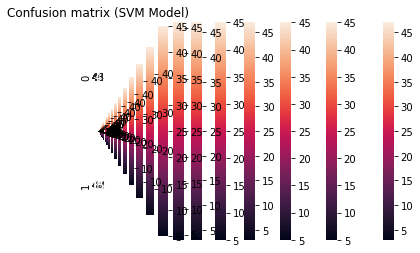

In [26]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    # Creating and running our optimization

    study_svm = optuna.create_study(direction='maximize',study_name ="SVM")

    with parallel_backend('threading'):
        study_svm.optimize(objective_svm, n_trials=10, n_jobs=-1)
    # Evaluating our Optuna Trial
    print("Best trial:", study_svm.best_trial.number)
    print("Best accuracy:", study_svm.best_trial.value)
    print("Best hyperparameters:", study_svm.best_params)
    best_param_svm = study_svm.best_params
    SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
    y_pred_svm = SVM.predict(x_test_)


    display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

    
    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(SVM, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [27]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.045250,0.187988,0.001774,0.001655,0.090298,0.040726,0.026250,0.021869,0
1,0.057536,0.143274,0.004774,0.061893,0.162321,0.004036,0.028060,0.039512,0
2,0.042024,0.122048,0.062190,0.034524,0.177786,0.040167,0.029905,0.000738,0
3,0.043833,0.142190,0.025429,0.044500,0.162571,0.023452,0.005357,0.012381,0
4,0.000440,0.110988,0.027488,0.005155,0.171107,0.019893,0.010560,0.025560,0
...,...,...,...,...,...,...,...,...,...
4995,0.128476,0.173524,0.105405,0.114381,0.022786,0.133452,0.045976,0.023524,1
4996,0.002988,0.114869,0.001393,0.179893,0.115440,0.191417,0.025893,0.012155,1
4997,0.043500,0.337952,0.143810,0.373119,0.110595,0.045286,0.011690,0.244524,1
4998,0.024643,0.055214,0.001619,0.074810,0.345905,0.023548,0.000429,0.137214,1


In [28]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]
        



In [29]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('_svm_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.306251,0.085581,1.029978,0.647137,0.294429,0.737899,0.506084,0.521746,0.516138
1,0.779571,0.084779,0.874184,0.728193,0.059369,0.698268,0.492856,0.465139,0.522795
2,0.530466,0.222693,0.816152,0.162721,0.363660,0.574752,0.498379,0.782810,0.493954
3,0.290404,0.141752,0.804166,0.400798,0.309982,0.816619,0.611678,0.655977,0.503922
4,1.064624,0.363400,0.800413,0.506437,0.309778,0.619496,0.373012,0.645382,0.585318
...,...,...,...,...,...,...,...,...,...
95,0.412597,0.597862,1.045889,0.418935,1.198544,0.464123,0.699475,0.823434,0.707608
96,0.755592,0.672896,2.059237,0.347974,0.346547,0.446183,0.594342,1.515888,0.842332
97,0.654831,0.253461,1.534378,0.413544,0.746769,0.251988,1.029837,0.353634,0.654805
98,0.377241,0.799224,0.528725,0.089700,0.244086,0.819208,0.643928,0.780508,0.535328


## Xgboost

In [30]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [31]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


[I 2024-08-26 20:48:12,943] A new study created in memory with name: XGBoost
[I 2024-08-26 20:48:19,029] Trial 2 finished with value: 0.8722411421372914 and parameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8860933314253876, 'colsample_bytree': 0.8683082061593406, 'reg_alpha': 9.591482892537375, 'reg_lambda': 0.3676683999609808}. Best is trial 2 with value: 0.8722411421372914.
[I 2024-08-26 20:48:20,315] Trial 4 finished with value: 0.8804558060622163 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8525127242803421, 'colsample_bytree': 0.9312963593948937, 'reg_alpha': 0.39506973803474404, 'reg_lambda': 0.0005406577640286815}. Best is trial 4 with value: 0.8804558060622163.
[I 2024-08-26 20:48:21,133] Trial 0 finished with value: 0.8851198016519853 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9261177562295513, 'colsample_bytree': 0.5340928557071245, 'reg_alpha': 0.15489224187885614, 'reg_lambda': 0.09690743860284451}. Be

Best trial: 5
Best accuracy: 0.8894025463865671
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9439557150572975, 'colsample_bytree': 0.9347975404624211, 'reg_alpha': 3.744173625093008e-05, 'reg_lambda': 0.0025694508641091536}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.345417  1.037903       0.002198       0.721064  0.662053  0.608469   
1      0.034634  1.101950       0.283271       0.001771  4.512155  0.817782   
2      0.195560  1.232081       0.265876       0.372767  2.009677  1.093188   
3      0.069071  0.488018       0.141676       0.480512  4.789107  0.464343   
4      0.214241  2.177

[I 2024-08-26 20:48:35,993] Trial 4 finished with value: 0.8744562878125552 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7034757033681318, 'colsample_bytree': 0.5108009261082749, 'reg_alpha': 0.003928595099656211, 'reg_lambda': 2.1118682829816412e-05}. Best is trial 4 with value: 0.8744562878125552.
[I 2024-08-26 20:48:36,906] Trial 1 finished with value: 0.8848049981402393 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8424671214403103, 'colsample_bytree': 0.8140917349220531, 'reg_alpha': 0.020748766661249547, 'reg_lambda': 0.042344513093239666}. Best is trial 1 with value: 0.8848049981402393.
[I 2024-08-26 20:48:36,930] Trial 3 finished with value: 0.8844923817566922 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.792216716846252, 'colsample_bytree': 0.55364367483197, 'reg_alpha': 0.15478360010082948, 'reg_lambda': 0.00011159640854207035}. Best is trial 1 with value: 0.8848049981402393.
[I 2024-08-26 20:48:37,13

Best trial: 1
Best accuracy: 0.8848049981402393
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.8424671214403103, 'colsample_bytree': 0.8140917349220531, 'reg_alpha': 0.020748766661249547, 'reg_lambda': 0.042344513093239666}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.170151  1.079637       0.164269       0.688812  0.503103  0.497869   
1      0.068567  1.080000       0.061663       0.299130  3.265797  1.070220   
2      0.233523  1.048470       0.192298       0.640535  0.768849  0.943324   
3      0.006711  0.763518       0.358365       0.545498  3.651132  0.714653   
4      0.111742  1.09260

[I 2024-08-26 20:48:49,460] Trial 3 finished with value: 0.865166764281352 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.5909229911756835, 'colsample_bytree': 0.5425130517025724, 'reg_alpha': 9.783287614480594, 'reg_lambda': 0.0006137096732682684}. Best is trial 3 with value: 0.865166764281352.
[I 2024-08-26 20:48:50,251] Trial 2 finished with value: 0.8727307842398005 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5782547521097301, 'colsample_bytree': 0.8545072884159095, 'reg_alpha': 0.016156249443352186, 'reg_lambda': 0.02059567363549575}. Best is trial 2 with value: 0.8727307842398005.
[I 2024-08-26 20:48:50,487] Trial 5 finished with value: 0.8777089583860385 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7678468108293175, 'colsample_bytree': 0.8508038465530796, 'reg_alpha': 1.3992389087878694, 'reg_lambda': 0.0007594770942447968}. Best is trial 5 with value: 0.8777089583860385.
[I 2024-08-26 20:48:52,558] Tri

Best trial: 4
Best accuracy: 0.8903988665482736
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8168653457086326, 'colsample_bytree': 0.9511794083919618, 'reg_alpha': 0.04532551120258243, 'reg_lambda': 0.00034488015418678166}
              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.667108  1.271329       0.104901       0.312631  0.203948  0.015626   
1      0.177360  1.057517       0.319802       0.127276  4.514244  0.243783   
2      0.224242  0.894741       0.093942       0.636160  2.646003  0.645642   
3      0.326285  0.968056       0.575732       0.607177  5.143556  0.659407   
4      0.467297  1.961

[I 2024-08-26 20:49:05,061] Trial 1 finished with value: 0.8735837113313853 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.53482102886421, 'colsample_bytree': 0.7988619764974726, 'reg_alpha': 5.82613770905153, 'reg_lambda': 0.0003146637824130631}. Best is trial 1 with value: 0.8735837113313853.
[I 2024-08-26 20:49:06,217] Trial 2 finished with value: 0.8792372798713137 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9391998649360859, 'colsample_bytree': 0.5447573448975265, 'reg_alpha': 0.0010550382462577897, 'reg_lambda': 9.394603909780695e-05}. Best is trial 2 with value: 0.8792372798713137.
[I 2024-08-26 20:49:06,580] Trial 3 finished with value: 0.8834221684467076 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.9050940089050338, 'colsample_bytree': 0.8762925216246927, 'reg_alpha': 0.6041570433897824, 'reg_lambda': 0.6214751430981988}. Best is trial 3 with value: 0.8834221684467076.
[I 2024-08-26 20:49:07,276] Tri

Best trial: 4
Best accuracy: 0.8852427105481548
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.5484005763696342, 'colsample_bytree': 0.903497653043656, 'reg_alpha': 0.0005113401320235715, 'reg_lambda': 0.0020576650682898635}
              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.524083  1.128795       0.690839       0.960657  0.523871  0.291418   
1      0.084682  1.195443       0.423897       0.073062  3.907922  0.653751   
2      0.171564  0.614270       0.012729       0.286136  1.114305  1.632966   
3      0.198113  0.912863       0.040624       0.383785  4.284211  0.199966   
4      0.100149  1.9749

[I 2024-08-26 20:49:20,064] Trial 2 finished with value: 0.8727551478266904 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6158742671397086, 'colsample_bytree': 0.9217395943175515, 'reg_alpha': 0.7627852024335423, 'reg_lambda': 0.00021647367802920913}. Best is trial 2 with value: 0.8727551478266904.
[I 2024-08-26 20:49:20,310] Trial 3 finished with value: 0.8713990784656899 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.8286805742995276, 'colsample_bytree': 0.6700881623839796, 'reg_alpha': 0.0018594214782789323, 'reg_lambda': 4.9701536809786744e-05}. Best is trial 2 with value: 0.8727551478266904.
[I 2024-08-26 20:49:21,034] Trial 4 finished with value: 0.8750703136099479 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.5917052503885027, 'colsample_bytree': 0.9602518294291691, 'reg_alpha': 2.5076724796558434, 'reg_lambda': 0.0011676410091506439}. Best is trial 4 with value: 0.8750703136099479.
[I 2024-08-26 20:49:21

Best trial: 6
Best accuracy: 0.8870321243863839
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8111149766505625, 'colsample_bytree': 0.9013743656461302, 'reg_alpha': 0.0006827008219550021, 'reg_lambda': 0.29040023911518137}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.666849  1.322336       0.203189       0.519312  0.107073  0.557806   
1      0.013846  1.130136       0.358959       0.585450  3.462892  1.266268   
2      0.151376  1.586239       0.493270       0.549977  2.534909  0.643328   
3      0.112587  0.876403       0.187834       0.901477  4.794375  0.313991   
4      0.410585  1.96335

[I 2024-08-26 20:49:34,379] Trial 3 finished with value: 0.8780054152536795 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6529622168403991, 'colsample_bytree': 0.8941602817749706, 'reg_alpha': 6.718170109935223e-05, 'reg_lambda': 0.0009607726081587803}. Best is trial 3 with value: 0.8780054152536795.
[I 2024-08-26 20:49:34,964] Trial 4 finished with value: 0.8793515454066139 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7888220014694196, 'colsample_bytree': 0.7700627237929631, 'reg_alpha': 0.006313508645729316, 'reg_lambda': 0.0001684861464865666}. Best is trial 4 with value: 0.8793515454066139.
[I 2024-08-26 20:49:35,017] Trial 2 finished with value: 0.8756798006110489 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6582349608543201, 'colsample_bytree': 0.9600517920172333, 'reg_alpha': 0.00020509438814188082, 'reg_lambda': 0.0013541079889138536}. Best is trial 4 with value: 0.8793515454066139.
[I 2024-08-26 20:4

Best trial: 6
Best accuracy: 0.8843047567845989
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8461404099596102, 'colsample_bytree': 0.762478006422125, 'reg_alpha': 0.31008074923239387, 'reg_lambda': 1.483608757764928}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.324250  1.080973       0.116164       0.653312  0.252172  0.629210   
1      0.019951  0.665423       0.185898       0.464043  3.177430  0.817591   
2      0.083858  1.041590       0.156499       0.393845  1.205918  0.890690   
3      0.125455  0.539471       0.058921       0.593858  3.411853  0.390072   
4      0.338794  1.477464    

[I 2024-08-26 20:49:49,272] Trial 5 finished with value: 0.8859624624705369 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9451891047048604, 'colsample_bytree': 0.9513312191912104, 'reg_alpha': 0.00038998453399779424, 'reg_lambda': 0.0020123742247468712}. Best is trial 5 with value: 0.8859624624705369.
[I 2024-08-26 20:49:50,157] Trial 3 finished with value: 0.8854480008185989 and parameters: {'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9716182838714331, 'colsample_bytree': 0.5004836992237078, 'reg_alpha': 4.957066870852342, 'reg_lambda': 2.520935737973135e-05}. Best is trial 5 with value: 0.8859624624705369.
[I 2024-08-26 20:49:50,369] Trial 1 finished with value: 0.8827444523321905 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9792167549421356, 'colsample_bytree': 0.5545481704485034, 'reg_alpha': 0.014504722347874534, 'reg_lambda': 0.00021826473339514788}. Best is trial 5 with value: 0.8859624624705369.
[I 2024-08-26 20:49:50

Best trial: 7
Best accuracy: 0.8899230087560465
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9044486458030031, 'colsample_bytree': 0.9800577859112551, 'reg_alpha': 0.00299443185162332, 'reg_lambda': 0.0001616798865351568}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.738873  1.246687       0.061790       0.818646  0.167828  0.361858   
1      0.027597  0.819022       0.151597       0.366757  4.384141  1.019402   
2      0.336581  1.909901       0.452081       0.383644  3.010429  0.943965   
3      0.246796  0.268989       0.396977       0.733373  4.794856  0.564302   
4      0.340582  2.17045

[I 2024-08-26 20:50:05,709] Trial 0 finished with value: 0.8813721970982175 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8252915433711516, 'colsample_bytree': 0.8130427797439675, 'reg_alpha': 3.395142308354006e-05, 'reg_lambda': 0.0011025284953676525}. Best is trial 0 with value: 0.8813721970982175.
[I 2024-08-26 20:50:05,760] Trial 5 finished with value: 0.8861064274649746 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9691790352676322, 'colsample_bytree': 0.9778518953491453, 'reg_alpha': 0.019155116380794666, 'reg_lambda': 0.010435843887694515}. Best is trial 5 with value: 0.8861064274649746.
[I 2024-08-26 20:50:05,865] Trial 4 finished with value: 0.8789025779904966 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.8216523181999587, 'colsample_bytree': 0.7799127936001884, 'reg_alpha': 1.1271942851490608e-05, 'reg_lambda': 3.388293300414533e-05}. Best is trial 5 with value: 0.8861064274649746.
[I 2024-08-26 20:50:

Best trial: 9
Best accuracy: 0.8895175136793892
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.949623695366094, 'colsample_bytree': 0.6449472607225071, 'reg_alpha': 1.3244144405916135e-05, 'reg_lambda': 0.06207545203169576}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.108728  1.479276       0.266519       0.672106  0.170719  0.335774   
1      0.107505  1.165634       0.234318       0.055014  4.145924  0.881280   
2      0.198457  1.715660       0.708438       0.702761  2.017912  0.324852   
3      0.165926  0.633099       0.180502       0.591698  4.289069  0.487923   
4      0.470054  2.66459

[I 2024-08-26 20:50:18,541] Trial 1 finished with value: 0.8758693246337748 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9713509922458816, 'colsample_bytree': 0.5490193413619946, 'reg_alpha': 0.0003504186692743576, 'reg_lambda': 0.0004386086538632443}. Best is trial 1 with value: 0.8758693246337748.
[I 2024-08-26 20:50:18,599] Trial 3 finished with value: 0.8752519013056813 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5016044506222681, 'colsample_bytree': 0.9641404820250543, 'reg_alpha': 0.10636128716238873, 'reg_lambda': 3.5016690279855456e-05}. Best is trial 1 with value: 0.8758693246337748.
[I 2024-08-26 20:50:19,456] Trial 0 finished with value: 0.8809608095789595 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8914559359202545, 'colsample_bytree': 0.7359099352973075, 'reg_alpha': 0.7122962030833684, 'reg_lambda': 0.0007928109780815992}. Best is trial 0 with value: 0.8809608095789595.
[I 2024-08-26 20:50:

Best trial: 4
Best accuracy: 0.8883256618865744
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9807637137507961, 'colsample_bytree': 0.6793976773772117, 'reg_alpha': 0.1353739181809852, 'reg_lambda': 0.00218342329896715}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.013901  0.975001       0.111754       0.574723  0.166155  0.383699   
1      0.155798  0.864074       0.037236       0.254192  3.129354  0.972921   
2      0.315319  1.130158       0.192813       0.441676  0.857006  0.796569   
3      0.272506  0.713430       0.268654       0.554994  3.320039  0.291416   
4      0.015762  1.421071  

[I 2024-08-26 20:50:32,784] Trial 3 finished with value: 0.8763043749796615 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9053113951979064, 'colsample_bytree': 0.8876046176108128, 'reg_alpha': 9.621358489438846, 'reg_lambda': 0.0003058025643902534}. Best is trial 3 with value: 0.8763043749796615.
[I 2024-08-26 20:50:33,099] Trial 1 finished with value: 0.8778078375812356 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5544911017708196, 'colsample_bytree': 0.791018863460289, 'reg_alpha': 3.8973003131061104, 'reg_lambda': 0.0001064686080243597}. Best is trial 1 with value: 0.8778078375812356.
[I 2024-08-26 20:50:33,450] Trial 5 finished with value: 0.875544950425576 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.665866594578349, 'colsample_bytree': 0.5763333711894503, 'reg_alpha': 0.07919032298752612, 'reg_lambda': 8.725226209005902e-05}. Best is trial 1 with value: 0.8778078375812356.
[I 2024-08-26 20:50:33,746] Tri

Best trial: 6
Best accuracy: 0.8887120875947615
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9669677526199063, 'colsample_bytree': 0.7002608894301426, 'reg_alpha': 0.0014376380306109597, 'reg_lambda': 3.8249760589970045}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.248209  0.776805       0.076666       0.628547  0.168012  0.630024   
1      0.148982  0.560140       0.137650       0.094205  3.259136  0.746728   
2      0.222848  1.092269       0.206114       0.321213  1.599877  0.748720   
3      0.265929  0.250774       0.353901       0.461386  3.781808  0.597595   
4      0.328670  1.881733

[I 2024-08-26 20:50:47,652] Trial 1 finished with value: 0.8770070871221624 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6670276818597672, 'colsample_bytree': 0.873750456188753, 'reg_alpha': 0.0076687512095668185, 'reg_lambda': 8.284501845733745e-05}. Best is trial 1 with value: 0.8770070871221624.
[I 2024-08-26 20:50:47,913] Trial 5 finished with value: 0.873145589225507 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.6362543499080983, 'colsample_bytree': 0.668063569643945, 'reg_alpha': 0.18261983290387274, 'reg_lambda': 0.002545477061050519}. Best is trial 1 with value: 0.8770070871221624.
[I 2024-08-26 20:50:48,161] Trial 3 finished with value: 0.8704135564456983 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.5935512948547017, 'colsample_bytree': 0.5385400109460188, 'reg_alpha': 0.00012196421853346548, 'reg_lambda': 1.4816290916822697e-05}. Best is trial 1 with value: 0.8770070871221624.
[I 2024-08-26 20:50:48

Best trial: 2
Best accuracy: 0.8888751123055573
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.750335881258283, 'colsample_bytree': 0.8324135077843693, 'reg_alpha': 0.0014041763357230362, 'reg_lambda': 0.09143806413905316}


[I 2024-08-26 20:50:56,152] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.341587  2.102496       0.114237       0.721198  0.488650  0.130132   
1      0.104549  1.059986       0.245727       0.401622  3.789626  1.031292   
2      0.342973  1.779740       0.104442       0.043494  2.614936  1.036700   
3      0.236562  0.785546       0.208257       0.891855  4.725050  0.582173   
4      0.379663  1.829360       0.086997       0.756182  1.794113  0.609113   
..          ...       ...            ...            ...       ...       ...   
95     0.015471  0.397287       0.433381       0.676550  0.453442  0.648962   
96     0.208662  3.472097       0.269978 

[I 2024-08-26 20:51:03,340] Trial 4 finished with value: 0.8778878420410361 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.6967243526834341, 'colsample_bytree': 0.5909649179665123, 'reg_alpha': 0.0420557414278214, 'reg_lambda': 0.014453247421484265}. Best is trial 4 with value: 0.8778878420410361.
[I 2024-08-26 20:51:04,243] Trial 5 finished with value: 0.8825230027078439 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.8504001079165469, 'colsample_bytree': 0.6881350892505392, 'reg_alpha': 0.35244683963060375, 'reg_lambda': 0.027783305780388463}. Best is trial 5 with value: 0.8825230027078439.
[I 2024-08-26 20:51:05,063] Trial 3 finished with value: 0.8820446671272653 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9493297605405423, 'colsample_bytree': 0.5379504524518648, 'reg_alpha': 0.0016789721103545718, 'reg_lambda': 1.6775927106095565}. Best is trial 5 with value: 0.8825230027078439.
[I 2024-08-26 20:51:05,484] T

Best trial: 0
Best accuracy: 0.890422249166597
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9421868195435481, 'colsample_bytree': 0.8838349038655102, 'reg_alpha': 0.48355428878637435, 'reg_lambda': 0.09617088681813367}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.599898  1.014620       0.213984       0.655366  0.394309  0.310314   
1      0.267536  0.808887       0.348703       0.281250  3.643013  0.740683   
2      0.472923  1.007512       0.095338       0.536306  1.873492  0.901295   
3      0.180547  0.364991       0.006806       0.533640  4.288386  0.413267   
4      0.471349  1.820939 

[I 2024-08-26 20:51:18,647] Trial 5 finished with value: 0.8729488350896049 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.5048877363055306, 'colsample_bytree': 0.8307700590155639, 'reg_alpha': 0.07508363324345317, 'reg_lambda': 0.36207762125992626}. Best is trial 5 with value: 0.8729488350896049.
[I 2024-08-26 20:51:19,839] Trial 4 finished with value: 0.8845531744579301 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9913172153525622, 'colsample_bytree': 0.5363641139339199, 'reg_alpha': 5.978139339645085, 'reg_lambda': 9.233431073884718e-05}. Best is trial 4 with value: 0.8845531744579301.
[I 2024-08-26 20:51:19,907] Trial 3 finished with value: 0.8730698917335016 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.7046610466714847, 'colsample_bytree': 0.8909406691087827, 'reg_alpha': 0.0025036073275905625, 'reg_lambda': 0.0006331859885358584}. Best is trial 4 with value: 0.8845531744579301.
[I 2024-08-26 20:51:20,253

Best trial: 4
Best accuracy: 0.8845531744579301
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9913172153525622, 'colsample_bytree': 0.5363641139339199, 'reg_alpha': 5.978139339645085, 'reg_lambda': 9.233431073884718e-05}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.095878  0.694250       0.067621       0.076075  0.398087  0.398095   
1      0.158452  0.607702       0.085679       0.280500  1.645480  0.191633   
2      0.128639  0.775717       0.014851       0.355308  1.001710  0.164682   
3      0.140351  0.465360       0.112897       0.448480  1.923515  0.266477   
4      0.133146  0.727293 

[I 2024-08-26 20:51:33,745] Trial 3 finished with value: 0.8746604313201108 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5299542418804688, 'colsample_bytree': 0.9968899316096718, 'reg_alpha': 3.355999784978857e-05, 'reg_lambda': 5.827733362941506}. Best is trial 3 with value: 0.8746604313201108.
[I 2024-08-26 20:51:34,722] Trial 5 finished with value: 0.8717247362857763 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6220370465207139, 'colsample_bytree': 0.8326608299072823, 'reg_alpha': 2.0398065476734484e-05, 'reg_lambda': 3.497716562560895e-05}. Best is trial 3 with value: 0.8746604313201108.
[I 2024-08-26 20:51:34,760] Trial 2 finished with value: 0.8745927829725056 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.5660683112543148, 'colsample_bytree': 0.6192306178167417, 'reg_alpha': 0.0002102508402008808, 'reg_lambda': 0.08907177570374748}. Best is trial 3 with value: 0.8746604313201108.
[I 2024-08-26 20:51:35,6

Best trial: 1
Best accuracy: 0.8854194824294526
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9157478960301829, 'colsample_bytree': 0.6281169033756429, 'reg_alpha': 7.895189172597324e-05, 'reg_lambda': 0.0021595778713405208}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.324003  0.825969       0.012903       0.392006  0.233363  0.072702   
1      0.112711  0.571399       0.171098       0.016659  3.487199  0.891021   
2      0.166736  1.167336       0.288242       0.450198  1.065580  0.746241   
3      0.310797  0.492672       0.293660       0.780510  3.913974  0.541983   
4      0.558297  1.758

[I 2024-08-26 20:51:48,237] Trial 2 finished with value: 0.8731689860198967 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6792972434571987, 'colsample_bytree': 0.7604679991571697, 'reg_alpha': 0.0014884745685777722, 'reg_lambda': 0.00031653023915889395}. Best is trial 2 with value: 0.8731689860198967.
[I 2024-08-26 20:51:49,013] Trial 4 finished with value: 0.8860996888091421 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.9633591220542438, 'colsample_bytree': 0.8792052588213272, 'reg_alpha': 0.0008674515389228924, 'reg_lambda': 0.015365968148951734}. Best is trial 4 with value: 0.8860996888091421.
[I 2024-08-26 20:51:49,362] Trial 5 finished with value: 0.8836625320041551 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.9794019549187644, 'colsample_bytree': 0.5885460449798054, 'reg_alpha': 0.00032801406991746446, 'reg_lambda': 0.009506370750035707}. Best is trial 4 with value: 0.8860996888091421.
[I 2024-08-26 20:51

Best trial: 4
Best accuracy: 0.8860996888091421
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.9633591220542438, 'colsample_bytree': 0.8792052588213272, 'reg_alpha': 0.0008674515389228924, 'reg_lambda': 0.015365968148951734}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.224082  1.014721       0.054149       0.515309  0.003692  0.164350   
1      0.044987  0.883323       0.150300       0.430912  3.301657  1.022697   
2      0.249323  1.155148       0.371762       0.388656  1.124446  0.555497   
3      0.165319  0.752258       0.332255       0.447823  3.667118  0.378914   
4      0.139614  1.4028

[I 2024-08-26 20:52:02,950] Trial 3 finished with value: 0.8731402862185484 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.6504330865384149, 'colsample_bytree': 0.843608667866434, 'reg_alpha': 0.012085644133176258, 'reg_lambda': 2.4768626263391607}. Best is trial 3 with value: 0.8731402862185484.
[I 2024-08-26 20:52:03,277] Trial 4 finished with value: 0.886709940923719 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9491138597085472, 'colsample_bytree': 0.7856659448007787, 'reg_alpha': 5.341358236442889, 'reg_lambda': 0.15998409176200848}. Best is trial 4 with value: 0.886709940923719.
[I 2024-08-26 20:52:04,029] Trial 2 finished with value: 0.8840945629360543 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.7222426962249082, 'colsample_bytree': 0.7103453022147252, 'reg_alpha': 3.874473063214315, 'reg_lambda': 0.7042994358110445}. Best is trial 4 with value: 0.886709940923719.
[I 2024-08-26 20:52:04,609] Trial 0 fini

Best trial: 4
Best accuracy: 0.886709940923719
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9491138597085472, 'colsample_bytree': 0.7856659448007787, 'reg_alpha': 5.341358236442889, 'reg_lambda': 0.15998409176200848}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



[I 2024-08-26 20:52:09,982] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.062708  0.754017       0.024016       0.228485  0.415663  0.311170   
1      0.036830  0.741422       0.030162       0.400796  2.057655  0.182074   
2      0.037247  0.918317       0.047385       0.405308  0.832271  0.239648   
3      0.059100  0.547876       0.041640       0.579849  2.260794  0.328748   
4      0.051819  0.899333       0.052433       0.292040  0.680542  0.343169   
..          ...       ...            ...            ...       ...       ...   
95     0.083991  0.340120       0.104797       0.341759  0.179924  0.270518   
96     0.031180  1.877690       0.023458       0.288673  1.805270  0.641169   
97     0.102851  1.648895       0.029761       0.275036  0.684574  0.150285   
98     0.066278  0.477175       0.109311       0.243729  3.086520  0.225852   
99     0.056821  1.467504       0.016113       0.452438  0.177747  0.073960   

         DPF       Age  Outcome  
0   0.366607  0.7

[I 2024-08-26 20:52:16,748] Trial 4 finished with value: 0.8753724998508584 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.811353294086687, 'colsample_bytree': 0.6013976721706967, 'reg_alpha': 2.410942118056898, 'reg_lambda': 0.0862919381729026}. Best is trial 4 with value: 0.8753724998508584.
[I 2024-08-26 20:52:17,047] Trial 5 finished with value: 0.8771215018374882 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.9194444349744086, 'colsample_bytree': 0.5903226669764119, 'reg_alpha': 0.08322942827229637, 'reg_lambda': 1.08025806182062}. Best is trial 5 with value: 0.8771215018374882.
[I 2024-08-26 20:52:17,147] Trial 0 finished with value: 0.8708933399681712 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.6526665222134709, 'colsample_bytree': 0.6634030334205754, 'reg_alpha': 0.0008018874663749775, 'reg_lambda': 1.0888005032524344}. Best is trial 5 with value: 0.8771215018374882.
[I 2024-08-26 20:52:18,287] Trial 1 

Best trial: 3
Best accuracy: 0.8823774208638996
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.9634675041400564, 'colsample_bytree': 0.8545244997149716, 'reg_alpha': 0.15373938303387916, 'reg_lambda': 0.004799181870507138}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.499967  1.195025       0.200640       0.738462  0.026365  0.173138   
1      0.142574  0.534743       0.360873       0.195960  3.570109  1.043496   
2      0.170846  0.925878       0.383443       0.468428  1.016004  0.933458   
3      0.151235  0.327345       0.211945       0.745011  3.758561  0.158752   
4      0.049539  1.257813

[I 2024-08-26 20:52:23,900] A new study created in memory with name: XGBoost
[I 2024-08-26 20:52:31,073] Trial 0 finished with value: 0.8874846787797455 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8127692545258467, 'colsample_bytree': 0.9908874629433078, 'reg_alpha': 2.784571999996132, 'reg_lambda': 6.38567160173673e-05}. Best is trial 0 with value: 0.8874846787797455.
[I 2024-08-26 20:52:31,356] Trial 1 finished with value: 0.8744567271448764 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.8626445631307431, 'colsample_bytree': 0.5973065983278789, 'reg_alpha': 0.16293541631696268, 'reg_lambda': 1.4818761215885782e-05}. Best is trial 0 with value: 0.8874846787797455.
[I 2024-08-26 20:52:31,489] Trial 3 finished with value: 0.8712116599863949 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.5670606484753146, 'colsample_bytree': 0.822128182555756, 'reg_alpha': 0.016860970399001245, 'reg_lambda': 0.006189632530563739}

Best trial: 9
Best accuracy: 0.8896535462861891
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7029935546457641, 'colsample_bytree': 0.8303417537477424, 'reg_alpha': 1.4981076810454553e-05, 'reg_lambda': 0.006177468963319364}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.344678  2.004681       0.217216       0.692659  0.057386  0.208463   
1      0.355986  0.945217       0.351424       0.365999  3.827898  1.003619   
2      0.067907  1.828860       1.043233       0.505707  2.533988  0.731282   
3      0.260442  0.871076       0.623910       1.160446  4.090333  0.270649   
4      0.411470  3.022

[I 2024-08-26 20:52:37,119] A new study created in memory with name: XGBoost
[I 2024-08-26 20:52:43,633] Trial 0 finished with value: 0.8726926823105622 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6832359805559336, 'colsample_bytree': 0.8504345827952284, 'reg_alpha': 7.699097700040857e-05, 'reg_lambda': 0.0016714889055838788}. Best is trial 0 with value: 0.8726926823105622.
[I 2024-08-26 20:52:44,061] Trial 2 finished with value: 0.8722307729672258 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.562047683460186, 'colsample_bytree': 0.6735030552773196, 'reg_alpha': 0.11065539470900114, 'reg_lambda': 0.004097231076556024}. Best is trial 0 with value: 0.8726926823105622.
[I 2024-08-26 20:52:44,564] Trial 3 finished with value: 0.8759142274532151 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6718184921205272, 'colsample_bytree': 0.9970510643531818, 'reg_alpha': 3.951540758530155, 'reg_lambda': 0.005768760311797058}

Best trial: 6
Best accuracy: 0.8870889434959728
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9725182193749482, 'colsample_bytree': 0.8032965210626658, 'reg_alpha': 0.00013025735302742624, 'reg_lambda': 0.2853381796533658}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 20:52:51,702] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.346760  0.781562       0.050463       0.744729  0.015971  0.049030   
1      0.052710  0.807979       0.269590       0.341795  3.601435  0.893417   
2      0.269736  1.033155       0.212113       0.507697  0.835613  0.636645   
3      0.049095  0.558757       0.248969       0.708211  3.682766  0.153823   
4      0.199189  1.409712       0.385008       0.688215  0.863195  0.326497   
..          ...       ...            ...            ...       ...       ...   
95     0.075560  0.386272       0.613522       0.106579  0.682788  0.688195   
96     0.158216  2.620871       0.265989       0.076723  2.264125  1.352777   
97     0.161278  2.188955       0.110506       0.222685  0.954973  0.259426   
98     0.261483  0.207404       0.488789       0.400119  4.706080  0.209992   
99     0.131302  2.130793       0.071407       0.566739  0.435568  0.396249   

         DPF       Age  Outcome  
0   0.601958  0.4

[I 2024-08-26 20:52:59,241] Trial 3 finished with value: 0.8720761897823398 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6024352699292569, 'colsample_bytree': 0.9928364448236253, 'reg_alpha': 0.11985132758056212, 'reg_lambda': 1.3246616282066923e-05}. Best is trial 3 with value: 0.8720761897823398.
[I 2024-08-26 20:52:59,895] Trial 4 finished with value: 0.8789832153904983 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.9130893872750141, 'colsample_bytree': 0.5264584406364893, 'reg_alpha': 0.02470847953589399, 'reg_lambda': 0.001292743029319484}. Best is trial 4 with value: 0.8789832153904983.
[I 2024-08-26 20:53:00,067] Trial 2 finished with value: 0.8819628916748873 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.9765453568955677, 'colsample_bytree': 0.6975571297027493, 'reg_alpha': 0.0017544525430211618, 'reg_lambda': 0.3415268844900643}. Best is trial 2 with value: 0.8819628916748873.
[I 2024-08-26 20:53:00,711

Best trial: 7
Best accuracy: 0.8850755028126805
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8129648956874526, 'colsample_bytree': 0.7839565100098613, 'reg_alpha': 2.665901358398783, 'reg_lambda': 1.558650819965854}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 20:53:06,573] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.009599  0.892191       0.071482       0.249289  0.498944  0.427053   
1      0.068444  0.901746       0.033656       0.417387  2.558334  0.676456   
2      0.092969  1.025823       0.132835       0.365588  0.756151  0.322497   
3      0.160906  0.749763       0.138883       0.419353  2.826537  0.537585   
4      0.017234  1.034302       0.152024       0.222798  0.747495  0.545498   
..          ...       ...            ...            ...       ...       ...   
95     0.073261  0.690832       0.263671       0.483839  0.324397  0.587040   
96     0.033296  2.355774       0.050244       0.205595  1.318956  0.848861   
97     0.139220  1.782962       0.041583       0.242117  0.820338  0.098250   
98     0.086319  0.537801       0.084981       0.017587  3.512719  0.177052   
99     0.039796  1.672319       0.015428       0.168695  0.157673  0.194160   

         DPF       Age  Outcome  
0   0.378902  0.6

[I 2024-08-26 20:53:13,951] Trial 5 finished with value: 0.882159395680041 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.8632040500447835, 'colsample_bytree': 0.8002214104852647, 'reg_alpha': 0.010489765780148135, 'reg_lambda': 0.4047998252412685}. Best is trial 5 with value: 0.882159395680041.
[I 2024-08-26 20:53:14,097] Trial 2 finished with value: 0.884613766199281 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8721005649634961, 'colsample_bytree': 0.682691357043058, 'reg_alpha': 0.8211077352193255, 'reg_lambda': 0.036074349768736205}. Best is trial 2 with value: 0.884613766199281.
[I 2024-08-26 20:53:14,509] Trial 0 finished with value: 0.8750702821899755 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.683939718288413, 'colsample_bytree': 0.9649605992902527, 'reg_alpha': 0.003924052955333027, 'reg_lambda': 0.00023672059907366922}. Best is trial 2 with value: 0.884613766199281.
[I 2024-08-26 20:53:14,767] Trial 

Best trial: 4
Best accuracy: 0.8853522549975885
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.858759531083783, 'colsample_bytree': 0.5539545040834086, 'reg_alpha': 0.00489477506548716, 'reg_lambda': 0.0019107121152091204}


[I 2024-08-26 20:53:20,920] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.404257  1.055952       0.292231       0.728675  0.438441  0.678658   
1      0.153016  0.815104       0.272022       0.100898  3.160885  1.013311   
2      0.018954  1.462194       0.341344       0.587715  1.350476  0.941556   
3      0.098203  0.501131       0.334878       0.667731  3.789306  0.468658   
4      0.159596  1.699118       0.380109       0.860931  1.326919  0.746276   
..          ...       ...            ...            ...       ...       ...   
95     0.227670  0.368222       0.729744       0.793045  0.021561  0.689379   
96     0.000271  3.375030       0.261041 

[I 2024-08-26 20:53:28,371] Trial 2 finished with value: 0.8770979134254288 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7906607877023756, 'colsample_bytree': 0.7066883082401028, 'reg_alpha': 0.005792496186352271, 'reg_lambda': 0.0002858999530454719}. Best is trial 2 with value: 0.8770979134254288.
[I 2024-08-26 20:53:28,904] Trial 4 finished with value: 0.8814718375890532 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8845222217259805, 'colsample_bytree': 0.6636420827059673, 'reg_alpha': 2.62117944358454e-05, 'reg_lambda': 1.7642636884158305}. Best is trial 4 with value: 0.8814718375890532.
[I 2024-08-26 20:53:29,568] Trial 1 finished with value: 0.8791154543568287 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.6287898449773619, 'colsample_bytree': 0.7226531184108591, 'reg_alpha': 2.5914424135048337, 'reg_lambda': 0.31839262633880155}. Best is trial 4 with value: 0.8814718375890532.
[I 2024-08-26 20:53:29,670] 

Best trial: 8
Best accuracy: 0.8859334188124938
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9459297646358186, 'colsample_bytree': 0.8853420965687686, 'reg_alpha': 0.3047382559523937, 'reg_lambda': 1.4893271144028633}


[I 2024-08-26 20:53:36,361] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.087735  0.874664       0.031315       0.566847  0.198408  0.229084   
1      0.088339  0.750705       0.201510       0.268911  3.322987  0.766369   
2      0.228992  1.209145       0.287929       0.467148  0.909057  0.629365   
3      0.242537  0.595460       0.257456       0.553817  3.581713  0.298191   
4      0.120973  1.384558       0.322334       0.554478  0.968749  0.532553   
..          ...       ...            ...            ...       ...       ...   
95     0.225391  0.520011       0.593690       0.317335  0.577936  0.482336   
96     0.034153  2.633212       0.182393 

[I 2024-08-26 20:53:44,383] Trial 1 finished with value: 0.8771075310262753 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6808125539613936, 'colsample_bytree': 0.9480328206546211, 'reg_alpha': 0.0007770205062175174, 'reg_lambda': 4.319980931620254e-05}. Best is trial 1 with value: 0.8771075310262753.
[I 2024-08-26 20:53:44,774] Trial 5 finished with value: 0.8846884721317403 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.816520130017723, 'colsample_bytree': 0.7861982556930398, 'reg_alpha': 0.23700764826869058, 'reg_lambda': 0.1825668509311612}. Best is trial 5 with value: 0.8846884721317403.
[I 2024-08-26 20:53:44,995] Trial 4 finished with value: 0.8748946426071789 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5554362211168173, 'colsample_bytree': 0.877762141906138, 'reg_alpha': 1.1293363334712376, 'reg_lambda': 0.0518689244252892}. Best is trial 5 with value: 0.8846884721317403.
[I 2024-08-26 20:53:46,107] Tri

Best trial: 7
Best accuracy: 0.8912045394580898
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7614944781219439, 'colsample_bytree': 0.8892518172034987, 'reg_alpha': 8.400740558135475e-05, 'reg_lambda': 0.16514094739740548}


[I 2024-08-26 20:53:55,420] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.621893  1.812607       0.248302       0.495503  0.604391  0.227845   
1      0.158072  1.416394       0.491466       0.078503  4.828926  0.488796   
2      0.157576  1.107983       0.068345       0.628218  2.526626  0.815428   
3      0.316490  0.756855       0.149405       0.736755  5.267269  0.500435   
4      0.214572  1.793575       0.125791       0.555425  2.370647  0.962700   
..          ...       ...            ...            ...       ...       ...   
95     0.345197  0.810638       0.769379       0.534814  0.627845  0.932981   
96     0.129920  4.105875       0.192477 

[I 2024-08-26 20:54:03,124] Trial 3 finished with value: 0.8757567086728747 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.670482544816895, 'colsample_bytree': 0.8127648335486668, 'reg_alpha': 0.025867413446886683, 'reg_lambda': 0.1362676398608758}. Best is trial 3 with value: 0.8757567086728747.
[I 2024-08-26 20:54:03,343] Trial 5 finished with value: 0.8735942110985593 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.5425570490974834, 'colsample_bytree': 0.8015442416347011, 'reg_alpha': 5.600612106461928, 'reg_lambda': 9.897048739643802e-05}. Best is trial 3 with value: 0.8757567086728747.
[I 2024-08-26 20:54:04,067] Trial 1 finished with value: 0.8799500042713448 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.7594836641336966, 'colsample_bytree': 0.9154153215233274, 'reg_alpha': 0.000817208489792782, 'reg_lambda': 0.4285777526321927}. Best is trial 1 with value: 0.8799500042713448.
[I 2024-08-26 20:54:04,836] Tri

Best trial: 0
Best accuracy: 0.8824533556576866
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8926297843455093, 'colsample_bytree': 0.7256163066844686, 'reg_alpha': 0.45957551041408945, 'reg_lambda': 0.0002599044091472443}


[I 2024-08-26 20:54:10,192] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.100519  0.873243       0.004174       0.548998  0.125099  0.013716   
1      0.006560  0.814037       0.251820       0.111597  3.877501  0.676345   
2      0.261949  1.092411       0.110176       0.292265  0.876174  0.660008   
3      0.350125  0.484307       0.000892       0.662816  4.000016  0.104545   
4      0.367100  1.567567       0.236041       0.561195  1.010142  0.589185   
..          ...       ...            ...            ...       ...       ...   
95     0.110000  0.316717       0.622393       0.464272  0.008167  0.820942   
96     0.103169  2.837868       0.431516 

[I 2024-08-26 20:54:17,429] Trial 5 finished with value: 0.8698817433076591 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5263136312808552, 'colsample_bytree': 0.6234652069951914, 'reg_alpha': 0.19315184102385413, 'reg_lambda': 0.0024389923843795435}. Best is trial 5 with value: 0.8698817433076591.
[I 2024-08-26 20:54:17,709] Trial 2 finished with value: 0.8806948662363178 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.8564452941967816, 'colsample_bytree': 0.5120581837112177, 'reg_alpha': 2.540577896110075e-05, 'reg_lambda': 0.0010154844324484196}. Best is trial 2 with value: 0.8806948662363178.
[I 2024-08-26 20:54:17,916] Trial 3 finished with value: 0.8695621933351414 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.6864511769297026, 'colsample_bytree': 0.6317657469885767, 'reg_alpha': 0.0012569211420495098, 'reg_lambda': 0.22692259139090395}. Best is trial 2 with value: 0.8806948662363178.
[I 2024-08-26 20:54:18,

Best trial: 1
Best accuracy: 0.8816795390531754
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.846321500473469, 'colsample_bytree': 0.989812450982786, 'reg_alpha': 7.953717361400232e-05, 'reg_lambda': 1.3930099650554314e-05}


[I 2024-08-26 20:54:24,297] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.86      0.84        50
           1       0.85      0.82      0.84        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.162470  0.612523       0.084281       0.281345  0.066148  0.310736   
1      0.149000  1.021672       0.076938       0.360901  2.930601  0.937221   
2      0.236528  0.988648       0.220469       0.072184  0.783820  0.382275   
3      0.108667  0.841889       0.199573       0.385499  3.194526  0.364854   
4      0.146894  1.216219       0.319894       0.341221  0.770360  0.650487   
..          ...       ...            ...            ...       ...       ...   
95     0.086171  0.675859       0.274431       0.581411  0.229573  0.385071   
96     0.011923  1.900072       0.306534 

[I 2024-08-26 20:54:31,456] Trial 4 finished with value: 0.8693013413251568 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.5106889750727686, 'colsample_bytree': 0.7246376386015093, 'reg_alpha': 0.0007539233983351812, 'reg_lambda': 0.22766329949170944}. Best is trial 4 with value: 0.8693013413251568.
[I 2024-08-26 20:54:31,880] Trial 2 finished with value: 0.874103466234703 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.713571434381266, 'colsample_bytree': 0.7373755719963705, 'reg_alpha': 0.0008170902395262886, 'reg_lambda': 0.0008257723294949734}. Best is trial 2 with value: 0.874103466234703.
[I 2024-08-26 20:54:32,265] Trial 3 finished with value: 0.8833901002193874 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9286752071549855, 'colsample_bytree': 0.6303501568883362, 'reg_alpha': 0.00015680948536371756, 'reg_lambda': 0.22325683852911143}. Best is trial 3 with value: 0.8833901002193874.
[I 2024-08-26 20:54:32,27

Best trial: 6
Best accuracy: 0.8839333681771402
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9789678429429078, 'colsample_bytree': 0.6295112559454578, 'reg_alpha': 0.5949837188944099, 'reg_lambda': 0.0017515850165690128}


[I 2024-08-26 20:54:38,508] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.073706  0.968747       0.049189       0.692308  0.099705  0.275665   
1      0.160450  0.754442       0.151354       0.251842  3.308709  0.768270   
2      0.229948  1.008673       0.143508       0.326387  1.022342  0.800304   
3      0.254077  0.481055       0.129297       0.408824  3.448161  0.528482   
4      0.068814  1.446121       0.220550       0.589132  0.960316  0.576559   
..          ...       ...            ...            ...       ...       ...   
95     0.007947  0.693163       0.493680       0.497980  0.204375  0.755831   
96     0.056296  2.857338       0.153568 

[I 2024-08-26 20:54:45,254] Trial 4 finished with value: 0.8738232114457751 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5073452325173701, 'colsample_bytree': 0.9812439533221298, 'reg_alpha': 0.002835173522993941, 'reg_lambda': 0.009562417311358663}. Best is trial 4 with value: 0.8738232114457751.
[I 2024-08-26 20:54:45,737] Trial 3 finished with value: 0.8790562610058275 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.8512541752243565, 'colsample_bytree': 0.6034464651705835, 'reg_alpha': 1.2359795413521677, 'reg_lambda': 0.001855967328937941}. Best is trial 3 with value: 0.8790562610058275.
[I 2024-08-26 20:54:46,594] Trial 0 finished with value: 0.879354212272246 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7959563961269958, 'colsample_bytree': 0.7543025977374007, 'reg_alpha': 0.023691388532441973, 'reg_lambda': 0.0002787645343827114}. Best is trial 0 with value: 0.879354212272246.
[I 2024-08-26 20:54:46,651] 

Best trial: 9
Best accuracy: 0.8844490560759727
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9985249939638963, 'colsample_bytree': 0.5349014798101708, 'reg_alpha': 0.12579261362636138, 'reg_lambda': 0.0007401358353332267}


[I 2024-08-26 20:54:53,777] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.588259  0.733216       0.097753       0.680786  0.400114  0.125422   
1      0.084864  0.771521       0.317647       0.075967  3.871810  1.126084   
2      0.239278  0.900667       0.175918       0.188037  2.359409  0.624665   
3      0.119769  0.573278       0.198406       0.479229  4.309043  0.398163   
4      0.224605  2.314835       0.448217       0.666865  0.823167  0.295113   
..          ...       ...            ...            ...       ...       ...   
95     0.085540  0.340144       0.593733       0.690492  0.483402  0.460204   
96     0.025372  3.624072       0.134504 

[I 2024-08-26 20:55:00,775] Trial 2 finished with value: 0.8710167109942016 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5845377452813947, 'colsample_bytree': 0.51964285541915, 'reg_alpha': 5.6134093097337803e-05, 'reg_lambda': 0.0003848348622402958}. Best is trial 2 with value: 0.8710167109942016.
[I 2024-08-26 20:55:01,281] Trial 4 finished with value: 0.8846820163776542 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.9108220420363882, 'colsample_bytree': 0.5497701096436909, 'reg_alpha': 0.34974940654616427, 'reg_lambda': 6.443015798968539}. Best is trial 4 with value: 0.8846820163776542.
[I 2024-08-26 20:55:01,639] Trial 3 finished with value: 0.8764289705155548 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.612103157114833, 'colsample_bytree': 0.8431683354667981, 'reg_alpha': 4.740865457069556, 'reg_lambda': 0.00021791863449247727}. Best is trial 4 with value: 0.8846820163776542.
[I 2024-08-26 20:55:01,840] T

Best trial: 4
Best accuracy: 0.8846820163776542
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.9108220420363882, 'colsample_bytree': 0.5497701096436909, 'reg_alpha': 0.34974940654616427, 'reg_lambda': 6.443015798968539}


[I 2024-08-26 20:55:08,320] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.071914  0.667076       0.120022       0.393787  0.208783  0.634659   
1      0.051162  0.633581       0.257291       0.048252  2.832430  0.826550   
2      0.234480  0.917257       0.152574       0.205243  1.038935  0.775902   
3      0.255185  0.383200       0.143776       0.383964  3.275114  0.513933   
4      0.212264  1.519641       0.321961       0.511365  0.835031  0.590462   
..          ...       ...            ...            ...       ...       ...   
95     0.353788  0.463358       0.532312       0.524516  0.044378  0.358624   
96     0.056379  2.342411       0.199448 

[I 2024-08-26 20:55:15,495] Trial 5 finished with value: 0.8750968826720272 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7639395494094627, 'colsample_bytree': 0.6439946863746318, 'reg_alpha': 0.0004073988324886973, 'reg_lambda': 0.5067128221551714}. Best is trial 5 with value: 0.8750968826720272.
[I 2024-08-26 20:55:16,179] Trial 1 finished with value: 0.8869413716000831 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9532089486348667, 'colsample_bytree': 0.5482593629938132, 'reg_alpha': 4.703420164262179, 'reg_lambda': 0.8311714794456214}. Best is trial 1 with value: 0.8869413716000831.
[I 2024-08-26 20:55:16,598] Trial 0 finished with value: 0.8824410870860873 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.9080081282444606, 'colsample_bytree': 0.9082255028942143, 'reg_alpha': 0.011125172300451095, 'reg_lambda': 0.039358042071478534}. Best is trial 1 with value: 0.8869413716000831.
[I 2024-08-26 20:55:16,927] T

Best trial: 1
Best accuracy: 0.8869413716000831
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9532089486348667, 'colsample_bytree': 0.5482593629938132, 'reg_alpha': 4.703420164262179, 'reg_lambda': 0.8311714794456214}


[I 2024-08-26 20:55:23,035] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.097999  0.826566       0.055195       0.196620  0.233284  0.449408   
1      0.037367  0.712901       0.003509       0.295889  2.133279  0.276738   
2      0.089916  0.966331       0.081531       0.238801  0.869224  0.562088   
3      0.155057  0.526112       0.064990       0.368309  2.253223  0.334295   
4      0.097315  0.890708       0.077320       0.188896  0.841478  0.364628   
..          ...       ...            ...            ...       ...       ...   
95     0.154778  0.441741       0.194714       0.431786  0.182007  0.290876   
96     0.021976  1.724937       0.052127 

[I 2024-08-26 20:55:29,958] Trial 0 finished with value: 0.8715226557965707 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.5196535559188001, 'colsample_bytree': 0.9814824090435692, 'reg_alpha': 2.0959293489247863, 'reg_lambda': 0.863443329272914}. Best is trial 0 with value: 0.8715226557965707.
[I 2024-08-26 20:55:30,116] Trial 3 finished with value: 0.8829659737386538 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.756673823140531, 'colsample_bytree': 0.8486558956286002, 'reg_alpha': 0.3835014967987043, 'reg_lambda': 1.3690863772898088}. Best is trial 3 with value: 0.8829659737386538.
[I 2024-08-26 20:55:30,800] Trial 1 finished with value: 0.8795592704240068 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.866846402313219, 'colsample_bytree': 0.6731255659591695, 'reg_alpha': 0.013023568333513058, 'reg_lambda': 3.867837242775193e-05}. Best is trial 3 with value: 0.8829659737386538.
[I 2024-08-26 20:55:31,919] Trial 4

Best trial: 7
Best accuracy: 0.884862220879987
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8714478791713823, 'colsample_bytree': 0.8498555664398201, 'reg_alpha': 0.3546507327884772, 'reg_lambda': 0.06877737809676644}


[I 2024-08-26 20:55:37,931] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.402854  0.757866       0.116472       0.807355  0.416811  0.376321   
1      0.036321  0.721157       0.297066       0.266852  3.269692  1.181004   
2      0.210857  1.202749       0.241382       0.267587  1.502788  1.125155   
3      0.094997  0.284248       0.094557       0.774372  3.802672  0.127999   
4      0.374046  1.988639       0.275471       0.803116  1.414320  0.711939   
..          ...       ...            ...            ...       ...       ...   
95     0.488201  0.690709       0.778009       0.445745  0.116286  0.915579   
96     0.099846  2.725962       0.142644 

[I 2024-08-26 20:55:45,618] Trial 5 finished with value: 0.8706249959158069 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.5055009214303878, 'colsample_bytree': 0.7146777399939184, 'reg_alpha': 0.000797082027972453, 'reg_lambda': 0.02581296048549654}. Best is trial 5 with value: 0.8706249959158069.
[I 2024-08-26 20:55:45,757] Trial 2 finished with value: 0.8810892051001818 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8666458340867242, 'colsample_bytree': 0.6189650376232556, 'reg_alpha': 2.77857307046667e-05, 'reg_lambda': 0.00287180444087484}. Best is trial 2 with value: 0.8810892051001818.
[I 2024-08-26 20:55:45,827] Trial 4 finished with value: 0.8815103606393018 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8330712826302626, 'colsample_bytree': 0.9780414334440815, 'reg_alpha': 1.0099293115959478, 'reg_lambda': 0.00010635399384274647}. Best is trial 4 with value: 0.8815103606393018.
[I 2024-08-26 20:55:45,911

Best trial: 6
Best accuracy: 0.8873132581129416
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8873022052235804, 'colsample_bytree': 0.6895774340986414, 'reg_alpha': 3.8145641391592084, 'reg_lambda': 0.14228025739774247}


[I 2024-08-26 20:55:52,496] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.144752  0.526678       0.000113       0.307330  0.171810  0.444594   
1      0.028254  0.682416       0.141330       0.185142  2.201482  0.495869   
2      0.036991  0.702900       0.077448       0.132079  1.080731  0.563691   
3      0.132341  0.537564       0.003457       0.261792  2.529642  0.462613   
4      0.129962  1.077275       0.090417       0.297205  0.793183  0.436263   
..          ...       ...            ...            ...       ...       ...   
95     0.286528  0.392322       0.130760       0.617646  0.250497  0.321451   
96     0.038769  1.979248       0.067279 

[I 2024-08-26 20:55:59,061] Trial 4 finished with value: 0.8701347035741239 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5595664121009454, 'colsample_bytree': 0.5480305698900154, 'reg_alpha': 0.006681747211011344, 'reg_lambda': 2.0515485387920262e-05}. Best is trial 4 with value: 0.8701347035741239.
[I 2024-08-26 20:56:00,313] Trial 5 finished with value: 0.8808638683086536 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8518814957667609, 'colsample_bytree': 0.670619298211524, 'reg_alpha': 0.10598013824205782, 'reg_lambda': 0.17216940489439608}. Best is trial 5 with value: 0.8808638683086536.
[I 2024-08-26 20:56:00,888] Trial 3 finished with value: 0.8854836270569735 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.9657497070870824, 'colsample_bytree': 0.9674570529126054, 'reg_alpha': 0.007509580865781936, 'reg_lambda': 1.822100677552639e-05}. Best is trial 3 with value: 0.8854836270569735.
[I 2024-08-26 20:56:00,92

Best trial: 0
Best accuracy: 0.8880906385576043
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.707586321992012, 'colsample_bytree': 0.9465614693655635, 'reg_alpha': 0.19529932223657326, 'reg_lambda': 0.012918913845202686}


[I 2024-08-26 20:56:07,820] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.218513  1.965664       0.037710       0.678056  0.015789  0.526629   
1      0.297283  1.154243       0.175714       0.289456  3.825611  0.641751   
2      0.230940  1.320595       0.576116       0.457059  2.703441  0.724681   
3      0.036779  0.744317       0.064627       0.452997  4.864276  0.678211   
4      0.375022  1.764558       0.179690       0.747409  1.830300  1.254494   
..          ...       ...            ...            ...       ...       ...   
95     0.107647  0.041957       0.337135       0.172250  1.311239  0.210818   
96     0.336095  3.683327       0.090388 

[I 2024-08-26 20:56:14,821] Trial 0 finished with value: 0.8885169908388408 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.894887199198745, 'colsample_bytree': 0.6668146951762025, 'reg_alpha': 0.6429137546401907, 'reg_lambda': 2.4182360359112574}. Best is trial 0 with value: 0.8885169908388408.
[I 2024-08-26 20:56:14,901] Trial 5 finished with value: 0.8842942077890799 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9043005962919899, 'colsample_bytree': 0.6961334360951374, 'reg_alpha': 0.01144560698021966, 'reg_lambda': 0.41974313826947857}. Best is trial 0 with value: 0.8885169908388408.
[I 2024-08-26 20:56:15,548] Trial 4 finished with value: 0.8784555210699962 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6715594341985263, 'colsample_bytree': 0.5297465707730623, 'reg_alpha': 3.1745172866831826e-05, 'reg_lambda': 0.0016445365352556122}. Best is trial 0 with value: 0.8885169908388408.
[I 2024-08-26 20:56:16,552] T

Best trial: 0
Best accuracy: 0.8885169908388408
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.894887199198745, 'colsample_bytree': 0.6668146951762025, 'reg_alpha': 0.6429137546401907, 'reg_lambda': 2.4182360359112574}


[I 2024-08-26 20:56:22,497] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.080036  1.175567       0.111351       0.411008  0.189289  0.323262   
1      0.096956  0.782468       0.194469       0.138318  3.168720  0.633544   
2      0.066897  1.120148       0.184012       0.311954  1.442652  0.646829   
3      0.134182  0.460848       0.169581       0.568778  3.478793  0.416788   
4      0.187975  1.986214       0.053302       0.419604  0.924750  0.455312   
..          ...       ...            ...            ...       ...       ...   
95     0.436455  0.469374       0.297431       0.592884  0.404004  0.833596   
96     0.119312  3.022702       0.162868 

[I 2024-08-26 20:56:29,406] Trial 0 finished with value: 0.8716782254868427 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5638577239993878, 'colsample_bytree': 0.5780936729676001, 'reg_alpha': 7.704626753896911e-05, 'reg_lambda': 0.6435557179882363}. Best is trial 0 with value: 0.8716782254868427.
[I 2024-08-26 20:56:29,584] Trial 1 finished with value: 0.8759750368515479 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.6492426134484179, 'colsample_bytree': 0.6798433435636503, 'reg_alpha': 0.0004035086301094706, 'reg_lambda': 2.2964931959443073}. Best is trial 1 with value: 0.8759750368515479.
[I 2024-08-26 20:56:30,088] Trial 4 finished with value: 0.8771326478373038 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.7504110177431349, 'colsample_bytree': 0.9300291443256483, 'reg_alpha': 5.0949512882908327e-05, 'reg_lambda': 0.0004354821903848463}. Best is trial 4 with value: 0.8771326478373038.
[I 2024-08-26 20:56:30,1

Best trial: 3
Best accuracy: 0.8808614239958901
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8931654429852911, 'colsample_bytree': 0.6633766777203833, 'reg_alpha': 0.007355423828710378, 'reg_lambda': 8.688796418759382e-05}


[I 2024-08-26 20:56:36,075] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.163540  0.879771       0.037385       0.433733  0.150105  0.327858   
1      0.191673  0.949781       0.139251       0.415817  3.227779  0.605592   
2      0.321435  1.154053       0.218026       0.351629  1.037823  0.469968   
3      0.006889  0.767655       0.170771       0.310869  3.375687  0.315333   
4      0.217657  1.259616       0.363735       0.538811  1.061860  0.642075   
..          ...       ...            ...            ...       ...       ...   
95     0.103226  0.567381       0.561248       0.652150  0.366430  0.646126   
96     0.077920  2.550072       0.455871 

[I 2024-08-26 20:56:42,821] Trial 5 finished with value: 0.8756375984170219 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5684800548076879, 'colsample_bytree': 0.7304662109710562, 'reg_alpha': 0.000571359379891638, 'reg_lambda': 3.17471134424196e-05}. Best is trial 5 with value: 0.8756375984170219.
[I 2024-08-26 20:56:42,917] Trial 3 finished with value: 0.8679621702084097 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.5173840459945291, 'colsample_bytree': 0.5825364208960535, 'reg_alpha': 0.12861681707882403, 'reg_lambda': 2.334681192867773}. Best is trial 5 with value: 0.8756375984170219.
[I 2024-08-26 20:56:43,633] Trial 2 finished with value: 0.8743194252589174 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.5792835020226841, 'colsample_bytree': 0.5684907057283521, 'reg_alpha': 0.42640359729333754, 'reg_lambda': 5.810195290777161e-05}. Best is trial 5 with value: 0.8756375984170219.
[I 2024-08-26 20:56:44,198] T

Best trial: 7
Best accuracy: 0.8927550375946278
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.953143341590142, 'colsample_bytree': 0.9790464669478868, 'reg_alpha': 8.168741993156174e-05, 'reg_lambda': 5.935106500320791}


[I 2024-08-26 20:56:50,739] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.061770  1.114111       0.180101       0.424397  0.046523  0.512721   
1      0.052475  0.600730       0.137745       0.133786  2.971981  0.876601   
2      0.121180  0.974945       0.216835       0.322365  1.148309  0.922742   
3      0.082379  0.316811       0.154794       0.601616  3.580079  0.330115   
4      0.323646  1.688730       0.332198       0.508585  1.160129  0.672684   
..          ...       ...            ...            ...       ...       ...   
95     0.251501  0.447569       0.558249       0.274595  0.569480  0.632511   
96     0.022434  2.875779       0.257239 

[I 2024-08-26 20:56:57,243] Trial 2 finished with value: 0.8708327836801767 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5138043646118695, 'colsample_bytree': 0.7102577614950232, 'reg_alpha': 1.1317590463077587, 'reg_lambda': 0.008729740578298334}. Best is trial 2 with value: 0.8708327836801767.
[I 2024-08-26 20:56:57,779] Trial 3 finished with value: 0.8758316691524578 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8200814441880303, 'colsample_bytree': 0.555079192912254, 'reg_alpha': 0.38598798720189803, 'reg_lambda': 0.0007873478377179256}. Best is trial 3 with value: 0.8758316691524578.
[I 2024-08-26 20:56:59,277] Trial 0 finished with value: 0.8814273909230803 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9692316262268493, 'colsample_bytree': 0.77420040818146, 'reg_alpha': 0.0033994530670781098, 'reg_lambda': 0.0006172526667207319}. Best is trial 0 with value: 0.8814273909230803.
[I 2024-08-26 20:56:59,636]

Best trial: 5
Best accuracy: 0.8914875907473726
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9638066666532614, 'colsample_bytree': 0.8010696210698482, 'reg_alpha': 0.61437939902923, 'reg_lambda': 0.00014916151595789677}


[I 2024-08-26 20:57:06,579] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.174133  1.537039       0.057819       0.537721  0.126667  0.291231   
1      0.045010  0.860966       0.201946       0.157024  3.464900  0.897386   
2      0.243639  1.301965       0.232668       0.391087  2.328865  0.666549   
3      0.142222  0.042833       0.127750       0.392466  4.231594  0.618933   
4      0.261464  1.882285       0.307085       0.587817  1.328296  0.725902   
..          ...       ...            ...            ...       ...       ...   
95     0.106448  0.379719       0.386883       0.291847  0.272634  0.569605   
96     0.158723  3.261601       0.224626 

[I 2024-08-26 20:57:13,489] Trial 5 finished with value: 0.8769748918756735 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.5197843892042302, 'colsample_bytree': 0.758092424143646, 'reg_alpha': 9.642810318627632e-05, 'reg_lambda': 0.0025745664828373486}. Best is trial 5 with value: 0.8769748918756735.
[I 2024-08-26 20:57:13,730] Trial 3 finished with value: 0.8729576206523809 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.6783071538042789, 'colsample_bytree': 0.5149854816657791, 'reg_alpha': 1.521073120613394e-05, 'reg_lambda': 0.08195630897594619}. Best is trial 5 with value: 0.8769748918756735.
[I 2024-08-26 20:57:14,445] Trial 0 finished with value: 0.8762608248629475 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8366411463381227, 'colsample_bytree': 0.8220298554083564, 'reg_alpha': 5.0384326685542e-05, 'reg_lambda': 0.10645149174983908}. Best is trial 5 with value: 0.8769748918756735.
[I 2024-08-26 20:57:14,499

Best trial: 6
Best accuracy: 0.8848722916409117
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9539897001386632, 'colsample_bytree': 0.6722002649327574, 'reg_alpha': 0.9850412296160134, 'reg_lambda': 0.009437874714821572}


[I 2024-08-26 20:57:20,605] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029389  0.691279       0.055516       0.557850  0.081059  0.200907   
1      0.030971  0.909311       0.092660       0.242157  3.095112  0.913321   
2      0.062612  0.903229       0.133067       0.500686  0.763172  0.754811   
3      0.272124  0.757420       0.123477       0.470296  3.484972  0.209063   
4      0.250892  1.539800       0.177877       0.503930  0.714088  0.335743   
..          ...       ...            ...            ...       ...       ...   
95     0.040358  0.453099       0.400536       0.502587  0.356078  0.589745   
96     0.136377  2.769131       0.290468 

[I 2024-08-26 20:57:27,204] Trial 2 finished with value: 0.881151574038511 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7904608229354388, 'colsample_bytree': 0.6101350433889032, 'reg_alpha': 5.048754404030886, 'reg_lambda': 0.0014539467064617828}. Best is trial 2 with value: 0.881151574038511.
[I 2024-08-26 20:57:27,378] Trial 0 finished with value: 0.8719207371020936 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.6520684992805149, 'colsample_bytree': 0.5470128941815207, 'reg_alpha': 0.002103991507049005, 'reg_lambda': 0.5785799377106121}. Best is trial 2 with value: 0.881151574038511.
[I 2024-08-26 20:57:27,432] Trial 1 finished with value: 0.8770645094178399 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.6689453306637069, 'colsample_bytree': 0.8522313102788674, 'reg_alpha': 0.2559524413083664, 'reg_lambda': 0.07435208984423504}. Best is trial 2 with value: 0.881151574038511.
[I 2024-08-26 20:57:27,537] Trial 3

Best trial: 9
Best accuracy: 0.8839819002822921
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8385353179033199, 'colsample_bytree': 0.7876672676598623, 'reg_alpha': 1.1082285163955259, 'reg_lambda': 0.4894939120796295}


[I 2024-08-26 20:57:34,154] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.211413  0.921806       0.117388       0.544930  0.322584  0.616400   
1      0.074301  0.652050       0.137165       0.351742  2.870668  0.892211   
2      0.138241  1.094171       0.087095       0.562194  1.068344  0.941781   
3      0.209390  0.385080       0.033403       0.597162  3.214598  0.566100   
4      0.245423  1.322472       0.223989       0.573666  1.065019  0.694376   
..          ...       ...            ...            ...       ...       ...   
95     0.280616  0.395703       0.414089       0.348352  0.802724  0.639036   
96     0.103881  2.637361       0.148479 

[I 2024-08-26 20:57:40,989] Trial 3 finished with value: 0.8756309969941272 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7092588567114337, 'colsample_bytree': 0.9276719787185537, 'reg_alpha': 0.43011063132791655, 'reg_lambda': 0.0005764467332624163}. Best is trial 3 with value: 0.8756309969941272.
[I 2024-08-26 20:57:41,881] Trial 4 finished with value: 0.8831680935853149 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8803959040817606, 'colsample_bytree': 0.7826578279574506, 'reg_alpha': 0.16170852661844648, 'reg_lambda': 0.0003636284340415112}. Best is trial 4 with value: 0.8831680935853149.
[I 2024-08-26 20:57:42,036] Trial 2 finished with value: 0.8819578265969025 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7671054453684967, 'colsample_bytree': 0.7264565218321853, 'reg_alpha': 0.0015390015306636711, 'reg_lambda': 0.8776445548854878}. Best is trial 4 with value: 0.8831680935853149.
[I 2024-08-26 20:57:42,05

Best trial: 8
Best accuracy: 0.8866911833549034
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8774563452571809, 'colsample_bytree': 0.7896330144539448, 'reg_alpha': 0.0021369431338747616, 'reg_lambda': 0.012963797557506245}


[I 2024-08-26 20:57:48,812] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.680811  0.761580       0.220573       0.897781  0.281472  0.318051   
1      0.149694  0.779048       0.180670       0.269140  4.168270  1.339238   
2      0.192947  1.217508       0.151473       0.222217  2.877351  0.599018   
3      0.035246  0.309182       0.414324       0.526651  5.423566  0.393299   
4      0.408150  1.433152       0.082985       0.816617  2.117164  1.321589   
..          ...       ...            ...            ...       ...       ...   
95     0.193485  0.163525       0.552197       0.405796  0.816852  0.521765   
96     0.266951  4.015613       0.357295 

[I 2024-08-26 20:57:55,515] Trial 3 finished with value: 0.8746447875680837 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.5718331977844009, 'colsample_bytree': 0.9956573139733187, 'reg_alpha': 0.0008030428101782768, 'reg_lambda': 0.12360125216352044}. Best is trial 3 with value: 0.8746447875680837.
[I 2024-08-26 20:57:55,675] Trial 4 finished with value: 0.8781783939878888 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7621351799890679, 'colsample_bytree': 0.9926464623741309, 'reg_alpha': 1.111677398538169, 'reg_lambda': 0.4852498187529595}. Best is trial 4 with value: 0.8781783939878888.
[I 2024-08-26 20:57:56,360] Trial 0 finished with value: 0.8839306266944998 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8191906749362952, 'colsample_bytree': 0.5038167671688867, 'reg_alpha': 4.941719116549453, 'reg_lambda': 1.9269989101666458e-05}. Best is trial 0 with value: 0.8839306266944998.
[I 2024-08-26 20:57:56,499] T

Best trial: 0
Best accuracy: 0.8839306266944998
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8191906749362952, 'colsample_bytree': 0.5038167671688867, 'reg_alpha': 4.941719116549453, 'reg_lambda': 1.9269989101666458e-05}


[I 2024-08-26 20:58:02,847] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.060198  0.903154       0.021456       0.092357  0.272226  0.495479   
1      0.049209  0.732161       0.031607       0.349110  2.038302  0.263553   
2      0.102219  0.959386       0.035340       0.265667  0.695470  0.389482   
3      0.143595  0.553799       0.014166       0.304181  2.243952  0.360738   
4      0.145179  0.984281       0.035340       0.093609  0.614556  0.417832   
..          ...       ...            ...            ...       ...       ...   
95     0.020498  0.402647       0.056424       0.446358  0.174095  0.252616   
96     0.031969  1.776866       0.025563 

[I 2024-08-26 20:58:09,464] Trial 0 finished with value: 0.873628180398328 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.5357664300493019, 'colsample_bytree': 0.7907034649811799, 'reg_alpha': 2.448882765578276, 'reg_lambda': 0.5846358582405811}. Best is trial 0 with value: 0.873628180398328.
[I 2024-08-26 20:58:09,703] Trial 4 finished with value: 0.8769217194192759 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.86028474561596, 'colsample_bytree': 0.7879400495146218, 'reg_alpha': 0.017361996936824883, 'reg_lambda': 0.006965679576401731}. Best is trial 4 with value: 0.8769217194192759.
[I 2024-08-26 20:58:10,427] Trial 1 finished with value: 0.8779128076362547 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7901614103296037, 'colsample_bytree': 0.5269048136570087, 'reg_alpha': 0.06945711730201161, 'reg_lambda': 0.45348607090965765}. Best is trial 1 with value: 0.8779128076362547.
[I 2024-08-26 20:58:12,311] Trial 3 

Best trial: 2
Best accuracy: 0.8903584226045682
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9832695072529143, 'colsample_bytree': 0.7692541439745129, 'reg_alpha': 0.4487904832742518, 'reg_lambda': 8.576649723454524}


[I 2024-08-26 20:58:17,473] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044944  0.940711       0.077389       0.397986  0.014406  0.248747   
1      0.082210  0.895969       0.131684       0.323059  2.908367  0.710413   
2      0.195259  1.177886       0.146667       0.333033  0.954677  0.794491   
3      0.152668  0.479580       0.047310       0.466866  3.263105  0.259150   
4      0.247921  1.311150       0.170946       0.513768  1.104638  0.502729   
..          ...       ...            ...            ...       ...       ...   
95     0.518394  0.470387       0.459908       0.323290  0.180135  0.443631   
96     0.001955  2.833642       0.172773 

[I 2024-08-26 20:58:24,175] Trial 1 finished with value: 0.8811171261251285 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9969922218909864, 'colsample_bytree': 0.986698825503514, 'reg_alpha': 0.028989560283029507, 'reg_lambda': 0.0012415711281503962}. Best is trial 1 with value: 0.8811171261251285.
[I 2024-08-26 20:58:24,809] Trial 3 finished with value: 0.883278951676204 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7623984956854587, 'colsample_bytree': 0.9200141790004246, 'reg_alpha': 0.000923814564707336, 'reg_lambda': 0.32791085357689576}. Best is trial 3 with value: 0.883278951676204.
[I 2024-08-26 20:58:25,080] Trial 2 finished with value: 0.8730437737109946 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.5818852965273948, 'colsample_bytree': 0.5045322995076407, 'reg_alpha': 0.7107333452404031, 'reg_lambda': 0.009749813299297838}. Best is trial 3 with value: 0.883278951676204.
[I 2024-08-26 20:58:25,883] Tr

Best trial: 6
Best accuracy: 0.8890331191007738
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8138575505985345, 'colsample_bytree': 0.9575230737061817, 'reg_alpha': 0.034515630373106954, 'reg_lambda': 0.014982145261607483}


[I 2024-08-26 20:58:32,421] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.780228  1.370907       0.039133       0.388095  0.236008  0.540665   
1      0.114181  1.094204       0.249038       0.249019  4.088629  0.886690   
2      0.353492  1.042528       0.092497       0.784773  2.616297  0.878961   
3      0.049059  0.700870       0.491744       0.712935  5.270070  1.073728   
4      0.114373  1.740205       0.030108       0.716605  2.249768  0.786457   
..          ...       ...            ...            ...       ...       ...   
95     0.033852  0.493077       0.889561       0.376519  0.120092  0.857304   
96     0.483051  3.948036       0.026679 

[I 2024-08-26 20:58:39,253] Trial 0 finished with value: 0.8815811005707639 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7062031611416417, 'colsample_bytree': 0.8270154138940398, 'reg_alpha': 4.731240835601719, 'reg_lambda': 0.019949498634404348}. Best is trial 0 with value: 0.8815811005707639.
[I 2024-08-26 20:58:40,545] Trial 3 finished with value: 0.8789989867248991 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8179641741474744, 'colsample_bytree': 0.9359377158310436, 'reg_alpha': 1.0863174921306038, 'reg_lambda': 1.1322877812477137e-05}. Best is trial 0 with value: 0.8815811005707639.
[I 2024-08-26 20:58:41,152] Trial 2 finished with value: 0.877926414699195 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.7299620547963128, 'colsample_bytree': 0.9322550619243779, 'reg_alpha': 0.04669598525302829, 'reg_lambda': 0.00018233657515425531}. Best is trial 0 with value: 0.8815811005707639.
[I 2024-08-26 20:58:41,205] 

Best trial: 4
Best accuracy: 0.8880622228938665
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7916721786485751, 'colsample_bytree': 0.633525296534377, 'reg_alpha': 0.02729038453494993, 'reg_lambda': 0.00019138608984036292}


[I 2024-08-26 20:58:46,575] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.805475  0.872326       0.033494       0.708943  0.281085  0.542222   
1      0.034639  0.621562       0.065151       0.252879  3.674500  0.704543   
2      0.132998  1.060381       0.359894       0.345900  2.658599  0.718306   
3      0.046852  0.437377       0.291778       0.692337  4.335848  1.070832   
4      0.500467  1.848927       0.590993       0.773990  0.834002  0.533462   
..          ...       ...            ...            ...       ...       ...   
95     0.349812  0.171768       0.345761       0.628715  0.160635  0.889559   
96     0.351637  3.447843       0.219380 

[I 2024-08-26 20:58:54,004] Trial 1 finished with value: 0.8776772175833607 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.6865620469418847, 'colsample_bytree': 0.6063682502055094, 'reg_alpha': 0.00023235000725682146, 'reg_lambda': 0.25929431812379433}. Best is trial 1 with value: 0.8776772175833607.
[I 2024-08-26 20:58:54,082] Trial 2 finished with value: 0.8797605843981182 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.8734836622085914, 'colsample_bytree': 0.50182070855377, 'reg_alpha': 0.9966592012980273, 'reg_lambda': 1.3520127421843407e-05}. Best is trial 2 with value: 0.8797605843981182.
[I 2024-08-26 20:58:54,356] Trial 3 finished with value: 0.8789833030400765 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7288598597184794, 'colsample_bytree': 0.9074125649367318, 'reg_alpha': 0.6341848225835467, 'reg_lambda': 0.0005306635468112899}. Best is trial 2 with value: 0.8797605843981182.
[I 2024-08-26 20:58:54,851

Best trial: 8
Best accuracy: 0.8878777171376336
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.9447511589612443, 'colsample_bytree': 0.7778384534143914, 'reg_alpha': 2.169779028299776, 'reg_lambda': 0.003818144529273931}


[I 2024-08-26 20:59:01,035] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.006479  0.962668       0.041168       0.353851  0.393436  0.406716   
1      0.181753  0.900449       0.071160       0.317091  2.795077  0.495430   
2      0.212049  1.020098       0.182352       0.357951  0.701292  0.422569   
3      0.118623  0.770647       0.233437       0.375436  3.012258  0.554075   
4      0.067014  1.094382       0.226661       0.353851  0.610077  0.527021   
..          ...       ...            ...            ...       ...       ...   
95     0.128673  0.692231       0.324825       0.384780  0.207334  0.347793   
96     0.044345  2.119105       0.074076 

[I 2024-08-26 20:59:07,565] Trial 4 finished with value: 0.8704748324984847 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5508233430410276, 'colsample_bytree': 0.8679060156894285, 'reg_alpha': 0.009370683197601018, 'reg_lambda': 0.012611867236026725}. Best is trial 4 with value: 0.8704748324984847.
[I 2024-08-26 20:59:08,136] Trial 0 finished with value: 0.8710848822092683 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.5274587948533673, 'colsample_bytree': 0.5157348851056429, 'reg_alpha': 0.31487028453158455, 'reg_lambda': 3.694796840853031}. Best is trial 0 with value: 0.8710848822092683.
[I 2024-08-26 20:59:08,363] Trial 2 finished with value: 0.8823389968636163 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9286251788565307, 'colsample_bytree': 0.5904438226283757, 'reg_alpha': 0.6970464626427559, 'reg_lambda': 0.1731264119489992}. Best is trial 2 with value: 0.8823389968636163.
[I 2024-08-26 20:59:08,414] Tria

Best trial: 6
Best accuracy: 0.8919791737739817
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9702482277801456, 'colsample_bytree': 0.9526116279305852, 'reg_alpha': 0.0005854856935368277, 'reg_lambda': 0.0005380007493636665}


[I 2024-08-26 20:59:16,529] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.386920  1.624596       0.202812       0.931366  0.307346  0.753767   
1      0.078032  0.841892       0.353181       0.368088  4.429434  0.903731   
2      0.228750  1.491367       0.055763       0.348916  2.388516  0.727959   
3      0.068636  0.485836       0.264670       0.527633  5.298529  0.583272   
4      0.100381  2.236195       0.109636       0.816153  1.631968  1.012976   
..          ...       ...            ...            ...       ...       ...   
95     0.472291  0.649744       0.799199       0.316238  0.487223  0.828718   
96     0.025456  4.264346       0.438173 

[I 2024-08-26 20:59:23,385] Trial 0 finished with value: 0.8759657901194865 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.582421329097844, 'colsample_bytree': 0.8435215321108531, 'reg_alpha': 0.45006012840892323, 'reg_lambda': 2.0542851216772613e-05}. Best is trial 0 with value: 0.8759657901194865.
[I 2024-08-26 20:59:23,733] Trial 3 finished with value: 0.8800262289431554 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7632555266104966, 'colsample_bytree': 0.6397079942365179, 'reg_alpha': 0.0002612963957578127, 'reg_lambda': 0.00016535315180946184}. Best is trial 3 with value: 0.8800262289431554.
[I 2024-08-26 20:59:23,953] Trial 5 finished with value: 0.881359844454523 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.933949017163271, 'colsample_bytree': 0.6157731652079408, 'reg_alpha': 6.765646872346403, 'reg_lambda': 3.357284770091951e-05}. Best is trial 5 with value: 0.881359844454523.
[I 2024-08-26 20:59:24,059

Best trial: 7
Best accuracy: 0.8860999675709396
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6575478851182971, 'colsample_bytree': 0.5688789131017825, 'reg_alpha': 0.32551294272340753, 'reg_lambda': 0.31373261160445026}


[I 2024-08-26 20:59:31,513] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.86      0.84        50
           1       0.85      0.82      0.84        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.936401  0.934515       0.118912       0.600981  0.240673  0.431071   
1      0.546374  0.937954       0.346471       0.000794  4.162243  0.968926   
2      0.059164  1.163356       0.099365       0.653939  2.302691  0.804231   
3      0.266849  0.840278       0.032819       0.922277  4.895015  0.758045   
4      0.421160  1.970330       0.202891       0.831814  2.172498  0.858774   
..          ...       ...            ...            ...       ...       ...   
95     0.485136  0.676362       0.290367       0.893648  0.412414  0.749972   
96     0.110837  3.196399       0.064158 

[I 2024-08-26 20:59:39,160] Trial 0 finished with value: 0.8795811818484318 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7614662184453669, 'colsample_bytree': 0.8221860452912365, 'reg_alpha': 5.0186471806228706e-05, 'reg_lambda': 0.00010599544017669052}. Best is trial 0 with value: 0.8795811818484318.
[I 2024-08-26 20:59:39,282] Trial 3 finished with value: 0.8822598942052935 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8520985893545685, 'colsample_bytree': 0.671626477376553, 'reg_alpha': 0.1787460346588777, 'reg_lambda': 9.705635927820916}. Best is trial 3 with value: 0.8822598942052935.
[I 2024-08-26 20:59:39,568] Trial 2 finished with value: 0.8815794978366821 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.7889411080297624, 'colsample_bytree': 0.5574177137654481, 'reg_alpha': 0.0012888582244829794, 'reg_lambda': 3.6512321796665594e-05}. Best is trial 3 with value: 0.8822598942052935.
[I 2024-08-26 20:59:40,6

Best trial: 4
Best accuracy: 0.8861648750144105
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9592061363198545, 'colsample_bytree': 0.6112203076908951, 'reg_alpha': 0.5241715069166727, 'reg_lambda': 2.0996117605262528e-05}


[I 2024-08-26 20:59:47,016] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.450683  0.941748       0.157555       0.559852  0.022392  0.442455   
1      0.184846  0.584606       0.234581       0.243972  3.600043  0.799995   
2      0.035482  1.103997       0.122077       0.297399  1.340847  0.513370   
3      0.081555  0.328654       0.089344       0.512537  3.811059  0.409406   
4      0.056103  1.663713       0.375796       0.672387  1.088747  0.115395   
..          ...       ...            ...            ...       ...       ...   
95     0.399237  0.413700       0.514346       0.677447  0.057251  0.930166   
96     0.070547  3.247393       0.259982 

[I 2024-08-26 20:59:53,930] Trial 4 finished with value: 0.882919248417388 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9577631172342396, 'colsample_bytree': 0.9328100916035281, 'reg_alpha': 0.08165480981544755, 'reg_lambda': 0.3252653016986246}. Best is trial 4 with value: 0.882919248417388.
[I 2024-08-26 20:59:54,388] Trial 3 finished with value: 0.8695180377862941 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5528770634630076, 'colsample_bytree': 0.5652773375842792, 'reg_alpha': 0.0004895984677334433, 'reg_lambda': 1.229486479125305}. Best is trial 4 with value: 0.882919248417388.
[I 2024-08-26 20:59:54,481] Trial 1 finished with value: 0.8778693421197373 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7654906283588963, 'colsample_bytree': 0.6596442545213528, 'reg_alpha': 0.0004957365438435684, 'reg_lambda': 0.00719424004042725}. Best is trial 4 with value: 0.882919248417388.
[I 2024-08-26 20:59:54,722] Trial 

Best trial: 7
Best accuracy: 0.8833968259420503
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9307543949825983, 'colsample_bytree': 0.509748907579554, 'reg_alpha': 0.007346578220399178, 'reg_lambda': 1.0771746017968022e-05}


[I 2024-08-26 21:00:01,990] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.594786  1.754236       0.011809       0.466064  0.627109  0.908985   
1      0.012845  0.775223       0.548966       0.098768  3.813471  1.300413   
2      0.058819  1.239361       0.185493       0.361262  1.605085  1.173342   
3      0.452393  0.452175       0.256388       0.379859  4.429456  0.645867   
4      0.038424  2.164160       0.062584       0.908619  0.660333  0.790874   
..          ...       ...            ...            ...       ...       ...   
95     0.287670  0.023573       0.532632       0.810437  1.025212  0.327857   
96     0.085849  3.419960       0.240111 

[I 2024-08-26 21:00:10,862] Trial 3 finished with value: 0.8766348092179429 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.5255138450031591, 'colsample_bytree': 0.5358567847586406, 'reg_alpha': 0.026902076367831918, 'reg_lambda': 2.764615296163053e-05}. Best is trial 3 with value: 0.8766348092179429.
[I 2024-08-26 21:00:10,978] Trial 0 finished with value: 0.8751919338991779 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.5370575775396462, 'colsample_bytree': 0.8016443814603826, 'reg_alpha': 2.7094929352574303e-05, 'reg_lambda': 3.9986696835798723}. Best is trial 3 with value: 0.8766348092179429.
[I 2024-08-26 21:00:11,221] Trial 4 finished with value: 0.8800453776386512 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.8618959890406133, 'colsample_bytree': 0.60953236313673, 'reg_alpha': 0.02430005663191199, 'reg_lambda': 0.004644971078866473}. Best is trial 4 with value: 0.8800453776386512.
[I 2024-08-26 21:00:11,563

Best trial: 5
Best accuracy: 0.8858550827798777
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.9189046336168283, 'colsample_bytree': 0.8782628258635581, 'reg_alpha': 0.2022762441240571, 'reg_lambda': 0.000163625487166738}


[I 2024-08-26 21:00:18,441] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.104839  0.886546       0.035909       0.528259  0.283447  0.267660   
1      0.106607  0.908455       0.251614       0.197253  3.531758  0.768354   
2      0.178401  1.291442       0.258058       0.454161  1.042601  0.760220   
3      0.200826  0.634721       0.271978       0.574010  3.656762  0.263407   
4      0.066900  1.244727       0.377278       0.497047  1.015793  0.679931   
..          ...       ...            ...            ...       ...       ...   
95     0.016098  0.584058       0.620980       0.219844  0.529735  0.754615   
96     0.139612  2.637545       0.276649 

[I 2024-08-26 21:00:25,322] Trial 5 finished with value: 0.8747009547237182 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5082778879186052, 'colsample_bytree': 0.7454514758629691, 'reg_alpha': 0.00011672852338519475, 'reg_lambda': 0.003004517893684771}. Best is trial 5 with value: 0.8747009547237182.
[I 2024-08-26 21:00:25,606] Trial 2 finished with value: 0.8752388826805415 and parameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7473454351044024, 'colsample_bytree': 0.6960754737850692, 'reg_alpha': 9.56583109502701, 'reg_lambda': 5.078786883748425e-05}. Best is trial 2 with value: 0.8752388826805415.
[I 2024-08-26 21:00:25,648] Trial 3 finished with value: 0.8760445994061936 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.6570525842505787, 'colsample_bytree': 0.9144386450269204, 'reg_alpha': 0.00010195699395624654, 'reg_lambda': 9.436279914504476e-05}. Best is trial 3 with value: 0.8760445994061936.
[I 2024-08-26 21:00:25,

Best trial: 6
Best accuracy: 0.8851987772270777
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.9887248693793758, 'colsample_bytree': 0.6024936431323822, 'reg_alpha': 3.0868435096443654, 'reg_lambda': 0.00035370115448149416}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.153387  1.006579       0.053138       0.289889  0.226059  0.514100   
1      0.135979  0.857577       0.016578       0.343810  2.376327  0.330888   
2      0.190863  1.042814       0.072175       0.328573  0.817453  0.467464   
3      0.191724  0.755820       0.055441       0.382645  2.595795  0.395198   
4      0.055225  1.0439

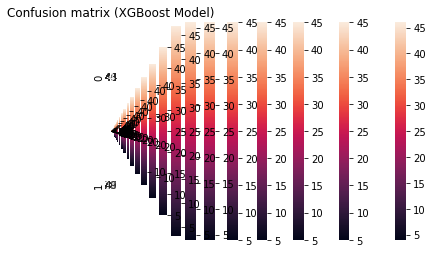

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import optuna
import shap
import xgboost as xgb

# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50


for i in range(n_iterations):
    # Step 2: Initial sampling
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])

    # Test data
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # Train data
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train = remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    # Modelling 
    # Creating and running our optimization
    study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")
    with parallel_backend('threading'):
        study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_xgb.best_trial.number)
    print("Best accuracy:", study_xgb.best_trial.value)
    print("Best hyperparameters:", study_xgb.best_params)

    # Train the best model
    best_param_xgb = study_xgb.best_params
    XGB = xgb.XGBClassifier(**best_param_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    XGB.fit(x_train_, y_train)
    y_pred_xgb = XGB.predict(x_test_)

    # Display results
    display_results(y_test, y_pred_xgb, cm_title="Confusion matrix (XGBoost Model)")

    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(XGB)
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 1 (assuming binary classification)
    shap_values_array = abs(shap_values)  # Use index 1 for the minority class

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

In [33]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [34]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('_xg_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.819418,0.345219,1.018311,0.382900,0.693317,0.514453,0.399821,0.318445,0.561485
1,0.869826,0.226269,0.613350,0.552603,0.206781,0.352491,0.446569,0.432395,0.462536
2,0.524165,0.234265,0.861748,0.393700,0.482893,0.360108,0.540797,0.344720,0.467799
3,0.589370,0.357486,0.751955,0.322138,0.226361,0.457582,0.395489,0.321074,0.427682
4,0.652828,0.289321,0.641460,0.348874,0.451487,0.389330,0.420508,0.338361,0.441521
...,...,...,...,...,...,...,...,...,...
95,0.855438,0.403059,0.451077,0.406495,0.756673,0.390096,0.476333,0.398995,0.517271
96,0.923444,0.249684,0.547315,0.891866,0.218678,0.358567,0.608519,0.321351,0.514928
97,1.119458,0.265977,0.813807,0.711378,0.324667,0.632800,0.630763,0.255930,0.594347
98,0.584913,0.448468,0.557357,0.636392,0.222141,0.690108,0.567771,0.318210,0.503170
